# Graph Neural Network for physics prediction

## 0. Dependencies

In [4]:
import torch
import random
import pandas as pd
import torch_scatter
import torch.nn as nn
from torch.nn import Linear, Sequential, LayerNorm, ReLU
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.loader import DataLoader

import numpy as np
import time
import torch.optim as optim
from tqdm import trange
import pandas as pd
import copy
import matplotlib.pyplot as plt

import enum
import tensorflow.compat.v1 as tf

import os
import numpy as np
import h5py
import functools
import json
from torch_geometric.data import Data
import enum
import networkx as nx

import trimesh
from tqdm import tqdm
from matplotlib.animation import FuncAnimation, FFMpegWriter
import math

2024-02-20 11:18:12.931719: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 11:18:12.931765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 11:18:12.933161: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-20 11:18:12.942203: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-20 11:18:13.919138: W tensorflow/comp

## 1. Data loading

### Working dirs

In [5]:
root_dir = os.getcwd()
dataset_dir = os.path.join(root_dir, '../data/{folder_name}'.format(folder_name='pytorch_datasets'))
trained_models_dir = os.path.join(root_dir, '../data/{folder_name}'.format(folder_name='pytorch_trained_models'))
trajectories_dir = os.path.join(root_dir, '../data/{folder_name}'.format(folder_name='trajectories'))

In [ ]:
print("trajectories_dir {}".format(trajectories_dir))

### Load trajectories

In [14]:
trajectories = {}

In [8]:
filenames_with_extension = os.listdir(trajectories_dir)
filenames_without_extension = [filename.split('.')[0] for filename in filenames_with_extension]
print(filenames_without_extension)

['I', 'T']


In [11]:
# Filter trajectories that won't be used for training
trajectories_to_filter = ["T"]
filtered_filenames_without_extension = [trajectory for trajectory in filenames_without_extension if trajectory not in trajectories_to_filter]
print(filtered_filenames_without_extension)

['I']


In [15]:
for filename in filtered_filenames_without_extension:
    with open(os.path.join(trajectories_dir, './{filename}.json'.format(filename=filename)), 'r') as file:
        trajectories[filename] = json.load(file)

In [16]:
print(trajectories.keys())

dict_keys(['I'])


### Exploratory analysis

### Generate pytorch dataset

#### Node Type class

In [25]:
class NodeType(enum.IntEnum):
  """
  Source: https://github.com/google-deepmind/deepmind-research/blob/master/meshgraphnets/common.py
  """
  NORMAL = 0
  OBSTACLE = 1
  AIRFOIL = 2
  HANDLE = 3
  INFLOW = 4
  OUTFLOW = 5
  WALL_BOUNDARY = 6
  SIZE = 9

#### Data normalization

In [18]:
def normalize(to_normalize, mean_vec, std_vec):
    return (to_normalize-mean_vec)/std_vec

def unnormalize(to_unnormalize, mean_vec, std_vec):
    return to_unnormalize*std_vec+mean_vec

def get_stats(dataset_list):
    """
    Function to normalize a pytorch Dataset.
    """

    # Init mean and std dev for node features
    mean_x = torch.zeros(dataset_list[0].x.shape[1:])
    std_x = torch.zeros(dataset_list[0].x.shape[1:])

    # Init mean and std dev for edge features
    mean_edge = torch.zeros(dataset_list[0].edge_attr.shape[1:])
    std_edge = torch.zeros(dataset_list[0].edge_attr.shape[1:])

    # Init mean and std dev for output parameters
    mean_y = torch.zeros(dataset_list[0].y.shape[1:])
    std_y = torch.zeros(dataset_list[0].y.shape[1:])

    # Define the maximum number of accumulations to perform such that we do not encounter memory issues
    max_accumulations = 10**6

    # Define a very small value for normalizing to 
    eps = torch.tensor(1e-8)

    # Define counters used in normalization
    num_accs_x = 0
    num_accs_edge = 0
    num_accs_y = 0

    # Iterate through the dtaset list
    for dp in dataset_list:
        
        mean_x += torch.sum(dp.x, dim=0)
        std_x += torch.sum(dp.x**2, dim=0)
        num_accs_x += dp.x.shape[0]
    
        mean_edge += torch.sum(dp.edge_attr, dim=0)
        std_edge += torch.sum(dp.edge_attr**2, dim=0)
        num_accs_edge += dp.edge_attr.shape[0]
    
        mean_y += torch.sum(dp.y, dim=0)
        std_y += torch.sum(dp.y**2, dim=0)
        num_accs_y += dp.y.shape[0]
    
        if (num_accs_x > max_accumulations or num_accs_edge > max_accumulations or num_accs_y > max_accumulations):
            break

    mean_x = mean_x/num_accs_x
    std_x = torch.maximum(torch.sqrt(std_x/num_accs_x - mean_x**2), eps)

    mean_edge = mean_edge/num_accs_edge
    std_edge = torch.maximum(torch.sqrt(std_edge/num_accs_edge - mean_edge**2), eps)

    mean_y = mean_y/num_accs_y
    std_y = torch.maximum(torch.sqrt(std_y/num_accs_y - mean_y**2), eps)

    mean_std_list = [mean_x, std_x, mean_edge, std_edge, mean_y, std_y]

    return mean_std_list

#### Convert hexahedrons to edges

In [19]:
def hexahedrons_to_edges(faces):
    """
    Compute mesh edges from mesh hexahedron elements of type 12 from VTK.
    """
    # collect edges from triangles
    edges = torch.cat((faces[:, 0:2],
                       faces[:, 1:3],
                       faces[:, 2:4],
                       torch.stack((faces[:, 3], faces[:, 0]), dim=1),
                       faces[:, 4:6],
                       faces[:, 5:7],
                       faces[:, 6:8],
                       torch.stack((faces[:, 7], faces[:, 4]), dim=1),
                       torch.stack((faces[:, 0], faces[:, 4]), dim=1),
                       torch.stack((faces[:, 1], faces[:, 5]), dim=1),
                       torch.stack((faces[:, 2], faces[:, 6]), dim=1),
                       torch.stack((faces[:, 3], faces[:, 7]), dim=1)), dim=0)
    # those edges are sometimes duplicated (within the mesh) and sometimes
    # single (at the mesh boundary).
    # sort & pack edges as single tf.int64
    receivers, _ = torch.min(edges, dim=1)
    senders, _ = torch.max(edges, dim=1)
    
    packed_edges = torch.stack((senders, receivers), dim=1)
    unique_edges = torch.unique(packed_edges, return_inverse=False, return_counts=False, dim=0)
    senders, receivers = torch.unbind(unique_edges, dim=1)
    senders = senders.to(torch.int64)
    receivers = receivers.to(torch.int64)
    
    two_way_connectivity = (torch.cat((senders, receivers), dim=0), torch.cat((receivers, senders), dim=0))
    return {'two_way_connectivity': two_way_connectivity, 'senders': senders, 'receivers': receivers}

#### Generate graph pytorch dataset

In [20]:
def generate_graph(ts, trajectories, trajectory, dt):
    # Build node feature matrix x, with shape [num_nodes, num_node_features]
    momentum = torch.tensor(np.array(trajectories[trajectory]['mesh_pos'][ts]))
    node_type = torch.tensor(np.array(tf.one_hot(tf.convert_to_tensor(trajectories[trajectory]['node_type'][ts]), NodeType.SIZE))).squeeze(1)
    x = torch.cat((momentum,node_type),dim=-1).type(torch.float)
    
    # Build graph connectivity edge_index, in CCO format and with shape [2, num_edges] and type torch.long
    edges = hexahedrons_to_edges(torch.tensor(np.array(trajectories[trajectory]['cells'][ts])))
    edge_index = torch.cat((torch.tensor(edges['two_way_connectivity'][0].numpy()).unsqueeze(0), torch.tensor(edges['two_way_connectivity'][1].numpy()).unsqueeze(0)), dim=0).type(torch.long)
    
    # Build edge feature matrix edge_attr, with shape [num_edges, num_edge_features]
    u_i=torch.tensor(np.array(trajectories[trajectory]['mesh_pos'][ts]))[edge_index[0]]
    u_j=torch.tensor(np.array(trajectories[trajectory]['mesh_pos'][ts]))[edge_index[1]]
    u_ij=u_i-u_j
    u_ij_norm = torch.norm(u_ij,p=2,dim=1,keepdim=True)
    edge_attr = torch.cat((u_ij,u_ij_norm),dim=-1).type(torch.float)
    
    # Build node outputs y, for training (displacement)
    v_t=torch.tensor(np.array(trajectories[trajectory]['mesh_pos'][ts]))
    v_tp1=torch.tensor(np.array(trajectories[trajectory]['mesh_pos'][ts+1]))
    y=((v_tp1-v_t)/dt).type(torch.float)
    
    # Build node position matrix pos, with shape [num_nodes, num_dimensions]
    mesh_pos=torch.tensor(np.array(trajectories[trajectory]['mesh_pos'][ts]))
    
    # Build other attributes
    cells=torch.tensor(np.array(trajectories[trajectory]['cells'][ts]))
    
    # Store data
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr,y=y,cells=cells,mesh_pos=mesh_pos)

In [21]:
def generate_graph_dataset(trajectories, number_trajectories, number_ts, dt):  
    # List to store the graphs for each trajectory and timestep ts, with size [1, number_trajectories*number_ts]
    data_list = []
    
    for i, trajectory in enumerate(trajectories.keys()):
        if(i==number_trajectories):
            break
        print("Trajectory: ", i, "-", list(trajectories.keys())[i])
        
        # Iterate over each time step to produce a graph. Generate graphs from Trajectory 0 to Trajectory N-1.
        for ts in range(number_ts): #len(trajectories[trajectory]['mesh_pos'])-1):          
            new_data = generate_graph(ts, trajectories, trajectory, dt)
            # Store data
            data_list.append(new_data)

    return data_list

In [22]:
def save_graph_dataset(dataset_list, output_path):
    # Save data in pytorch format
    torch.save(dataset_list, output_path)

#### Filter trajectories and generate dataset

In [26]:
# Number of trajectories N and timesteps ts
number_trajectories = len(trajectories)
number_ts = 100

# Timestep difference between graphs
dt = 5 #s

# Output file
output_dataset_name = 'training_set_torsion'
output_path = os.path.join(dataset_dir, '{filename}.pt'.format(filename=output_dataset_name))

# Generate dataset
dataset_list = generate_graph_dataset(trajectories, number_trajectories, number_ts, dt)
save_graph_dataset(dataset_list, output_path)

Trajectory:  0 - I


## 2. GNN Model

### 2.1. Graph Neural Networks (GNN) Theory

A graph $ \mathbf{G} = (V, E) $ consists of a set of vertices $ \upsilon_i \in V $ and a set of edges $ e_{ij} \in E $ connecting a pair of vertices $ v_{i}, v_{j} $.  

Given a physical system domain represented in the form of a triangluar mesh, it can be encoded as a graph $ \mathbf{G} = (V, E) $ where the vertices $ \upsilon_i \in V $ are the nodes of the mesh and the edges $ e_{ij} \in E $ are the triangle edges connecting the mesh.

Graph Neural Networks **GNN** work under the following principles:

- **1.** **Encoding**. We have a physical system under a given state $ \mathbf{X}^t $ at a given time **t**. The physical system is encoded into a graph $ \mathbf{G} = (V, E) $ which describes the current state $ \mathbf{X}^t $. This is the input of the GNN.
  
- **2.** **Processing - Message passing**. GNN computes properties and propagates information through the network to update the state of the system. The GNN output is a graph $ \mathbf{G'} = (V', E') $.
  
- **3.** **Decoding**. The updated graph $ \mathbf{G'} = (V', E') $. is decoded into the physical system which represents the state of the system $ \mathbf{X}^{t+1} $ at the future time **t+1**.  

<img src="../assets/gnn_steps.png" alt="GNN steps" />

#### Input - Encoding

_____________
Given a vector $x_i$ with a set of system properties as an input in the form of a graph G, the vertex encoders $\epsilon^{v}_{\Theta}$ and edge encoders $\epsilon^{e}_{\Theta}$ convert them into vertex and edge feature vectors ($v_{i}$ and $e_{ij}$) in the latent space.

$$v_{i} = \epsilon^{v}_{\Theta}(x_i)$$
$$e_{ij} = \epsilon^{e}_{\Theta}(r_{ij})$$

$\epsilon^{v}_{\Theta}$ and $\epsilon^{e}_{\Theta}$ are differentiable functions such as MLPs (Multi Layer Perceptrons) and $\Theta$  denotes a set of learnableparameters.

The **input dimension** is transformed into the **hidden dimension** in the latent space.
_____________

#### Message passing

#### Message passing

_____________________________
Message passing consists of 3 operations: 

(1) $e^{'}_{ij} = \phi_{\Theta}(v_{i}, v_{j}, e_{i,j})$  
(2) $\bar{v}_{i} = \sum_{j \in N(i)}{e^{'}_{i,j}}$  
(3) $v^{'}_{i} = \gamma_{\Theta}(v_{i}, \bar{v}_{i})$  

$\phi$ and $ \gamma $ denote differentiable functions such as MLPs (Multi Layer Perceptrons) and $\Theta$ denotes a set of learnable parameters.

Composing it all together -(1)->(2)->(3)- we get:

$v^{'}_{i} = \gamma_{\Theta}\left(v_{i}, \sum_{j \in N(i)}{\phi_{\Theta}(v_{i}, v_{j}, e_{i,j})} \right)$

We must note that we can generalize equation (2) and we get:

$v^{'}_{i} = \gamma_{\Theta}\left(v_{i}, \bigoplus_{j \in N(i)}{\phi_{\Theta}(v_{i}, v_{j}, e_{i,j})} \right)$

where $\bigoplus$ denotes any differentiable, permutation invariant function (e.g. sum, mean, min, max or mul).

(1) **Message construction**

The message construction function $\phi_{\Theta}$ takes the feature vector of the receiver and sender vertices $v_{i}, v_{j}$ and the feature vector of the edge connecting them $e_{i,j}$, and it returns the updated edge feature vector $e^{'}_{ij}$ as output.

The function **$\phi_{\Theta}$ input dimension** is equal to the **sum** of the **hidden dimension of $v_{i}, v_{j}$ and $e_{i,j}$**. The function **$\phi_{\Theta}$ output dimension** is equal to the **hidden dimension of the edges feature vector (edge embeddings)**

- **Example:**

We have a given region of the graph with the following connectivity, and we want to process the message passing for node 0. For this example, we consider that the hidden dimension of edges is 3 and the hidden dimension of vertices is also 3. We also consider all learnable parameters $\Theta$ as 1 for simplicity.

<img src="../assets/gnn_example.png" alt="GNN example" width="300"/>

For this example, image we define the message construction function as $\phi_{\Theta}(v_{i}, v_{j}, e_{i,j}) = ((v_{i}+v_{j}) \odot e_{ij}) \odot \Theta$, where $\odot$ denotes element-wise product. The updated feature vectors will have the following structure:

$e^{'}_{01} = ((v_{0}+v_{1}) \odot e_{01}) \odot \Theta = (([1,2,0]+[3,1,4]) \odot [1,2,1]) \odot [1,1,1] = [4,6,4]$  
$e^{'}_{02} = ((v_{0}+v_{2}) \odot e_{02}) \odot \Theta = (([1,2,0]+[5,0,2]) \odot [1,1,1]) \odot [1,1,1] = [6,2,2]$  
$e^{'}_{03} = ((v_{0}+v_{3}) \odot e_{03}) \odot \Theta = (([1,2,0]+[0,0,1]) \odot [2,1,3]) \odot [1,1,1] = [2,2,3]$  


(2) **Message aggregation**

$N(i)$ is the set of vertices $j$ related with vertex $i$. The message aggregation function $\bigoplus$ collects all the messages directed to vertex $i$ and aggregates those into a single vector with the same dimension as the aggregated message $\bar{v}_{i}$.

The **output dimension** of the aggregated message $\bar{v}_{i}$ is the same as the **hidden dimension** of the vertex feature vector (vertex embeddings) $v_{i}$.

- **Example:**

Continuing with the previous example, let's consider the message aggregation function as the element-wise summation of the messages directed to the vertex i as follows: $\bigoplus = \sum_{j \in N(i)}{e^{'}_{i,j}}$. For the aggregated message at vertex 0 we get:

$\bar{v}_{0} = e^{'}_{01} + e^{'}_{02} + e^{'}_{03} = [4,6,4] + [6,2,2] + [2,2,3] = [12,10,9]$.

(3) **Update vertex features**

The last step in message passing is to update the vertex features using (3). It takes the aggregated message $\bar{v}_{i}$ and the current vertex feature vector $v_{i}$ and it returns the updated vertex feature vector $v^{'}_{i}$.

The function **$\gamma_{\Theta}$ input dimension** is equal to the **sum** of the **hidden dimension of $v_{i}$ and the hidden dimension of the aggregated message $\bar{v}_{i}$**. The function **$\gamma_{\Theta}$ output dimension** is equal to the **hidden dimension of the vertices feature vector (vertex embeddings)**.

- **Example:**

Finally the edge and vertex features are updated. Imagine we define the vertex update function as $\gamma_{\Theta}(v_{i}, \bar{v}_{i}) = \Theta \odot (v_{i} + \bar{v}_{i})$. The update vertex 0 will be:

$v^{'}_{0} = \Theta \odot (v_{0} + \bar{v}_{0}) = [1,1,1] \odot ([1,2,0] + [12,10,9]) = [13,12,9]$
_____________________________

#### Output - Decoding

_____________
The decoder $\delta^{v}_{\Theta}$ extracts the output properties of the physical system $y^t$ from the vertices $v_{i}$ in the latent space.

$$y^t = \delta^{v}_{\Theta}(v_{i})$$

$\delta^{v}_{\Theta}$ is a differentiable function such as MLP (Multi Layer Perceptron) and $\Theta$ denotes a set of learnable parameters.

The **hidden dimension** of the **vertex embeddings $v_i$** in the latent space is transformed into the **output dimension** $y$.
_____________

### 2.3. MeshGraphNet

#### 2.3.1. MeshGraphNet class

In [27]:
class MeshGraphNet(torch.nn.Module):
    def __init__(self, input_dim_node, input_dim_edge, hidden_dim, output_dim, args, emb=False):
        """
        MeshGraphNet model. This model is based on Deepmind 2021 paper on MeshGraphNet.
        The model consists of 3 parts:
            (1) Preprocessing: encoder (edges and vertices)
            (2) Processor: message passing
            (3) PostProcessing: decoder (vertices)
        """
        super(MeshGraphNet, self).__init__()


        # 1. Encoder: the encoder converts the input space into the latent embeddings, both for edges and vertices.
        self.node_encoder = Sequential(Linear(input_dim_node, hidden_dim),
                                        ReLU(),
                                        Linear(hidden_dim, hidden_dim),
                                        LayerNorm(hidden_dim))
        
        self.edge_encoder = Sequential(Linear(input_dim_edge, hidden_dim),
                                        ReLU(),
                                        Linear(hidden_dim, hidden_dim),
                                        LayerNorm(hidden_dim))

        # 2. Processor: message passing.
        # Processor number of layers
        self.num_layers = args.num_layers
        assert (self.num_layers >= 1), "Error: Number of message passing layers is not >=1"

        # Processor layer
        processor_layer = self.build_processor_model()

        # Add processor layers
        self.processor = nn.ModuleList()      
        for _ in range(self.num_layers):
            self.processor.append(processor_layer(hidden_dim, hidden_dim))


        # 3. Decoder: the decoder converts the latent embeddings into the output space, for the vertices only.
        self.decoder = Sequential(Linear(hidden_dim, hidden_dim),
                              ReLU(),
                              Linear(hidden_dim, output_dim))


    def build_processor_model(self):
        return ProcessorLayer

    def forward(self, data, mean_x, std_x, mean_edge,std_edge):
        """
        Forward function computes the following operations:
        (1) Encoding: encode node/edge features into latent node/edge embeddings
            Input dimension: 
                Vertices: input_dim_node
                Edges: input_dim_edge
            Output dimension:
                Vertices: hidden_dimension
                Edges: hidden_dimension
        (2) Processing: perform message passing with latent node/edge embeddings
            (2.1) Message construction
                    Input dimension: hidden_dimension (v_i) + hidden_dimension (v_j) + hidden_dimension (e_ij)
                    Output dimension: hidden_dimension
            (2.2) Message aggregation
            (2.3) Vertex update
                    Input dimension: hidden_dimension (v_i) + hidden_dimension (\bar{v}_i)
                    Output dimension: hidden_dimension
        (3) Decoding: decode latent node embeddings into physical properties
            Input dimension: hidden_dim
            Output dimension: output_dim
        """
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # Normalize
        x = normalize(x, mean_x, std_x)
        edge_attr = normalize(edge_attr, mean_edge,std_edge)

        # 1. Encoder: encode node/edge features into latent node/edge embeddings
        x = self.node_encoder(x) # output shape is the hidden dimension
        edge_attr = self.edge_encoder(edge_attr) # output shape is the hidden dimension

        # 2. Processor: perform message passing with latent node/edge embeddings
        for i in range(self.num_layers):
            x,edge_attr = self.processor[i](x,edge_index,edge_attr)

        # 3. Decoder: decode latent node embeddings into physical properties
        return self.decoder(x)

    def loss(self, pred, inputs, mean_y, std_y):
        """
        Ref Deepmind: https://github.com/wwMark/meshgraphnets/blob/ddcfdf52ef86a42566272cc636f39b04223dbf7d/run_model.py#L418
        Ref Medium: https://colab.research.google.com/drive/1mZAWP6k9R0DE5NxPzF8yL2HpIUG3aoDC#scrollTo=5jRZNBna7hPV&line=74&uniqifier=1
        """
        #criterion = torch.nn.MSELoss()  #Initialize the loss function.

        # Target
        target = normalize(inputs.y, mean_y, std_y)

        # Nodes we calculate loss for
        loss_mask = torch.argmax(inputs.x[:,3:],dim=1) == torch.tensor(0) #torch.eq(inputs.x[:,3:], #torch.tensor([NodeType.NORMAL.value]).int())
        
        # Sum of square errors
        error=torch.sum((target-pred)**2,axis=1)
        
        # Mean error for the nodes we calculate loss for
        loss=torch.mean(torch.mean(error[loss_mask]))
        
        return loss

#### 2.3.2. Processor Layer class - Message Passing

In [28]:
class ProcessorLayer(MessagePassing):
    def __init__(self, in_channels, out_channels,  **kwargs):
        super(ProcessorLayer, self).__init__(  **kwargs )
        """
        Define MLPs for:
        (1) Message construction (edge_mlp)
                Input dimension: in_channels (v_i) + in_channels (v_j) + in_channels (e_ij)
                Output dimension: out_channels
        (3) Node update
                Input dimension: in_channels (v_i) + in_channels (\bar{v}_i)
                Output dimension: out_channels
        
        Note that the node and edge encoders both have the same hidden dimension.

        """
        # Message construction MLP
        self.edge_mlp = Sequential(Linear(3*in_channels, out_channels),
                                   ReLU(),
                                   Linear(out_channels, out_channels),
                                   LayerNorm(out_channels))
        # Node update MLP
        self.node_mlp = Sequential(Linear(2*in_channels, out_channels),
                                   ReLU(),
                                   Linear(out_channels, out_channels),
                                   LayerNorm(out_channels))
        
        self.reset_parameters()

    def reset_parameters(self):
        """
        Reset parameters for stacked MLP layers
        """
        self.edge_mlp[0].reset_parameters()
        self.edge_mlp[2].reset_parameters()

        self.node_mlp[0].reset_parameters()
        self.node_mlp[2].reset_parameters()

    def forward(self, x, edge_index, edge_attr, size = None):
        """
        Message passing function to updwte node features/embeddings. The sequence of steps is the following:
        (1) Message construction --> self.message()
        (2) Message aggregation --> self.aggregate()
        (3) Node update

        (1) and (2) are handled through the 'self.propagate()' function call.
        (3) is handled based on the outputs from 'self.propagate()'.

        The shape of the inputs is:
        
        x: [num_nodes , num_node_features=in_channels] (node embeddings)
        edge_index: [2, num_edges]
        edge_attr: [num_edges, num_edge_features=in_channels] (edge embeddings)
        
        """

        out, updated_edges = self.propagate(edge_index, x = x, edge_attr = edge_attr, size = size) # out shape: [num_edges, out_channels]

        updated_nodes = torch.cat([x,out],dim=1) # complete the aggregation through self-aggregation

        updated_nodes = x + self.node_mlp(updated_nodes) # residual connection

        return updated_nodes, updated_edges

    def message(self, x_i, x_j, edge_attr):
        """
        Message construction function e'_ij = f(x_i, x_j, e_ij). The output e'_ij is the message sent from node j to node i.

        The shape of the inputs is:
        
        x_i: [num_nodes, in_channels]
        x_j: [num_nodes, in_channels]
        edge_attr: [num_edges, in_channels]
        
        """

        updated_edges=torch.cat([x_i, x_j, edge_attr], dim = 1) 
        updated_edges=self.edge_mlp(updated_edges)+edge_attr # updated_edges has shape [num_edges, out_channels]

        return updated_edges

    def aggregate(self, updated_edges, edge_index, dim_size = None):
        """
        Message aggregation function out = f(e'_ij). The function collects and aggregates all the messages directed to vertex i from vertices j in N(i) -adjacent nodes or neighbors-.
        
        """

        # The axis along which to index number of nodes.
        node_dim = 0

        out = torch_scatter.scatter(updated_edges, edge_index[0, :], dim=node_dim, reduce = 'sum')

        return out, updated_edges

## 3. Training

### 3.1. Training functions

#### 3.1.1. Training args

In [35]:
class TrainingArgs(object):
    def __init__(self, d):
        self.__dict__ = d

args = TrainingArgs(
    {
        'num_layers': 2,
        'batch_size': 16, 
        'hidden_dim': 10, 
        'epochs': 100,
        'dataset_size': 600,
        'train_size': 0.7,  
        'device':'cpu',
        'shuffle': True,
        'trained_model_filename': 'trained_model.pt',
        'training_dataset_filename': 'training_set_torsion.pt',
    }
)

#### 3.1.2. Evaluation loop

In [30]:
def test(test_loader, test_model, stats_list, args):
    """
    Evaluation loop
    """
    # Set the model to evaluation mode
    test_model.eval()

    # ================================================ Normalization data ==================================
    mean_x, std_x = stats_list[0].to(args.device), stats_list[1].to(args.device)
    mean_edge, std_edge = stats_list[2].to(args.device), stats_list[3].to(args.device)
    mean_y, std_y = stats_list[4].to(args.device), stats_list[5].to(args.device)
    # ======================================================================================================
    
    # Test loop
    loss = 0
    num_loops = 0
    
    with torch.no_grad():
        for test_batch in test_loader:
            out = test_model(test_batch, mean_x, std_x, mean_edge, std_edge) # Forward pass
            loss += test_model.loss(out, test_batch, mean_y, std_y) # Compute the test loss
            num_loops += 1
    
    return loss/num_loops

#### 3.1.3. Training loop

In [32]:
def train(dataset, stats_list, args):
    """
    Training loop

    args: TrainingArgs
    """
    # =================================================== Build model ============================================
    num_node_features = dataset[0].x.shape[1]
    num_edge_features = dataset[0].edge_attr.shape[1]
    num_classes = 3 # shape 3 (displacement)
    
    model = MeshGraphNet(num_node_features, num_edge_features, args.hidden_dim, num_classes, args).to(args.device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Initialize the optimizer.

    # ====================================== Load train and test datasets ========================================
    # Build train and test subsets
    total_length = len(dataset)
    
    # Compute training and testing samples
    train_length = int(args.train_size * total_length)
    test_length = total_length - train_length
    
    # Shuffle the indices of the dataset
    indices = np.arange(total_length)
    np.random.shuffle(indices)
    
    # Use the shuffled indices to split the dataset
    train_indices = indices[:train_length]
    test_indices = indices[train_length:]
    
    # Split the dataset into training and testing subsets
    train_dataset = [dataset[i] for i in train_indices]
    test_dataset = [dataset[i] for i in test_indices]

    print(f'Train dataset size is {args.train_size*100}% of the input dataset of size {len(dataset)}: {len(train_dataset)}')
    print(f'Test dataset size is {100-args.train_size*100}% of the input dataset of size {len(dataset)}: {len(test_dataset)}')
    
    # Init loaders
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=args.shuffle)
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=args.shuffle)
    
    # ================================================ Normalization data ==================================
    mean_x, std_x = stats_list[0].to(args.device), stats_list[1].to(args.device)
    mean_edge, std_edge = stats_list[2].to(args.device), stats_list[3].to(args.device)
    mean_y, std_y = stats_list[4].to(args.device), stats_list[5].to(args.device)
    
    # =================================================== Train ============================================

    losses = []
    test_losses = []
    
    for epoch in tqdm(range(args.epochs), unit='epoch'):
        # Set model in training mode
        model.train()
        
        # ============================ Train model ============================
        for batch in train_loader:              
            optimizer.zero_grad() # Clear previous gradients
            
            out = model(batch, mean_x, std_x, mean_edge, std_edge) # Forward pass

            loss = model.loss(out, batch, mean_y, std_y) # Compute the loss based on training nodes
            
            # Backpropagation
            loss.backward()  # Derive gradients
            optimizer.step()  # Update weights (parameters) based on gradients
        
        # ====================================================================
        
        # Update training metrics
        losses.append(loss.item())
        print(f'Epoch: {epoch}, Loss: {loss}')

        # ============================ Evaluation loop ========================
        if epoch % 10 == 0: # Every Nth epoch, run evaluation loop
            test_loss = test(test_loader, model, stats_list, args)
            test_losses.append(test_loss.item())
        else: # Append previous loss to have the same vector length as the train losses
            test_losses.append(test_losses[-1])
        # ====================================================================
  
    torch.save(model.state_dict(), os.path.join(trained_models_dir, args.trained_model_filename))
    
    return losses, test_losses

### 3.2. Train

In [33]:
# To ensure reproducibility the best we can, here we control the sources of randomness by seeding the various random number generators
# For more information, see: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(5)  #Torch
random.seed(5)        #Python
np.random.seed(5)     #NumPy

In [37]:
args = TrainingArgs(
    {
        'num_layers': 2,
        'batch_size': 16, 
        'hidden_dim': 10, 
        'epochs': 2500,
        'dataset_size': 100,
        'train_size': 0.7,  
        'device':'cpu',
        'shuffle': True,
        'trained_model_filename': 'trained_model.pt',
        'training_dataset_filename': 'training_set_torsion.pt',
    }
)

In [38]:
# Load dataset
file_path=os.path.join(dataset_dir, args.training_dataset_filename)
dataset = torch.load(file_path)[:args.dataset_size]

# Get statistics to normalize
stats_list = get_stats(dataset)

# Train
losses, test_losses = train(dataset, stats_list, args)

Train dataset size is 70.0% of the input dataset of size 100: 70
Test dataset size is 30.0% of the input dataset of size 100: 30


  0%|                                                          | 1/2500 [00:00<33:35,  1.24epoch/s]

Epoch: 0, Loss: 2.2128357887268066


  0%|                                                          | 2/2500 [00:01<29:43,  1.40epoch/s]

Epoch: 1, Loss: 1.5280699729919434


  0%|                                                          | 3/2500 [00:02<27:45,  1.50epoch/s]

Epoch: 2, Loss: 1.0012754201889038


  0%|                                                          | 4/2500 [00:02<26:46,  1.55epoch/s]

Epoch: 3, Loss: 0.5289908647537231


  0%|                                                          | 5/2500 [00:03<27:56,  1.49epoch/s]

Epoch: 4, Loss: 0.41503188014030457


  0%|▏                                                         | 6/2500 [00:04<27:44,  1.50epoch/s]

Epoch: 5, Loss: 0.3517419993877411


  0%|▏                                                         | 7/2500 [00:04<27:42,  1.50epoch/s]

Epoch: 6, Loss: 0.24825330078601837


  0%|▏                                                         | 8/2500 [00:05<27:30,  1.51epoch/s]

Epoch: 7, Loss: 0.16780436038970947


  0%|▏                                                         | 9/2500 [00:05<26:46,  1.55epoch/s]

Epoch: 8, Loss: 0.1306580752134323


  0%|▏                                                        | 10/2500 [00:06<26:41,  1.55epoch/s]

Epoch: 9, Loss: 0.135903999209404


  0%|▎                                                        | 11/2500 [00:07<28:44,  1.44epoch/s]

Epoch: 10, Loss: 0.1039516031742096


  0%|▎                                                        | 12/2500 [00:08<27:47,  1.49epoch/s]

Epoch: 11, Loss: 0.06513049453496933


  1%|▎                                                        | 13/2500 [00:08<26:45,  1.55epoch/s]

Epoch: 12, Loss: 0.0596960112452507


  1%|▎                                                        | 14/2500 [00:09<26:39,  1.55epoch/s]

Epoch: 13, Loss: 0.10338278114795685


  1%|▎                                                        | 15/2500 [00:09<26:30,  1.56epoch/s]

Epoch: 14, Loss: 0.07885584980249405


  1%|▎                                                        | 16/2500 [00:10<26:15,  1.58epoch/s]

Epoch: 15, Loss: 0.04620193690061569


  1%|▍                                                        | 17/2500 [00:11<26:18,  1.57epoch/s]

Epoch: 16, Loss: 0.03884897381067276


  1%|▍                                                        | 18/2500 [00:11<27:12,  1.52epoch/s]

Epoch: 17, Loss: 0.0349179208278656


  1%|▍                                                        | 19/2500 [00:12<27:19,  1.51epoch/s]

Epoch: 18, Loss: 0.044761523604393005


  1%|▍                                                        | 20/2500 [00:13<26:54,  1.54epoch/s]

Epoch: 19, Loss: 0.03228035569190979


  1%|▍                                                        | 21/2500 [00:13<27:52,  1.48epoch/s]

Epoch: 20, Loss: 0.02542419359087944


  1%|▌                                                        | 22/2500 [00:14<27:27,  1.50epoch/s]

Epoch: 21, Loss: 0.02427699789404869


  1%|▌                                                        | 23/2500 [00:15<27:08,  1.52epoch/s]

Epoch: 22, Loss: 0.10282402485609055


  1%|▌                                                        | 24/2500 [00:15<26:40,  1.55epoch/s]

Epoch: 23, Loss: 0.05133715271949768


  1%|▌                                                        | 25/2500 [00:16<25:50,  1.60epoch/s]

Epoch: 24, Loss: 0.045046474784612656


  1%|▌                                                        | 26/2500 [00:17<25:44,  1.60epoch/s]

Epoch: 25, Loss: 0.03697573021054268


  1%|▌                                                        | 27/2500 [00:17<25:17,  1.63epoch/s]

Epoch: 26, Loss: 0.032445695251226425


  1%|▋                                                        | 28/2500 [00:18<25:01,  1.65epoch/s]

Epoch: 27, Loss: 0.02351483330130577


  1%|▋                                                        | 29/2500 [00:18<25:32,  1.61epoch/s]

Epoch: 28, Loss: 0.02426711469888687


  1%|▋                                                        | 30/2500 [00:19<25:26,  1.62epoch/s]

Epoch: 29, Loss: 0.024036232382059097


  1%|▋                                                        | 31/2500 [00:20<26:05,  1.58epoch/s]

Epoch: 30, Loss: 0.022938288748264313


  1%|▋                                                        | 32/2500 [00:20<26:08,  1.57epoch/s]

Epoch: 31, Loss: 0.016023579984903336


  1%|▊                                                        | 33/2500 [00:21<26:13,  1.57epoch/s]

Epoch: 32, Loss: 0.017109613865613937


  1%|▊                                                        | 34/2500 [00:21<25:21,  1.62epoch/s]

Epoch: 33, Loss: 0.017546650022268295


  1%|▊                                                        | 35/2500 [00:22<25:28,  1.61epoch/s]

Epoch: 34, Loss: 0.017364157363772392


  1%|▊                                                        | 36/2500 [00:23<25:46,  1.59epoch/s]

Epoch: 35, Loss: 0.01595895178616047


  1%|▊                                                        | 37/2500 [00:23<25:26,  1.61epoch/s]

Epoch: 36, Loss: 0.01465760450810194


  2%|▊                                                        | 38/2500 [00:24<25:30,  1.61epoch/s]

Epoch: 37, Loss: 0.013840220868587494


  2%|▉                                                        | 39/2500 [00:25<25:32,  1.61epoch/s]

Epoch: 38, Loss: 0.01490472536534071


  2%|▉                                                        | 40/2500 [00:25<26:03,  1.57epoch/s]

Epoch: 39, Loss: 0.013811052776873112


  2%|▉                                                        | 41/2500 [00:26<27:24,  1.50epoch/s]

Epoch: 40, Loss: 0.014437677338719368


  2%|▉                                                        | 42/2500 [00:27<26:47,  1.53epoch/s]

Epoch: 41, Loss: 0.012726400047540665


  2%|▉                                                        | 43/2500 [00:27<26:30,  1.54epoch/s]

Epoch: 42, Loss: 0.012221530079841614


  2%|█                                                        | 44/2500 [00:28<26:21,  1.55epoch/s]

Epoch: 43, Loss: 0.01160719059407711


  2%|█                                                        | 45/2500 [00:29<26:00,  1.57epoch/s]

Epoch: 44, Loss: 0.012955106794834137


  2%|█                                                        | 46/2500 [00:29<26:10,  1.56epoch/s]

Epoch: 45, Loss: 0.011946366168558598


  2%|█                                                        | 47/2500 [00:30<25:17,  1.62epoch/s]

Epoch: 46, Loss: 0.01206592284142971


  2%|█                                                        | 48/2500 [00:30<24:57,  1.64epoch/s]

Epoch: 47, Loss: 0.010371054522693157


  2%|█                                                        | 49/2500 [00:31<25:11,  1.62epoch/s]

Epoch: 48, Loss: 0.010702441446483135


  2%|█▏                                                       | 50/2500 [00:32<25:15,  1.62epoch/s]

Epoch: 49, Loss: 0.023804793134331703


  2%|█▏                                                       | 51/2500 [00:32<27:13,  1.50epoch/s]

Epoch: 50, Loss: 0.020531851798295975


  2%|█▏                                                       | 52/2500 [00:33<27:03,  1.51epoch/s]

Epoch: 51, Loss: 0.011774432845413685


  2%|█▏                                                       | 53/2500 [00:34<26:35,  1.53epoch/s]

Epoch: 52, Loss: 0.011134535074234009


  2%|█▏                                                       | 54/2500 [00:34<26:01,  1.57epoch/s]

Epoch: 53, Loss: 0.01001416053622961


  2%|█▎                                                       | 55/2500 [00:35<26:00,  1.57epoch/s]

Epoch: 54, Loss: 0.011482044123113155


  2%|█▎                                                       | 56/2500 [00:35<25:28,  1.60epoch/s]

Epoch: 55, Loss: 0.009697836823761463


  2%|█▎                                                       | 57/2500 [00:36<26:00,  1.57epoch/s]

Epoch: 56, Loss: 0.009435462765395641


  2%|█▎                                                       | 58/2500 [00:37<25:32,  1.59epoch/s]

Epoch: 57, Loss: 0.00901259109377861


  2%|█▎                                                       | 59/2500 [00:37<25:33,  1.59epoch/s]

Epoch: 58, Loss: 0.011652871966362


  2%|█▎                                                       | 60/2500 [00:38<25:09,  1.62epoch/s]

Epoch: 59, Loss: 0.04055100306868553


  2%|█▍                                                       | 61/2500 [00:39<26:28,  1.54epoch/s]

Epoch: 60, Loss: 0.021034857258200645


  2%|█▍                                                       | 62/2500 [00:39<25:53,  1.57epoch/s]

Epoch: 61, Loss: 0.02061019279062748


  3%|█▍                                                       | 63/2500 [00:40<25:49,  1.57epoch/s]

Epoch: 62, Loss: 0.019453516229987144


  3%|█▍                                                       | 64/2500 [00:41<25:39,  1.58epoch/s]

Epoch: 63, Loss: 0.013327546417713165


  3%|█▍                                                       | 65/2500 [00:41<25:39,  1.58epoch/s]

Epoch: 64, Loss: 0.015360102988779545


  3%|█▌                                                       | 66/2500 [00:42<25:14,  1.61epoch/s]

Epoch: 65, Loss: 0.011388002894818783


  3%|█▌                                                       | 67/2500 [00:42<25:33,  1.59epoch/s]

Epoch: 66, Loss: 0.012742198072373867


  3%|█▌                                                       | 68/2500 [00:43<25:17,  1.60epoch/s]

Epoch: 67, Loss: 0.012644530273973942


  3%|█▌                                                       | 69/2500 [00:44<25:03,  1.62epoch/s]

Epoch: 68, Loss: 0.008569366298615932


  3%|█▌                                                       | 70/2500 [00:44<25:34,  1.58epoch/s]

Epoch: 69, Loss: 0.008908933028578758


  3%|█▌                                                       | 71/2500 [00:45<26:34,  1.52epoch/s]

Epoch: 70, Loss: 0.008510682731866837


  3%|█▋                                                       | 72/2500 [00:46<26:08,  1.55epoch/s]

Epoch: 71, Loss: 0.0073334272019565105


  3%|█▋                                                       | 73/2500 [00:46<26:02,  1.55epoch/s]

Epoch: 72, Loss: 0.008451409637928009


  3%|█▋                                                       | 74/2500 [00:47<25:46,  1.57epoch/s]

Epoch: 73, Loss: 0.007430198602378368


  3%|█▋                                                       | 75/2500 [00:48<25:51,  1.56epoch/s]

Epoch: 74, Loss: 0.01071686390787363


  3%|█▋                                                       | 76/2500 [00:48<25:41,  1.57epoch/s]

Epoch: 75, Loss: 0.00800627376884222


  3%|█▊                                                       | 77/2500 [00:49<25:34,  1.58epoch/s]

Epoch: 76, Loss: 0.010958991013467312


  3%|█▊                                                       | 78/2500 [00:49<24:56,  1.62epoch/s]

Epoch: 77, Loss: 0.0125341285020113


  3%|█▊                                                       | 79/2500 [00:50<24:12,  1.67epoch/s]

Epoch: 78, Loss: 0.01191908959299326


  3%|█▊                                                       | 80/2500 [00:51<24:04,  1.68epoch/s]

Epoch: 79, Loss: 0.021844230592250824


  3%|█▊                                                       | 81/2500 [00:51<25:10,  1.60epoch/s]

Epoch: 80, Loss: 0.007810922339558601


  3%|█▊                                                       | 82/2500 [00:52<25:05,  1.61epoch/s]

Epoch: 81, Loss: 0.009021485224366188


  3%|█▉                                                       | 83/2500 [00:52<24:53,  1.62epoch/s]

Epoch: 82, Loss: 0.006902527995407581


  3%|█▉                                                       | 84/2500 [00:53<25:01,  1.61epoch/s]

Epoch: 83, Loss: 0.008492070250213146


  3%|█▉                                                       | 85/2500 [00:54<25:00,  1.61epoch/s]

Epoch: 84, Loss: 0.010418065823614597


  3%|█▉                                                       | 86/2500 [00:54<25:32,  1.58epoch/s]

Epoch: 85, Loss: 0.0074263461865484715


  3%|█▉                                                       | 87/2500 [00:55<25:33,  1.57epoch/s]

Epoch: 86, Loss: 0.00768326735123992


  4%|██                                                       | 88/2500 [00:56<25:25,  1.58epoch/s]

Epoch: 87, Loss: 0.008788851089775562


  4%|██                                                       | 89/2500 [00:56<25:32,  1.57epoch/s]

Epoch: 88, Loss: 0.009366100654006004


  4%|██                                                       | 90/2500 [00:57<26:08,  1.54epoch/s]

Epoch: 89, Loss: 0.011146868579089642


  4%|██                                                       | 91/2500 [00:58<26:41,  1.50epoch/s]

Epoch: 90, Loss: 0.05932209640741348


  4%|██                                                       | 92/2500 [00:58<26:04,  1.54epoch/s]

Epoch: 91, Loss: 0.022262388840317726


  4%|██                                                       | 93/2500 [00:59<25:59,  1.54epoch/s]

Epoch: 92, Loss: 0.014255043119192123


  4%|██▏                                                      | 94/2500 [01:00<25:54,  1.55epoch/s]

Epoch: 93, Loss: 0.00807933323085308


  4%|██▏                                                      | 95/2500 [01:00<26:06,  1.54epoch/s]

Epoch: 94, Loss: 0.006806993391364813


  4%|██▏                                                      | 96/2500 [01:01<25:53,  1.55epoch/s]

Epoch: 95, Loss: 0.006881537847220898


  4%|██▏                                                      | 97/2500 [01:01<25:38,  1.56epoch/s]

Epoch: 96, Loss: 0.007538506295531988


  4%|██▏                                                      | 98/2500 [01:02<25:29,  1.57epoch/s]

Epoch: 97, Loss: 0.007610384840518236


  4%|██▎                                                      | 99/2500 [01:03<25:20,  1.58epoch/s]

Epoch: 98, Loss: 0.005502269137650728


  4%|██▏                                                     | 100/2500 [01:03<25:15,  1.58epoch/s]

Epoch: 99, Loss: 0.005468449089676142


  4%|██▎                                                     | 101/2500 [01:04<26:19,  1.52epoch/s]

Epoch: 100, Loss: 0.0064833262003958225


  4%|██▎                                                     | 102/2500 [01:05<26:05,  1.53epoch/s]

Epoch: 101, Loss: 0.006987185217440128


  4%|██▎                                                     | 103/2500 [01:05<25:45,  1.55epoch/s]

Epoch: 102, Loss: 0.007243157830089331


  4%|██▎                                                     | 104/2500 [01:06<25:05,  1.59epoch/s]

Epoch: 103, Loss: 0.00672615272924304


  4%|██▎                                                     | 105/2500 [01:07<25:15,  1.58epoch/s]

Epoch: 104, Loss: 0.007207600865513086


  4%|██▎                                                     | 106/2500 [01:07<25:08,  1.59epoch/s]

Epoch: 105, Loss: 0.005061160307377577


  4%|██▍                                                     | 107/2500 [01:08<25:04,  1.59epoch/s]

Epoch: 106, Loss: 0.007617305964231491


  4%|██▍                                                     | 108/2500 [01:08<24:21,  1.64epoch/s]

Epoch: 107, Loss: 0.004163017030805349


  4%|██▍                                                     | 109/2500 [01:09<24:08,  1.65epoch/s]

Epoch: 108, Loss: 0.005475220736116171


  4%|██▍                                                     | 110/2500 [01:10<24:25,  1.63epoch/s]

Epoch: 109, Loss: 0.021711338311433792


  4%|██▍                                                     | 111/2500 [01:10<26:11,  1.52epoch/s]

Epoch: 110, Loss: 0.01822344772517681


  4%|██▌                                                     | 112/2500 [01:11<25:51,  1.54epoch/s]

Epoch: 111, Loss: 0.010287057608366013


  5%|██▌                                                     | 113/2500 [01:12<25:29,  1.56epoch/s]

Epoch: 112, Loss: 0.008095129393041134


  5%|██▌                                                     | 114/2500 [01:12<25:15,  1.57epoch/s]

Epoch: 113, Loss: 0.013649913482367992


  5%|██▌                                                     | 115/2500 [01:13<25:08,  1.58epoch/s]

Epoch: 114, Loss: 0.008111684583127499


  5%|██▌                                                     | 116/2500 [01:14<25:09,  1.58epoch/s]

Epoch: 115, Loss: 0.0073252287693321705


  5%|██▌                                                     | 117/2500 [01:14<24:58,  1.59epoch/s]

Epoch: 116, Loss: 0.005503855645656586


  5%|██▋                                                     | 118/2500 [01:15<24:56,  1.59epoch/s]

Epoch: 117, Loss: 0.004799588583409786


  5%|██▋                                                     | 119/2500 [01:15<24:48,  1.60epoch/s]

Epoch: 118, Loss: 0.004581772722303867


  5%|██▋                                                     | 120/2500 [01:16<24:47,  1.60epoch/s]

Epoch: 119, Loss: 0.004364407155662775


  5%|██▋                                                     | 121/2500 [01:17<25:20,  1.56epoch/s]

Epoch: 120, Loss: 0.004372172988951206


  5%|██▋                                                     | 122/2500 [01:17<25:02,  1.58epoch/s]

Epoch: 121, Loss: 0.0034987363032996655


  5%|██▊                                                     | 123/2500 [01:18<24:38,  1.61epoch/s]

Epoch: 122, Loss: 0.003994191065430641


  5%|██▊                                                     | 124/2500 [01:19<24:25,  1.62epoch/s]

Epoch: 123, Loss: 0.0036935668904334307


  5%|██▊                                                     | 125/2500 [01:19<24:08,  1.64epoch/s]

Epoch: 124, Loss: 0.004717477131634951


  5%|██▊                                                     | 126/2500 [01:20<24:27,  1.62epoch/s]

Epoch: 125, Loss: 0.0036611498799175024


  5%|██▊                                                     | 127/2500 [01:20<24:18,  1.63epoch/s]

Epoch: 126, Loss: 0.0032968115992844105


  5%|██▊                                                     | 128/2500 [01:21<24:46,  1.60epoch/s]

Epoch: 127, Loss: 0.0034627707209438086


  5%|██▉                                                     | 129/2500 [01:22<25:05,  1.58epoch/s]

Epoch: 128, Loss: 0.004115453455597162


  5%|██▉                                                     | 130/2500 [01:22<24:46,  1.59epoch/s]

Epoch: 129, Loss: 0.003977749031037092


  5%|██▉                                                     | 131/2500 [01:23<25:55,  1.52epoch/s]

Epoch: 130, Loss: 0.003377781482413411


  5%|██▉                                                     | 132/2500 [01:24<25:47,  1.53epoch/s]

Epoch: 131, Loss: 0.004917251877486706


  5%|██▉                                                     | 133/2500 [01:24<25:18,  1.56epoch/s]

Epoch: 132, Loss: 0.01325194165110588


  5%|███                                                     | 134/2500 [01:25<26:13,  1.50epoch/s]

Epoch: 133, Loss: 0.030682196840643883


  5%|███                                                     | 135/2500 [01:26<25:34,  1.54epoch/s]

Epoch: 134, Loss: 0.01724587380886078


  5%|███                                                     | 136/2500 [01:26<25:22,  1.55epoch/s]

Epoch: 135, Loss: 0.013721190392971039


  5%|███                                                     | 137/2500 [01:27<24:46,  1.59epoch/s]

Epoch: 136, Loss: 0.011802981607615948


  6%|███                                                     | 138/2500 [01:27<24:53,  1.58epoch/s]

Epoch: 137, Loss: 0.007083861157298088


  6%|███                                                     | 139/2500 [01:28<24:57,  1.58epoch/s]

Epoch: 138, Loss: 0.009908583015203476


  6%|███▏                                                    | 140/2500 [01:29<24:50,  1.58epoch/s]

Epoch: 139, Loss: 0.007187063340097666


  6%|███▏                                                    | 141/2500 [01:29<25:18,  1.55epoch/s]

Epoch: 140, Loss: 0.0038802383933216333


  6%|███▏                                                    | 142/2500 [01:30<25:09,  1.56epoch/s]

Epoch: 141, Loss: 0.004401652608066797


  6%|███▏                                                    | 143/2500 [01:31<25:05,  1.57epoch/s]

Epoch: 142, Loss: 0.004305525217205286


  6%|███▏                                                    | 144/2500 [01:31<24:54,  1.58epoch/s]

Epoch: 143, Loss: 0.004865928087383509


  6%|███▏                                                    | 145/2500 [01:32<24:49,  1.58epoch/s]

Epoch: 144, Loss: 0.0036353638861328363


  6%|███▎                                                    | 146/2500 [01:33<24:33,  1.60epoch/s]

Epoch: 145, Loss: 0.0034097153693437576


  6%|███▎                                                    | 147/2500 [01:33<24:46,  1.58epoch/s]

Epoch: 146, Loss: 0.003949068486690521


  6%|███▎                                                    | 148/2500 [01:34<24:28,  1.60epoch/s]

Epoch: 147, Loss: 0.0036940143909305334


  6%|███▎                                                    | 149/2500 [01:34<24:13,  1.62epoch/s]

Epoch: 148, Loss: 0.004887996707111597


  6%|███▎                                                    | 150/2500 [01:35<24:13,  1.62epoch/s]

Epoch: 149, Loss: 0.0038336797151714563


  6%|███▍                                                    | 151/2500 [01:36<25:04,  1.56epoch/s]

Epoch: 150, Loss: 0.003567428793758154


  6%|███▍                                                    | 152/2500 [01:36<24:33,  1.59epoch/s]

Epoch: 151, Loss: 0.0030397437512874603


  6%|███▍                                                    | 153/2500 [01:37<24:31,  1.59epoch/s]

Epoch: 152, Loss: 0.002981661120429635


  6%|███▍                                                    | 154/2500 [01:38<24:41,  1.58epoch/s]

Epoch: 153, Loss: 0.002894232515245676


  6%|███▍                                                    | 155/2500 [01:38<24:26,  1.60epoch/s]

Epoch: 154, Loss: 0.002818731125444174


  6%|███▍                                                    | 156/2500 [01:39<24:06,  1.62epoch/s]

Epoch: 155, Loss: 0.0035643824376165867


  6%|███▌                                                    | 157/2500 [01:39<24:06,  1.62epoch/s]

Epoch: 156, Loss: 0.00836188904941082


  6%|███▌                                                    | 158/2500 [01:40<24:07,  1.62epoch/s]

Epoch: 157, Loss: 0.016255462542176247


  6%|███▌                                                    | 159/2500 [01:41<24:32,  1.59epoch/s]

Epoch: 158, Loss: 0.0037339539267122746


  6%|███▌                                                    | 160/2500 [01:41<24:09,  1.61epoch/s]

Epoch: 159, Loss: 0.0038378313183784485


  6%|███▌                                                    | 161/2500 [01:42<24:58,  1.56epoch/s]

Epoch: 160, Loss: 0.003625133540481329


  6%|███▋                                                    | 162/2500 [01:43<24:43,  1.58epoch/s]

Epoch: 161, Loss: 0.0040568760596215725


  7%|███▋                                                    | 163/2500 [01:43<24:55,  1.56epoch/s]

Epoch: 162, Loss: 0.0028903509955853224


  7%|███▋                                                    | 164/2500 [01:44<24:48,  1.57epoch/s]

Epoch: 163, Loss: 0.0034074969589710236


  7%|███▋                                                    | 165/2500 [01:44<24:42,  1.58epoch/s]

Epoch: 164, Loss: 0.004666648339480162


  7%|███▋                                                    | 166/2500 [01:45<24:44,  1.57epoch/s]

Epoch: 165, Loss: 0.0036585377529263496


  7%|███▋                                                    | 167/2500 [01:46<24:34,  1.58epoch/s]

Epoch: 166, Loss: 0.002773518906906247


  7%|███▊                                                    | 168/2500 [01:46<23:59,  1.62epoch/s]

Epoch: 167, Loss: 0.003940836060792208


  7%|███▊                                                    | 169/2500 [01:47<23:42,  1.64epoch/s]

Epoch: 168, Loss: 0.003744634333997965


  7%|███▊                                                    | 170/2500 [01:48<23:50,  1.63epoch/s]

Epoch: 169, Loss: 0.0030077050905674696


  7%|███▊                                                    | 171/2500 [01:48<24:47,  1.57epoch/s]

Epoch: 170, Loss: 0.0031100232154130936


  7%|███▊                                                    | 172/2500 [01:49<25:12,  1.54epoch/s]

Epoch: 171, Loss: 0.0027473457157611847


  7%|███▉                                                    | 173/2500 [01:49<24:36,  1.58epoch/s]

Epoch: 172, Loss: 0.003008503234013915


  7%|███▉                                                    | 174/2500 [01:50<24:15,  1.60epoch/s]

Epoch: 173, Loss: 0.027737170457839966


  7%|███▉                                                    | 175/2500 [01:51<24:09,  1.60epoch/s]

Epoch: 174, Loss: 0.006290839519351721


  7%|███▉                                                    | 176/2500 [01:51<24:22,  1.59epoch/s]

Epoch: 175, Loss: 0.01362402830272913


  7%|███▉                                                    | 177/2500 [01:52<24:06,  1.61epoch/s]

Epoch: 176, Loss: 0.014541474170982838


  7%|███▉                                                    | 178/2500 [01:53<23:50,  1.62epoch/s]

Epoch: 177, Loss: 0.008080126717686653


  7%|████                                                    | 179/2500 [01:53<23:50,  1.62epoch/s]

Epoch: 178, Loss: 0.0052369507029652596


  7%|████                                                    | 180/2500 [01:54<23:51,  1.62epoch/s]

Epoch: 179, Loss: 0.004246855620294809


  7%|████                                                    | 181/2500 [01:54<24:36,  1.57epoch/s]

Epoch: 180, Loss: 0.005203423090279102


  7%|████                                                    | 182/2500 [01:55<24:03,  1.61epoch/s]

Epoch: 181, Loss: 0.004260859917849302


  7%|████                                                    | 183/2500 [01:56<23:53,  1.62epoch/s]

Epoch: 182, Loss: 0.0035935617052018642


  7%|████                                                    | 184/2500 [01:56<23:35,  1.64epoch/s]

Epoch: 183, Loss: 0.00409287866204977


  7%|████▏                                                   | 185/2500 [01:57<23:17,  1.66epoch/s]

Epoch: 184, Loss: 0.0029992228373885155


  7%|████▏                                                   | 186/2500 [01:57<23:21,  1.65epoch/s]

Epoch: 185, Loss: 0.0030636012088507414


  7%|████▏                                                   | 187/2500 [01:58<23:15,  1.66epoch/s]

Epoch: 186, Loss: 0.003042152849957347


  8%|████▏                                                   | 188/2500 [01:59<23:12,  1.66epoch/s]

Epoch: 187, Loss: 0.003113602288067341


  8%|████▏                                                   | 189/2500 [01:59<23:10,  1.66epoch/s]

Epoch: 188, Loss: 0.0027345356065779924


  8%|████▎                                                   | 190/2500 [02:00<23:18,  1.65epoch/s]

Epoch: 189, Loss: 0.0026267787907272577


  8%|████▎                                                   | 191/2500 [02:01<24:18,  1.58epoch/s]

Epoch: 190, Loss: 0.0029920279048383236


  8%|████▎                                                   | 192/2500 [02:01<23:57,  1.61epoch/s]

Epoch: 191, Loss: 0.0034161931835114956


  8%|████▎                                                   | 193/2500 [02:02<24:08,  1.59epoch/s]

Epoch: 192, Loss: 0.0028114537708461285


  8%|████▎                                                   | 194/2500 [02:02<23:49,  1.61epoch/s]

Epoch: 193, Loss: 0.0034671102184802294


  8%|████▎                                                   | 195/2500 [02:03<23:53,  1.61epoch/s]

Epoch: 194, Loss: 0.003195903729647398


  8%|████▍                                                   | 196/2500 [02:04<23:41,  1.62epoch/s]

Epoch: 195, Loss: 0.0028149730060249567


  8%|████▍                                                   | 197/2500 [02:04<23:55,  1.60epoch/s]

Epoch: 196, Loss: 0.0027709384448826313


  8%|████▍                                                   | 198/2500 [02:05<24:17,  1.58epoch/s]

Epoch: 197, Loss: 0.0024018210824579


  8%|████▍                                                   | 199/2500 [02:06<23:31,  1.63epoch/s]

Epoch: 198, Loss: 0.0030394953209906816


  8%|████▍                                                   | 200/2500 [02:06<24:22,  1.57epoch/s]

Epoch: 199, Loss: 0.0033886220771819353


  8%|████▌                                                   | 201/2500 [02:07<24:58,  1.53epoch/s]

Epoch: 200, Loss: 0.0028006217908114195


  8%|████▌                                                   | 202/2500 [02:08<24:28,  1.57epoch/s]

Epoch: 201, Loss: 0.003960185218602419


  8%|████▌                                                   | 203/2500 [02:08<23:55,  1.60epoch/s]

Epoch: 202, Loss: 0.003822099417448044


  8%|████▌                                                   | 204/2500 [02:09<23:47,  1.61epoch/s]

Epoch: 203, Loss: 0.0029331916011869907


  8%|████▌                                                   | 205/2500 [02:09<23:37,  1.62epoch/s]

Epoch: 204, Loss: 0.0026834968011826277


  8%|████▌                                                   | 206/2500 [02:10<23:26,  1.63epoch/s]

Epoch: 205, Loss: 0.0031804104801267385


  8%|████▋                                                   | 207/2500 [02:11<23:37,  1.62epoch/s]

Epoch: 206, Loss: 0.004118430428206921


  8%|████▋                                                   | 208/2500 [02:11<23:37,  1.62epoch/s]

Epoch: 207, Loss: 0.008429784327745438


  8%|████▋                                                   | 209/2500 [02:12<23:11,  1.65epoch/s]

Epoch: 208, Loss: 0.004999826196581125


  8%|████▋                                                   | 210/2500 [02:12<23:34,  1.62epoch/s]

Epoch: 209, Loss: 0.0037315916270017624


  8%|████▋                                                   | 211/2500 [02:13<25:05,  1.52epoch/s]

Epoch: 210, Loss: 0.0034010352101176977


  8%|████▋                                                   | 212/2500 [02:14<24:38,  1.55epoch/s]

Epoch: 211, Loss: 0.0037872889079153538


  9%|████▊                                                   | 213/2500 [02:14<24:10,  1.58epoch/s]

Epoch: 212, Loss: 0.004218671936541796


  9%|████▊                                                   | 214/2500 [02:15<24:19,  1.57epoch/s]

Epoch: 213, Loss: 0.008674336597323418


  9%|████▊                                                   | 215/2500 [02:16<23:54,  1.59epoch/s]

Epoch: 214, Loss: 0.0038112776819616556


  9%|████▊                                                   | 216/2500 [02:16<24:16,  1.57epoch/s]

Epoch: 215, Loss: 0.0034589271526783705


  9%|████▊                                                   | 217/2500 [02:17<24:05,  1.58epoch/s]

Epoch: 216, Loss: 0.005985438358038664


  9%|████▉                                                   | 218/2500 [02:18<24:01,  1.58epoch/s]

Epoch: 217, Loss: 0.002706034341827035


  9%|████▉                                                   | 219/2500 [02:18<23:46,  1.60epoch/s]

Epoch: 218, Loss: 0.0037763474974781275


  9%|████▉                                                   | 220/2500 [02:19<23:46,  1.60epoch/s]

Epoch: 219, Loss: 0.004205986391752958


  9%|████▉                                                   | 221/2500 [02:19<24:26,  1.55epoch/s]

Epoch: 220, Loss: 0.0026157647371292114


  9%|████▉                                                   | 222/2500 [02:20<24:19,  1.56epoch/s]

Epoch: 221, Loss: 0.0024653051514178514


  9%|████▉                                                   | 223/2500 [02:21<24:21,  1.56epoch/s]

Epoch: 222, Loss: 0.0029726186767220497


  9%|█████                                                   | 224/2500 [02:21<24:01,  1.58epoch/s]

Epoch: 223, Loss: 0.0031964597292244434


  9%|█████                                                   | 225/2500 [02:22<23:55,  1.59epoch/s]

Epoch: 224, Loss: 0.0030762834940105677


  9%|█████                                                   | 226/2500 [02:23<23:51,  1.59epoch/s]

Epoch: 225, Loss: 0.005361770745366812


  9%|█████                                                   | 227/2500 [02:23<24:23,  1.55epoch/s]

Epoch: 226, Loss: 0.00842318870127201


  9%|█████                                                   | 228/2500 [02:24<24:01,  1.58epoch/s]

Epoch: 227, Loss: 0.00387072772718966


  9%|█████▏                                                  | 229/2500 [02:25<23:45,  1.59epoch/s]

Epoch: 228, Loss: 0.0025939978659152985


  9%|█████▏                                                  | 230/2500 [02:25<23:55,  1.58epoch/s]

Epoch: 229, Loss: 0.003613813081756234


  9%|█████▏                                                  | 231/2500 [02:26<24:52,  1.52epoch/s]

Epoch: 230, Loss: 0.0032953943591564894


  9%|█████▏                                                  | 232/2500 [02:26<24:18,  1.56epoch/s]

Epoch: 231, Loss: 0.005153959151357412


  9%|█████▏                                                  | 233/2500 [02:27<23:58,  1.58epoch/s]

Epoch: 232, Loss: 0.006185521371662617


  9%|█████▏                                                  | 234/2500 [02:28<24:31,  1.54epoch/s]

Epoch: 233, Loss: 0.003603451419621706


  9%|█████▎                                                  | 235/2500 [02:29<25:30,  1.48epoch/s]

Epoch: 234, Loss: 0.005136434454470873


  9%|█████▎                                                  | 236/2500 [02:29<25:07,  1.50epoch/s]

Epoch: 235, Loss: 0.03920363262295723


  9%|█████▎                                                  | 237/2500 [02:30<24:38,  1.53epoch/s]

Epoch: 236, Loss: 0.01895025745034218


 10%|█████▎                                                  | 238/2500 [02:30<23:46,  1.59epoch/s]

Epoch: 237, Loss: 0.0474335215985775


 10%|█████▎                                                  | 239/2500 [02:31<23:31,  1.60epoch/s]

Epoch: 238, Loss: 0.017999084666371346


 10%|█████▍                                                  | 240/2500 [02:32<23:42,  1.59epoch/s]

Epoch: 239, Loss: 0.0329025499522686


 10%|█████▍                                                  | 241/2500 [02:32<24:58,  1.51epoch/s]

Epoch: 240, Loss: 0.009345261380076408


 10%|█████▍                                                  | 242/2500 [02:33<24:59,  1.51epoch/s]

Epoch: 241, Loss: 0.00982831884175539


 10%|█████▍                                                  | 243/2500 [02:34<24:37,  1.53epoch/s]

Epoch: 242, Loss: 0.009286181069910526


 10%|█████▍                                                  | 244/2500 [02:34<24:35,  1.53epoch/s]

Epoch: 243, Loss: 0.004943371284753084


 10%|█████▍                                                  | 245/2500 [02:35<23:57,  1.57epoch/s]

Epoch: 244, Loss: 0.0071873171254992485


 10%|█████▌                                                  | 246/2500 [02:36<23:36,  1.59epoch/s]

Epoch: 245, Loss: 0.003817456541582942


 10%|█████▌                                                  | 247/2500 [02:36<23:36,  1.59epoch/s]

Epoch: 246, Loss: 0.004038509912788868


 10%|█████▌                                                  | 248/2500 [02:37<24:07,  1.56epoch/s]

Epoch: 247, Loss: 0.003280063159763813


 10%|█████▌                                                  | 249/2500 [02:37<24:06,  1.56epoch/s]

Epoch: 248, Loss: 0.003181283827871084


 10%|█████▌                                                  | 250/2500 [02:38<23:53,  1.57epoch/s]

Epoch: 249, Loss: 0.00262032775208354


 10%|█████▌                                                  | 251/2500 [02:39<25:02,  1.50epoch/s]

Epoch: 250, Loss: 0.002574543934315443


 10%|█████▋                                                  | 252/2500 [02:40<25:25,  1.47epoch/s]

Epoch: 251, Loss: 0.0028771567158401012


 10%|█████▋                                                  | 253/2500 [02:40<25:25,  1.47epoch/s]

Epoch: 252, Loss: 0.0026779610197991133


 10%|█████▋                                                  | 254/2500 [02:41<24:47,  1.51epoch/s]

Epoch: 253, Loss: 0.0028300194535404444


 10%|█████▋                                                  | 255/2500 [02:41<24:09,  1.55epoch/s]

Epoch: 254, Loss: 0.0025032730773091316


 10%|█████▋                                                  | 256/2500 [02:42<23:47,  1.57epoch/s]

Epoch: 255, Loss: 0.002314925193786621


 10%|█████▊                                                  | 257/2500 [02:43<23:49,  1.57epoch/s]

Epoch: 256, Loss: 0.0025738058611750603


 10%|█████▊                                                  | 258/2500 [02:43<23:41,  1.58epoch/s]

Epoch: 257, Loss: 0.0020313048735260963


 10%|█████▊                                                  | 259/2500 [02:44<23:29,  1.59epoch/s]

Epoch: 258, Loss: 0.00298134027980268


 10%|█████▊                                                  | 260/2500 [02:45<23:39,  1.58epoch/s]

Epoch: 259, Loss: 0.002300526946783066


 10%|█████▊                                                  | 261/2500 [02:45<24:30,  1.52epoch/s]

Epoch: 260, Loss: 0.0020436779595911503


 10%|█████▊                                                  | 262/2500 [02:46<24:25,  1.53epoch/s]

Epoch: 261, Loss: 0.002497601555660367


 11%|█████▉                                                  | 263/2500 [02:47<24:01,  1.55epoch/s]

Epoch: 262, Loss: 0.0023634748067706823


 11%|█████▉                                                  | 264/2500 [02:47<23:49,  1.56epoch/s]

Epoch: 263, Loss: 0.002471575513482094


 11%|█████▉                                                  | 265/2500 [02:48<23:54,  1.56epoch/s]

Epoch: 264, Loss: 0.0022877007722854614


 11%|█████▉                                                  | 266/2500 [02:48<23:48,  1.56epoch/s]

Epoch: 265, Loss: 0.0023701644968241453


 11%|█████▉                                                  | 267/2500 [02:49<23:25,  1.59epoch/s]

Epoch: 266, Loss: 0.0021647338289767504


 11%|██████                                                  | 268/2500 [02:50<23:16,  1.60epoch/s]

Epoch: 267, Loss: 0.002572159981355071


 11%|██████                                                  | 269/2500 [02:50<23:13,  1.60epoch/s]

Epoch: 268, Loss: 0.0021129825618118048


 11%|██████                                                  | 270/2500 [02:51<23:20,  1.59epoch/s]

Epoch: 269, Loss: 0.0021313405595719814


 11%|██████                                                  | 271/2500 [02:52<24:41,  1.50epoch/s]

Epoch: 270, Loss: 0.002157720271497965


 11%|██████                                                  | 272/2500 [02:52<24:46,  1.50epoch/s]

Epoch: 271, Loss: 0.0018536275019869208


 11%|██████                                                  | 273/2500 [02:53<24:48,  1.50epoch/s]

Epoch: 272, Loss: 0.002123351441696286


 11%|██████▏                                                 | 274/2500 [02:54<24:36,  1.51epoch/s]

Epoch: 273, Loss: 0.0023133931681513786


 11%|██████▏                                                 | 275/2500 [02:54<23:59,  1.55epoch/s]

Epoch: 274, Loss: 0.0018575515132397413


 11%|██████▏                                                 | 276/2500 [02:55<23:55,  1.55epoch/s]

Epoch: 275, Loss: 0.002067293506115675


 11%|██████▏                                                 | 277/2500 [02:56<23:44,  1.56epoch/s]

Epoch: 276, Loss: 0.0018459090497344732


 11%|██████▏                                                 | 278/2500 [02:56<23:35,  1.57epoch/s]

Epoch: 277, Loss: 0.00233061914332211


 11%|██████▏                                                 | 279/2500 [02:57<23:31,  1.57epoch/s]

Epoch: 278, Loss: 0.0025134035386145115


 11%|██████▎                                                 | 280/2500 [02:57<23:16,  1.59epoch/s]

Epoch: 279, Loss: 0.0021170780528336763


 11%|██████▎                                                 | 281/2500 [02:58<24:14,  1.53epoch/s]

Epoch: 280, Loss: 0.002447783015668392


 11%|██████▎                                                 | 282/2500 [02:59<23:39,  1.56epoch/s]

Epoch: 281, Loss: 0.0050225635059177876


 11%|██████▎                                                 | 283/2500 [02:59<23:18,  1.58epoch/s]

Epoch: 282, Loss: 0.009964194148778915


 11%|██████▎                                                 | 284/2500 [03:00<23:48,  1.55epoch/s]

Epoch: 283, Loss: 0.0027823843993246555


 11%|██████▍                                                 | 285/2500 [03:01<24:02,  1.54epoch/s]

Epoch: 284, Loss: 0.0020426020491868258


 11%|██████▍                                                 | 286/2500 [03:01<23:42,  1.56epoch/s]

Epoch: 285, Loss: 0.0034177701454609632


 11%|██████▍                                                 | 287/2500 [03:02<23:49,  1.55epoch/s]

Epoch: 286, Loss: 0.002623147564008832


 12%|██████▍                                                 | 288/2500 [03:03<23:12,  1.59epoch/s]

Epoch: 287, Loss: 0.0025096361059695482


 12%|██████▍                                                 | 289/2500 [03:03<23:04,  1.60epoch/s]

Epoch: 288, Loss: 0.002545288298279047


 12%|██████▍                                                 | 290/2500 [03:04<22:56,  1.61epoch/s]

Epoch: 289, Loss: 0.003568994114175439


 12%|██████▌                                                 | 291/2500 [03:05<23:47,  1.55epoch/s]

Epoch: 290, Loss: 0.0023740793112665415


 12%|██████▌                                                 | 292/2500 [03:05<23:26,  1.57epoch/s]

Epoch: 291, Loss: 0.002467999467626214


 12%|██████▌                                                 | 293/2500 [03:06<23:26,  1.57epoch/s]

Epoch: 292, Loss: 0.0019339141435921192


 12%|██████▌                                                 | 294/2500 [03:06<23:20,  1.58epoch/s]

Epoch: 293, Loss: 0.0021355978678911924


 12%|██████▌                                                 | 295/2500 [03:07<23:42,  1.55epoch/s]

Epoch: 294, Loss: 0.001966609852388501


 12%|██████▋                                                 | 296/2500 [03:08<23:46,  1.54epoch/s]

Epoch: 295, Loss: 0.0017116261878982186


 12%|██████▋                                                 | 297/2500 [03:08<23:13,  1.58epoch/s]

Epoch: 296, Loss: 0.0021070905495435


 12%|██████▋                                                 | 298/2500 [03:09<22:57,  1.60epoch/s]

Epoch: 297, Loss: 0.0021912334486842155


 12%|██████▋                                                 | 299/2500 [03:10<23:06,  1.59epoch/s]

Epoch: 298, Loss: 0.001865358091890812


 12%|██████▋                                                 | 300/2500 [03:10<23:27,  1.56epoch/s]

Epoch: 299, Loss: 0.0017563707660883665


 12%|██████▋                                                 | 301/2500 [03:11<24:15,  1.51epoch/s]

Epoch: 300, Loss: 0.0024741131346672773


 12%|██████▊                                                 | 302/2500 [03:12<24:28,  1.50epoch/s]

Epoch: 301, Loss: 0.00660792225971818


 12%|██████▊                                                 | 303/2500 [03:12<24:10,  1.51epoch/s]

Epoch: 302, Loss: 0.00543062761425972


 12%|██████▊                                                 | 304/2500 [03:13<23:33,  1.55epoch/s]

Epoch: 303, Loss: 0.02163449116051197


 12%|██████▊                                                 | 305/2500 [03:14<23:37,  1.55epoch/s]

Epoch: 304, Loss: 0.015722395852208138


 12%|██████▊                                                 | 306/2500 [03:14<23:33,  1.55epoch/s]

Epoch: 305, Loss: 0.008401396684348583


 12%|██████▉                                                 | 307/2500 [03:15<23:15,  1.57epoch/s]

Epoch: 306, Loss: 0.0062661850824952126


 12%|██████▉                                                 | 308/2500 [03:15<22:52,  1.60epoch/s]

Epoch: 307, Loss: 0.01500401459634304


 12%|██████▉                                                 | 309/2500 [03:16<23:08,  1.58epoch/s]

Epoch: 308, Loss: 0.004665670916438103


 12%|██████▉                                                 | 310/2500 [03:17<23:16,  1.57epoch/s]

Epoch: 309, Loss: 0.004818333312869072


 12%|██████▉                                                 | 311/2500 [03:17<24:16,  1.50epoch/s]

Epoch: 310, Loss: 0.00371291465125978


 12%|██████▉                                                 | 312/2500 [03:18<23:52,  1.53epoch/s]

Epoch: 311, Loss: 0.0045564183965325356


 13%|███████                                                 | 313/2500 [03:19<23:29,  1.55epoch/s]

Epoch: 312, Loss: 0.003447710769250989


 13%|███████                                                 | 314/2500 [03:19<23:00,  1.58epoch/s]

Epoch: 313, Loss: 0.0037273000925779343


 13%|███████                                                 | 315/2500 [03:20<23:25,  1.55epoch/s]

Epoch: 314, Loss: 0.0030175447463989258


 13%|███████                                                 | 316/2500 [03:21<22:50,  1.59epoch/s]

Epoch: 315, Loss: 0.0030421235132962465


 13%|███████                                                 | 317/2500 [03:21<23:04,  1.58epoch/s]

Epoch: 316, Loss: 0.003947355318814516


 13%|███████                                                 | 318/2500 [03:22<22:55,  1.59epoch/s]

Epoch: 317, Loss: 0.003645550226792693


 13%|███████▏                                                | 319/2500 [03:22<22:27,  1.62epoch/s]

Epoch: 318, Loss: 0.002886891597881913


 13%|███████▏                                                | 320/2500 [03:23<22:04,  1.65epoch/s]

Epoch: 319, Loss: 0.0027487766928970814


 13%|███████▏                                                | 321/2500 [03:24<23:26,  1.55epoch/s]

Epoch: 320, Loss: 0.0020834433380514383


 13%|███████▏                                                | 322/2500 [03:24<23:34,  1.54epoch/s]

Epoch: 321, Loss: 0.0022513316944241524


 13%|███████▏                                                | 323/2500 [03:25<23:17,  1.56epoch/s]

Epoch: 322, Loss: 0.0019051069393754005


 13%|███████▎                                                | 324/2500 [03:26<23:16,  1.56epoch/s]

Epoch: 323, Loss: 0.0018782929982990026


 13%|███████▎                                                | 325/2500 [03:26<22:49,  1.59epoch/s]

Epoch: 324, Loss: 0.0020636185072362423


 13%|███████▎                                                | 326/2500 [03:27<22:09,  1.63epoch/s]

Epoch: 325, Loss: 0.0019287867471575737


 13%|███████▎                                                | 327/2500 [03:27<21:57,  1.65epoch/s]

Epoch: 326, Loss: 0.0019499565241858363


 13%|███████▎                                                | 328/2500 [03:28<21:54,  1.65epoch/s]

Epoch: 327, Loss: 0.001930046477355063


 13%|███████▎                                                | 329/2500 [03:29<22:09,  1.63epoch/s]

Epoch: 328, Loss: 0.0020216067787259817


 13%|███████▍                                                | 330/2500 [03:29<22:20,  1.62epoch/s]

Epoch: 329, Loss: 0.0018485713517293334


 13%|███████▍                                                | 331/2500 [03:30<23:25,  1.54epoch/s]

Epoch: 330, Loss: 0.0021290185395628214


 13%|███████▍                                                | 332/2500 [03:31<23:05,  1.57epoch/s]

Epoch: 331, Loss: 0.00236539077013731


 13%|███████▍                                                | 333/2500 [03:31<23:28,  1.54epoch/s]

Epoch: 332, Loss: 0.0016226207371801138


 13%|███████▍                                                | 334/2500 [03:32<23:31,  1.53epoch/s]

Epoch: 333, Loss: 0.0023469391744583845


 13%|███████▌                                                | 335/2500 [03:33<23:10,  1.56epoch/s]

Epoch: 334, Loss: 0.0019490275299176574


 13%|███████▌                                                | 336/2500 [03:33<23:08,  1.56epoch/s]

Epoch: 335, Loss: 0.002842037007212639


 13%|███████▌                                                | 337/2500 [03:34<23:07,  1.56epoch/s]

Epoch: 336, Loss: 0.0024531527888029814


 14%|███████▌                                                | 338/2500 [03:34<23:00,  1.57epoch/s]

Epoch: 337, Loss: 0.001635276828892529


 14%|███████▌                                                | 339/2500 [03:35<22:53,  1.57epoch/s]

Epoch: 338, Loss: 0.0022818483412265778


 14%|███████▌                                                | 340/2500 [03:36<23:13,  1.55epoch/s]

Epoch: 339, Loss: 0.0020120118279010057


 14%|███████▋                                                | 341/2500 [03:36<23:43,  1.52epoch/s]

Epoch: 340, Loss: 0.0018456286052241921


 14%|███████▋                                                | 342/2500 [03:37<23:17,  1.54epoch/s]

Epoch: 341, Loss: 0.0023919332306832075


 14%|███████▋                                                | 343/2500 [03:38<23:13,  1.55epoch/s]

Epoch: 342, Loss: 0.009569523856043816


 14%|███████▋                                                | 344/2500 [03:38<22:56,  1.57epoch/s]

Epoch: 343, Loss: 0.00861788634210825


 14%|███████▋                                                | 345/2500 [03:39<22:27,  1.60epoch/s]

Epoch: 344, Loss: 0.01463173609226942


 14%|███████▊                                                | 346/2500 [03:40<22:33,  1.59epoch/s]

Epoch: 345, Loss: 0.013071310706436634


 14%|███████▊                                                | 347/2500 [03:40<22:13,  1.61epoch/s]

Epoch: 346, Loss: 0.0108930179849267


 14%|███████▊                                                | 348/2500 [03:41<22:24,  1.60epoch/s]

Epoch: 347, Loss: 0.004463399760425091


 14%|███████▊                                                | 349/2500 [03:41<22:24,  1.60epoch/s]

Epoch: 348, Loss: 0.0029011305887252092


 14%|███████▊                                                | 350/2500 [03:42<22:19,  1.60epoch/s]

Epoch: 349, Loss: 0.0028847744688391685


 14%|███████▊                                                | 351/2500 [03:43<23:26,  1.53epoch/s]

Epoch: 350, Loss: 0.0024028054904192686


 14%|███████▉                                                | 352/2500 [03:43<23:15,  1.54epoch/s]

Epoch: 351, Loss: 0.0023281790781766176


 14%|███████▉                                                | 353/2500 [03:44<23:02,  1.55epoch/s]

Epoch: 352, Loss: 0.0022114948369562626


 14%|███████▉                                                | 354/2500 [03:45<22:54,  1.56epoch/s]

Epoch: 353, Loss: 0.0021847321186214685


 14%|███████▉                                                | 355/2500 [03:45<22:45,  1.57epoch/s]

Epoch: 354, Loss: 0.001977062551304698


 14%|███████▉                                                | 356/2500 [03:46<22:41,  1.57epoch/s]

Epoch: 355, Loss: 0.0016010475810617208


 14%|███████▉                                                | 357/2500 [03:47<22:38,  1.58epoch/s]

Epoch: 356, Loss: 0.0018800682155415416


 14%|████████                                                | 358/2500 [03:47<22:31,  1.58epoch/s]

Epoch: 357, Loss: 0.0017455630004405975


 14%|████████                                                | 359/2500 [03:48<22:34,  1.58epoch/s]

Epoch: 358, Loss: 0.0017349182162433863


 14%|████████                                                | 360/2500 [03:48<22:30,  1.59epoch/s]

Epoch: 359, Loss: 0.0017059312667697668


 14%|████████                                                | 361/2500 [03:49<23:32,  1.51epoch/s]

Epoch: 360, Loss: 0.001856949646025896


 14%|████████                                                | 362/2500 [03:50<23:03,  1.55epoch/s]

Epoch: 361, Loss: 0.0018036817200481892


 15%|████████▏                                               | 363/2500 [03:50<22:54,  1.55epoch/s]

Epoch: 362, Loss: 0.002561581553891301


 15%|████████▏                                               | 364/2500 [03:51<22:47,  1.56epoch/s]

Epoch: 363, Loss: 0.00510893389582634


 15%|████████▏                                               | 365/2500 [03:52<23:40,  1.50epoch/s]

Epoch: 364, Loss: 0.00196660659275949


 15%|████████▏                                               | 366/2500 [03:52<23:15,  1.53epoch/s]

Epoch: 365, Loss: 0.0022173477336764336


 15%|████████▏                                               | 367/2500 [03:53<23:12,  1.53epoch/s]

Epoch: 366, Loss: 0.0027855432126671076


 15%|████████▏                                               | 368/2500 [03:54<22:57,  1.55epoch/s]

Epoch: 367, Loss: 0.0027612103149294853


 15%|████████▎                                               | 369/2500 [03:54<23:01,  1.54epoch/s]

Epoch: 368, Loss: 0.006551363505423069


 15%|████████▎                                               | 370/2500 [03:55<23:01,  1.54epoch/s]

Epoch: 369, Loss: 0.0027293357998132706


 15%|████████▎                                               | 371/2500 [03:56<23:59,  1.48epoch/s]

Epoch: 370, Loss: 0.004673772491514683


 15%|████████▎                                               | 372/2500 [03:56<23:43,  1.50epoch/s]

Epoch: 371, Loss: 0.003062615403905511


 15%|████████▎                                               | 373/2500 [03:57<23:09,  1.53epoch/s]

Epoch: 372, Loss: 0.0031733624637126923


 15%|████████▍                                               | 374/2500 [03:58<23:12,  1.53epoch/s]

Epoch: 373, Loss: 0.0029458794742822647


 15%|████████▍                                               | 375/2500 [03:58<23:01,  1.54epoch/s]

Epoch: 374, Loss: 0.0021695124451071024


 15%|████████▍                                               | 376/2500 [03:59<22:48,  1.55epoch/s]

Epoch: 375, Loss: 0.002453854773193598


 15%|████████▍                                               | 377/2500 [04:00<22:27,  1.58epoch/s]

Epoch: 376, Loss: 0.0033400284592062235


 15%|████████▍                                               | 378/2500 [04:00<22:28,  1.57epoch/s]

Epoch: 377, Loss: 0.002217634581029415


 15%|████████▍                                               | 379/2500 [04:01<22:58,  1.54epoch/s]

Epoch: 378, Loss: 0.0020244689658284187


 15%|████████▌                                               | 380/2500 [04:02<22:53,  1.54epoch/s]

Epoch: 379, Loss: 0.002500527538359165


 15%|████████▌                                               | 381/2500 [04:02<23:28,  1.50epoch/s]

Epoch: 380, Loss: 0.007634203881025314


 15%|████████▌                                               | 382/2500 [04:03<23:06,  1.53epoch/s]

Epoch: 381, Loss: 0.00597607484087348


 15%|████████▌                                               | 383/2500 [04:03<22:46,  1.55epoch/s]

Epoch: 382, Loss: 0.0038520435336977243


 15%|████████▌                                               | 384/2500 [04:04<22:37,  1.56epoch/s]

Epoch: 383, Loss: 0.002171463565900922


 15%|████████▌                                               | 385/2500 [04:05<22:20,  1.58epoch/s]

Epoch: 384, Loss: 0.002124140504747629


 15%|████████▋                                               | 386/2500 [04:05<22:47,  1.55epoch/s]

Epoch: 385, Loss: 0.002291665645316243


 15%|████████▋                                               | 387/2500 [04:06<22:36,  1.56epoch/s]

Epoch: 386, Loss: 0.0015899065183475614


 16%|████████▋                                               | 388/2500 [04:07<22:18,  1.58epoch/s]

Epoch: 387, Loss: 0.002427690662443638


 16%|████████▋                                               | 389/2500 [04:07<22:11,  1.59epoch/s]

Epoch: 388, Loss: 0.0015029431087896228


 16%|████████▋                                               | 390/2500 [04:08<22:18,  1.58epoch/s]

Epoch: 389, Loss: 0.001760096405632794


 16%|████████▊                                               | 391/2500 [04:09<22:53,  1.54epoch/s]

Epoch: 390, Loss: 0.0026612502988427877


 16%|████████▊                                               | 392/2500 [04:09<22:25,  1.57epoch/s]

Epoch: 391, Loss: 0.006305093411356211


 16%|████████▊                                               | 393/2500 [04:10<22:14,  1.58epoch/s]

Epoch: 392, Loss: 0.008964203298091888


 16%|████████▊                                               | 394/2500 [04:10<22:21,  1.57epoch/s]

Epoch: 393, Loss: 0.0038165757432579994


 16%|████████▊                                               | 395/2500 [04:11<22:08,  1.59epoch/s]

Epoch: 394, Loss: 0.010482316836714745


 16%|████████▊                                               | 396/2500 [04:12<22:40,  1.55epoch/s]

Epoch: 395, Loss: 0.014032970182597637


 16%|████████▉                                               | 397/2500 [04:12<21:58,  1.59epoch/s]

Epoch: 396, Loss: 0.005489502567797899


 16%|████████▉                                               | 398/2500 [04:13<21:48,  1.61epoch/s]

Epoch: 397, Loss: 0.011979788541793823


 16%|████████▉                                               | 399/2500 [04:14<21:31,  1.63epoch/s]

Epoch: 398, Loss: 0.006671828683465719


 16%|████████▉                                               | 400/2500 [04:14<21:25,  1.63epoch/s]

Epoch: 399, Loss: 0.004301282111555338


 16%|████████▉                                               | 401/2500 [04:15<22:01,  1.59epoch/s]

Epoch: 400, Loss: 0.00520909670740366


 16%|█████████                                               | 402/2500 [04:15<21:52,  1.60epoch/s]

Epoch: 401, Loss: 0.004374483600258827


 16%|█████████                                               | 403/2500 [04:16<22:01,  1.59epoch/s]

Epoch: 402, Loss: 0.011204292997717857


 16%|█████████                                               | 404/2500 [04:17<22:22,  1.56epoch/s]

Epoch: 403, Loss: 0.0034200195223093033


 16%|█████████                                               | 405/2500 [04:17<22:09,  1.58epoch/s]

Epoch: 404, Loss: 0.005445008631795645


 16%|█████████                                               | 406/2500 [04:18<22:02,  1.58epoch/s]

Epoch: 405, Loss: 0.004546269774436951


 16%|█████████                                               | 407/2500 [04:19<22:03,  1.58epoch/s]

Epoch: 406, Loss: 0.003670131554827094


 16%|█████████▏                                              | 408/2500 [04:19<21:58,  1.59epoch/s]

Epoch: 407, Loss: 0.003888601902872324


 16%|█████████▏                                              | 409/2500 [04:20<21:55,  1.59epoch/s]

Epoch: 408, Loss: 0.0020207108464092016


 16%|█████████▏                                              | 410/2500 [04:21<22:11,  1.57epoch/s]

Epoch: 409, Loss: 0.0032027261331677437


 16%|█████████▏                                              | 411/2500 [04:21<22:51,  1.52epoch/s]

Epoch: 410, Loss: 0.0018690185388550162


 16%|█████████▏                                              | 412/2500 [04:22<22:00,  1.58epoch/s]

Epoch: 411, Loss: 0.0022893596906214952


 17%|█████████▎                                              | 413/2500 [04:22<21:54,  1.59epoch/s]

Epoch: 412, Loss: 0.0018690279684960842


 17%|█████████▎                                              | 414/2500 [04:23<21:51,  1.59epoch/s]

Epoch: 413, Loss: 0.0014982688007876277


 17%|█████████▎                                              | 415/2500 [04:24<21:58,  1.58epoch/s]

Epoch: 414, Loss: 0.001820892677642405


 17%|█████████▎                                              | 416/2500 [04:24<22:10,  1.57epoch/s]

Epoch: 415, Loss: 0.0016392191173508763


 17%|█████████▎                                              | 417/2500 [04:25<22:04,  1.57epoch/s]

Epoch: 416, Loss: 0.0016802218742668629


 17%|█████████▎                                              | 418/2500 [04:26<22:03,  1.57epoch/s]

Epoch: 417, Loss: 0.0014981651911512017


 17%|█████████▍                                              | 419/2500 [04:26<22:04,  1.57epoch/s]

Epoch: 418, Loss: 0.0015650647692382336


 17%|█████████▍                                              | 420/2500 [04:27<21:53,  1.58epoch/s]

Epoch: 419, Loss: 0.001437932369299233


 17%|█████████▍                                              | 421/2500 [04:28<22:42,  1.53epoch/s]

Epoch: 420, Loss: 0.0016921755159273744


 17%|█████████▍                                              | 422/2500 [04:28<22:11,  1.56epoch/s]

Epoch: 421, Loss: 0.0014772192807868123


 17%|█████████▍                                              | 423/2500 [04:29<21:53,  1.58epoch/s]

Epoch: 422, Loss: 0.0015586384106427431


 17%|█████████▍                                              | 424/2500 [04:29<21:40,  1.60epoch/s]

Epoch: 423, Loss: 0.0012502047466114163


 17%|█████████▌                                              | 425/2500 [04:30<21:30,  1.61epoch/s]

Epoch: 424, Loss: 0.0015122740296646953


 17%|█████████▌                                              | 426/2500 [04:31<21:56,  1.58epoch/s]

Epoch: 425, Loss: 0.001603694399818778


 17%|█████████▌                                              | 427/2500 [04:31<21:43,  1.59epoch/s]

Epoch: 426, Loss: 0.0015596315497532487


 17%|█████████▌                                              | 428/2500 [04:32<21:40,  1.59epoch/s]

Epoch: 427, Loss: 0.001452067052014172


 17%|█████████▌                                              | 429/2500 [04:33<21:34,  1.60epoch/s]

Epoch: 428, Loss: 0.0017861257074400783


 17%|█████████▋                                              | 430/2500 [04:33<21:16,  1.62epoch/s]

Epoch: 429, Loss: 0.0014407477574422956


 17%|█████████▋                                              | 431/2500 [04:34<22:37,  1.52epoch/s]

Epoch: 430, Loss: 0.0017120348056778312


 17%|█████████▋                                              | 432/2500 [04:35<22:28,  1.53epoch/s]

Epoch: 431, Loss: 0.0015895115211606026


 17%|█████████▋                                              | 433/2500 [04:35<23:23,  1.47epoch/s]

Epoch: 432, Loss: 0.0019771773368120193


 17%|█████████▋                                              | 434/2500 [04:36<22:51,  1.51epoch/s]

Epoch: 433, Loss: 0.003488389076665044


 17%|█████████▋                                              | 435/2500 [04:37<22:31,  1.53epoch/s]

Epoch: 434, Loss: 0.012701778672635555


 17%|█████████▊                                              | 436/2500 [04:37<22:18,  1.54epoch/s]

Epoch: 435, Loss: 0.002586544258520007


 17%|█████████▊                                              | 437/2500 [04:38<22:14,  1.55epoch/s]

Epoch: 436, Loss: 0.004580590408295393


 18%|█████████▊                                              | 438/2500 [04:38<22:04,  1.56epoch/s]

Epoch: 437, Loss: 0.00512089254334569


 18%|█████████▊                                              | 439/2500 [04:39<21:58,  1.56epoch/s]

Epoch: 438, Loss: 0.005541728809475899


 18%|█████████▊                                              | 440/2500 [04:40<22:40,  1.51epoch/s]

Epoch: 439, Loss: 0.0025768049526959658


 18%|█████████▉                                              | 441/2500 [04:41<23:31,  1.46epoch/s]

Epoch: 440, Loss: 0.0021952358074486256


 18%|█████████▉                                              | 442/2500 [04:41<22:59,  1.49epoch/s]

Epoch: 441, Loss: 0.0018801423721015453


 18%|█████████▉                                              | 443/2500 [04:42<22:44,  1.51epoch/s]

Epoch: 442, Loss: 0.0019433045526966453


 18%|█████████▉                                              | 444/2500 [04:42<21:49,  1.57epoch/s]

Epoch: 443, Loss: 0.0017228152137249708


 18%|█████████▉                                              | 445/2500 [04:43<21:32,  1.59epoch/s]

Epoch: 444, Loss: 0.002280500950291753


 18%|█████████▉                                              | 446/2500 [04:44<21:31,  1.59epoch/s]

Epoch: 445, Loss: 0.0016007040394470096


 18%|██████████                                              | 447/2500 [04:44<22:14,  1.54epoch/s]

Epoch: 446, Loss: 0.0012651740107685328


 18%|██████████                                              | 448/2500 [04:45<22:03,  1.55epoch/s]

Epoch: 447, Loss: 0.0016971013974398375


 18%|██████████                                              | 449/2500 [04:46<22:01,  1.55epoch/s]

Epoch: 448, Loss: 0.0018095455598086119


 18%|██████████                                              | 450/2500 [04:46<21:34,  1.58epoch/s]

Epoch: 449, Loss: 0.0018460669089108706


 18%|██████████                                              | 451/2500 [04:47<22:30,  1.52epoch/s]

Epoch: 450, Loss: 0.0016577255446463823


 18%|██████████                                              | 452/2500 [04:48<22:03,  1.55epoch/s]

Epoch: 451, Loss: 0.0015356950461864471


 18%|██████████▏                                             | 453/2500 [04:48<21:40,  1.57epoch/s]

Epoch: 452, Loss: 0.001282298006117344


 18%|██████████▏                                             | 454/2500 [04:49<21:39,  1.57epoch/s]

Epoch: 453, Loss: 0.0015591717092320323


 18%|██████████▏                                             | 455/2500 [04:49<21:27,  1.59epoch/s]

Epoch: 454, Loss: 0.0013007600791752338


 18%|██████████▏                                             | 456/2500 [04:50<21:22,  1.59epoch/s]

Epoch: 455, Loss: 0.0013679569819942117


 18%|██████████▏                                             | 457/2500 [04:51<21:58,  1.55epoch/s]

Epoch: 456, Loss: 0.0016045807860791683


 18%|██████████▎                                             | 458/2500 [04:51<21:52,  1.56epoch/s]

Epoch: 457, Loss: 0.001627400633879006


 18%|██████████▎                                             | 459/2500 [04:52<21:54,  1.55epoch/s]

Epoch: 458, Loss: 0.0019388151122257113


 18%|██████████▎                                             | 460/2500 [04:53<21:35,  1.57epoch/s]

Epoch: 459, Loss: 0.001884650788269937


 18%|██████████▎                                             | 461/2500 [04:53<22:09,  1.53epoch/s]

Epoch: 460, Loss: 0.0012763564009219408


 18%|██████████▎                                             | 462/2500 [04:54<21:58,  1.55epoch/s]

Epoch: 461, Loss: 0.0031555320601910353


 19%|██████████▎                                             | 463/2500 [04:55<21:39,  1.57epoch/s]

Epoch: 462, Loss: 0.002888667630031705


 19%|██████████▍                                             | 464/2500 [04:55<21:11,  1.60epoch/s]

Epoch: 463, Loss: 0.0012499172007665038


 19%|██████████▍                                             | 465/2500 [04:56<21:22,  1.59epoch/s]

Epoch: 464, Loss: 0.0025720768608152866


 19%|██████████▍                                             | 466/2500 [04:56<21:26,  1.58epoch/s]

Epoch: 465, Loss: 0.0014254441484808922


 19%|██████████▍                                             | 467/2500 [04:57<21:16,  1.59epoch/s]

Epoch: 466, Loss: 0.0015397911192849278


 19%|██████████▍                                             | 468/2500 [04:58<21:21,  1.59epoch/s]

Epoch: 467, Loss: 0.0012946500210091472


 19%|██████████▌                                             | 469/2500 [04:58<21:20,  1.59epoch/s]

Epoch: 468, Loss: 0.0017428012797608972


 19%|██████████▌                                             | 470/2500 [04:59<21:12,  1.60epoch/s]

Epoch: 469, Loss: 0.002048737369477749


 19%|██████████▌                                             | 471/2500 [05:00<22:05,  1.53epoch/s]

Epoch: 470, Loss: 0.005759086459875107


 19%|██████████▌                                             | 472/2500 [05:00<22:08,  1.53epoch/s]

Epoch: 471, Loss: 0.020692752674221992


 19%|██████████▌                                             | 473/2500 [05:01<21:55,  1.54epoch/s]

Epoch: 472, Loss: 0.005141116678714752


 19%|██████████▌                                             | 474/2500 [05:02<21:43,  1.55epoch/s]

Epoch: 473, Loss: 0.004658633377403021


 19%|██████████▋                                             | 475/2500 [05:02<21:36,  1.56epoch/s]

Epoch: 474, Loss: 0.0026095868088304996


 19%|██████████▋                                             | 476/2500 [05:03<21:34,  1.56epoch/s]

Epoch: 475, Loss: 0.001950418809428811


 19%|██████████▋                                             | 477/2500 [05:03<21:23,  1.58epoch/s]

Epoch: 476, Loss: 0.001994884805753827


 19%|██████████▋                                             | 478/2500 [05:04<21:18,  1.58epoch/s]

Epoch: 477, Loss: 0.001745113986544311


 19%|██████████▋                                             | 479/2500 [05:05<21:27,  1.57epoch/s]

Epoch: 478, Loss: 0.00136601272970438


 19%|██████████▊                                             | 480/2500 [05:05<21:19,  1.58epoch/s]

Epoch: 479, Loss: 0.0014002658426761627


 19%|██████████▊                                             | 481/2500 [05:06<22:18,  1.51epoch/s]

Epoch: 480, Loss: 0.0011998893460258842


 19%|██████████▊                                             | 482/2500 [05:07<21:53,  1.54epoch/s]

Epoch: 481, Loss: 0.001265399158000946


 19%|██████████▊                                             | 483/2500 [05:07<21:48,  1.54epoch/s]

Epoch: 482, Loss: 0.0015641336794942617


 19%|██████████▊                                             | 484/2500 [05:08<21:27,  1.57epoch/s]

Epoch: 483, Loss: 0.0015033814124763012


 19%|██████████▊                                             | 485/2500 [05:09<21:20,  1.57epoch/s]

Epoch: 484, Loss: 0.001405480899848044


 19%|██████████▉                                             | 486/2500 [05:09<21:31,  1.56epoch/s]

Epoch: 485, Loss: 0.0012064921902492642


 19%|██████████▉                                             | 487/2500 [05:10<21:12,  1.58epoch/s]

Epoch: 486, Loss: 0.001601492054760456


 20%|██████████▉                                             | 488/2500 [05:11<21:13,  1.58epoch/s]

Epoch: 487, Loss: 0.0027510651852935553


 20%|██████████▉                                             | 489/2500 [05:11<21:04,  1.59epoch/s]

Epoch: 488, Loss: 0.0018741842359304428


 20%|██████████▉                                             | 490/2500 [05:12<21:26,  1.56epoch/s]

Epoch: 489, Loss: 0.005395829677581787


 20%|██████████▉                                             | 491/2500 [05:13<22:11,  1.51epoch/s]

Epoch: 490, Loss: 0.005707243923097849


 20%|███████████                                             | 492/2500 [05:13<22:04,  1.52epoch/s]

Epoch: 491, Loss: 0.008121566846966743


 20%|███████████                                             | 493/2500 [05:14<21:40,  1.54epoch/s]

Epoch: 492, Loss: 0.0023664480540901423


 20%|███████████                                             | 494/2500 [05:14<20:49,  1.60epoch/s]

Epoch: 493, Loss: 0.0028819022700190544


 20%|███████████                                             | 495/2500 [05:15<20:43,  1.61epoch/s]

Epoch: 494, Loss: 0.002456088550388813


 20%|███████████                                             | 496/2500 [05:16<20:48,  1.61epoch/s]

Epoch: 495, Loss: 0.002718617208302021


 20%|███████████▏                                            | 497/2500 [05:16<20:50,  1.60epoch/s]

Epoch: 496, Loss: 0.0029810715932399035


 20%|███████████▏                                            | 498/2500 [05:17<20:50,  1.60epoch/s]

Epoch: 497, Loss: 0.003936525899916887


 20%|███████████▏                                            | 499/2500 [05:17<20:54,  1.60epoch/s]

Epoch: 498, Loss: 0.002237561857327819


 20%|███████████▏                                            | 500/2500 [05:18<20:57,  1.59epoch/s]

Epoch: 499, Loss: 0.002291808370500803


 20%|███████████▏                                            | 501/2500 [05:19<21:54,  1.52epoch/s]

Epoch: 500, Loss: 0.0017484420677646995


 20%|███████████▏                                            | 502/2500 [05:19<21:18,  1.56epoch/s]

Epoch: 501, Loss: 0.0018068874487653375


 20%|███████████▎                                            | 503/2500 [05:20<21:23,  1.56epoch/s]

Epoch: 502, Loss: 0.0015996928559616208


 20%|███████████▎                                            | 504/2500 [05:21<21:44,  1.53epoch/s]

Epoch: 503, Loss: 0.0014211693778634071


 20%|███████████▎                                            | 505/2500 [05:21<21:26,  1.55epoch/s]

Epoch: 504, Loss: 0.0011941747507080436


 20%|███████████▎                                            | 506/2500 [05:22<21:24,  1.55epoch/s]

Epoch: 505, Loss: 0.0014865886187180877


 20%|███████████▎                                            | 507/2500 [05:23<21:22,  1.55epoch/s]

Epoch: 506, Loss: 0.001666217460297048


 20%|███████████▍                                            | 508/2500 [05:23<21:18,  1.56epoch/s]

Epoch: 507, Loss: 0.003987193573266268


 20%|███████████▍                                            | 509/2500 [05:24<21:00,  1.58epoch/s]

Epoch: 508, Loss: 0.014116250909864902


 20%|███████████▍                                            | 510/2500 [05:25<20:59,  1.58epoch/s]

Epoch: 509, Loss: 0.009268274530768394


 20%|███████████▍                                            | 511/2500 [05:25<22:04,  1.50epoch/s]

Epoch: 510, Loss: 0.007746828719973564


 20%|███████████▍                                            | 512/2500 [05:26<21:34,  1.54epoch/s]

Epoch: 511, Loss: 0.0033279231283813715


 21%|███████████▍                                            | 513/2500 [05:27<21:28,  1.54epoch/s]

Epoch: 512, Loss: 0.004790735896676779


 21%|███████████▌                                            | 514/2500 [05:27<21:17,  1.55epoch/s]

Epoch: 513, Loss: 0.004369029775261879


 21%|███████████▌                                            | 515/2500 [05:28<21:11,  1.56epoch/s]

Epoch: 514, Loss: 0.004405776970088482


 21%|███████████▌                                            | 516/2500 [05:28<20:54,  1.58epoch/s]

Epoch: 515, Loss: 0.003014206886291504


 21%|███████████▌                                            | 517/2500 [05:29<20:42,  1.60epoch/s]

Epoch: 516, Loss: 0.001995899947360158


 21%|███████████▌                                            | 518/2500 [05:30<20:30,  1.61epoch/s]

Epoch: 517, Loss: 0.0016624697018414736


 21%|███████████▋                                            | 519/2500 [05:30<20:38,  1.60epoch/s]

Epoch: 518, Loss: 0.0017434934852644801


 21%|███████████▋                                            | 520/2500 [05:31<20:34,  1.60epoch/s]

Epoch: 519, Loss: 0.002053208416327834


 21%|███████████▋                                            | 521/2500 [05:32<21:33,  1.53epoch/s]

Epoch: 520, Loss: 0.0018498310819268227


 21%|███████████▋                                            | 522/2500 [05:32<21:16,  1.55epoch/s]

Epoch: 521, Loss: 0.0015379547839984298


 21%|███████████▋                                            | 523/2500 [05:33<21:02,  1.57epoch/s]

Epoch: 522, Loss: 0.001716317143291235


 21%|███████████▋                                            | 524/2500 [05:34<21:01,  1.57epoch/s]

Epoch: 523, Loss: 0.0017173669766634703


 21%|███████████▊                                            | 525/2500 [05:34<20:50,  1.58epoch/s]

Epoch: 524, Loss: 0.0013963005039840937


 21%|███████████▊                                            | 526/2500 [05:35<20:42,  1.59epoch/s]

Epoch: 525, Loss: 0.001823758939281106


 21%|███████████▊                                            | 527/2500 [05:35<20:40,  1.59epoch/s]

Epoch: 526, Loss: 0.0020832696463912725


 21%|███████████▊                                            | 528/2500 [05:36<20:32,  1.60epoch/s]

Epoch: 527, Loss: 0.0014083522837609053


 21%|███████████▊                                            | 529/2500 [05:37<20:50,  1.58epoch/s]

Epoch: 528, Loss: 0.0014092872152104974


 21%|███████████▊                                            | 530/2500 [05:37<20:45,  1.58epoch/s]

Epoch: 529, Loss: 0.0016390697564929724


 21%|███████████▉                                            | 531/2500 [05:38<21:32,  1.52epoch/s]

Epoch: 530, Loss: 0.0017573253717273474


 21%|███████████▉                                            | 532/2500 [05:39<21:13,  1.55epoch/s]

Epoch: 531, Loss: 0.0016986144473776221


 21%|███████████▉                                            | 533/2500 [05:39<21:43,  1.51epoch/s]

Epoch: 532, Loss: 0.0012683561071753502


 21%|███████████▉                                            | 534/2500 [05:40<21:16,  1.54epoch/s]

Epoch: 533, Loss: 0.0012349126627668738


 21%|███████████▉                                            | 535/2500 [05:41<20:50,  1.57epoch/s]

Epoch: 534, Loss: 0.0014730764087289572


 21%|████████████                                            | 536/2500 [05:41<20:47,  1.57epoch/s]

Epoch: 535, Loss: 0.005259456112980843


 21%|████████████                                            | 537/2500 [05:42<20:27,  1.60epoch/s]

Epoch: 536, Loss: 0.012684403918683529


 22%|████████████                                            | 538/2500 [05:42<20:24,  1.60epoch/s]

Epoch: 537, Loss: 0.0022302274592220783


 22%|████████████                                            | 539/2500 [05:43<20:10,  1.62epoch/s]

Epoch: 538, Loss: 0.003443444613367319


 22%|████████████                                            | 540/2500 [05:44<20:17,  1.61epoch/s]

Epoch: 539, Loss: 0.0023235769476741552


 22%|████████████                                            | 541/2500 [05:44<21:06,  1.55epoch/s]

Epoch: 540, Loss: 0.0018836562521755695


 22%|████████████▏                                           | 542/2500 [05:45<21:27,  1.52epoch/s]

Epoch: 541, Loss: 0.001726353308185935


 22%|████████████▏                                           | 543/2500 [05:46<21:23,  1.53epoch/s]

Epoch: 542, Loss: 0.0015781136462464929


 22%|████████████▏                                           | 544/2500 [05:46<20:43,  1.57epoch/s]

Epoch: 543, Loss: 0.0012396761449053884


 22%|████████████▏                                           | 545/2500 [05:47<20:27,  1.59epoch/s]

Epoch: 544, Loss: 0.0013877751771360636


 22%|████████████▏                                           | 546/2500 [05:47<20:10,  1.61epoch/s]

Epoch: 545, Loss: 0.0014637092826887965


 22%|████████████▎                                           | 547/2500 [05:48<19:33,  1.66epoch/s]

Epoch: 546, Loss: 0.0015352601185441017


 22%|████████████▎                                           | 548/2500 [05:49<19:23,  1.68epoch/s]

Epoch: 547, Loss: 0.0013400001917034388


 22%|████████████▎                                           | 549/2500 [05:49<19:07,  1.70epoch/s]

Epoch: 548, Loss: 0.0012555088615044951


 22%|████████████▎                                           | 550/2500 [05:50<19:12,  1.69epoch/s]

Epoch: 549, Loss: 0.0012946350034326315


 22%|████████████▎                                           | 551/2500 [05:50<19:54,  1.63epoch/s]

Epoch: 550, Loss: 0.0012428055051714182


 22%|████████████▎                                           | 552/2500 [05:51<19:34,  1.66epoch/s]

Epoch: 551, Loss: 0.001835301169194281


 22%|████████████▍                                           | 553/2500 [05:52<19:32,  1.66epoch/s]

Epoch: 552, Loss: 0.00257382495328784


 22%|████████████▍                                           | 554/2500 [05:52<19:27,  1.67epoch/s]

Epoch: 553, Loss: 0.007247284986078739


 22%|████████████▍                                           | 555/2500 [05:53<19:10,  1.69epoch/s]

Epoch: 554, Loss: 0.004084023181349039


 22%|████████████▍                                           | 556/2500 [05:53<19:07,  1.69epoch/s]

Epoch: 555, Loss: 0.0022052451968193054


 22%|████████████▍                                           | 557/2500 [05:54<19:04,  1.70epoch/s]

Epoch: 556, Loss: 0.0037390540819615126


 22%|████████████▍                                           | 558/2500 [05:55<19:10,  1.69epoch/s]

Epoch: 557, Loss: 0.0036308527924120426


 22%|████████████▌                                           | 559/2500 [05:55<19:26,  1.66epoch/s]

Epoch: 558, Loss: 0.0014912529150024056


 22%|████████████▌                                           | 560/2500 [05:56<19:21,  1.67epoch/s]

Epoch: 559, Loss: 0.0011073590721935034


 22%|████████████▌                                           | 561/2500 [05:56<20:09,  1.60epoch/s]

Epoch: 560, Loss: 0.001130787655711174


 22%|████████████▌                                           | 562/2500 [05:57<19:55,  1.62epoch/s]

Epoch: 561, Loss: 0.001395103638060391


 23%|████████████▌                                           | 563/2500 [05:58<19:20,  1.67epoch/s]

Epoch: 562, Loss: 0.0017917262157425284


 23%|████████████▋                                           | 564/2500 [05:58<19:35,  1.65epoch/s]

Epoch: 563, Loss: 0.0015944528859108686


 23%|████████████▋                                           | 565/2500 [05:59<19:19,  1.67epoch/s]

Epoch: 564, Loss: 0.025886744260787964


 23%|████████████▋                                           | 566/2500 [06:00<19:56,  1.62epoch/s]

Epoch: 565, Loss: 0.011259574443101883


 23%|████████████▋                                           | 567/2500 [06:00<19:45,  1.63epoch/s]

Epoch: 566, Loss: 0.0027184472419321537


 23%|████████████▋                                           | 568/2500 [06:01<19:44,  1.63epoch/s]

Epoch: 567, Loss: 0.002425994025543332


 23%|████████████▋                                           | 569/2500 [06:01<19:36,  1.64epoch/s]

Epoch: 568, Loss: 0.0028327859472483397


 23%|████████████▊                                           | 570/2500 [06:02<19:37,  1.64epoch/s]

Epoch: 569, Loss: 0.0028522463981062174


 23%|████████████▊                                           | 571/2500 [06:03<20:18,  1.58epoch/s]

Epoch: 570, Loss: 0.0022083946969360113


 23%|████████████▊                                           | 572/2500 [06:03<20:01,  1.60epoch/s]

Epoch: 571, Loss: 0.0025790620129555464


 23%|████████████▊                                           | 573/2500 [06:04<19:44,  1.63epoch/s]

Epoch: 572, Loss: 0.001914763473905623


 23%|████████████▊                                           | 574/2500 [06:04<19:48,  1.62epoch/s]

Epoch: 573, Loss: 0.0025034265127032995


 23%|████████████▉                                           | 575/2500 [06:05<19:43,  1.63epoch/s]

Epoch: 574, Loss: 0.0026827079709619284


 23%|████████████▉                                           | 576/2500 [06:06<19:34,  1.64epoch/s]

Epoch: 575, Loss: 0.002102667698636651


 23%|████████████▉                                           | 577/2500 [06:06<20:17,  1.58epoch/s]

Epoch: 576, Loss: 0.00204529520124197


 23%|████████████▉                                           | 578/2500 [06:07<19:57,  1.61epoch/s]

Epoch: 577, Loss: 0.003765904111787677


 23%|████████████▉                                           | 579/2500 [06:08<19:51,  1.61epoch/s]

Epoch: 578, Loss: 0.01023514848202467


 23%|████████████▉                                           | 580/2500 [06:08<19:44,  1.62epoch/s]

Epoch: 579, Loss: 0.0057482304982841015


 23%|█████████████                                           | 581/2500 [06:09<20:16,  1.58epoch/s]

Epoch: 580, Loss: 0.003206927329301834


 23%|█████████████                                           | 582/2500 [06:09<19:53,  1.61epoch/s]

Epoch: 581, Loss: 0.004613286815583706


 23%|█████████████                                           | 583/2500 [06:10<19:30,  1.64epoch/s]

Epoch: 582, Loss: 0.0019069714471697807


 23%|█████████████                                           | 584/2500 [06:11<19:13,  1.66epoch/s]

Epoch: 583, Loss: 0.0031711531337350607


 23%|█████████████                                           | 585/2500 [06:11<19:14,  1.66epoch/s]

Epoch: 584, Loss: 0.003348050406202674


 23%|█████████████▏                                          | 586/2500 [06:12<19:14,  1.66epoch/s]

Epoch: 585, Loss: 0.0032832396682351828


 23%|█████████████▏                                          | 587/2500 [06:12<19:24,  1.64epoch/s]

Epoch: 586, Loss: 0.0036481060087680817


 24%|█████████████▏                                          | 588/2500 [06:13<19:21,  1.65epoch/s]

Epoch: 587, Loss: 0.002935155062004924


 24%|█████████████▏                                          | 589/2500 [06:14<19:07,  1.67epoch/s]

Epoch: 588, Loss: 0.0029584590811282396


 24%|█████████████▏                                          | 590/2500 [06:14<18:39,  1.71epoch/s]

Epoch: 589, Loss: 0.003415097948163748


 24%|█████████████▏                                          | 591/2500 [06:15<19:28,  1.63epoch/s]

Epoch: 590, Loss: 0.003311009844765067


 24%|█████████████▎                                          | 592/2500 [06:15<19:52,  1.60epoch/s]

Epoch: 591, Loss: 0.0016533643938601017


 24%|█████████████▎                                          | 593/2500 [06:16<19:47,  1.61epoch/s]

Epoch: 592, Loss: 0.0021324458066374063


 24%|█████████████▎                                          | 594/2500 [06:17<19:30,  1.63epoch/s]

Epoch: 593, Loss: 0.0021740407682955265


 24%|█████████████▎                                          | 595/2500 [06:17<19:21,  1.64epoch/s]

Epoch: 594, Loss: 0.0018014105735346675


 24%|█████████████▎                                          | 596/2500 [06:18<19:16,  1.65epoch/s]

Epoch: 595, Loss: 0.0019588179420679808


 24%|█████████████▎                                          | 597/2500 [06:18<19:05,  1.66epoch/s]

Epoch: 596, Loss: 0.001979029504582286


 24%|█████████████▍                                          | 598/2500 [06:19<19:07,  1.66epoch/s]

Epoch: 597, Loss: 0.002037869533523917


 24%|█████████████▍                                          | 599/2500 [06:20<19:10,  1.65epoch/s]

Epoch: 598, Loss: 0.0013764472678303719


 24%|█████████████▍                                          | 600/2500 [06:20<19:02,  1.66epoch/s]

Epoch: 599, Loss: 0.0015760851092636585


 24%|█████████████▍                                          | 601/2500 [06:21<19:51,  1.59epoch/s]

Epoch: 600, Loss: 0.0019296709215268493


 24%|█████████████▍                                          | 602/2500 [06:22<19:36,  1.61epoch/s]

Epoch: 601, Loss: 0.001439533312804997


 24%|█████████████▌                                          | 603/2500 [06:22<19:46,  1.60epoch/s]

Epoch: 602, Loss: 0.001207068213261664


 24%|█████████████▌                                          | 604/2500 [06:23<19:54,  1.59epoch/s]

Epoch: 603, Loss: 0.0014512445777654648


 24%|█████████████▌                                          | 605/2500 [06:23<19:16,  1.64epoch/s]

Epoch: 604, Loss: 0.0014331454876810312


 24%|█████████████▌                                          | 606/2500 [06:24<19:10,  1.65epoch/s]

Epoch: 605, Loss: 0.00179775757715106


 24%|█████████████▌                                          | 607/2500 [06:25<18:58,  1.66epoch/s]

Epoch: 606, Loss: 0.0012437051627784967


 24%|█████████████▌                                          | 608/2500 [06:25<18:44,  1.68epoch/s]

Epoch: 607, Loss: 0.0018793459748849273


 24%|█████████████▋                                          | 609/2500 [06:26<18:32,  1.70epoch/s]

Epoch: 608, Loss: 0.001789593487046659


 24%|█████████████▋                                          | 610/2500 [06:26<18:40,  1.69epoch/s]

Epoch: 609, Loss: 0.0016417960869148374


 24%|█████████████▋                                          | 611/2500 [06:27<19:35,  1.61epoch/s]

Epoch: 610, Loss: 0.0022044614888727665


 24%|█████████████▋                                          | 612/2500 [06:28<19:12,  1.64epoch/s]

Epoch: 611, Loss: 0.004412001930177212


 25%|█████████████▋                                          | 613/2500 [06:28<19:04,  1.65epoch/s]

Epoch: 612, Loss: 0.003176080761477351


 25%|█████████████▊                                          | 614/2500 [06:29<18:56,  1.66epoch/s]

Epoch: 613, Loss: 0.009028315544128418


 25%|█████████████▊                                          | 615/2500 [06:29<18:56,  1.66epoch/s]

Epoch: 614, Loss: 0.0023505932185798883


 25%|█████████████▊                                          | 616/2500 [06:30<19:02,  1.65epoch/s]

Epoch: 615, Loss: 0.0031473846174776554


 25%|█████████████▊                                          | 617/2500 [06:31<18:56,  1.66epoch/s]

Epoch: 616, Loss: 0.0035747799556702375


 25%|█████████████▊                                          | 618/2500 [06:31<19:12,  1.63epoch/s]

Epoch: 617, Loss: 0.002868096111342311


 25%|█████████████▊                                          | 619/2500 [06:32<19:06,  1.64epoch/s]

Epoch: 618, Loss: 0.002429000334814191


 25%|█████████████▉                                          | 620/2500 [06:32<18:53,  1.66epoch/s]

Epoch: 619, Loss: 0.0016041739145293832


 25%|█████████████▉                                          | 621/2500 [06:33<19:34,  1.60epoch/s]

Epoch: 620, Loss: 0.0015726841520518064


 25%|█████████████▉                                          | 622/2500 [06:34<19:35,  1.60epoch/s]

Epoch: 621, Loss: 0.0017033785115927458


 25%|█████████████▉                                          | 623/2500 [06:34<19:22,  1.62epoch/s]

Epoch: 622, Loss: 0.0031892182305455208


 25%|█████████████▉                                          | 624/2500 [06:35<19:10,  1.63epoch/s]

Epoch: 623, Loss: 0.0030083267483860254


 25%|██████████████                                          | 625/2500 [06:36<19:02,  1.64epoch/s]

Epoch: 624, Loss: 0.0030121232848614454


 25%|██████████████                                          | 626/2500 [06:36<18:52,  1.66epoch/s]

Epoch: 625, Loss: 0.0024957782588899136


 25%|██████████████                                          | 627/2500 [06:37<18:58,  1.65epoch/s]

Epoch: 626, Loss: 0.0029364617075771093


 25%|██████████████                                          | 628/2500 [06:37<18:53,  1.65epoch/s]

Epoch: 627, Loss: 0.0014487572479993105


 25%|██████████████                                          | 629/2500 [06:38<18:57,  1.65epoch/s]

Epoch: 628, Loss: 0.0014173955423757434


 25%|██████████████                                          | 630/2500 [06:39<19:02,  1.64epoch/s]

Epoch: 629, Loss: 0.0010861066402867436


 25%|██████████████▏                                         | 631/2500 [06:39<19:43,  1.58epoch/s]

Epoch: 630, Loss: 0.001690771197900176


 25%|██████████████▏                                         | 632/2500 [06:40<19:16,  1.62epoch/s]

Epoch: 631, Loss: 0.0018161566695198417


 25%|██████████████▏                                         | 633/2500 [06:41<19:30,  1.59epoch/s]

Epoch: 632, Loss: 0.004583589732646942


 25%|██████████████▏                                         | 634/2500 [06:41<19:17,  1.61epoch/s]

Epoch: 633, Loss: 0.0022318612318485975


 25%|██████████████▏                                         | 635/2500 [06:42<19:10,  1.62epoch/s]

Epoch: 634, Loss: 0.0027939765714108944


 25%|██████████████▏                                         | 636/2500 [06:42<19:08,  1.62epoch/s]

Epoch: 635, Loss: 0.0020004387479275465


 25%|██████████████▎                                         | 637/2500 [06:43<19:04,  1.63epoch/s]

Epoch: 636, Loss: 0.0016226391308009624


 26%|██████████████▎                                         | 638/2500 [06:44<18:58,  1.63epoch/s]

Epoch: 637, Loss: 0.002900001360103488


 26%|██████████████▎                                         | 639/2500 [06:44<18:53,  1.64epoch/s]

Epoch: 638, Loss: 0.002459387294948101


 26%|██████████████▎                                         | 640/2500 [06:45<18:39,  1.66epoch/s]

Epoch: 639, Loss: 0.002876624232158065


 26%|██████████████▎                                         | 641/2500 [06:45<19:26,  1.59epoch/s]

Epoch: 640, Loss: 0.004532395862042904


 26%|██████████████▍                                         | 642/2500 [06:46<19:09,  1.62epoch/s]

Epoch: 641, Loss: 0.0020341253839433193


 26%|██████████████▍                                         | 643/2500 [06:47<18:58,  1.63epoch/s]

Epoch: 642, Loss: 0.0019360517617315054


 26%|██████████████▍                                         | 644/2500 [06:47<18:46,  1.65epoch/s]

Epoch: 643, Loss: 0.00179826351813972


 26%|██████████████▍                                         | 645/2500 [06:48<18:43,  1.65epoch/s]

Epoch: 644, Loss: 0.001860763761214912


 26%|██████████████▍                                         | 646/2500 [06:48<18:36,  1.66epoch/s]

Epoch: 645, Loss: 0.0035305265337228775


 26%|██████████████▍                                         | 647/2500 [06:49<18:38,  1.66epoch/s]

Epoch: 646, Loss: 0.008871625177562237


 26%|██████████████▌                                         | 648/2500 [06:50<19:11,  1.61epoch/s]

Epoch: 647, Loss: 0.0035681473091244698


 26%|██████████████▌                                         | 649/2500 [06:50<19:07,  1.61epoch/s]

Epoch: 648, Loss: 0.0019764567259699106


 26%|██████████████▌                                         | 650/2500 [06:51<18:46,  1.64epoch/s]

Epoch: 649, Loss: 0.001580134266987443


 26%|██████████████▌                                         | 651/2500 [06:52<19:28,  1.58epoch/s]

Epoch: 650, Loss: 0.002211542334407568


 26%|██████████████▌                                         | 652/2500 [06:52<18:58,  1.62epoch/s]

Epoch: 651, Loss: 0.001097912434488535


 26%|██████████████▋                                         | 653/2500 [06:53<18:41,  1.65epoch/s]

Epoch: 652, Loss: 0.00325160869397223


 26%|██████████████▋                                         | 654/2500 [06:53<18:43,  1.64epoch/s]

Epoch: 653, Loss: 0.0015179173788055778


 26%|██████████████▋                                         | 655/2500 [06:54<18:34,  1.66epoch/s]

Epoch: 654, Loss: 0.0014114779187366366


 26%|██████████████▋                                         | 656/2500 [06:55<18:33,  1.66epoch/s]

Epoch: 655, Loss: 0.001979038817808032


 26%|██████████████▋                                         | 657/2500 [06:55<18:37,  1.65epoch/s]

Epoch: 656, Loss: 0.002333923941478133


 26%|██████████████▋                                         | 658/2500 [06:56<18:43,  1.64epoch/s]

Epoch: 657, Loss: 0.0011996888788416982


 26%|██████████████▊                                         | 659/2500 [06:56<18:45,  1.64epoch/s]

Epoch: 658, Loss: 0.001526654465124011


 26%|██████████████▊                                         | 660/2500 [06:57<18:37,  1.65epoch/s]

Epoch: 659, Loss: 0.0015708956634625793


 26%|██████████████▊                                         | 661/2500 [06:58<19:03,  1.61epoch/s]

Epoch: 660, Loss: 0.0009786296868696809


 26%|██████████████▊                                         | 662/2500 [06:58<18:32,  1.65epoch/s]

Epoch: 661, Loss: 0.0016299847047775984


 27%|██████████████▊                                         | 663/2500 [06:59<18:50,  1.62epoch/s]

Epoch: 662, Loss: 0.0013046810636296868


 27%|██████████████▊                                         | 664/2500 [07:00<19:23,  1.58epoch/s]

Epoch: 663, Loss: 0.0019232149934396148


 27%|██████████████▉                                         | 665/2500 [07:00<18:53,  1.62epoch/s]

Epoch: 664, Loss: 0.005284499377012253


 27%|██████████████▉                                         | 666/2500 [07:01<18:37,  1.64epoch/s]

Epoch: 665, Loss: 0.02364448644220829


 27%|██████████████▉                                         | 667/2500 [07:01<18:28,  1.65epoch/s]

Epoch: 666, Loss: 0.006250249221920967


 27%|██████████████▉                                         | 668/2500 [07:02<18:24,  1.66epoch/s]

Epoch: 667, Loss: 0.004485689103603363


 27%|██████████████▉                                         | 669/2500 [07:03<18:27,  1.65epoch/s]

Epoch: 668, Loss: 0.0022054833825677633


 27%|███████████████                                         | 670/2500 [07:03<18:28,  1.65epoch/s]

Epoch: 669, Loss: 0.0034282568376511335


 27%|███████████████                                         | 671/2500 [07:04<19:21,  1.57epoch/s]

Epoch: 670, Loss: 0.002801509341225028


 27%|███████████████                                         | 672/2500 [07:04<18:58,  1.61epoch/s]

Epoch: 671, Loss: 0.001755955396220088


 27%|███████████████                                         | 673/2500 [07:05<18:48,  1.62epoch/s]

Epoch: 672, Loss: 0.0025297661777585745


 27%|███████████████                                         | 674/2500 [07:06<18:31,  1.64epoch/s]

Epoch: 673, Loss: 0.0020829527638852596


 27%|███████████████                                         | 675/2500 [07:06<18:24,  1.65epoch/s]

Epoch: 674, Loss: 0.0012098351726308465


 27%|███████████████▏                                        | 676/2500 [07:07<18:21,  1.66epoch/s]

Epoch: 675, Loss: 0.0015440090792253613


 27%|███████████████▏                                        | 677/2500 [07:07<18:20,  1.66epoch/s]

Epoch: 676, Loss: 0.0013260227860882878


 27%|███████████████▏                                        | 678/2500 [07:08<18:46,  1.62epoch/s]

Epoch: 677, Loss: 0.0010777984280139208


 27%|███████████████▏                                        | 679/2500 [07:09<18:29,  1.64epoch/s]

Epoch: 678, Loss: 0.0009216208127327263


 27%|███████████████▏                                        | 680/2500 [07:09<18:31,  1.64epoch/s]

Epoch: 679, Loss: 0.0019292248180136085


 27%|███████████████▎                                        | 681/2500 [07:10<19:10,  1.58epoch/s]

Epoch: 680, Loss: 0.0015842763241380453


 27%|███████████████▎                                        | 682/2500 [07:11<18:46,  1.61epoch/s]

Epoch: 681, Loss: 0.0031149156857281923


 27%|███████████████▎                                        | 683/2500 [07:11<18:32,  1.63epoch/s]

Epoch: 682, Loss: 0.0015501660527661443


 27%|███████████████▎                                        | 684/2500 [07:12<18:29,  1.64epoch/s]

Epoch: 683, Loss: 0.0019228736637160182


 27%|███████████████▎                                        | 685/2500 [07:12<18:32,  1.63epoch/s]

Epoch: 684, Loss: 0.003904202487319708


 27%|███████████████▎                                        | 686/2500 [07:13<18:24,  1.64epoch/s]

Epoch: 685, Loss: 0.00127681833691895


 27%|███████████████▍                                        | 687/2500 [07:14<18:17,  1.65epoch/s]

Epoch: 686, Loss: 0.0015284714754670858


 28%|███████████████▍                                        | 688/2500 [07:14<18:25,  1.64epoch/s]

Epoch: 687, Loss: 0.0015821013366803527


 28%|███████████████▍                                        | 689/2500 [07:15<18:31,  1.63epoch/s]

Epoch: 688, Loss: 0.0023799038026481867


 28%|███████████████▍                                        | 690/2500 [07:15<18:20,  1.64epoch/s]

Epoch: 689, Loss: 0.001238462165929377


 28%|███████████████▍                                        | 691/2500 [07:16<19:07,  1.58epoch/s]

Epoch: 690, Loss: 0.0022045867517590523


 28%|███████████████▌                                        | 692/2500 [07:17<18:57,  1.59epoch/s]

Epoch: 691, Loss: 0.004336112644523382


 28%|███████████████▌                                        | 693/2500 [07:17<18:58,  1.59epoch/s]

Epoch: 692, Loss: 0.006461507640779018


 28%|███████████████▌                                        | 694/2500 [07:18<18:46,  1.60epoch/s]

Epoch: 693, Loss: 0.005034126807004213


 28%|███████████████▌                                        | 695/2500 [07:19<18:38,  1.61epoch/s]

Epoch: 694, Loss: 0.005369218066334724


 28%|███████████████▌                                        | 696/2500 [07:19<18:19,  1.64epoch/s]

Epoch: 695, Loss: 0.007034669164568186


 28%|███████████████▌                                        | 697/2500 [07:20<18:15,  1.65epoch/s]

Epoch: 696, Loss: 0.0027670443523675203


 28%|███████████████▋                                        | 698/2500 [07:20<18:07,  1.66epoch/s]

Epoch: 697, Loss: 0.002990244422107935


 28%|███████████████▋                                        | 699/2500 [07:21<18:04,  1.66epoch/s]

Epoch: 698, Loss: 0.0014144087908789515


 28%|███████████████▋                                        | 700/2500 [07:22<18:00,  1.67epoch/s]

Epoch: 699, Loss: 0.0015701546799391508


 28%|███████████████▋                                        | 701/2500 [07:22<18:43,  1.60epoch/s]

Epoch: 700, Loss: 0.0013451615814119577


 28%|███████████████▋                                        | 702/2500 [07:23<18:50,  1.59epoch/s]

Epoch: 701, Loss: 0.0013341365847736597


 28%|███████████████▋                                        | 703/2500 [07:24<18:45,  1.60epoch/s]

Epoch: 702, Loss: 0.001531257526949048


 28%|███████████████▊                                        | 704/2500 [07:24<18:46,  1.59epoch/s]

Epoch: 703, Loss: 0.0010213858913630247


 28%|███████████████▊                                        | 705/2500 [07:25<18:29,  1.62epoch/s]

Epoch: 704, Loss: 0.0013380619930103421


 28%|███████████████▊                                        | 706/2500 [07:25<18:09,  1.65epoch/s]

Epoch: 705, Loss: 0.0014129838673397899


 28%|███████████████▊                                        | 707/2500 [07:26<18:06,  1.65epoch/s]

Epoch: 706, Loss: 0.0012314736377447844


 28%|███████████████▊                                        | 708/2500 [07:27<18:00,  1.66epoch/s]

Epoch: 707, Loss: 0.0011039853561669588


 28%|███████████████▉                                        | 709/2500 [07:27<18:10,  1.64epoch/s]

Epoch: 708, Loss: 0.001217374112457037


 28%|███████████████▉                                        | 710/2500 [07:28<17:57,  1.66epoch/s]

Epoch: 709, Loss: 0.0011772883590310812


 28%|███████████████▉                                        | 711/2500 [07:28<18:31,  1.61epoch/s]

Epoch: 710, Loss: 0.0022760669235140085


 28%|███████████████▉                                        | 712/2500 [07:29<18:30,  1.61epoch/s]

Epoch: 711, Loss: 0.002156717237085104


 29%|███████████████▉                                        | 713/2500 [07:30<18:25,  1.62epoch/s]

Epoch: 712, Loss: 0.0011305201333016157


 29%|███████████████▉                                        | 714/2500 [07:30<18:09,  1.64epoch/s]

Epoch: 713, Loss: 0.000998768606223166


 29%|████████████████                                        | 715/2500 [07:31<18:00,  1.65epoch/s]

Epoch: 714, Loss: 0.001174444449134171


 29%|████████████████                                        | 716/2500 [07:31<17:50,  1.67epoch/s]

Epoch: 715, Loss: 0.0026399113703519106


 29%|████████████████                                        | 717/2500 [07:32<17:46,  1.67epoch/s]

Epoch: 716, Loss: 0.0026908034924417734


 29%|████████████████                                        | 718/2500 [07:33<17:56,  1.66epoch/s]

Epoch: 717, Loss: 0.007580067962408066


 29%|████████████████                                        | 719/2500 [07:33<18:10,  1.63epoch/s]

Epoch: 718, Loss: 0.0024774493649601936


 29%|████████████████▏                                       | 720/2500 [07:34<18:08,  1.64epoch/s]

Epoch: 719, Loss: 0.004043968860059977


 29%|████████████████▏                                       | 721/2500 [07:34<18:21,  1.62epoch/s]

Epoch: 720, Loss: 0.0038052075542509556


 29%|████████████████▏                                       | 722/2500 [07:35<18:17,  1.62epoch/s]

Epoch: 721, Loss: 0.0018294195178896189


 29%|████████████████▏                                       | 723/2500 [07:36<18:10,  1.63epoch/s]

Epoch: 722, Loss: 0.0012794594513252378


 29%|████████████████▏                                       | 724/2500 [07:36<17:58,  1.65epoch/s]

Epoch: 723, Loss: 0.0012577980523929


 29%|████████████████▏                                       | 725/2500 [07:37<18:05,  1.64epoch/s]

Epoch: 724, Loss: 0.0010711813811212778


 29%|████████████████▎                                       | 726/2500 [07:37<17:44,  1.67epoch/s]

Epoch: 725, Loss: 0.0009246189729310572


 29%|████████████████▎                                       | 727/2500 [07:38<17:50,  1.66epoch/s]

Epoch: 726, Loss: 0.001216711476445198


 29%|████████████████▎                                       | 728/2500 [07:39<17:39,  1.67epoch/s]

Epoch: 727, Loss: 0.0014426542911678553


 29%|████████████████▎                                       | 729/2500 [07:39<17:40,  1.67epoch/s]

Epoch: 728, Loss: 0.0020674942061305046


 29%|████████████████▎                                       | 730/2500 [07:40<17:51,  1.65epoch/s]

Epoch: 729, Loss: 0.005892980843782425


 29%|████████████████▎                                       | 731/2500 [07:41<18:32,  1.59epoch/s]

Epoch: 730, Loss: 0.0013045576633885503


 29%|████████████████▍                                       | 732/2500 [07:41<18:14,  1.62epoch/s]

Epoch: 731, Loss: 0.001962359994649887


 29%|████████████████▍                                       | 733/2500 [07:42<17:57,  1.64epoch/s]

Epoch: 732, Loss: 0.0010878449538722634


 29%|████████████████▍                                       | 734/2500 [07:42<18:26,  1.60epoch/s]

Epoch: 733, Loss: 0.0014370076823979616


 29%|████████████████▍                                       | 735/2500 [07:43<18:22,  1.60epoch/s]

Epoch: 734, Loss: 0.0011387515114620328


 29%|████████████████▍                                       | 736/2500 [07:44<18:03,  1.63epoch/s]

Epoch: 735, Loss: 0.0013196469517424703


 29%|████████████████▌                                       | 737/2500 [07:44<17:50,  1.65epoch/s]

Epoch: 736, Loss: 0.0011396658373996615


 30%|████████████████▌                                       | 738/2500 [07:45<18:00,  1.63epoch/s]

Epoch: 737, Loss: 0.0012518863659352064


 30%|████████████████▌                                       | 739/2500 [07:45<17:41,  1.66epoch/s]

Epoch: 738, Loss: 0.0013004842912778258


 30%|████████████████▌                                       | 740/2500 [07:46<17:42,  1.66epoch/s]

Epoch: 739, Loss: 0.002471540356054902


 30%|████████████████▌                                       | 741/2500 [07:47<18:30,  1.58epoch/s]

Epoch: 740, Loss: 0.017561640590429306


 30%|████████████████▌                                       | 742/2500 [07:47<18:05,  1.62epoch/s]

Epoch: 741, Loss: 0.0028922909405082464


 30%|████████████████▋                                       | 743/2500 [07:48<18:03,  1.62epoch/s]

Epoch: 742, Loss: 0.0039514112286269665


 30%|████████████████▋                                       | 744/2500 [07:49<17:51,  1.64epoch/s]

Epoch: 743, Loss: 0.0037138669285923243


 30%|████████████████▋                                       | 745/2500 [07:49<18:04,  1.62epoch/s]

Epoch: 744, Loss: 0.001976469298824668


 30%|████████████████▋                                       | 746/2500 [07:50<17:52,  1.64epoch/s]

Epoch: 745, Loss: 0.0035983524285256863


 30%|████████████████▋                                       | 747/2500 [07:50<17:33,  1.66epoch/s]

Epoch: 746, Loss: 0.0016869762912392616


 30%|████████████████▊                                       | 748/2500 [07:51<17:31,  1.67epoch/s]

Epoch: 747, Loss: 0.0017009617295116186


 30%|████████████████▊                                       | 749/2500 [07:52<17:58,  1.62epoch/s]

Epoch: 748, Loss: 0.0014703577617183328


 30%|████████████████▊                                       | 750/2500 [07:52<17:57,  1.62epoch/s]

Epoch: 749, Loss: 0.0013583340914919972


 30%|████████████████▊                                       | 751/2500 [07:53<18:28,  1.58epoch/s]

Epoch: 750, Loss: 0.0013173706829547882


 30%|████████████████▊                                       | 752/2500 [07:53<18:00,  1.62epoch/s]

Epoch: 751, Loss: 0.0014647925272583961


 30%|████████████████▊                                       | 753/2500 [07:54<17:51,  1.63epoch/s]

Epoch: 752, Loss: 0.0021546322386711836


 30%|████████████████▉                                       | 754/2500 [07:55<17:55,  1.62epoch/s]

Epoch: 753, Loss: 0.0014882056275382638


 30%|████████████████▉                                       | 755/2500 [07:55<17:38,  1.65epoch/s]

Epoch: 754, Loss: 0.0038641325663775206


 30%|████████████████▉                                       | 756/2500 [07:56<17:39,  1.65epoch/s]

Epoch: 755, Loss: 0.0023289720993489027


 30%|████████████████▉                                       | 757/2500 [07:56<17:34,  1.65epoch/s]

Epoch: 756, Loss: 0.0016286146128550172


 30%|████████████████▉                                       | 758/2500 [07:57<17:19,  1.68epoch/s]

Epoch: 757, Loss: 0.0014424624387174845


 30%|█████████████████                                       | 759/2500 [07:58<17:21,  1.67epoch/s]

Epoch: 758, Loss: 0.0011126010213047266


 30%|█████████████████                                       | 760/2500 [07:58<17:48,  1.63epoch/s]

Epoch: 759, Loss: 0.0017531111370772123


 30%|█████████████████                                       | 761/2500 [07:59<18:25,  1.57epoch/s]

Epoch: 760, Loss: 0.002761970506981015


 30%|█████████████████                                       | 762/2500 [08:00<17:57,  1.61epoch/s]

Epoch: 761, Loss: 0.004875971004366875


 31%|█████████████████                                       | 763/2500 [08:00<18:06,  1.60epoch/s]

Epoch: 762, Loss: 0.003177027450874448


 31%|█████████████████                                       | 764/2500 [08:01<18:02,  1.60epoch/s]

Epoch: 763, Loss: 0.003240769263356924


 31%|█████████████████▏                                      | 765/2500 [08:01<18:04,  1.60epoch/s]

Epoch: 764, Loss: 0.0019176040077582002


 31%|█████████████████▏                                      | 766/2500 [08:02<17:38,  1.64epoch/s]

Epoch: 765, Loss: 0.0029422063380479813


 31%|█████████████████▏                                      | 767/2500 [08:03<17:45,  1.63epoch/s]

Epoch: 766, Loss: 0.0014085000148043036


 31%|█████████████████▏                                      | 768/2500 [08:03<17:50,  1.62epoch/s]

Epoch: 767, Loss: 0.0015086675994098186


 31%|█████████████████▏                                      | 769/2500 [08:04<17:24,  1.66epoch/s]

Epoch: 768, Loss: 0.001641035545617342


 31%|█████████████████▏                                      | 770/2500 [08:04<17:21,  1.66epoch/s]

Epoch: 769, Loss: 0.0012067449279129505


 31%|█████████████████▎                                      | 771/2500 [08:05<17:50,  1.61epoch/s]

Epoch: 770, Loss: 0.0018402045825496316


 31%|█████████████████▎                                      | 772/2500 [08:06<17:36,  1.63epoch/s]

Epoch: 771, Loss: 0.0009284773841500282


 31%|█████████████████▎                                      | 773/2500 [08:06<17:18,  1.66epoch/s]

Epoch: 772, Loss: 0.001187809626571834


 31%|█████████████████▎                                      | 774/2500 [08:07<17:30,  1.64epoch/s]

Epoch: 773, Loss: 0.0018059404101222754


 31%|█████████████████▎                                      | 775/2500 [08:08<17:28,  1.64epoch/s]

Epoch: 774, Loss: 0.0010314448736608028


 31%|█████████████████▍                                      | 776/2500 [08:08<17:28,  1.64epoch/s]

Epoch: 775, Loss: 0.0017515091458335519


 31%|█████████████████▍                                      | 777/2500 [08:09<17:29,  1.64epoch/s]

Epoch: 776, Loss: 0.0010314584942534566


 31%|█████████████████▍                                      | 778/2500 [08:09<17:29,  1.64epoch/s]

Epoch: 777, Loss: 0.003982105758041143


 31%|█████████████████▍                                      | 779/2500 [08:10<17:19,  1.65epoch/s]

Epoch: 778, Loss: 0.016885174438357353


 31%|█████████████████▍                                      | 780/2500 [08:11<17:26,  1.64epoch/s]

Epoch: 779, Loss: 0.010601084679365158


 31%|█████████████████▍                                      | 781/2500 [08:11<18:04,  1.58epoch/s]

Epoch: 780, Loss: 0.005364242475479841


 31%|█████████████████▌                                      | 782/2500 [08:12<18:11,  1.57epoch/s]

Epoch: 781, Loss: 0.00332328281365335


 31%|█████████████████▌                                      | 783/2500 [08:13<17:53,  1.60epoch/s]

Epoch: 782, Loss: 0.0013111998559907079


 31%|█████████████████▌                                      | 784/2500 [08:13<17:32,  1.63epoch/s]

Epoch: 783, Loss: 0.002215698594227433


 31%|█████████████████▌                                      | 785/2500 [08:14<17:25,  1.64epoch/s]

Epoch: 784, Loss: 0.002050164621323347


 31%|█████████████████▌                                      | 786/2500 [08:14<17:47,  1.61epoch/s]

Epoch: 785, Loss: 0.001928676967509091


 31%|█████████████████▋                                      | 787/2500 [08:15<17:36,  1.62epoch/s]

Epoch: 786, Loss: 0.0012404106091707945


 32%|█████████████████▋                                      | 788/2500 [08:16<17:22,  1.64epoch/s]

Epoch: 787, Loss: 0.0012751128524541855


 32%|█████████████████▋                                      | 789/2500 [08:16<17:16,  1.65epoch/s]

Epoch: 788, Loss: 0.0013403695775195956


 32%|█████████████████▋                                      | 790/2500 [08:17<17:12,  1.66epoch/s]

Epoch: 789, Loss: 0.002113359048962593


 32%|█████████████████▋                                      | 791/2500 [08:17<17:55,  1.59epoch/s]

Epoch: 790, Loss: 0.0012701313244178891


 32%|█████████████████▋                                      | 792/2500 [08:18<17:30,  1.63epoch/s]

Epoch: 791, Loss: 0.001717055100016296


 32%|█████████████████▊                                      | 793/2500 [08:19<17:49,  1.60epoch/s]

Epoch: 792, Loss: 0.0011648653307929635


 32%|█████████████████▊                                      | 794/2500 [08:19<17:35,  1.62epoch/s]

Epoch: 793, Loss: 0.0011214078404009342


 32%|█████████████████▊                                      | 795/2500 [08:20<17:17,  1.64epoch/s]

Epoch: 794, Loss: 0.0019890402909368277


 32%|█████████████████▊                                      | 796/2500 [08:20<17:16,  1.64epoch/s]

Epoch: 795, Loss: 0.0013782249297946692


 32%|█████████████████▊                                      | 797/2500 [08:21<17:20,  1.64epoch/s]

Epoch: 796, Loss: 0.001327863079495728


 32%|█████████████████▉                                      | 798/2500 [08:22<17:28,  1.62epoch/s]

Epoch: 797, Loss: 0.001701844041235745


 32%|█████████████████▉                                      | 799/2500 [08:22<17:27,  1.62epoch/s]

Epoch: 798, Loss: 0.0012180764460936189


 32%|█████████████████▉                                      | 800/2500 [08:23<17:15,  1.64epoch/s]

Epoch: 799, Loss: 0.0016207863809540868


 32%|█████████████████▉                                      | 801/2500 [08:24<17:49,  1.59epoch/s]

Epoch: 800, Loss: 0.0010317221749573946


 32%|█████████████████▉                                      | 802/2500 [08:24<17:34,  1.61epoch/s]

Epoch: 801, Loss: 0.001081255148164928


 32%|█████████████████▉                                      | 803/2500 [08:25<17:23,  1.63epoch/s]

Epoch: 802, Loss: 0.001235215226188302


 32%|██████████████████                                      | 804/2500 [08:25<17:45,  1.59epoch/s]

Epoch: 803, Loss: 0.0014046146534383297


 32%|██████████████████                                      | 805/2500 [08:26<17:43,  1.59epoch/s]

Epoch: 804, Loss: 0.0009754029451869428


 32%|██████████████████                                      | 806/2500 [08:27<18:05,  1.56epoch/s]

Epoch: 805, Loss: 0.0013225376605987549


 32%|██████████████████                                      | 807/2500 [08:27<17:49,  1.58epoch/s]

Epoch: 806, Loss: 0.006795387249439955


 32%|██████████████████                                      | 808/2500 [08:28<17:46,  1.59epoch/s]

Epoch: 807, Loss: 0.01665463112294674


 32%|██████████████████                                      | 809/2500 [08:29<17:18,  1.63epoch/s]

Epoch: 808, Loss: 0.0060324901714921


 32%|██████████████████▏                                     | 810/2500 [08:29<17:21,  1.62epoch/s]

Epoch: 809, Loss: 0.005577734671533108


 32%|██████████████████▏                                     | 811/2500 [08:30<18:00,  1.56epoch/s]

Epoch: 810, Loss: 0.004148735664784908


 32%|██████████████████▏                                     | 812/2500 [08:30<17:50,  1.58epoch/s]

Epoch: 811, Loss: 0.005377098452299833


 33%|██████████████████▏                                     | 813/2500 [08:31<17:34,  1.60epoch/s]

Epoch: 812, Loss: 0.002288259332999587


 33%|██████████████████▏                                     | 814/2500 [08:32<17:20,  1.62epoch/s]

Epoch: 813, Loss: 0.002245435258373618


 33%|██████████████████▎                                     | 815/2500 [08:32<17:34,  1.60epoch/s]

Epoch: 814, Loss: 0.0016748291673138738


 33%|██████████████████▎                                     | 816/2500 [08:33<17:16,  1.62epoch/s]

Epoch: 815, Loss: 0.0023248973302543163


 33%|██████████████████▎                                     | 817/2500 [08:34<17:03,  1.64epoch/s]

Epoch: 816, Loss: 0.0021897489205002785


 33%|██████████████████▎                                     | 818/2500 [08:34<17:11,  1.63epoch/s]

Epoch: 817, Loss: 0.001255847979336977


 33%|██████████████████▎                                     | 819/2500 [08:35<17:15,  1.62epoch/s]

Epoch: 818, Loss: 0.001549773383885622


 33%|██████████████████▎                                     | 820/2500 [08:35<16:56,  1.65epoch/s]

Epoch: 819, Loss: 0.0012579797767102718


 33%|██████████████████▍                                     | 821/2500 [08:36<17:24,  1.61epoch/s]

Epoch: 820, Loss: 0.001176840509288013


 33%|██████████████████▍                                     | 822/2500 [08:37<17:22,  1.61epoch/s]

Epoch: 821, Loss: 0.0013272545766085386


 33%|██████████████████▍                                     | 823/2500 [08:37<17:23,  1.61epoch/s]

Epoch: 822, Loss: 0.001068204641342163


 33%|██████████████████▍                                     | 824/2500 [08:38<17:09,  1.63epoch/s]

Epoch: 823, Loss: 0.0011266268556937575


 33%|██████████████████▍                                     | 825/2500 [08:38<16:59,  1.64epoch/s]

Epoch: 824, Loss: 0.000949041685089469


 33%|██████████████████▌                                     | 826/2500 [08:39<17:07,  1.63epoch/s]

Epoch: 825, Loss: 0.0010620043613016605


 33%|██████████████████▌                                     | 827/2500 [08:40<16:49,  1.66epoch/s]

Epoch: 826, Loss: 0.0016976980259642005


 33%|██████████████████▌                                     | 828/2500 [08:40<16:47,  1.66epoch/s]

Epoch: 827, Loss: 0.00329600484110415


 33%|██████████████████▌                                     | 829/2500 [08:41<16:55,  1.65epoch/s]

Epoch: 828, Loss: 0.0022125919349491596


 33%|██████████████████▌                                     | 830/2500 [08:41<16:58,  1.64epoch/s]

Epoch: 829, Loss: 0.0011997375404462218


 33%|██████████████████▌                                     | 831/2500 [08:42<17:30,  1.59epoch/s]

Epoch: 830, Loss: 0.0012952903052791953


 33%|██████████████████▋                                     | 832/2500 [08:43<17:14,  1.61epoch/s]

Epoch: 831, Loss: 0.0009946735808625817


 33%|██████████████████▋                                     | 833/2500 [08:43<17:07,  1.62epoch/s]

Epoch: 832, Loss: 0.001133571146056056


 33%|██████████████████▋                                     | 834/2500 [08:44<17:10,  1.62epoch/s]

Epoch: 833, Loss: 0.0021791625767946243


 33%|██████████████████▋                                     | 835/2500 [08:45<17:06,  1.62epoch/s]

Epoch: 834, Loss: 0.001653454964980483


 33%|██████████████████▋                                     | 836/2500 [08:45<17:02,  1.63epoch/s]

Epoch: 835, Loss: 0.001288972096517682


 33%|██████████████████▋                                     | 837/2500 [08:46<16:49,  1.65epoch/s]

Epoch: 836, Loss: 0.0010879413457587361


 34%|██████████████████▊                                     | 838/2500 [08:46<16:51,  1.64epoch/s]

Epoch: 837, Loss: 0.0017072863411158323


 34%|██████████████████▊                                     | 839/2500 [08:47<16:53,  1.64epoch/s]

Epoch: 838, Loss: 0.0013205768773332238


 34%|██████████████████▊                                     | 840/2500 [08:48<16:46,  1.65epoch/s]

Epoch: 839, Loss: 0.001431022072210908


 34%|██████████████████▊                                     | 841/2500 [08:48<17:48,  1.55epoch/s]

Epoch: 840, Loss: 0.004910217598080635


 34%|██████████████████▊                                     | 842/2500 [08:49<17:17,  1.60epoch/s]

Epoch: 841, Loss: 0.008717832155525684


 34%|██████████████████▉                                     | 843/2500 [08:50<16:55,  1.63epoch/s]

Epoch: 842, Loss: 0.004349215421825647


 34%|██████████████████▉                                     | 844/2500 [08:50<16:43,  1.65epoch/s]

Epoch: 843, Loss: 0.0025102500803768635


 34%|██████████████████▉                                     | 845/2500 [08:51<16:44,  1.65epoch/s]

Epoch: 844, Loss: 0.002369621070101857


 34%|██████████████████▉                                     | 846/2500 [08:51<16:38,  1.66epoch/s]

Epoch: 845, Loss: 0.003308475250378251


 34%|██████████████████▉                                     | 847/2500 [08:52<16:35,  1.66epoch/s]

Epoch: 846, Loss: 0.005555684212595224


 34%|██████████████████▉                                     | 848/2500 [08:53<16:29,  1.67epoch/s]

Epoch: 847, Loss: 0.0032777367159724236


 34%|███████████████████                                     | 849/2500 [08:53<16:57,  1.62epoch/s]

Epoch: 848, Loss: 0.003936170134693384


 34%|███████████████████                                     | 850/2500 [08:54<16:55,  1.62epoch/s]

Epoch: 849, Loss: 0.005705523770302534


 34%|███████████████████                                     | 851/2500 [08:54<17:38,  1.56epoch/s]

Epoch: 850, Loss: 0.00245326547883451


 34%|███████████████████                                     | 852/2500 [08:55<17:43,  1.55epoch/s]

Epoch: 851, Loss: 0.0026586377061903477


 34%|███████████████████                                     | 853/2500 [08:56<17:07,  1.60epoch/s]

Epoch: 852, Loss: 0.002629880327731371


 34%|███████████████████▏                                    | 854/2500 [08:56<16:49,  1.63epoch/s]

Epoch: 853, Loss: 0.002169910818338394


 34%|███████████████████▏                                    | 855/2500 [08:57<16:29,  1.66epoch/s]

Epoch: 854, Loss: 0.0012193442089483142


 34%|███████████████████▏                                    | 856/2500 [08:57<16:21,  1.67epoch/s]

Epoch: 855, Loss: 0.0009727177675813437


 34%|███████████████████▏                                    | 857/2500 [08:58<16:06,  1.70epoch/s]

Epoch: 856, Loss: 0.0012407411122694612


 34%|███████████████████▏                                    | 858/2500 [08:59<16:11,  1.69epoch/s]

Epoch: 857, Loss: 0.0012511606328189373


 34%|███████████████████▏                                    | 859/2500 [08:59<16:08,  1.69epoch/s]

Epoch: 858, Loss: 0.0011466004652902484


 34%|███████████████████▎                                    | 860/2500 [09:00<16:11,  1.69epoch/s]

Epoch: 859, Loss: 0.0013355282135307789


 34%|███████████████████▎                                    | 861/2500 [09:00<16:47,  1.63epoch/s]

Epoch: 860, Loss: 0.0019297611434012651


 34%|███████████████████▎                                    | 862/2500 [09:01<16:33,  1.65epoch/s]

Epoch: 861, Loss: 0.0034377521369606256


 35%|███████████████████▎                                    | 863/2500 [09:02<16:29,  1.65epoch/s]

Epoch: 862, Loss: 0.002295711077749729


 35%|███████████████████▎                                    | 864/2500 [09:02<16:23,  1.66epoch/s]

Epoch: 863, Loss: 0.0012662627268582582


 35%|███████████████████▍                                    | 865/2500 [09:03<16:16,  1.67epoch/s]

Epoch: 864, Loss: 0.0011309105902910233


 35%|███████████████████▍                                    | 866/2500 [09:03<16:15,  1.67epoch/s]

Epoch: 865, Loss: 0.001304842415265739


 35%|███████████████████▍                                    | 867/2500 [09:04<16:39,  1.63epoch/s]

Epoch: 866, Loss: 0.001133079407736659


 35%|███████████████████▍                                    | 868/2500 [09:05<16:33,  1.64epoch/s]

Epoch: 867, Loss: 0.0010336956474930048


 35%|███████████████████▍                                    | 869/2500 [09:05<16:20,  1.66epoch/s]

Epoch: 868, Loss: 0.0013103281380608678


 35%|███████████████████▍                                    | 870/2500 [09:06<16:15,  1.67epoch/s]

Epoch: 869, Loss: 0.0012645842507481575


 35%|███████████████████▌                                    | 871/2500 [09:07<16:46,  1.62epoch/s]

Epoch: 870, Loss: 0.0012247809208929539


 35%|███████████████████▌                                    | 872/2500 [09:07<16:39,  1.63epoch/s]

Epoch: 871, Loss: 0.0013811885146424174


 35%|███████████████████▌                                    | 873/2500 [09:08<16:29,  1.64epoch/s]

Epoch: 872, Loss: 0.0035915407352149487


 35%|███████████████████▌                                    | 874/2500 [09:08<16:29,  1.64epoch/s]

Epoch: 873, Loss: 0.0012034339597448707


 35%|███████████████████▌                                    | 875/2500 [09:09<16:19,  1.66epoch/s]

Epoch: 874, Loss: 0.0011963284341618419


 35%|███████████████████▌                                    | 876/2500 [09:10<16:18,  1.66epoch/s]

Epoch: 875, Loss: 0.0009798354003578424


 35%|███████████████████▋                                    | 877/2500 [09:10<16:10,  1.67epoch/s]

Epoch: 876, Loss: 0.0011429990408942103


 35%|███████████████████▋                                    | 878/2500 [09:11<16:07,  1.68epoch/s]

Epoch: 877, Loss: 0.0010882449569180608


 35%|███████████████████▋                                    | 879/2500 [09:11<16:12,  1.67epoch/s]

Epoch: 878, Loss: 0.001283185905776918


 35%|███████████████████▋                                    | 880/2500 [09:12<16:21,  1.65epoch/s]

Epoch: 879, Loss: 0.0008875658386386931


 35%|███████████████████▋                                    | 881/2500 [09:13<16:48,  1.61epoch/s]

Epoch: 880, Loss: 0.000826680101454258


 35%|███████████████████▊                                    | 882/2500 [09:13<16:58,  1.59epoch/s]

Epoch: 881, Loss: 0.0010050188284367323


 35%|███████████████████▊                                    | 883/2500 [09:14<16:47,  1.60epoch/s]

Epoch: 882, Loss: 0.0009824178414419293


 35%|███████████████████▊                                    | 884/2500 [09:14<16:35,  1.62epoch/s]

Epoch: 883, Loss: 0.0012003981973975897


 35%|███████████████████▊                                    | 885/2500 [09:15<16:30,  1.63epoch/s]

Epoch: 884, Loss: 0.003870638320222497


 35%|███████████████████▊                                    | 886/2500 [09:16<16:30,  1.63epoch/s]

Epoch: 885, Loss: 0.003757382510229945


 35%|███████████████████▊                                    | 887/2500 [09:16<16:48,  1.60epoch/s]

Epoch: 886, Loss: 0.0038261099252849817


 36%|███████████████████▉                                    | 888/2500 [09:17<16:30,  1.63epoch/s]

Epoch: 887, Loss: 0.004547047894448042


 36%|███████████████████▉                                    | 889/2500 [09:17<16:03,  1.67epoch/s]

Epoch: 888, Loss: 0.0015070867957547307


 36%|███████████████████▉                                    | 890/2500 [09:18<16:26,  1.63epoch/s]

Epoch: 889, Loss: 0.0018786592409014702


 36%|███████████████████▉                                    | 891/2500 [09:19<16:56,  1.58epoch/s]

Epoch: 890, Loss: 0.001691503799520433


 36%|███████████████████▉                                    | 892/2500 [09:19<16:38,  1.61epoch/s]

Epoch: 891, Loss: 0.0011358560295775533


 36%|████████████████████                                    | 893/2500 [09:20<16:18,  1.64epoch/s]

Epoch: 892, Loss: 0.001814478193409741


 36%|████████████████████                                    | 894/2500 [09:21<16:09,  1.66epoch/s]

Epoch: 893, Loss: 0.0026786921080201864


 36%|████████████████████                                    | 895/2500 [09:21<16:10,  1.65epoch/s]

Epoch: 894, Loss: 0.003048283513635397


 36%|████████████████████                                    | 896/2500 [09:22<16:16,  1.64epoch/s]

Epoch: 895, Loss: 0.003947920631617308


 36%|████████████████████                                    | 897/2500 [09:22<16:41,  1.60epoch/s]

Epoch: 896, Loss: 0.007853616960346699


 36%|████████████████████                                    | 898/2500 [09:23<16:27,  1.62epoch/s]

Epoch: 897, Loss: 0.004111393820494413


 36%|████████████████████▏                                   | 899/2500 [09:24<16:18,  1.64epoch/s]

Epoch: 898, Loss: 0.002006877912208438


 36%|████████████████████▏                                   | 900/2500 [09:24<16:25,  1.62epoch/s]

Epoch: 899, Loss: 0.0034167005214840174


 36%|████████████████████▏                                   | 901/2500 [09:25<16:57,  1.57epoch/s]

Epoch: 900, Loss: 0.004789100959897041


 36%|████████████████████▏                                   | 902/2500 [09:26<16:47,  1.59epoch/s]

Epoch: 901, Loss: 0.002336515113711357


 36%|████████████████████▏                                   | 903/2500 [09:26<16:21,  1.63epoch/s]

Epoch: 902, Loss: 0.0021270744036883116


 36%|████████████████████▏                                   | 904/2500 [09:27<16:28,  1.61epoch/s]

Epoch: 903, Loss: 0.0022743025328963995


 36%|████████████████████▎                                   | 905/2500 [09:27<16:35,  1.60epoch/s]

Epoch: 904, Loss: 0.001903613330796361


 36%|████████████████████▎                                   | 906/2500 [09:28<16:30,  1.61epoch/s]

Epoch: 905, Loss: 0.0026104836724698544


 36%|████████████████████▎                                   | 907/2500 [09:29<16:09,  1.64epoch/s]

Epoch: 906, Loss: 0.0025524061638861895


 36%|████████████████████▎                                   | 908/2500 [09:29<16:03,  1.65epoch/s]

Epoch: 907, Loss: 0.0029539477545768023


 36%|████████████████████▎                                   | 909/2500 [09:30<16:01,  1.66epoch/s]

Epoch: 908, Loss: 0.0014252271503210068


 36%|████████████████████▍                                   | 910/2500 [09:30<16:08,  1.64epoch/s]

Epoch: 909, Loss: 0.0015857472317293286


 36%|████████████████████▍                                   | 911/2500 [09:31<16:48,  1.58epoch/s]

Epoch: 910, Loss: 0.0014073022175580263


 36%|████████████████████▍                                   | 912/2500 [09:32<16:39,  1.59epoch/s]

Epoch: 911, Loss: 0.0012798705138266087


 37%|████████████████████▍                                   | 913/2500 [09:32<16:33,  1.60epoch/s]

Epoch: 912, Loss: 0.0013551486190408468


 37%|████████████████████▍                                   | 914/2500 [09:33<16:17,  1.62epoch/s]

Epoch: 913, Loss: 0.0010572376195341349


 37%|████████████████████▍                                   | 915/2500 [09:34<16:14,  1.63epoch/s]

Epoch: 914, Loss: 0.0009326315484941006


 37%|████████████████████▌                                   | 916/2500 [09:34<16:04,  1.64epoch/s]

Epoch: 915, Loss: 0.001194074866361916


 37%|████████████████████▌                                   | 917/2500 [09:35<16:02,  1.64epoch/s]

Epoch: 916, Loss: 0.001254142727702856


 37%|████████████████████▌                                   | 918/2500 [09:35<16:03,  1.64epoch/s]

Epoch: 917, Loss: 0.0010754655813798308


 37%|████████████████████▌                                   | 919/2500 [09:36<15:59,  1.65epoch/s]

Epoch: 918, Loss: 0.0009462359012104571


 37%|████████████████████▌                                   | 920/2500 [09:37<16:08,  1.63epoch/s]

Epoch: 919, Loss: 0.001445491099730134


 37%|████████████████████▋                                   | 921/2500 [09:37<16:29,  1.60epoch/s]

Epoch: 920, Loss: 0.0011804389068856835


 37%|████████████████████▋                                   | 922/2500 [09:38<16:21,  1.61epoch/s]

Epoch: 921, Loss: 0.0011452194303274155


 37%|████████████████████▋                                   | 923/2500 [09:38<16:14,  1.62epoch/s]

Epoch: 922, Loss: 0.0009460169239901006


 37%|████████████████████▋                                   | 924/2500 [09:39<16:07,  1.63epoch/s]

Epoch: 923, Loss: 0.0012791649205610156


 37%|████████████████████▋                                   | 925/2500 [09:40<15:59,  1.64epoch/s]

Epoch: 924, Loss: 0.0009766013827174902


 37%|████████████████████▋                                   | 926/2500 [09:40<15:55,  1.65epoch/s]

Epoch: 925, Loss: 0.0015021186554804444


 37%|████████████████████▊                                   | 927/2500 [09:41<15:58,  1.64epoch/s]

Epoch: 926, Loss: 0.0022587997373193502


 37%|████████████████████▊                                   | 928/2500 [09:42<15:56,  1.64epoch/s]

Epoch: 927, Loss: 0.0058357445523142815


 37%|████████████████████▊                                   | 929/2500 [09:42<15:56,  1.64epoch/s]

Epoch: 928, Loss: 0.005578039214015007


 37%|████████████████████▊                                   | 930/2500 [09:43<15:47,  1.66epoch/s]

Epoch: 929, Loss: 0.002412940375506878


 37%|████████████████████▊                                   | 931/2500 [09:43<16:21,  1.60epoch/s]

Epoch: 930, Loss: 0.0022661550901830196


 37%|████████████████████▉                                   | 932/2500 [09:44<16:12,  1.61epoch/s]

Epoch: 931, Loss: 0.004544831812381744


 37%|████████████████████▉                                   | 933/2500 [09:45<16:01,  1.63epoch/s]

Epoch: 932, Loss: 0.0023231205996125937


 37%|████████████████████▉                                   | 934/2500 [09:45<16:15,  1.61epoch/s]

Epoch: 933, Loss: 0.002423908794298768


 37%|████████████████████▉                                   | 935/2500 [09:46<15:58,  1.63epoch/s]

Epoch: 934, Loss: 0.0014203101163730025


 37%|████████████████████▉                                   | 936/2500 [09:46<15:52,  1.64epoch/s]

Epoch: 935, Loss: 0.0014038046356290579


 37%|████████████████████▉                                   | 937/2500 [09:47<15:45,  1.65epoch/s]

Epoch: 936, Loss: 0.0012533956905826926


 38%|█████████████████████                                   | 938/2500 [09:48<16:05,  1.62epoch/s]

Epoch: 937, Loss: 0.0010067663388326764


 38%|█████████████████████                                   | 939/2500 [09:48<15:59,  1.63epoch/s]

Epoch: 938, Loss: 0.0007967958226799965


 38%|█████████████████████                                   | 940/2500 [09:49<15:57,  1.63epoch/s]

Epoch: 939, Loss: 0.0010265399469062686


 38%|█████████████████████                                   | 941/2500 [09:50<16:25,  1.58epoch/s]

Epoch: 940, Loss: 0.0007502893568016589


 38%|█████████████████████                                   | 942/2500 [09:50<16:20,  1.59epoch/s]

Epoch: 941, Loss: 0.0014804761158302426


 38%|█████████████████████                                   | 943/2500 [09:51<16:07,  1.61epoch/s]

Epoch: 942, Loss: 0.0008796520996838808


 38%|█████████████████████▏                                  | 944/2500 [09:51<16:04,  1.61epoch/s]

Epoch: 943, Loss: 0.0009573446586728096


 38%|█████████████████████▏                                  | 945/2500 [09:52<16:12,  1.60epoch/s]

Epoch: 944, Loss: 0.000937479839194566


 38%|█████████████████████▏                                  | 946/2500 [09:53<16:10,  1.60epoch/s]

Epoch: 945, Loss: 0.0013060705969110131


 38%|█████████████████████▏                                  | 947/2500 [09:53<15:59,  1.62epoch/s]

Epoch: 946, Loss: 0.004059837199747562


 38%|█████████████████████▏                                  | 948/2500 [09:54<15:52,  1.63epoch/s]

Epoch: 947, Loss: 0.0092242993414402


 38%|█████████████████████▎                                  | 949/2500 [09:55<15:55,  1.62epoch/s]

Epoch: 948, Loss: 0.004418984521180391


 38%|█████████████████████▎                                  | 950/2500 [09:55<15:52,  1.63epoch/s]

Epoch: 949, Loss: 0.0014258689479902387


 38%|█████████████████████▎                                  | 951/2500 [09:56<16:19,  1.58epoch/s]

Epoch: 950, Loss: 0.0012160753831267357


 38%|█████████████████████▎                                  | 952/2500 [09:56<16:18,  1.58epoch/s]

Epoch: 951, Loss: 0.00132097234018147


 38%|█████████████████████▎                                  | 953/2500 [09:57<16:06,  1.60epoch/s]

Epoch: 952, Loss: 0.0017882497049868107


 38%|█████████████████████▎                                  | 954/2500 [09:58<16:01,  1.61epoch/s]

Epoch: 953, Loss: 0.00137777766212821


 38%|█████████████████████▍                                  | 955/2500 [09:58<15:53,  1.62epoch/s]

Epoch: 954, Loss: 0.0013183848932385445


 38%|█████████████████████▍                                  | 956/2500 [09:59<16:07,  1.60epoch/s]

Epoch: 955, Loss: 0.0014913275372236967


 38%|█████████████████████▍                                  | 957/2500 [10:00<15:56,  1.61epoch/s]

Epoch: 956, Loss: 0.002029974013566971


 38%|█████████████████████▍                                  | 958/2500 [10:00<15:50,  1.62epoch/s]

Epoch: 957, Loss: 0.0011578798294067383


 38%|█████████████████████▍                                  | 959/2500 [10:01<15:57,  1.61epoch/s]

Epoch: 958, Loss: 0.0011373922461643815


 38%|█████████████████████▌                                  | 960/2500 [10:01<15:48,  1.62epoch/s]

Epoch: 959, Loss: 0.0009220786741934717


 38%|█████████████████████▌                                  | 961/2500 [10:02<16:23,  1.57epoch/s]

Epoch: 960, Loss: 0.00153904571197927


 38%|█████████████████████▌                                  | 962/2500 [10:03<16:08,  1.59epoch/s]

Epoch: 961, Loss: 0.0008971620700322092


 39%|█████████████████████▌                                  | 963/2500 [10:03<15:56,  1.61epoch/s]

Epoch: 962, Loss: 0.00104604905936867


 39%|█████████████████████▌                                  | 964/2500 [10:04<15:50,  1.62epoch/s]

Epoch: 963, Loss: 0.0009925365447998047


 39%|█████████████████████▌                                  | 965/2500 [10:04<15:50,  1.61epoch/s]

Epoch: 964, Loss: 0.0008121216087602079


 39%|█████████████████████▋                                  | 966/2500 [10:05<15:39,  1.63epoch/s]

Epoch: 965, Loss: 0.0008416068740189075


 39%|█████████████████████▋                                  | 967/2500 [10:06<16:04,  1.59epoch/s]

Epoch: 966, Loss: 0.001787828397937119


 39%|█████████████████████▋                                  | 968/2500 [10:06<15:56,  1.60epoch/s]

Epoch: 967, Loss: 0.0011250791139900684


 39%|█████████████████████▋                                  | 969/2500 [10:07<15:34,  1.64epoch/s]

Epoch: 968, Loss: 0.0014274492859840393


 39%|█████████████████████▋                                  | 970/2500 [10:08<15:25,  1.65epoch/s]

Epoch: 969, Loss: 0.003586699953302741


 39%|█████████████████████▊                                  | 971/2500 [10:08<16:16,  1.57epoch/s]

Epoch: 970, Loss: 0.0018077939748764038


 39%|█████████████████████▊                                  | 972/2500 [10:09<15:51,  1.61epoch/s]

Epoch: 971, Loss: 0.0015964946942403913


 39%|█████████████████████▊                                  | 973/2500 [10:09<15:47,  1.61epoch/s]

Epoch: 972, Loss: 0.0012047336203977466


 39%|█████████████████████▊                                  | 974/2500 [10:10<15:38,  1.63epoch/s]

Epoch: 973, Loss: 0.001137978513725102


 39%|█████████████████████▊                                  | 975/2500 [10:11<15:42,  1.62epoch/s]

Epoch: 974, Loss: 0.0010717731202021241


 39%|█████████████████████▊                                  | 976/2500 [10:11<15:41,  1.62epoch/s]

Epoch: 975, Loss: 0.0010491425637155771


 39%|█████████████████████▉                                  | 977/2500 [10:12<15:34,  1.63epoch/s]

Epoch: 976, Loss: 0.0007519576465710998


 39%|█████████████████████▉                                  | 978/2500 [10:13<16:05,  1.58epoch/s]

Epoch: 977, Loss: 0.0008325610542669892


 39%|█████████████████████▉                                  | 979/2500 [10:13<16:08,  1.57epoch/s]

Epoch: 978, Loss: 0.001439152518287301


 39%|█████████████████████▉                                  | 980/2500 [10:14<15:47,  1.60epoch/s]

Epoch: 979, Loss: 0.0023568272590637207


 39%|█████████████████████▉                                  | 981/2500 [10:14<16:08,  1.57epoch/s]

Epoch: 980, Loss: 0.009073397144675255


 39%|█████████████████████▉                                  | 982/2500 [10:15<16:02,  1.58epoch/s]

Epoch: 981, Loss: 0.012407057918608189


 39%|██████████████████████                                  | 983/2500 [10:16<16:03,  1.57epoch/s]

Epoch: 982, Loss: 0.005095815286040306


 39%|██████████████████████                                  | 984/2500 [10:16<15:54,  1.59epoch/s]

Epoch: 983, Loss: 0.006057452410459518


 39%|██████████████████████                                  | 985/2500 [10:17<15:50,  1.59epoch/s]

Epoch: 984, Loss: 0.0026245522312819958


 39%|██████████████████████                                  | 986/2500 [10:18<15:40,  1.61epoch/s]

Epoch: 985, Loss: 0.004793432541191578


 39%|██████████████████████                                  | 987/2500 [10:18<15:58,  1.58epoch/s]

Epoch: 986, Loss: 0.0027774835471063852


 40%|██████████████████████▏                                 | 988/2500 [10:19<15:40,  1.61epoch/s]

Epoch: 987, Loss: 0.0020316012669354677


 40%|██████████████████████▏                                 | 989/2500 [10:19<15:25,  1.63epoch/s]

Epoch: 988, Loss: 0.004723669495433569


 40%|██████████████████████▏                                 | 990/2500 [10:20<15:25,  1.63epoch/s]

Epoch: 989, Loss: 0.0031407910864800215


 40%|██████████████████████▏                                 | 991/2500 [10:21<15:53,  1.58epoch/s]

Epoch: 990, Loss: 0.0029186010360717773


 40%|██████████████████████▏                                 | 992/2500 [10:21<15:47,  1.59epoch/s]

Epoch: 991, Loss: 0.0029008514247834682


 40%|██████████████████████▏                                 | 993/2500 [10:22<15:47,  1.59epoch/s]

Epoch: 992, Loss: 0.0023623500019311905


 40%|██████████████████████▎                                 | 994/2500 [10:23<15:41,  1.60epoch/s]

Epoch: 993, Loss: 0.0022863405756652355


 40%|██████████████████████▎                                 | 995/2500 [10:23<15:36,  1.61epoch/s]

Epoch: 994, Loss: 0.0016934798331931233


 40%|██████████████████████▎                                 | 996/2500 [10:24<15:23,  1.63epoch/s]

Epoch: 995, Loss: 0.0011795359896495938


 40%|██████████████████████▎                                 | 997/2500 [10:24<15:15,  1.64epoch/s]

Epoch: 996, Loss: 0.0011072420747950673


 40%|██████████████████████▎                                 | 998/2500 [10:25<15:12,  1.65epoch/s]

Epoch: 997, Loss: 0.0010608925949782133


 40%|██████████████████████▍                                 | 999/2500 [10:26<15:16,  1.64epoch/s]

Epoch: 998, Loss: 0.0009969136444851756


 40%|██████████████████████                                 | 1000/2500 [10:26<15:23,  1.62epoch/s]

Epoch: 999, Loss: 0.0009082967881113291


 40%|██████████████████████                                 | 1001/2500 [10:27<16:04,  1.55epoch/s]

Epoch: 1000, Loss: 0.0010184909915551543


 40%|██████████████████████                                 | 1002/2500 [10:28<15:43,  1.59epoch/s]

Epoch: 1001, Loss: 0.0008122102590277791


 40%|██████████████████████                                 | 1003/2500 [10:28<15:32,  1.61epoch/s]

Epoch: 1002, Loss: 0.0007690729689784348


 40%|██████████████████████                                 | 1004/2500 [10:29<15:29,  1.61epoch/s]

Epoch: 1003, Loss: 0.0011967939790338278


 40%|██████████████████████                                 | 1005/2500 [10:29<15:24,  1.62epoch/s]

Epoch: 1004, Loss: 0.0009904089383780956


 40%|██████████████████████▏                                | 1006/2500 [10:30<15:24,  1.62epoch/s]

Epoch: 1005, Loss: 0.001063864678144455


 40%|██████████████████████▏                                | 1007/2500 [10:31<15:24,  1.61epoch/s]

Epoch: 1006, Loss: 0.000976478448137641


 40%|██████████████████████▏                                | 1008/2500 [10:31<15:20,  1.62epoch/s]

Epoch: 1007, Loss: 0.0007847638335078955


 40%|██████████████████████▏                                | 1009/2500 [10:32<15:15,  1.63epoch/s]

Epoch: 1008, Loss: 0.0009742084657773376


 40%|██████████████████████▏                                | 1010/2500 [10:32<15:02,  1.65epoch/s]

Epoch: 1009, Loss: 0.0009116911678574979


 40%|██████████████████████▏                                | 1011/2500 [10:33<16:08,  1.54epoch/s]

Epoch: 1010, Loss: 0.0015343526611104608


 40%|██████████████████████▎                                | 1012/2500 [10:34<15:53,  1.56epoch/s]

Epoch: 1011, Loss: 0.0015216668834909797


 41%|██████████████████████▎                                | 1013/2500 [10:34<15:48,  1.57epoch/s]

Epoch: 1012, Loss: 0.00521865114569664


 41%|██████████████████████▎                                | 1014/2500 [10:35<15:31,  1.60epoch/s]

Epoch: 1013, Loss: 0.004130865912884474


 41%|██████████████████████▎                                | 1015/2500 [10:36<15:28,  1.60epoch/s]

Epoch: 1014, Loss: 0.0013472720747813582


 41%|██████████████████████▎                                | 1016/2500 [10:36<15:21,  1.61epoch/s]

Epoch: 1015, Loss: 0.002188660204410553


 41%|██████████████████████▎                                | 1017/2500 [10:37<15:20,  1.61epoch/s]

Epoch: 1016, Loss: 0.0018191379494965076


 41%|██████████████████████▍                                | 1018/2500 [10:38<15:40,  1.58epoch/s]

Epoch: 1017, Loss: 0.0009769643656909466


 41%|██████████████████████▍                                | 1019/2500 [10:38<15:32,  1.59epoch/s]

Epoch: 1018, Loss: 0.0017780254129320383


 41%|██████████████████████▍                                | 1020/2500 [10:39<15:18,  1.61epoch/s]

Epoch: 1019, Loss: 0.0025114177260547876


 41%|██████████████████████▍                                | 1021/2500 [10:39<15:41,  1.57epoch/s]

Epoch: 1020, Loss: 0.001271494198590517


 41%|██████████████████████▍                                | 1022/2500 [10:40<15:27,  1.59epoch/s]

Epoch: 1021, Loss: 0.001356164924800396


 41%|██████████████████████▌                                | 1023/2500 [10:41<15:16,  1.61epoch/s]

Epoch: 1022, Loss: 0.0032205514144152403


 41%|██████████████████████▌                                | 1024/2500 [10:41<15:11,  1.62epoch/s]

Epoch: 1023, Loss: 0.0010570684680715203


 41%|██████████████████████▌                                | 1025/2500 [10:42<14:58,  1.64epoch/s]

Epoch: 1024, Loss: 0.0018032314255833626


 41%|██████████████████████▌                                | 1026/2500 [10:42<15:01,  1.64epoch/s]

Epoch: 1025, Loss: 0.001184122753329575


 41%|██████████████████████▌                                | 1027/2500 [10:43<14:53,  1.65epoch/s]

Epoch: 1026, Loss: 0.0010368416551500559


 41%|██████████████████████▌                                | 1028/2500 [10:44<15:00,  1.63epoch/s]

Epoch: 1027, Loss: 0.0010186030995100737


 41%|██████████████████████▋                                | 1029/2500 [10:44<15:01,  1.63epoch/s]

Epoch: 1028, Loss: 0.0010841783368960023


 41%|██████████████████████▋                                | 1030/2500 [10:45<14:59,  1.63epoch/s]

Epoch: 1029, Loss: 0.0009908799547702074


 41%|██████████████████████▋                                | 1031/2500 [10:46<15:36,  1.57epoch/s]

Epoch: 1030, Loss: 0.0008604003814980388


 41%|██████████████████████▋                                | 1032/2500 [10:46<15:15,  1.60epoch/s]

Epoch: 1031, Loss: 0.0009281587554141879


 41%|██████████████████████▋                                | 1033/2500 [10:47<15:16,  1.60epoch/s]

Epoch: 1032, Loss: 0.0009370854822918773


 41%|██████████████████████▋                                | 1034/2500 [10:47<15:10,  1.61epoch/s]

Epoch: 1033, Loss: 0.0018003411823883653


 41%|██████████████████████▊                                | 1035/2500 [10:48<15:07,  1.61epoch/s]

Epoch: 1034, Loss: 0.00117726088501513


 41%|██████████████████████▊                                | 1036/2500 [10:49<14:59,  1.63epoch/s]

Epoch: 1035, Loss: 0.0023165203165262938


 41%|██████████████████████▊                                | 1037/2500 [10:49<15:00,  1.63epoch/s]

Epoch: 1036, Loss: 0.0038524065166711807


 42%|██████████████████████▊                                | 1038/2500 [10:50<15:03,  1.62epoch/s]

Epoch: 1037, Loss: 0.005195951089262962


 42%|██████████████████████▊                                | 1039/2500 [10:51<14:51,  1.64epoch/s]

Epoch: 1038, Loss: 0.002148367464542389


 42%|██████████████████████▉                                | 1040/2500 [10:51<14:49,  1.64epoch/s]

Epoch: 1039, Loss: 0.005353388376533985


 42%|██████████████████████▉                                | 1041/2500 [10:52<15:42,  1.55epoch/s]

Epoch: 1040, Loss: 0.003420991124585271


 42%|██████████████████████▉                                | 1042/2500 [10:52<15:32,  1.56epoch/s]

Epoch: 1041, Loss: 0.0011998474365100265


 42%|██████████████████████▉                                | 1043/2500 [10:53<15:10,  1.60epoch/s]

Epoch: 1042, Loss: 0.0009338156087324023


 42%|██████████████████████▉                                | 1044/2500 [10:54<15:07,  1.60epoch/s]

Epoch: 1043, Loss: 0.001670645666308701


 42%|██████████████████████▉                                | 1045/2500 [10:54<14:59,  1.62epoch/s]

Epoch: 1044, Loss: 0.0014749845722690225


 42%|███████████████████████                                | 1046/2500 [10:55<15:07,  1.60epoch/s]

Epoch: 1045, Loss: 0.002671715570613742


 42%|███████████████████████                                | 1047/2500 [10:56<15:05,  1.60epoch/s]

Epoch: 1046, Loss: 0.004887074697762728


 42%|███████████████████████                                | 1048/2500 [10:56<15:06,  1.60epoch/s]

Epoch: 1047, Loss: 0.004104130435734987


 42%|███████████████████████                                | 1049/2500 [10:57<14:57,  1.62epoch/s]

Epoch: 1048, Loss: 0.003048209473490715


 42%|███████████████████████                                | 1050/2500 [10:57<14:54,  1.62epoch/s]

Epoch: 1049, Loss: 0.0012829871848225594


 42%|███████████████████████                                | 1051/2500 [10:58<15:22,  1.57epoch/s]

Epoch: 1050, Loss: 0.0016975179314613342


 42%|███████████████████████▏                               | 1052/2500 [10:59<15:22,  1.57epoch/s]

Epoch: 1051, Loss: 0.0012227199040353298


 42%|███████████████████████▏                               | 1053/2500 [10:59<15:06,  1.60epoch/s]

Epoch: 1052, Loss: 0.0011679468443617225


 42%|███████████████████████▏                               | 1054/2500 [11:00<15:00,  1.61epoch/s]

Epoch: 1053, Loss: 0.0014260364696383476


 42%|███████████████████████▏                               | 1055/2500 [11:01<15:20,  1.57epoch/s]

Epoch: 1054, Loss: 0.001134327962063253


 42%|███████████████████████▏                               | 1056/2500 [11:01<15:11,  1.58epoch/s]

Epoch: 1055, Loss: 0.0009945266647264361


 42%|███████████████████████▎                               | 1057/2500 [11:02<14:59,  1.60epoch/s]

Epoch: 1056, Loss: 0.00107072782702744


 42%|███████████████████████▎                               | 1058/2500 [11:02<14:53,  1.61epoch/s]

Epoch: 1057, Loss: 0.0008851910824887455


 42%|███████████████████████▎                               | 1059/2500 [11:03<14:49,  1.62epoch/s]

Epoch: 1058, Loss: 0.0009516365826129913


 42%|███████████████████████▎                               | 1060/2500 [11:04<14:46,  1.62epoch/s]

Epoch: 1059, Loss: 0.001327262376435101


 42%|███████████████████████▎                               | 1061/2500 [11:04<15:08,  1.58epoch/s]

Epoch: 1060, Loss: 0.0009280114900320768


 42%|███████████████████████▎                               | 1062/2500 [11:05<14:53,  1.61epoch/s]

Epoch: 1061, Loss: 0.0020197660196572542


 43%|███████████████████████▍                               | 1063/2500 [11:06<14:54,  1.61epoch/s]

Epoch: 1062, Loss: 0.004928871523588896


 43%|███████████████████████▍                               | 1064/2500 [11:06<14:36,  1.64epoch/s]

Epoch: 1063, Loss: 0.0021434708032757044


 43%|███████████████████████▍                               | 1065/2500 [11:07<14:30,  1.65epoch/s]

Epoch: 1064, Loss: 0.008472513407468796


 43%|███████████████████████▍                               | 1066/2500 [11:07<14:28,  1.65epoch/s]

Epoch: 1065, Loss: 0.0029201628640294075


 43%|███████████████████████▍                               | 1067/2500 [11:08<14:31,  1.64epoch/s]

Epoch: 1066, Loss: 0.001323701930232346


 43%|███████████████████████▍                               | 1068/2500 [11:09<14:33,  1.64epoch/s]

Epoch: 1067, Loss: 0.004219785798341036


 43%|███████████████████████▌                               | 1069/2500 [11:09<14:41,  1.62epoch/s]

Epoch: 1068, Loss: 0.009070280008018017


 43%|███████████████████████▌                               | 1070/2500 [11:10<14:33,  1.64epoch/s]

Epoch: 1069, Loss: 0.004741893149912357


 43%|███████████████████████▌                               | 1071/2500 [11:10<14:53,  1.60epoch/s]

Epoch: 1070, Loss: 0.0028073119465261698


 43%|███████████████████████▌                               | 1072/2500 [11:11<14:40,  1.62epoch/s]

Epoch: 1071, Loss: 0.001692391000688076


 43%|███████████████████████▌                               | 1073/2500 [11:12<14:35,  1.63epoch/s]

Epoch: 1072, Loss: 0.0021324343979358673


 43%|███████████████████████▋                               | 1074/2500 [11:12<14:22,  1.65epoch/s]

Epoch: 1073, Loss: 0.0016478517791256309


 43%|███████████████████████▋                               | 1075/2500 [11:13<14:16,  1.66epoch/s]

Epoch: 1074, Loss: 0.002463502809405327


 43%|███████████████████████▋                               | 1076/2500 [11:13<14:16,  1.66epoch/s]

Epoch: 1075, Loss: 0.000998685834929347


 43%|███████████████████████▋                               | 1077/2500 [11:14<14:25,  1.64epoch/s]

Epoch: 1076, Loss: 0.0015329745365306735


 43%|███████████████████████▋                               | 1078/2500 [11:15<14:28,  1.64epoch/s]

Epoch: 1077, Loss: 0.0012973494594916701


 43%|███████████████████████▋                               | 1079/2500 [11:15<14:34,  1.62epoch/s]

Epoch: 1078, Loss: 0.0013869560789316893


 43%|███████████████████████▊                               | 1080/2500 [11:16<14:26,  1.64epoch/s]

Epoch: 1079, Loss: 0.0012630796991288662


 43%|███████████████████████▊                               | 1081/2500 [11:17<15:03,  1.57epoch/s]

Epoch: 1080, Loss: 0.0008366426918655634


 43%|███████████████████████▊                               | 1082/2500 [11:17<14:46,  1.60epoch/s]

Epoch: 1081, Loss: 0.0009285457199439406


 43%|███████████████████████▊                               | 1083/2500 [11:18<14:36,  1.62epoch/s]

Epoch: 1082, Loss: 0.0011129450285807252


 43%|███████████████████████▊                               | 1084/2500 [11:18<15:05,  1.56epoch/s]

Epoch: 1083, Loss: 0.0008318563341163099


 43%|███████████████████████▊                               | 1085/2500 [11:19<14:52,  1.59epoch/s]

Epoch: 1084, Loss: 0.0007906115497462451


 43%|███████████████████████▉                               | 1086/2500 [11:20<14:50,  1.59epoch/s]

Epoch: 1085, Loss: 0.0006724920822307467


 43%|███████████████████████▉                               | 1087/2500 [11:20<14:39,  1.61epoch/s]

Epoch: 1086, Loss: 0.0010842037154361606


 44%|███████████████████████▉                               | 1088/2500 [11:21<14:37,  1.61epoch/s]

Epoch: 1087, Loss: 0.001043712138198316


 44%|███████████████████████▉                               | 1089/2500 [11:22<14:34,  1.61epoch/s]

Epoch: 1088, Loss: 0.001252729445695877


 44%|███████████████████████▉                               | 1090/2500 [11:22<14:25,  1.63epoch/s]

Epoch: 1089, Loss: 0.000810511177405715


 44%|████████████████████████                               | 1091/2500 [11:23<15:00,  1.56epoch/s]

Epoch: 1090, Loss: 0.0006920812302269042


 44%|████████████████████████                               | 1092/2500 [11:23<14:48,  1.58epoch/s]

Epoch: 1091, Loss: 0.0010369813535362482


 44%|████████████████████████                               | 1093/2500 [11:24<14:41,  1.60epoch/s]

Epoch: 1092, Loss: 0.0009151928825303912


 44%|████████████████████████                               | 1094/2500 [11:25<14:26,  1.62epoch/s]

Epoch: 1093, Loss: 0.001583264791406691


 44%|████████████████████████                               | 1095/2500 [11:25<14:23,  1.63epoch/s]

Epoch: 1094, Loss: 0.0010121288942173123


 44%|████████████████████████                               | 1096/2500 [11:26<14:17,  1.64epoch/s]

Epoch: 1095, Loss: 0.0010411546099931002


 44%|████████████████████████▏                              | 1097/2500 [11:27<14:22,  1.63epoch/s]

Epoch: 1096, Loss: 0.0014410235453397036


 44%|████████████████████████▏                              | 1098/2500 [11:27<14:25,  1.62epoch/s]

Epoch: 1097, Loss: 0.00785218458622694


 44%|████████████████████████▏                              | 1099/2500 [11:28<14:26,  1.62epoch/s]

Epoch: 1098, Loss: 0.003995751030743122


 44%|████████████████████████▏                              | 1100/2500 [11:28<14:26,  1.62epoch/s]

Epoch: 1099, Loss: 0.008459475822746754


 44%|████████████████████████▏                              | 1101/2500 [11:29<14:52,  1.57epoch/s]

Epoch: 1100, Loss: 0.005918694660067558


 44%|████████████████████████▏                              | 1102/2500 [11:30<14:43,  1.58epoch/s]

Epoch: 1101, Loss: 0.0030507445335388184


 44%|████████████████████████▎                              | 1103/2500 [11:30<14:34,  1.60epoch/s]

Epoch: 1102, Loss: 0.0026013702154159546


 44%|████████████████████████▎                              | 1104/2500 [11:31<14:32,  1.60epoch/s]

Epoch: 1103, Loss: 0.002582886489108205


 44%|████████████████████████▎                              | 1105/2500 [11:32<14:23,  1.62epoch/s]

Epoch: 1104, Loss: 0.004631227347999811


 44%|████████████████████████▎                              | 1106/2500 [11:32<14:19,  1.62epoch/s]

Epoch: 1105, Loss: 0.0016509236302226782


 44%|████████████████████████▎                              | 1107/2500 [11:33<14:17,  1.62epoch/s]

Epoch: 1106, Loss: 0.0013738214038312435


 44%|████████████████████████▍                              | 1108/2500 [11:33<14:16,  1.62epoch/s]

Epoch: 1107, Loss: 0.001445332309231162


 44%|████████████████████████▍                              | 1109/2500 [11:34<14:15,  1.63epoch/s]

Epoch: 1108, Loss: 0.0011821386869996786


 44%|████████████████████████▍                              | 1110/2500 [11:35<14:16,  1.62epoch/s]

Epoch: 1109, Loss: 0.0009237746708095074


 44%|████████████████████████▍                              | 1111/2500 [11:35<14:47,  1.57epoch/s]

Epoch: 1110, Loss: 0.0008451877511106431


 44%|████████████████████████▍                              | 1112/2500 [11:36<14:31,  1.59epoch/s]

Epoch: 1111, Loss: 0.0008704148349352181


 45%|████████████████████████▍                              | 1113/2500 [11:37<14:21,  1.61epoch/s]

Epoch: 1112, Loss: 0.0009194914600811899


 45%|████████████████████████▌                              | 1114/2500 [11:37<14:20,  1.61epoch/s]

Epoch: 1113, Loss: 0.001024325960315764


 45%|████████████████████████▌                              | 1115/2500 [11:38<14:14,  1.62epoch/s]

Epoch: 1114, Loss: 0.0008371042786166072


 45%|████████████████████████▌                              | 1116/2500 [11:38<14:17,  1.61epoch/s]

Epoch: 1115, Loss: 0.0008507863385602832


 45%|████████████████████████▌                              | 1117/2500 [11:39<14:13,  1.62epoch/s]

Epoch: 1116, Loss: 0.0027087077032774687


 45%|████████████████████████▌                              | 1118/2500 [11:40<14:15,  1.62epoch/s]

Epoch: 1117, Loss: 0.0010152379982173443


 45%|████████████████████████▌                              | 1119/2500 [11:40<14:00,  1.64epoch/s]

Epoch: 1118, Loss: 0.0018915085820481181


 45%|████████████████████████▋                              | 1120/2500 [11:41<13:59,  1.64epoch/s]

Epoch: 1119, Loss: 0.0010523973032832146


 45%|████████████████████████▋                              | 1121/2500 [11:41<14:33,  1.58epoch/s]

Epoch: 1120, Loss: 0.0008967629401013255


 45%|████████████████████████▋                              | 1122/2500 [11:42<14:24,  1.59epoch/s]

Epoch: 1121, Loss: 0.0009619126212783158


 45%|████████████████████████▋                              | 1123/2500 [11:43<14:08,  1.62epoch/s]

Epoch: 1122, Loss: 0.001047296915203333


 45%|████████████████████████▋                              | 1124/2500 [11:43<14:13,  1.61epoch/s]

Epoch: 1123, Loss: 0.0008988327463157475


 45%|████████████████████████▊                              | 1125/2500 [11:44<14:25,  1.59epoch/s]

Epoch: 1124, Loss: 0.001056337496265769


 45%|████████████████████████▊                              | 1126/2500 [11:45<14:25,  1.59epoch/s]

Epoch: 1125, Loss: 0.0007534912438131869


 45%|████████████████████████▊                              | 1127/2500 [11:45<14:03,  1.63epoch/s]

Epoch: 1126, Loss: 0.0014800584176555276


 45%|████████████████████████▊                              | 1128/2500 [11:46<14:10,  1.61epoch/s]

Epoch: 1127, Loss: 0.0024175187572836876


 45%|████████████████████████▊                              | 1129/2500 [11:46<14:06,  1.62epoch/s]

Epoch: 1128, Loss: 0.0011329026892781258


 45%|████████████████████████▊                              | 1130/2500 [11:47<14:18,  1.59epoch/s]

Epoch: 1129, Loss: 0.0022259196266531944


 45%|████████████████████████▉                              | 1131/2500 [11:48<14:33,  1.57epoch/s]

Epoch: 1130, Loss: 0.0016132858581840992


 45%|████████████████████████▉                              | 1132/2500 [11:48<14:23,  1.58epoch/s]

Epoch: 1131, Loss: 0.0073301163502037525


 45%|████████████████████████▉                              | 1133/2500 [11:49<14:13,  1.60epoch/s]

Epoch: 1132, Loss: 0.0022669630125164986


 45%|████████████████████████▉                              | 1134/2500 [11:50<14:15,  1.60epoch/s]

Epoch: 1133, Loss: 0.0018983413465321064


 45%|████████████████████████▉                              | 1135/2500 [11:50<14:07,  1.61epoch/s]

Epoch: 1134, Loss: 0.002023898996412754


 45%|████████████████████████▉                              | 1136/2500 [11:51<14:08,  1.61epoch/s]

Epoch: 1135, Loss: 0.0021632718853652477


 45%|█████████████████████████                              | 1137/2500 [11:51<14:10,  1.60epoch/s]

Epoch: 1136, Loss: 0.0012521767057478428


 46%|█████████████████████████                              | 1138/2500 [11:52<14:02,  1.62epoch/s]

Epoch: 1137, Loss: 0.0006949494127184153


 46%|█████████████████████████                              | 1139/2500 [11:53<13:55,  1.63epoch/s]

Epoch: 1138, Loss: 0.0008937118109315634


 46%|█████████████████████████                              | 1140/2500 [11:53<13:48,  1.64epoch/s]

Epoch: 1139, Loss: 0.000834315491374582


 46%|█████████████████████████                              | 1141/2500 [11:54<14:21,  1.58epoch/s]

Epoch: 1140, Loss: 0.0006462246528826654


 46%|█████████████████████████                              | 1142/2500 [11:55<14:16,  1.59epoch/s]

Epoch: 1141, Loss: 0.0012103364570066333


 46%|█████████████████████████▏                             | 1143/2500 [11:55<14:31,  1.56epoch/s]

Epoch: 1142, Loss: 0.0016441046027466655


 46%|█████████████████████████▏                             | 1144/2500 [11:56<14:19,  1.58epoch/s]

Epoch: 1143, Loss: 0.001721933949738741


 46%|█████████████████████████▏                             | 1145/2500 [11:56<14:05,  1.60epoch/s]

Epoch: 1144, Loss: 0.001077772700227797


 46%|█████████████████████████▏                             | 1146/2500 [11:57<14:02,  1.61epoch/s]

Epoch: 1145, Loss: 0.0008311221026815474


 46%|█████████████████████████▏                             | 1147/2500 [11:58<14:08,  1.59epoch/s]

Epoch: 1146, Loss: 0.0012504102196544409


 46%|█████████████████████████▎                             | 1148/2500 [11:58<13:59,  1.61epoch/s]

Epoch: 1147, Loss: 0.000790292164310813


 46%|█████████████████████████▎                             | 1149/2500 [11:59<13:55,  1.62epoch/s]

Epoch: 1148, Loss: 0.001176424091681838


 46%|█████████████████████████▎                             | 1150/2500 [12:00<13:37,  1.65epoch/s]

Epoch: 1149, Loss: 0.002181801712140441


 46%|█████████████████████████▎                             | 1151/2500 [12:00<14:03,  1.60epoch/s]

Epoch: 1150, Loss: 0.0037657213397324085


 46%|█████████████████████████▎                             | 1152/2500 [12:01<14:00,  1.60epoch/s]

Epoch: 1151, Loss: 0.0014603021554648876


 46%|█████████████████████████▎                             | 1153/2500 [12:01<13:53,  1.62epoch/s]

Epoch: 1152, Loss: 0.011556852608919144


 46%|█████████████████████████▍                             | 1154/2500 [12:02<14:03,  1.60epoch/s]

Epoch: 1153, Loss: 0.006146847736090422


 46%|█████████████████████████▍                             | 1155/2500 [12:03<14:00,  1.60epoch/s]

Epoch: 1154, Loss: 0.006320187821984291


 46%|█████████████████████████▍                             | 1156/2500 [12:03<13:53,  1.61epoch/s]

Epoch: 1155, Loss: 0.0029727115761488676


 46%|█████████████████████████▍                             | 1157/2500 [12:04<13:45,  1.63epoch/s]

Epoch: 1156, Loss: 0.0019363095052540302


 46%|█████████████████████████▍                             | 1158/2500 [12:05<14:01,  1.59epoch/s]

Epoch: 1157, Loss: 0.0012530579697340727


 46%|█████████████████████████▍                             | 1159/2500 [12:05<14:01,  1.59epoch/s]

Epoch: 1158, Loss: 0.002020501298829913


 46%|█████████████████████████▌                             | 1160/2500 [12:06<14:02,  1.59epoch/s]

Epoch: 1159, Loss: 0.0020094348583370447


 46%|█████████████████████████▌                             | 1161/2500 [12:07<14:44,  1.51epoch/s]

Epoch: 1160, Loss: 0.0022377525456249714


 46%|█████████████████████████▌                             | 1162/2500 [12:07<14:31,  1.54epoch/s]

Epoch: 1161, Loss: 0.0012205259408801794


 47%|█████████████████████████▌                             | 1163/2500 [12:08<14:13,  1.57epoch/s]

Epoch: 1162, Loss: 0.0010410657851025462


 47%|█████████████████████████▌                             | 1164/2500 [12:08<14:00,  1.59epoch/s]

Epoch: 1163, Loss: 0.000943377090152353


 47%|█████████████████████████▋                             | 1165/2500 [12:09<14:06,  1.58epoch/s]

Epoch: 1164, Loss: 0.0008527531172148883


 47%|█████████████████████████▋                             | 1166/2500 [12:10<13:46,  1.61epoch/s]

Epoch: 1165, Loss: 0.0010314302053302526


 47%|█████████████████████████▋                             | 1167/2500 [12:10<13:39,  1.63epoch/s]

Epoch: 1166, Loss: 0.0009066088241524994


 47%|█████████████████████████▋                             | 1168/2500 [12:11<13:39,  1.63epoch/s]

Epoch: 1167, Loss: 0.001120347180403769


 47%|█████████████████████████▋                             | 1169/2500 [12:11<13:46,  1.61epoch/s]

Epoch: 1168, Loss: 0.000823887821752578


 47%|█████████████████████████▋                             | 1170/2500 [12:12<13:38,  1.62epoch/s]

Epoch: 1169, Loss: 0.0008261297480203211


 47%|█████████████████████████▊                             | 1171/2500 [12:13<14:08,  1.57epoch/s]

Epoch: 1170, Loss: 0.0008652029209770262


 47%|█████████████████████████▊                             | 1172/2500 [12:13<14:05,  1.57epoch/s]

Epoch: 1171, Loss: 0.0007670761551707983


 47%|█████████████████████████▊                             | 1173/2500 [12:14<14:00,  1.58epoch/s]

Epoch: 1172, Loss: 0.00101773242931813


 47%|█████████████████████████▊                             | 1174/2500 [12:15<13:45,  1.61epoch/s]

Epoch: 1173, Loss: 0.0008237020811066031


 47%|█████████████████████████▊                             | 1175/2500 [12:15<13:48,  1.60epoch/s]

Epoch: 1174, Loss: 0.0010954246390610933


 47%|█████████████████████████▊                             | 1176/2500 [12:16<13:49,  1.60epoch/s]

Epoch: 1175, Loss: 0.0010227416642010212


 47%|█████████████████████████▉                             | 1177/2500 [12:16<13:46,  1.60epoch/s]

Epoch: 1176, Loss: 0.0008648843504488468


 47%|█████████████████████████▉                             | 1178/2500 [12:17<13:35,  1.62epoch/s]

Epoch: 1177, Loss: 0.0007317534764297307


 47%|█████████████████████████▉                             | 1179/2500 [12:18<13:30,  1.63epoch/s]

Epoch: 1178, Loss: 0.0008925712900236249


 47%|█████████████████████████▉                             | 1180/2500 [12:18<13:28,  1.63epoch/s]

Epoch: 1179, Loss: 0.0007065465906634927


 47%|█████████████████████████▉                             | 1181/2500 [12:19<14:05,  1.56epoch/s]

Epoch: 1180, Loss: 0.0005943753640167415


 47%|██████████████████████████                             | 1182/2500 [12:20<13:52,  1.58epoch/s]

Epoch: 1181, Loss: 0.0006303731352090836


 47%|██████████████████████████                             | 1183/2500 [12:20<14:01,  1.57epoch/s]

Epoch: 1182, Loss: 0.0007722249138168991


 47%|██████████████████████████                             | 1184/2500 [12:21<13:50,  1.58epoch/s]

Epoch: 1183, Loss: 0.0011565156746655703


 47%|██████████████████████████                             | 1185/2500 [12:22<13:42,  1.60epoch/s]

Epoch: 1184, Loss: 0.0010426914086565375


 47%|██████████████████████████                             | 1186/2500 [12:22<13:39,  1.60epoch/s]

Epoch: 1185, Loss: 0.0011300442274659872


 47%|██████████████████████████                             | 1187/2500 [12:23<13:47,  1.59epoch/s]

Epoch: 1186, Loss: 0.0006962880142964423


 48%|██████████████████████████▏                            | 1188/2500 [12:23<13:42,  1.60epoch/s]

Epoch: 1187, Loss: 0.0015449239872395992


 48%|██████████████████████████▏                            | 1189/2500 [12:24<13:37,  1.60epoch/s]

Epoch: 1188, Loss: 0.0011155233951285481


 48%|██████████████████████████▏                            | 1190/2500 [12:25<13:33,  1.61epoch/s]

Epoch: 1189, Loss: 0.0025458403397351503


 48%|██████████████████████████▏                            | 1191/2500 [12:25<14:03,  1.55epoch/s]

Epoch: 1190, Loss: 0.0019936305470764637


 48%|██████████████████████████▏                            | 1192/2500 [12:26<13:58,  1.56epoch/s]

Epoch: 1191, Loss: 0.0013787384377792478


 48%|██████████████████████████▏                            | 1193/2500 [12:27<13:42,  1.59epoch/s]

Epoch: 1192, Loss: 0.0011624398175626993


 48%|██████████████████████████▎                            | 1194/2500 [12:27<13:45,  1.58epoch/s]

Epoch: 1193, Loss: 0.001173311728052795


 48%|██████████████████████████▎                            | 1195/2500 [12:28<13:45,  1.58epoch/s]

Epoch: 1194, Loss: 0.0009640679345466197


 48%|██████████████████████████▎                            | 1196/2500 [12:28<13:42,  1.58epoch/s]

Epoch: 1195, Loss: 0.0007697959081269801


 48%|██████████████████████████▎                            | 1197/2500 [12:29<13:24,  1.62epoch/s]

Epoch: 1196, Loss: 0.0007200724794529378


 48%|██████████████████████████▎                            | 1198/2500 [12:30<13:18,  1.63epoch/s]

Epoch: 1197, Loss: 0.001000325777567923


 48%|██████████████████████████▍                            | 1199/2500 [12:30<13:22,  1.62epoch/s]

Epoch: 1198, Loss: 0.001455622143112123


 48%|██████████████████████████▍                            | 1200/2500 [12:31<13:22,  1.62epoch/s]

Epoch: 1199, Loss: 0.001093248836696148


 48%|██████████████████████████▍                            | 1201/2500 [12:32<13:44,  1.58epoch/s]

Epoch: 1200, Loss: 0.0009577342425473034


 48%|██████████████████████████▍                            | 1202/2500 [12:32<13:34,  1.59epoch/s]

Epoch: 1201, Loss: 0.01508690882474184


 48%|██████████████████████████▍                            | 1203/2500 [12:33<13:32,  1.60epoch/s]

Epoch: 1202, Loss: 0.013738553039729595


 48%|██████████████████████████▍                            | 1204/2500 [12:33<13:25,  1.61epoch/s]

Epoch: 1203, Loss: 0.002739881630986929


 48%|██████████████████████████▌                            | 1205/2500 [12:34<13:18,  1.62epoch/s]

Epoch: 1204, Loss: 0.004629966802895069


 48%|██████████████████████████▌                            | 1206/2500 [12:35<13:12,  1.63epoch/s]

Epoch: 1205, Loss: 0.00726764602586627


 48%|██████████████████████████▌                            | 1207/2500 [12:35<13:35,  1.59epoch/s]

Epoch: 1206, Loss: 0.003678155830129981


 48%|██████████████████████████▌                            | 1208/2500 [12:36<13:25,  1.60epoch/s]

Epoch: 1207, Loss: 0.002200577175244689


 48%|██████████████████████████▌                            | 1209/2500 [12:37<13:30,  1.59epoch/s]

Epoch: 1208, Loss: 0.0013344193575903773


 48%|██████████████████████████▌                            | 1210/2500 [12:37<13:22,  1.61epoch/s]

Epoch: 1209, Loss: 0.0014156126417219639


 48%|██████████████████████████▋                            | 1211/2500 [12:38<13:40,  1.57epoch/s]

Epoch: 1210, Loss: 0.001390101038850844


 48%|██████████████████████████▋                            | 1212/2500 [12:38<13:42,  1.57epoch/s]

Epoch: 1211, Loss: 0.00124331412371248


 49%|██████████████████████████▋                            | 1213/2500 [12:39<13:39,  1.57epoch/s]

Epoch: 1212, Loss: 0.0015023424057289958


 49%|██████████████████████████▋                            | 1214/2500 [12:40<13:31,  1.58epoch/s]

Epoch: 1213, Loss: 0.0008716711308807135


 49%|██████████████████████████▋                            | 1215/2500 [12:40<13:19,  1.61epoch/s]

Epoch: 1214, Loss: 0.0013720215065404773


 49%|██████████████████████████▊                            | 1216/2500 [12:41<13:24,  1.60epoch/s]

Epoch: 1215, Loss: 0.001043363125063479


 49%|██████████████████████████▊                            | 1217/2500 [12:42<13:13,  1.62epoch/s]

Epoch: 1216, Loss: 0.001257875468581915


 49%|██████████████████████████▊                            | 1218/2500 [12:42<13:17,  1.61epoch/s]

Epoch: 1217, Loss: 0.0012515370035544038


 49%|██████████████████████████▊                            | 1219/2500 [12:43<13:12,  1.62epoch/s]

Epoch: 1218, Loss: 0.0009381677955389023


 49%|██████████████████████████▊                            | 1220/2500 [12:43<13:18,  1.60epoch/s]

Epoch: 1219, Loss: 0.0009188690455630422


 49%|██████████████████████████▊                            | 1221/2500 [12:44<13:49,  1.54epoch/s]

Epoch: 1220, Loss: 0.001934230444021523


 49%|██████████████████████████▉                            | 1222/2500 [12:45<13:19,  1.60epoch/s]

Epoch: 1221, Loss: 0.0008938157116062939


 49%|██████████████████████████▉                            | 1223/2500 [12:45<12:57,  1.64epoch/s]

Epoch: 1222, Loss: 0.0017466871067881584


 49%|██████████████████████████▉                            | 1224/2500 [12:46<12:54,  1.65epoch/s]

Epoch: 1223, Loss: 0.0018583022756502032


 49%|██████████████████████████▉                            | 1225/2500 [12:46<12:55,  1.64epoch/s]

Epoch: 1224, Loss: 0.00283585162833333


 49%|██████████████████████████▉                            | 1226/2500 [12:47<13:04,  1.62epoch/s]

Epoch: 1225, Loss: 0.001605055294930935


 49%|██████████████████████████▉                            | 1227/2500 [12:48<13:13,  1.60epoch/s]

Epoch: 1226, Loss: 0.002987208776175976


 49%|███████████████████████████                            | 1228/2500 [12:48<13:05,  1.62epoch/s]

Epoch: 1227, Loss: 0.0009574434952810407


 49%|███████████████████████████                            | 1229/2500 [12:49<13:12,  1.60epoch/s]

Epoch: 1228, Loss: 0.0012264157412573695


 49%|███████████████████████████                            | 1230/2500 [12:50<13:19,  1.59epoch/s]

Epoch: 1229, Loss: 0.001463546883314848


 49%|███████████████████████████                            | 1231/2500 [12:50<13:38,  1.55epoch/s]

Epoch: 1230, Loss: 0.0008149629575200379


 49%|███████████████████████████                            | 1232/2500 [12:51<13:21,  1.58epoch/s]

Epoch: 1231, Loss: 0.000865437148604542


 49%|███████████████████████████▏                           | 1233/2500 [12:52<13:21,  1.58epoch/s]

Epoch: 1232, Loss: 0.000790367485024035


 49%|███████████████████████████▏                           | 1234/2500 [12:52<13:13,  1.60epoch/s]

Epoch: 1233, Loss: 0.0006639371858909726


 49%|███████████████████████████▏                           | 1235/2500 [12:53<13:03,  1.61epoch/s]

Epoch: 1234, Loss: 0.0007465087110176682


 49%|███████████████████████████▏                           | 1236/2500 [12:53<13:03,  1.61epoch/s]

Epoch: 1235, Loss: 0.0006949848611839116


 49%|███████████████████████████▏                           | 1237/2500 [12:54<13:04,  1.61epoch/s]

Epoch: 1236, Loss: 0.0006653003511019051


 50%|███████████████████████████▏                           | 1238/2500 [12:55<13:29,  1.56epoch/s]

Epoch: 1237, Loss: 0.0009168868418782949


 50%|███████████████████████████▎                           | 1239/2500 [12:55<13:22,  1.57epoch/s]

Epoch: 1238, Loss: 0.0015260458458214998


 50%|███████████████████████████▎                           | 1240/2500 [12:56<13:28,  1.56epoch/s]

Epoch: 1239, Loss: 0.002346878172829747


 50%|███████████████████████████▎                           | 1241/2500 [12:57<13:43,  1.53epoch/s]

Epoch: 1240, Loss: 0.0007789692608639598


 50%|███████████████████████████▎                           | 1242/2500 [12:57<13:30,  1.55epoch/s]

Epoch: 1241, Loss: 0.0011197977000847459


 50%|███████████████████████████▎                           | 1243/2500 [12:58<13:21,  1.57epoch/s]

Epoch: 1242, Loss: 0.0007459990447387099


 50%|███████████████████████████▎                           | 1244/2500 [12:59<13:13,  1.58epoch/s]

Epoch: 1243, Loss: 0.000782985589466989


 50%|███████████████████████████▍                           | 1245/2500 [12:59<13:08,  1.59epoch/s]

Epoch: 1244, Loss: 0.0009421771974302828


 50%|███████████████████████████▍                           | 1246/2500 [13:00<12:58,  1.61epoch/s]

Epoch: 1245, Loss: 0.0010226629674434662


 50%|███████████████████████████▍                           | 1247/2500 [13:00<12:41,  1.65epoch/s]

Epoch: 1246, Loss: 0.0015521874884143472


 50%|███████████████████████████▍                           | 1248/2500 [13:01<12:37,  1.65epoch/s]

Epoch: 1247, Loss: 0.0012006621109321713


 50%|███████████████████████████▍                           | 1249/2500 [13:02<12:50,  1.62epoch/s]

Epoch: 1248, Loss: 0.0008217435097321868


 50%|███████████████████████████▌                           | 1250/2500 [13:02<12:49,  1.62epoch/s]

Epoch: 1249, Loss: 0.0006798841641284525


 50%|███████████████████████████▌                           | 1251/2500 [13:03<13:17,  1.57epoch/s]

Epoch: 1250, Loss: 0.000674317532684654


 50%|███████████████████████████▌                           | 1252/2500 [13:03<13:10,  1.58epoch/s]

Epoch: 1251, Loss: 0.0006604631780646741


 50%|███████████████████████████▌                           | 1253/2500 [13:04<13:03,  1.59epoch/s]

Epoch: 1252, Loss: 0.0009163981885649264


 50%|███████████████████████████▌                           | 1254/2500 [13:05<12:59,  1.60epoch/s]

Epoch: 1253, Loss: 0.008400337770581245


 50%|███████████████████████████▌                           | 1255/2500 [13:05<12:45,  1.63epoch/s]

Epoch: 1254, Loss: 0.003350334707647562


 50%|███████████████████████████▋                           | 1256/2500 [13:06<13:03,  1.59epoch/s]

Epoch: 1255, Loss: 0.0047202869318425655


 50%|███████████████████████████▋                           | 1257/2500 [13:07<12:47,  1.62epoch/s]

Epoch: 1256, Loss: 0.009257041849195957


 50%|███████████████████████████▋                           | 1258/2500 [13:07<12:38,  1.64epoch/s]

Epoch: 1257, Loss: 0.002296491526067257


 50%|███████████████████████████▋                           | 1259/2500 [13:08<12:44,  1.62epoch/s]

Epoch: 1258, Loss: 0.0034302519634366035


 50%|███████████████████████████▋                           | 1260/2500 [13:08<12:53,  1.60epoch/s]

Epoch: 1259, Loss: 0.0015638581244274974


 50%|███████████████████████████▋                           | 1261/2500 [13:09<13:17,  1.55epoch/s]

Epoch: 1260, Loss: 0.0012415980454534292


 50%|███████████████████████████▊                           | 1262/2500 [13:10<13:01,  1.58epoch/s]

Epoch: 1261, Loss: 0.0017533977515995502


 51%|███████████████████████████▊                           | 1263/2500 [13:10<12:49,  1.61epoch/s]

Epoch: 1262, Loss: 0.0010769666405394673


 51%|███████████████████████████▊                           | 1264/2500 [13:11<12:49,  1.61epoch/s]

Epoch: 1263, Loss: 0.00108818628359586


 51%|███████████████████████████▊                           | 1265/2500 [13:12<12:39,  1.63epoch/s]

Epoch: 1264, Loss: 0.0015981207834556699


 51%|███████████████████████████▊                           | 1266/2500 [13:12<12:28,  1.65epoch/s]

Epoch: 1265, Loss: 0.0012458229903131723


 51%|███████████████████████████▊                           | 1267/2500 [13:13<12:25,  1.65epoch/s]

Epoch: 1266, Loss: 0.0009588673710823059


 51%|███████████████████████████▉                           | 1268/2500 [13:13<12:29,  1.64epoch/s]

Epoch: 1267, Loss: 0.0007731274235993624


 51%|███████████████████████████▉                           | 1269/2500 [13:14<12:26,  1.65epoch/s]

Epoch: 1268, Loss: 0.0008625933551229537


 51%|███████████████████████████▉                           | 1270/2500 [13:15<12:24,  1.65epoch/s]

Epoch: 1269, Loss: 0.0007388963713310659


 51%|███████████████████████████▉                           | 1271/2500 [13:15<13:09,  1.56epoch/s]

Epoch: 1270, Loss: 0.0007408401579596102


 51%|███████████████████████████▉                           | 1272/2500 [13:16<13:04,  1.56epoch/s]

Epoch: 1271, Loss: 0.0009093333501368761


 51%|████████████████████████████                           | 1273/2500 [13:17<13:02,  1.57epoch/s]

Epoch: 1272, Loss: 0.0007773641846142709


 51%|████████████████████████████                           | 1274/2500 [13:17<12:45,  1.60epoch/s]

Epoch: 1273, Loss: 0.0006790916086174548


 51%|████████████████████████████                           | 1275/2500 [13:18<12:48,  1.59epoch/s]

Epoch: 1274, Loss: 0.0006302091060206294


 51%|████████████████████████████                           | 1276/2500 [13:18<12:44,  1.60epoch/s]

Epoch: 1275, Loss: 0.0005542570143006742


 51%|████████████████████████████                           | 1277/2500 [13:19<12:43,  1.60epoch/s]

Epoch: 1276, Loss: 0.0007382324547506869


 51%|████████████████████████████                           | 1278/2500 [13:20<12:32,  1.62epoch/s]

Epoch: 1277, Loss: 0.0012375572696328163


 51%|████████████████████████████▏                          | 1279/2500 [13:20<12:31,  1.62epoch/s]

Epoch: 1278, Loss: 0.0008443145197816193


 51%|████████████████████████████▏                          | 1280/2500 [13:21<12:30,  1.63epoch/s]

Epoch: 1279, Loss: 0.001116630737669766


 51%|████████████████████████████▏                          | 1281/2500 [13:22<12:57,  1.57epoch/s]

Epoch: 1280, Loss: 0.0011328562395647168


 51%|████████████████████████████▏                          | 1282/2500 [13:22<13:03,  1.55epoch/s]

Epoch: 1281, Loss: 0.0010580841917544603


 51%|████████████████████████████▏                          | 1283/2500 [13:23<12:57,  1.56epoch/s]

Epoch: 1282, Loss: 0.0022493405267596245


 51%|████████████████████████████▏                          | 1284/2500 [13:23<12:50,  1.58epoch/s]

Epoch: 1283, Loss: 0.006505549419671297


 51%|████████████████████████████▎                          | 1285/2500 [13:24<12:42,  1.59epoch/s]

Epoch: 1284, Loss: 0.0015517682768404484


 51%|████████████████████████████▎                          | 1286/2500 [13:25<12:45,  1.59epoch/s]

Epoch: 1285, Loss: 0.004766521509736776


 51%|████████████████████████████▎                          | 1287/2500 [13:25<12:37,  1.60epoch/s]

Epoch: 1286, Loss: 0.0033915918320417404


 52%|████████████████████████████▎                          | 1288/2500 [13:26<12:32,  1.61epoch/s]

Epoch: 1287, Loss: 0.0033395588397979736


 52%|████████████████████████████▎                          | 1289/2500 [13:27<12:28,  1.62epoch/s]

Epoch: 1288, Loss: 0.002963397419080138


 52%|████████████████████████████▍                          | 1290/2500 [13:27<13:14,  1.52epoch/s]

Epoch: 1289, Loss: 0.005884891375899315


 52%|████████████████████████████▍                          | 1291/2500 [13:28<13:32,  1.49epoch/s]

Epoch: 1290, Loss: 0.003889756975695491


 52%|████████████████████████████▍                          | 1292/2500 [13:29<13:30,  1.49epoch/s]

Epoch: 1291, Loss: 0.0012107731308788061


 52%|████████████████████████████▍                          | 1293/2500 [13:29<13:09,  1.53epoch/s]

Epoch: 1292, Loss: 0.003748937975615263


 52%|████████████████████████████▍                          | 1294/2500 [13:30<13:03,  1.54epoch/s]

Epoch: 1293, Loss: 0.0023392539005726576


 52%|████████████████████████████▍                          | 1295/2500 [13:31<13:01,  1.54epoch/s]

Epoch: 1294, Loss: 0.0010290106292814016


 52%|████████████████████████████▌                          | 1296/2500 [13:31<13:00,  1.54epoch/s]

Epoch: 1295, Loss: 0.0018559288000687957


 52%|████████████████████████████▌                          | 1297/2500 [13:32<12:41,  1.58epoch/s]

Epoch: 1296, Loss: 0.000946295796893537


 52%|████████████████████████████▌                          | 1298/2500 [13:32<12:35,  1.59epoch/s]

Epoch: 1297, Loss: 0.0010863022180274129


 52%|████████████████████████████▌                          | 1299/2500 [13:33<12:29,  1.60epoch/s]

Epoch: 1298, Loss: 0.0009172795107588172


 52%|████████████████████████████▌                          | 1300/2500 [13:34<12:34,  1.59epoch/s]

Epoch: 1299, Loss: 0.0011677283328026533


 52%|████████████████████████████▌                          | 1301/2500 [13:34<12:59,  1.54epoch/s]

Epoch: 1300, Loss: 0.0008606304763816297


 52%|████████████████████████████▋                          | 1302/2500 [13:35<12:55,  1.54epoch/s]

Epoch: 1301, Loss: 0.0007604804704897106


 52%|████████████████████████████▋                          | 1303/2500 [13:36<12:59,  1.54epoch/s]

Epoch: 1302, Loss: 0.0005505422013811767


 52%|████████████████████████████▋                          | 1304/2500 [13:36<12:51,  1.55epoch/s]

Epoch: 1303, Loss: 0.0007852392154745758


 52%|████████████████████████████▋                          | 1305/2500 [13:37<12:48,  1.56epoch/s]

Epoch: 1304, Loss: 0.000573374330997467


 52%|████████████████████████████▋                          | 1306/2500 [13:38<12:42,  1.57epoch/s]

Epoch: 1305, Loss: 0.0006265395204536617


 52%|████████████████████████████▊                          | 1307/2500 [13:38<12:41,  1.57epoch/s]

Epoch: 1306, Loss: 0.0007260021520778537


 52%|████████████████████████████▊                          | 1308/2500 [13:39<12:36,  1.58epoch/s]

Epoch: 1307, Loss: 0.00047798387822695076


 52%|████████████████████████████▊                          | 1309/2500 [13:39<12:34,  1.58epoch/s]

Epoch: 1308, Loss: 0.0007086487021297216


 52%|████████████████████████████▊                          | 1310/2500 [13:40<12:33,  1.58epoch/s]

Epoch: 1309, Loss: 0.001859616138972342


 52%|████████████████████████████▊                          | 1311/2500 [13:41<13:01,  1.52epoch/s]

Epoch: 1310, Loss: 0.0012988989474251866


 52%|████████████████████████████▊                          | 1312/2500 [13:41<12:54,  1.53epoch/s]

Epoch: 1311, Loss: 0.001190737122669816


 53%|████████████████████████████▉                          | 1313/2500 [13:42<12:39,  1.56epoch/s]

Epoch: 1312, Loss: 0.0017848520074039698


 53%|████████████████████████████▉                          | 1314/2500 [13:43<12:25,  1.59epoch/s]

Epoch: 1313, Loss: 0.0010211293119937181


 53%|████████████████████████████▉                          | 1315/2500 [13:43<12:22,  1.60epoch/s]

Epoch: 1314, Loss: 0.0008851161692291498


 53%|████████████████████████████▉                          | 1316/2500 [13:44<12:18,  1.60epoch/s]

Epoch: 1315, Loss: 0.001795968390069902


 53%|████████████████████████████▉                          | 1317/2500 [13:45<12:21,  1.60epoch/s]

Epoch: 1316, Loss: 0.0020283882040530443


 53%|████████████████████████████▉                          | 1318/2500 [13:45<12:16,  1.60epoch/s]

Epoch: 1317, Loss: 0.0019879264291375875


 53%|█████████████████████████████                          | 1319/2500 [13:46<12:24,  1.59epoch/s]

Epoch: 1318, Loss: 0.0006833270890638232


 53%|█████████████████████████████                          | 1320/2500 [13:46<12:22,  1.59epoch/s]

Epoch: 1319, Loss: 0.003229751717299223


 53%|█████████████████████████████                          | 1321/2500 [13:47<12:51,  1.53epoch/s]

Epoch: 1320, Loss: 0.003499383572489023


 53%|█████████████████████████████                          | 1322/2500 [13:48<12:41,  1.55epoch/s]

Epoch: 1321, Loss: 0.0013927608961239457


 53%|█████████████████████████████                          | 1323/2500 [13:48<12:36,  1.56epoch/s]

Epoch: 1322, Loss: 0.0013420629547908902


 53%|█████████████████████████████▏                         | 1324/2500 [13:49<12:29,  1.57epoch/s]

Epoch: 1323, Loss: 0.0013340612640604377


 53%|█████████████████████████████▏                         | 1325/2500 [13:50<12:10,  1.61epoch/s]

Epoch: 1324, Loss: 0.0007127349963411689


 53%|█████████████████████████████▏                         | 1326/2500 [13:50<12:06,  1.62epoch/s]

Epoch: 1325, Loss: 0.0008435816853307188


 53%|█████████████████████████████▏                         | 1327/2500 [13:51<12:15,  1.59epoch/s]

Epoch: 1326, Loss: 0.0010884806979447603


 53%|█████████████████████████████▏                         | 1328/2500 [13:51<12:06,  1.61epoch/s]

Epoch: 1327, Loss: 0.0009038390126079321


 53%|█████████████████████████████▏                         | 1329/2500 [13:52<12:10,  1.60epoch/s]

Epoch: 1328, Loss: 0.0007769713993184268


 53%|█████████████████████████████▎                         | 1330/2500 [13:53<12:07,  1.61epoch/s]

Epoch: 1329, Loss: 0.0011980821145698428


 53%|█████████████████████████████▎                         | 1331/2500 [13:53<12:33,  1.55epoch/s]

Epoch: 1330, Loss: 0.0007672569481655955


 53%|█████████████████████████████▎                         | 1332/2500 [13:54<12:21,  1.58epoch/s]

Epoch: 1331, Loss: 0.0016018652822822332


 53%|█████████████████████████████▎                         | 1333/2500 [13:55<12:02,  1.62epoch/s]

Epoch: 1332, Loss: 0.0013052783906459808


 53%|█████████████████████████████▎                         | 1334/2500 [13:55<12:08,  1.60epoch/s]

Epoch: 1333, Loss: 0.0006033017998561263


 53%|█████████████████████████████▎                         | 1335/2500 [13:56<12:10,  1.60epoch/s]

Epoch: 1334, Loss: 0.001118757645599544


 53%|█████████████████████████████▍                         | 1336/2500 [13:57<12:15,  1.58epoch/s]

Epoch: 1335, Loss: 0.0009148115059360862


 53%|█████████████████████████████▍                         | 1337/2500 [13:57<12:03,  1.61epoch/s]

Epoch: 1336, Loss: 0.0013507284456864


 54%|█████████████████████████████▍                         | 1338/2500 [13:58<11:53,  1.63epoch/s]

Epoch: 1337, Loss: 0.0013542927335947752


 54%|█████████████████████████████▍                         | 1339/2500 [13:58<11:58,  1.62epoch/s]

Epoch: 1338, Loss: 0.0007467337418347597


 54%|█████████████████████████████▍                         | 1340/2500 [13:59<11:50,  1.63epoch/s]

Epoch: 1339, Loss: 0.0019010817632079124


 54%|█████████████████████████████▌                         | 1341/2500 [14:00<12:38,  1.53epoch/s]

Epoch: 1340, Loss: 0.005618513561785221


 54%|█████████████████████████████▌                         | 1342/2500 [14:00<12:25,  1.55epoch/s]

Epoch: 1341, Loss: 0.006999107077717781


 54%|█████████████████████████████▌                         | 1343/2500 [14:01<12:04,  1.60epoch/s]

Epoch: 1342, Loss: 0.009922203607857227


 54%|█████████████████████████████▌                         | 1344/2500 [14:02<12:03,  1.60epoch/s]

Epoch: 1343, Loss: 0.008521424606442451


 54%|█████████████████████████████▌                         | 1345/2500 [14:02<12:03,  1.60epoch/s]

Epoch: 1344, Loss: 0.006771637126803398


 54%|█████████████████████████████▌                         | 1346/2500 [14:03<11:55,  1.61epoch/s]

Epoch: 1345, Loss: 0.002586056711152196


 54%|█████████████████████████████▋                         | 1347/2500 [14:03<11:42,  1.64epoch/s]

Epoch: 1346, Loss: 0.0018310827435925603


 54%|█████████████████████████████▋                         | 1348/2500 [14:04<11:44,  1.63epoch/s]

Epoch: 1347, Loss: 0.004626595415174961


 54%|█████████████████████████████▋                         | 1349/2500 [14:05<11:52,  1.62epoch/s]

Epoch: 1348, Loss: 0.0023814341984689236


 54%|█████████████████████████████▋                         | 1350/2500 [14:05<11:54,  1.61epoch/s]

Epoch: 1349, Loss: 0.0013703833101317286


 54%|█████████████████████████████▋                         | 1351/2500 [14:06<12:54,  1.48epoch/s]

Epoch: 1350, Loss: 0.001463486929424107


 54%|█████████████████████████████▋                         | 1352/2500 [14:07<12:36,  1.52epoch/s]

Epoch: 1351, Loss: 0.0012166560627520084


 54%|█████████████████████████████▊                         | 1353/2500 [14:07<12:32,  1.52epoch/s]

Epoch: 1352, Loss: 0.0017270870739594102


 54%|█████████████████████████████▊                         | 1354/2500 [14:08<12:33,  1.52epoch/s]

Epoch: 1353, Loss: 0.000791999336797744


 54%|█████████████████████████████▊                         | 1355/2500 [14:09<12:18,  1.55epoch/s]

Epoch: 1354, Loss: 0.0006546949152834713


 54%|█████████████████████████████▊                         | 1356/2500 [14:09<12:16,  1.55epoch/s]

Epoch: 1355, Loss: 0.000709918444044888


 54%|█████████████████████████████▊                         | 1357/2500 [14:10<12:11,  1.56epoch/s]

Epoch: 1356, Loss: 0.0007544407271780074


 54%|█████████████████████████████▉                         | 1358/2500 [14:10<12:09,  1.57epoch/s]

Epoch: 1357, Loss: 0.0009500568266957998


 54%|█████████████████████████████▉                         | 1359/2500 [14:11<12:09,  1.56epoch/s]

Epoch: 1358, Loss: 0.0009344703867100179


 54%|█████████████████████████████▉                         | 1360/2500 [14:12<12:00,  1.58epoch/s]

Epoch: 1359, Loss: 0.0007855591829866171


 54%|█████████████████████████████▉                         | 1361/2500 [14:12<12:36,  1.50epoch/s]

Epoch: 1360, Loss: 0.0007339484873227775


 54%|█████████████████████████████▉                         | 1362/2500 [14:13<12:22,  1.53epoch/s]

Epoch: 1361, Loss: 0.0007572137983515859


 55%|█████████████████████████████▉                         | 1363/2500 [14:14<12:08,  1.56epoch/s]

Epoch: 1362, Loss: 0.0010261967545375228


 55%|██████████████████████████████                         | 1364/2500 [14:14<12:14,  1.55epoch/s]

Epoch: 1363, Loss: 0.0008367105619981885


 55%|██████████████████████████████                         | 1365/2500 [14:15<12:03,  1.57epoch/s]

Epoch: 1364, Loss: 0.0005387916462495923


 55%|██████████████████████████████                         | 1366/2500 [14:16<11:55,  1.58epoch/s]

Epoch: 1365, Loss: 0.0006729471497237682


 55%|██████████████████████████████                         | 1367/2500 [14:16<11:45,  1.60epoch/s]

Epoch: 1366, Loss: 0.001134664984419942


 55%|██████████████████████████████                         | 1368/2500 [14:17<11:45,  1.60epoch/s]

Epoch: 1367, Loss: 0.0006378052639774978


 55%|██████████████████████████████                         | 1369/2500 [14:17<11:29,  1.64epoch/s]

Epoch: 1368, Loss: 0.0006027126801200211


 55%|██████████████████████████████▏                        | 1370/2500 [14:18<11:42,  1.61epoch/s]

Epoch: 1369, Loss: 0.0015097586438059807


 55%|██████████████████████████████▏                        | 1371/2500 [14:19<12:24,  1.52epoch/s]

Epoch: 1370, Loss: 0.0007808315567672253


 55%|██████████████████████████████▏                        | 1372/2500 [14:19<12:01,  1.56epoch/s]

Epoch: 1371, Loss: 0.0009026832995004952


 55%|██████████████████████████████▏                        | 1373/2500 [14:20<12:01,  1.56epoch/s]

Epoch: 1372, Loss: 0.0008305181981995702


 55%|██████████████████████████████▏                        | 1374/2500 [14:21<12:04,  1.55epoch/s]

Epoch: 1373, Loss: 0.0008687074296176434


 55%|██████████████████████████████▎                        | 1375/2500 [14:21<12:02,  1.56epoch/s]

Epoch: 1374, Loss: 0.0005406487616710365


 55%|██████████████████████████████▎                        | 1376/2500 [14:22<11:56,  1.57epoch/s]

Epoch: 1375, Loss: 0.0007801660685800016


 55%|██████████████████████████████▎                        | 1377/2500 [14:23<11:44,  1.59epoch/s]

Epoch: 1376, Loss: 0.0005979079287499189


 55%|██████████████████████████████▎                        | 1378/2500 [14:23<11:53,  1.57epoch/s]

Epoch: 1377, Loss: 0.001060755574144423


 55%|██████████████████████████████▎                        | 1379/2500 [14:24<12:11,  1.53epoch/s]

Epoch: 1378, Loss: 0.0009248075657524168


 55%|██████████████████████████████▎                        | 1380/2500 [14:25<12:07,  1.54epoch/s]

Epoch: 1379, Loss: 0.0006102185579948127


 55%|██████████████████████████████▍                        | 1381/2500 [14:25<13:15,  1.41epoch/s]

Epoch: 1380, Loss: 0.002721967175602913


 55%|██████████████████████████████▍                        | 1382/2500 [14:26<14:28,  1.29epoch/s]

Epoch: 1381, Loss: 0.009429814293980598


 55%|██████████████████████████████▍                        | 1383/2500 [14:27<13:49,  1.35epoch/s]

Epoch: 1382, Loss: 0.0039933365769684315


 55%|██████████████████████████████▍                        | 1384/2500 [14:28<13:06,  1.42epoch/s]

Epoch: 1383, Loss: 0.00453396700322628


 55%|██████████████████████████████▍                        | 1385/2500 [14:28<12:44,  1.46epoch/s]

Epoch: 1384, Loss: 0.0034874528646469116


 55%|██████████████████████████████▍                        | 1386/2500 [14:29<12:21,  1.50epoch/s]

Epoch: 1385, Loss: 0.0031395761761814356


 55%|██████████████████████████████▌                        | 1387/2500 [14:30<12:11,  1.52epoch/s]

Epoch: 1386, Loss: 0.0016258129617199302


 56%|██████████████████████████████▌                        | 1388/2500 [14:30<11:55,  1.55epoch/s]

Epoch: 1387, Loss: 0.0015181929338723421


 56%|██████████████████████████████▌                        | 1389/2500 [14:31<11:55,  1.55epoch/s]

Epoch: 1388, Loss: 0.0012844775337725878


 56%|██████████████████████████████▌                        | 1390/2500 [14:31<11:43,  1.58epoch/s]

Epoch: 1389, Loss: 0.0012583925854414701


 56%|██████████████████████████████▌                        | 1391/2500 [14:32<12:14,  1.51epoch/s]

Epoch: 1390, Loss: 0.0011525333393365145


 56%|██████████████████████████████▌                        | 1392/2500 [14:33<12:14,  1.51epoch/s]

Epoch: 1391, Loss: 0.0014740892220288515


 56%|██████████████████████████████▋                        | 1393/2500 [14:33<12:11,  1.51epoch/s]

Epoch: 1392, Loss: 0.0009340896503999829


 56%|██████████████████████████████▋                        | 1394/2500 [14:34<11:58,  1.54epoch/s]

Epoch: 1393, Loss: 0.000625180546194315


 56%|██████████████████████████████▋                        | 1395/2500 [14:35<11:52,  1.55epoch/s]

Epoch: 1394, Loss: 0.0009283578838221729


 56%|██████████████████████████████▋                        | 1396/2500 [14:35<11:46,  1.56epoch/s]

Epoch: 1395, Loss: 0.0008107521571218967


 56%|██████████████████████████████▋                        | 1397/2500 [14:36<11:42,  1.57epoch/s]

Epoch: 1396, Loss: 0.000878280377946794


 56%|██████████████████████████████▊                        | 1398/2500 [14:37<11:40,  1.57epoch/s]

Epoch: 1397, Loss: 0.0008965038578025997


 56%|██████████████████████████████▊                        | 1399/2500 [14:37<11:37,  1.58epoch/s]

Epoch: 1398, Loss: 0.0009323226404376328


 56%|██████████████████████████████▊                        | 1400/2500 [14:38<11:33,  1.59epoch/s]

Epoch: 1399, Loss: 0.0007281676516868174


 56%|██████████████████████████████▊                        | 1401/2500 [14:39<11:54,  1.54epoch/s]

Epoch: 1400, Loss: 0.0007719440618529916


 56%|██████████████████████████████▊                        | 1402/2500 [14:39<11:45,  1.56epoch/s]

Epoch: 1401, Loss: 0.0006534371059387922


 56%|██████████████████████████████▊                        | 1403/2500 [14:40<11:40,  1.57epoch/s]

Epoch: 1402, Loss: 0.0006383096915669739


 56%|██████████████████████████████▉                        | 1404/2500 [14:40<11:36,  1.57epoch/s]

Epoch: 1403, Loss: 0.001347147161141038


 56%|██████████████████████████████▉                        | 1405/2500 [14:41<11:36,  1.57epoch/s]

Epoch: 1404, Loss: 0.0027887315955013037


 56%|██████████████████████████████▉                        | 1406/2500 [14:42<11:33,  1.58epoch/s]

Epoch: 1405, Loss: 0.0017270331736654043


 56%|██████████████████████████████▉                        | 1407/2500 [14:42<11:30,  1.58epoch/s]

Epoch: 1406, Loss: 0.002017763676121831


 56%|██████████████████████████████▉                        | 1408/2500 [14:43<11:26,  1.59epoch/s]

Epoch: 1407, Loss: 0.0013417613226920366


 56%|██████████████████████████████▉                        | 1409/2500 [14:44<11:26,  1.59epoch/s]

Epoch: 1408, Loss: 0.002144127618521452


 56%|███████████████████████████████                        | 1410/2500 [14:44<11:18,  1.61epoch/s]

Epoch: 1409, Loss: 0.0013101092772558331


 56%|███████████████████████████████                        | 1411/2500 [14:45<11:48,  1.54epoch/s]

Epoch: 1410, Loss: 0.000873507815413177


 56%|███████████████████████████████                        | 1412/2500 [14:46<11:42,  1.55epoch/s]

Epoch: 1411, Loss: 0.0009448404889553785


 57%|███████████████████████████████                        | 1413/2500 [14:46<11:41,  1.55epoch/s]

Epoch: 1412, Loss: 0.0007646575104445219


 57%|███████████████████████████████                        | 1414/2500 [14:47<11:34,  1.56epoch/s]

Epoch: 1413, Loss: 0.0013149157166481018


 57%|███████████████████████████████▏                       | 1415/2500 [14:47<11:32,  1.57epoch/s]

Epoch: 1414, Loss: 0.0011992438230663538


 57%|███████████████████████████████▏                       | 1416/2500 [14:48<11:45,  1.54epoch/s]

Epoch: 1415, Loss: 0.0011368136620149016


 57%|███████████████████████████████▏                       | 1417/2500 [14:49<11:49,  1.53epoch/s]

Epoch: 1416, Loss: 0.0005475749494507909


 57%|███████████████████████████████▏                       | 1418/2500 [14:49<11:58,  1.51epoch/s]

Epoch: 1417, Loss: 0.0007797538419254124


 57%|███████████████████████████████▏                       | 1419/2500 [14:50<11:45,  1.53epoch/s]

Epoch: 1418, Loss: 0.0007978310459293425


 57%|███████████████████████████████▏                       | 1420/2500 [14:51<11:34,  1.56epoch/s]

Epoch: 1419, Loss: 0.0016585940029472113


 57%|███████████████████████████████▎                       | 1421/2500 [14:51<11:58,  1.50epoch/s]

Epoch: 1420, Loss: 0.000976864481344819


 57%|███████████████████████████████▎                       | 1422/2500 [14:52<11:42,  1.53epoch/s]

Epoch: 1421, Loss: 0.0013345055049285293


 57%|███████████████████████████████▎                       | 1423/2500 [14:53<11:35,  1.55epoch/s]

Epoch: 1422, Loss: 0.001101903966628015


 57%|███████████████████████████████▎                       | 1424/2500 [14:53<11:37,  1.54epoch/s]

Epoch: 1423, Loss: 0.00222365977242589


 57%|███████████████████████████████▎                       | 1425/2500 [14:54<11:26,  1.57epoch/s]

Epoch: 1424, Loss: 0.0020114295184612274


 57%|███████████████████████████████▎                       | 1426/2500 [14:55<11:21,  1.58epoch/s]

Epoch: 1425, Loss: 0.010664887726306915


 57%|███████████████████████████████▍                       | 1427/2500 [14:55<11:16,  1.59epoch/s]

Epoch: 1426, Loss: 0.006836998742073774


 57%|███████████████████████████████▍                       | 1428/2500 [14:56<11:12,  1.59epoch/s]

Epoch: 1427, Loss: 0.002846239134669304


 57%|███████████████████████████████▍                       | 1429/2500 [14:56<11:01,  1.62epoch/s]

Epoch: 1428, Loss: 0.004453702364116907


 57%|███████████████████████████████▍                       | 1430/2500 [14:57<11:08,  1.60epoch/s]

Epoch: 1429, Loss: 0.002812159713357687


 57%|███████████████████████████████▍                       | 1431/2500 [14:58<11:34,  1.54epoch/s]

Epoch: 1430, Loss: 0.0019554293248802423


 57%|███████████████████████████████▌                       | 1432/2500 [14:59<12:07,  1.47epoch/s]

Epoch: 1431, Loss: 0.0015162345953285694


 57%|███████████████████████████████▌                       | 1433/2500 [14:59<11:41,  1.52epoch/s]

Epoch: 1432, Loss: 0.0011549540795385838


 57%|███████████████████████████████▌                       | 1434/2500 [15:00<11:26,  1.55epoch/s]

Epoch: 1433, Loss: 0.0009967468213289976


 57%|███████████████████████████████▌                       | 1435/2500 [15:00<11:34,  1.53epoch/s]

Epoch: 1434, Loss: 0.0010150526650249958


 57%|███████████████████████████████▌                       | 1436/2500 [15:01<11:13,  1.58epoch/s]

Epoch: 1435, Loss: 0.001170360017567873


 57%|███████████████████████████████▌                       | 1437/2500 [15:02<11:16,  1.57epoch/s]

Epoch: 1436, Loss: 0.0011807505507022142


 58%|███████████████████████████████▋                       | 1438/2500 [15:02<11:23,  1.55epoch/s]

Epoch: 1437, Loss: 0.00060632498934865


 58%|███████████████████████████████▋                       | 1439/2500 [15:03<11:05,  1.59epoch/s]

Epoch: 1438, Loss: 0.0008798736962489784


 58%|███████████████████████████████▋                       | 1440/2500 [15:03<11:04,  1.59epoch/s]

Epoch: 1439, Loss: 0.0010937219485640526


 58%|███████████████████████████████▋                       | 1441/2500 [15:04<11:31,  1.53epoch/s]

Epoch: 1440, Loss: 0.0005541813443414867


 58%|███████████████████████████████▋                       | 1442/2500 [15:05<11:25,  1.54epoch/s]

Epoch: 1441, Loss: 0.000644506246317178


 58%|███████████████████████████████▋                       | 1443/2500 [15:05<11:16,  1.56epoch/s]

Epoch: 1442, Loss: 0.0006953304400667548


 58%|███████████████████████████████▊                       | 1444/2500 [15:06<11:06,  1.58epoch/s]

Epoch: 1443, Loss: 0.000695288646966219


 58%|███████████████████████████████▊                       | 1445/2500 [15:07<11:03,  1.59epoch/s]

Epoch: 1444, Loss: 0.0005672686966136098


 58%|███████████████████████████████▊                       | 1446/2500 [15:07<11:27,  1.53epoch/s]

Epoch: 1445, Loss: 0.0007562483660876751


 58%|███████████████████████████████▊                       | 1447/2500 [15:08<11:23,  1.54epoch/s]

Epoch: 1446, Loss: 0.0008090771152637899


 58%|███████████████████████████████▊                       | 1448/2500 [15:09<11:20,  1.54epoch/s]

Epoch: 1447, Loss: 0.0008779650088399649


 58%|███████████████████████████████▉                       | 1449/2500 [15:09<11:29,  1.52epoch/s]

Epoch: 1448, Loss: 0.0008657146827317774


 58%|███████████████████████████████▉                       | 1450/2500 [15:10<11:13,  1.56epoch/s]

Epoch: 1449, Loss: 0.0006761908298358321


 58%|███████████████████████████████▉                       | 1451/2500 [15:11<11:33,  1.51epoch/s]

Epoch: 1450, Loss: 0.0026872975286096334


 58%|███████████████████████████████▉                       | 1452/2500 [15:11<11:13,  1.56epoch/s]

Epoch: 1451, Loss: 0.003594127716496587


 58%|███████████████████████████████▉                       | 1453/2500 [15:12<11:03,  1.58epoch/s]

Epoch: 1452, Loss: 0.003043808275833726


 58%|███████████████████████████████▉                       | 1454/2500 [15:13<11:05,  1.57epoch/s]

Epoch: 1453, Loss: 0.0016103052766993642


 58%|████████████████████████████████                       | 1455/2500 [15:13<10:58,  1.59epoch/s]

Epoch: 1454, Loss: 0.0011648626532405615


 58%|████████████████████████████████                       | 1456/2500 [15:14<11:00,  1.58epoch/s]

Epoch: 1455, Loss: 0.0013715027598664165


 58%|████████████████████████████████                       | 1457/2500 [15:14<11:01,  1.58epoch/s]

Epoch: 1456, Loss: 0.002049139467999339


 58%|████████████████████████████████                       | 1458/2500 [15:15<10:58,  1.58epoch/s]

Epoch: 1457, Loss: 0.0011692611733451486


 58%|████████████████████████████████                       | 1459/2500 [15:16<11:01,  1.57epoch/s]

Epoch: 1458, Loss: 0.0005865148268640041


 58%|████████████████████████████████                       | 1460/2500 [15:16<11:00,  1.57epoch/s]

Epoch: 1459, Loss: 0.0007398104062303901


 58%|████████████████████████████████▏                      | 1461/2500 [15:17<11:21,  1.52epoch/s]

Epoch: 1460, Loss: 0.0007432759739458561


 58%|████████████████████████████████▏                      | 1462/2500 [15:18<11:09,  1.55epoch/s]

Epoch: 1461, Loss: 0.0006983469938859344


 59%|████████████████████████████████▏                      | 1463/2500 [15:18<11:24,  1.52epoch/s]

Epoch: 1462, Loss: 0.0007328171050176024


 59%|████████████████████████████████▏                      | 1464/2500 [15:19<11:15,  1.53epoch/s]

Epoch: 1463, Loss: 0.0005781564977951348


 59%|████████████████████████████████▏                      | 1465/2500 [15:20<11:10,  1.54epoch/s]

Epoch: 1464, Loss: 0.0008970847702585161


 59%|████████████████████████████████▎                      | 1466/2500 [15:20<10:59,  1.57epoch/s]

Epoch: 1465, Loss: 0.0007543763495050371


 59%|████████████████████████████████▎                      | 1467/2500 [15:21<10:46,  1.60epoch/s]

Epoch: 1466, Loss: 0.0005811405717395246


 59%|████████████████████████████████▎                      | 1468/2500 [15:21<10:46,  1.60epoch/s]

Epoch: 1467, Loss: 0.001514708623290062


 59%|████████████████████████████████▎                      | 1469/2500 [15:22<10:40,  1.61epoch/s]

Epoch: 1468, Loss: 0.0010044039227068424


 59%|████████████████████████████████▎                      | 1470/2500 [15:23<10:46,  1.59epoch/s]

Epoch: 1469, Loss: 0.0022640370298177004


 59%|████████████████████████████████▎                      | 1471/2500 [15:23<11:10,  1.53epoch/s]

Epoch: 1470, Loss: 0.006886238697916269


 59%|████████████████████████████████▍                      | 1472/2500 [15:24<11:02,  1.55epoch/s]

Epoch: 1471, Loss: 0.0014921100810170174


 59%|████████████████████████████████▍                      | 1473/2500 [15:25<10:56,  1.57epoch/s]

Epoch: 1472, Loss: 0.000647021341137588


 59%|████████████████████████████████▍                      | 1474/2500 [15:25<10:49,  1.58epoch/s]

Epoch: 1473, Loss: 0.0016312861116603017


 59%|████████████████████████████████▍                      | 1475/2500 [15:26<10:55,  1.56epoch/s]

Epoch: 1474, Loss: 0.0013780322624370456


 59%|████████████████████████████████▍                      | 1476/2500 [15:27<10:52,  1.57epoch/s]

Epoch: 1475, Loss: 0.000773726380430162


 59%|████████████████████████████████▍                      | 1477/2500 [15:27<10:52,  1.57epoch/s]

Epoch: 1476, Loss: 0.0009462392772547901


 59%|████████████████████████████████▌                      | 1478/2500 [15:28<10:49,  1.57epoch/s]

Epoch: 1477, Loss: 0.0007568277069367468


 59%|████████████████████████████████▌                      | 1479/2500 [15:28<10:47,  1.58epoch/s]

Epoch: 1478, Loss: 0.000814291590359062


 59%|████████████████████████████████▌                      | 1480/2500 [15:29<10:45,  1.58epoch/s]

Epoch: 1479, Loss: 0.0006672247545793653


 59%|████████████████████████████████▌                      | 1481/2500 [15:30<11:48,  1.44epoch/s]

Epoch: 1480, Loss: 0.0006767400191165507


 59%|████████████████████████████████▌                      | 1482/2500 [15:31<11:39,  1.45epoch/s]

Epoch: 1481, Loss: 0.0016243550926446915


 59%|████████████████████████████████▋                      | 1483/2500 [15:31<11:15,  1.51epoch/s]

Epoch: 1482, Loss: 0.0007009239634498954


 59%|████████████████████████████████▋                      | 1484/2500 [15:32<11:14,  1.51epoch/s]

Epoch: 1483, Loss: 0.0019161546370014548


 59%|████████████████████████████████▋                      | 1485/2500 [15:33<11:34,  1.46epoch/s]

Epoch: 1484, Loss: 0.001960906432941556


 59%|████████████████████████████████▋                      | 1486/2500 [15:33<11:13,  1.51epoch/s]

Epoch: 1485, Loss: 0.0010414967546239495


 59%|████████████████████████████████▋                      | 1487/2500 [15:34<11:03,  1.53epoch/s]

Epoch: 1486, Loss: 0.0017551397904753685


 60%|████████████████████████████████▋                      | 1488/2500 [15:35<11:00,  1.53epoch/s]

Epoch: 1487, Loss: 0.002091451548039913


 60%|████████████████████████████████▊                      | 1489/2500 [15:35<10:43,  1.57epoch/s]

Epoch: 1488, Loss: 0.0007400074973702431


 60%|████████████████████████████████▊                      | 1490/2500 [15:36<10:35,  1.59epoch/s]

Epoch: 1489, Loss: 0.0011989318300038576


 60%|████████████████████████████████▊                      | 1491/2500 [15:36<11:02,  1.52epoch/s]

Epoch: 1490, Loss: 0.0008366817492060363


 60%|████████████████████████████████▊                      | 1492/2500 [15:37<10:45,  1.56epoch/s]

Epoch: 1491, Loss: 0.0010591237805783749


 60%|████████████████████████████████▊                      | 1493/2500 [15:38<10:59,  1.53epoch/s]

Epoch: 1492, Loss: 0.0028393552638590336


 60%|████████████████████████████████▊                      | 1494/2500 [15:38<10:55,  1.53epoch/s]

Epoch: 1493, Loss: 0.002912946743890643


 60%|████████████████████████████████▉                      | 1495/2500 [15:39<10:53,  1.54epoch/s]

Epoch: 1494, Loss: 0.00339734205044806


 60%|████████████████████████████████▉                      | 1496/2500 [15:40<10:45,  1.55epoch/s]

Epoch: 1495, Loss: 0.0014563879230991006


 60%|████████████████████████████████▉                      | 1497/2500 [15:40<10:39,  1.57epoch/s]

Epoch: 1496, Loss: 0.0016758027486503124


 60%|████████████████████████████████▉                      | 1498/2500 [15:41<10:40,  1.56epoch/s]

Epoch: 1497, Loss: 0.0032486238051205873


 60%|████████████████████████████████▉                      | 1499/2500 [15:42<10:35,  1.58epoch/s]

Epoch: 1498, Loss: 0.0020148130133748055


 60%|█████████████████████████████████                      | 1500/2500 [15:42<10:29,  1.59epoch/s]

Epoch: 1499, Loss: 0.0011641395976766944


 60%|█████████████████████████████████                      | 1501/2500 [15:43<10:55,  1.52epoch/s]

Epoch: 1500, Loss: 0.0021732421591877937


 60%|█████████████████████████████████                      | 1502/2500 [15:44<10:57,  1.52epoch/s]

Epoch: 1501, Loss: 0.0018484779866412282


 60%|█████████████████████████████████                      | 1503/2500 [15:44<10:46,  1.54epoch/s]

Epoch: 1502, Loss: 0.0011708022793754935


 60%|█████████████████████████████████                      | 1504/2500 [15:45<10:44,  1.55epoch/s]

Epoch: 1503, Loss: 0.0013687364989891648


 60%|█████████████████████████████████                      | 1505/2500 [15:45<10:26,  1.59epoch/s]

Epoch: 1504, Loss: 0.001972427126020193


 60%|█████████████████████████████████▏                     | 1506/2500 [15:46<10:20,  1.60epoch/s]

Epoch: 1505, Loss: 0.0012026976328343153


 60%|█████████████████████████████████▏                     | 1507/2500 [15:47<10:17,  1.61epoch/s]

Epoch: 1506, Loss: 0.0013290317729115486


 60%|█████████████████████████████████▏                     | 1508/2500 [15:47<10:23,  1.59epoch/s]

Epoch: 1507, Loss: 0.0010873235296458006


 60%|█████████████████████████████████▏                     | 1509/2500 [15:48<11:55,  1.39epoch/s]

Epoch: 1508, Loss: 0.000880375097040087


 60%|█████████████████████████████████▏                     | 1510/2500 [15:49<11:23,  1.45epoch/s]

Epoch: 1509, Loss: 0.0011117048561573029


 60%|█████████████████████████████████▏                     | 1511/2500 [15:50<12:06,  1.36epoch/s]

Epoch: 1510, Loss: 0.0007169476593844593


 60%|█████████████████████████████████▎                     | 1512/2500 [15:50<11:51,  1.39epoch/s]

Epoch: 1511, Loss: 0.001657553599216044


 61%|█████████████████████████████████▎                     | 1513/2500 [15:51<11:18,  1.45epoch/s]

Epoch: 1512, Loss: 0.0015982633922249079


 61%|█████████████████████████████████▎                     | 1514/2500 [15:52<10:57,  1.50epoch/s]

Epoch: 1513, Loss: 0.0008673889096826315


 61%|█████████████████████████████████▎                     | 1515/2500 [15:52<10:54,  1.50epoch/s]

Epoch: 1514, Loss: 0.0020861176308244467


 61%|█████████████████████████████████▎                     | 1516/2500 [15:53<11:22,  1.44epoch/s]

Epoch: 1515, Loss: 0.002888122573494911


 61%|█████████████████████████████████▎                     | 1517/2500 [15:54<10:53,  1.50epoch/s]

Epoch: 1516, Loss: 0.0013691599015146494


 61%|█████████████████████████████████▍                     | 1518/2500 [15:54<10:41,  1.53epoch/s]

Epoch: 1517, Loss: 0.0008996953838504851


 61%|█████████████████████████████████▍                     | 1519/2500 [15:55<10:38,  1.54epoch/s]

Epoch: 1518, Loss: 0.0012915505794808269


 61%|█████████████████████████████████▍                     | 1520/2500 [15:56<10:28,  1.56epoch/s]

Epoch: 1519, Loss: 0.0017452141037210822


 61%|█████████████████████████████████▍                     | 1521/2500 [15:56<10:35,  1.54epoch/s]

Epoch: 1520, Loss: 0.0010418978054076433


 61%|█████████████████████████████████▍                     | 1522/2500 [15:57<10:33,  1.54epoch/s]

Epoch: 1521, Loss: 0.0015690758591517806


 61%|█████████████████████████████████▌                     | 1523/2500 [15:57<10:29,  1.55epoch/s]

Epoch: 1522, Loss: 0.002871582517400384


 61%|█████████████████████████████████▌                     | 1524/2500 [15:58<11:00,  1.48epoch/s]

Epoch: 1523, Loss: 0.004137227777391672


 61%|█████████████████████████████████▌                     | 1525/2500 [15:59<10:26,  1.56epoch/s]

Epoch: 1524, Loss: 0.0014168036868795753


 61%|█████████████████████████████████▌                     | 1526/2500 [15:59<10:18,  1.58epoch/s]

Epoch: 1525, Loss: 0.0017566706519573927


 61%|█████████████████████████████████▌                     | 1527/2500 [16:00<10:15,  1.58epoch/s]

Epoch: 1526, Loss: 0.002097418298944831


 61%|█████████████████████████████████▌                     | 1528/2500 [16:01<10:13,  1.58epoch/s]

Epoch: 1527, Loss: 0.0006820269045419991


 61%|█████████████████████████████████▋                     | 1529/2500 [16:01<10:08,  1.60epoch/s]

Epoch: 1528, Loss: 0.0026889361906796694


 61%|█████████████████████████████████▋                     | 1530/2500 [16:02<10:06,  1.60epoch/s]

Epoch: 1529, Loss: 0.0013620752142742276


 61%|█████████████████████████████████▋                     | 1531/2500 [16:03<10:37,  1.52epoch/s]

Epoch: 1530, Loss: 0.0005313475267030299


 61%|█████████████████████████████████▋                     | 1532/2500 [16:03<11:24,  1.41epoch/s]

Epoch: 1531, Loss: 0.0007272572256624699


 61%|█████████████████████████████████▋                     | 1533/2500 [16:04<10:48,  1.49epoch/s]

Epoch: 1532, Loss: 0.0006457155686803162


 61%|█████████████████████████████████▋                     | 1534/2500 [16:05<10:29,  1.53epoch/s]

Epoch: 1533, Loss: 0.0008559174602851272


 61%|█████████████████████████████████▊                     | 1535/2500 [16:05<10:15,  1.57epoch/s]

Epoch: 1534, Loss: 0.001931582111865282


 61%|█████████████████████████████████▊                     | 1536/2500 [16:06<10:15,  1.57epoch/s]

Epoch: 1535, Loss: 0.0010207075392827392


 61%|█████████████████████████████████▊                     | 1537/2500 [16:06<10:03,  1.59epoch/s]

Epoch: 1536, Loss: 0.0020177671685814857


 62%|█████████████████████████████████▊                     | 1538/2500 [16:07<09:59,  1.60epoch/s]

Epoch: 1537, Loss: 0.0006774668581783772


 62%|█████████████████████████████████▊                     | 1539/2500 [16:08<10:00,  1.60epoch/s]

Epoch: 1538, Loss: 0.003628654172644019


 62%|█████████████████████████████████▉                     | 1540/2500 [16:08<09:53,  1.62epoch/s]

Epoch: 1539, Loss: 0.0014686111826449633


 62%|█████████████████████████████████▉                     | 1541/2500 [16:09<10:11,  1.57epoch/s]

Epoch: 1540, Loss: 0.0014157705008983612


 62%|█████████████████████████████████▉                     | 1542/2500 [16:10<09:57,  1.60epoch/s]

Epoch: 1541, Loss: 0.0016460573533549905


 62%|█████████████████████████████████▉                     | 1543/2500 [16:10<09:58,  1.60epoch/s]

Epoch: 1542, Loss: 0.002017409075051546


 62%|█████████████████████████████████▉                     | 1544/2500 [16:11<09:56,  1.60epoch/s]

Epoch: 1543, Loss: 0.0009021936566568911


 62%|█████████████████████████████████▉                     | 1545/2500 [16:11<09:55,  1.60epoch/s]

Epoch: 1544, Loss: 0.0009224622044712305


 62%|██████████████████████████████████                     | 1546/2500 [16:12<09:53,  1.61epoch/s]

Epoch: 1545, Loss: 0.0016839582240208983


 62%|██████████████████████████████████                     | 1547/2500 [16:13<09:54,  1.60epoch/s]

Epoch: 1546, Loss: 0.0024294168688356876


 62%|██████████████████████████████████                     | 1548/2500 [16:13<09:49,  1.62epoch/s]

Epoch: 1547, Loss: 0.0034448106307536364


 62%|██████████████████████████████████                     | 1549/2500 [16:14<09:47,  1.62epoch/s]

Epoch: 1548, Loss: 0.000809666293207556


 62%|██████████████████████████████████                     | 1550/2500 [16:15<09:51,  1.61epoch/s]

Epoch: 1549, Loss: 0.0008853584877215326


 62%|██████████████████████████████████                     | 1551/2500 [16:15<10:14,  1.54epoch/s]

Epoch: 1550, Loss: 0.0011577598052099347


 62%|██████████████████████████████████▏                    | 1552/2500 [16:16<10:05,  1.57epoch/s]

Epoch: 1551, Loss: 0.0013417250011116266


 62%|██████████████████████████████████▏                    | 1553/2500 [16:17<09:58,  1.58epoch/s]

Epoch: 1552, Loss: 0.0019149763975292444


 62%|██████████████████████████████████▏                    | 1554/2500 [16:17<10:01,  1.57epoch/s]

Epoch: 1553, Loss: 0.0019295808160677552


 62%|██████████████████████████████████▏                    | 1555/2500 [16:18<09:53,  1.59epoch/s]

Epoch: 1554, Loss: 0.0022388228680938482


 62%|██████████████████████████████████▏                    | 1556/2500 [16:18<09:53,  1.59epoch/s]

Epoch: 1555, Loss: 0.0013783941976726055


 62%|██████████████████████████████████▎                    | 1557/2500 [16:19<09:53,  1.59epoch/s]

Epoch: 1556, Loss: 0.0010821751784533262


 62%|██████████████████████████████████▎                    | 1558/2500 [16:20<10:21,  1.52epoch/s]

Epoch: 1557, Loss: 0.0010114124743267894


 62%|██████████████████████████████████▎                    | 1559/2500 [16:20<10:00,  1.57epoch/s]

Epoch: 1558, Loss: 0.001022736425511539


 62%|██████████████████████████████████▎                    | 1560/2500 [16:21<09:49,  1.59epoch/s]

Epoch: 1559, Loss: 0.0007255823584273458


 62%|██████████████████████████████████▎                    | 1561/2500 [16:22<10:05,  1.55epoch/s]

Epoch: 1560, Loss: 0.0005995922838337719


 62%|██████████████████████████████████▎                    | 1562/2500 [16:22<10:16,  1.52epoch/s]

Epoch: 1561, Loss: 0.0005304327351041138


 63%|██████████████████████████████████▍                    | 1563/2500 [16:23<10:06,  1.54epoch/s]

Epoch: 1562, Loss: 0.0006750356988050044


 63%|██████████████████████████████████▍                    | 1564/2500 [16:24<10:00,  1.56epoch/s]

Epoch: 1563, Loss: 0.0006756827933713794


 63%|██████████████████████████████████▍                    | 1565/2500 [16:24<09:53,  1.57epoch/s]

Epoch: 1564, Loss: 0.0005573907401412725


 63%|██████████████████████████████████▍                    | 1566/2500 [16:25<09:50,  1.58epoch/s]

Epoch: 1565, Loss: 0.0010981311788782477


 63%|██████████████████████████████████▍                    | 1567/2500 [16:25<09:39,  1.61epoch/s]

Epoch: 1566, Loss: 0.0033687129616737366


 63%|██████████████████████████████████▍                    | 1568/2500 [16:26<09:40,  1.61epoch/s]

Epoch: 1567, Loss: 0.005002463236451149


 63%|██████████████████████████████████▌                    | 1569/2500 [16:27<09:53,  1.57epoch/s]

Epoch: 1568, Loss: 0.0016467375680804253


 63%|██████████████████████████████████▌                    | 1570/2500 [16:27<09:48,  1.58epoch/s]

Epoch: 1569, Loss: 0.0017703078920021653


 63%|██████████████████████████████████▌                    | 1571/2500 [16:28<10:04,  1.54epoch/s]

Epoch: 1570, Loss: 0.0017148508923128247


 63%|██████████████████████████████████▌                    | 1572/2500 [16:29<09:52,  1.57epoch/s]

Epoch: 1571, Loss: 0.00072048808215186


 63%|██████████████████████████████████▌                    | 1573/2500 [16:29<09:41,  1.59epoch/s]

Epoch: 1572, Loss: 0.0006862126174382865


 63%|██████████████████████████████████▋                    | 1574/2500 [16:30<09:39,  1.60epoch/s]

Epoch: 1573, Loss: 0.001173713942989707


 63%|██████████████████████████████████▋                    | 1575/2500 [16:30<09:32,  1.61epoch/s]

Epoch: 1574, Loss: 0.001506360131315887


 63%|██████████████████████████████████▋                    | 1576/2500 [16:31<09:29,  1.62epoch/s]

Epoch: 1575, Loss: 0.0013033900177106261


 63%|██████████████████████████████████▋                    | 1577/2500 [16:32<09:28,  1.62epoch/s]

Epoch: 1576, Loss: 0.000842174980789423


 63%|██████████████████████████████████▋                    | 1578/2500 [16:32<09:26,  1.63epoch/s]

Epoch: 1577, Loss: 0.0011069724569097161


 63%|██████████████████████████████████▋                    | 1579/2500 [16:33<09:44,  1.58epoch/s]

Epoch: 1578, Loss: 0.0010809163795784116


 63%|██████████████████████████████████▊                    | 1580/2500 [16:34<09:45,  1.57epoch/s]

Epoch: 1579, Loss: 0.0010528190759941936


 63%|██████████████████████████████████▊                    | 1581/2500 [16:34<09:51,  1.55epoch/s]

Epoch: 1580, Loss: 0.0006737972144037485


 63%|██████████████████████████████████▊                    | 1582/2500 [16:35<09:29,  1.61epoch/s]

Epoch: 1581, Loss: 0.0013967360137030482


 63%|██████████████████████████████████▊                    | 1583/2500 [16:35<09:25,  1.62epoch/s]

Epoch: 1582, Loss: 0.001688143122009933


 63%|██████████████████████████████████▊                    | 1584/2500 [16:36<09:13,  1.65epoch/s]

Epoch: 1583, Loss: 0.000642550818156451


 63%|██████████████████████████████████▊                    | 1585/2500 [16:37<09:09,  1.67epoch/s]

Epoch: 1584, Loss: 0.0013490970013663173


 63%|██████████████████████████████████▉                    | 1586/2500 [16:37<09:10,  1.66epoch/s]

Epoch: 1585, Loss: 0.001260230434127152


 63%|██████████████████████████████████▉                    | 1587/2500 [16:38<09:41,  1.57epoch/s]

Epoch: 1586, Loss: 0.0022082633804529905


 64%|██████████████████████████████████▉                    | 1588/2500 [16:39<09:36,  1.58epoch/s]

Epoch: 1587, Loss: 0.0023506612051278353


 64%|██████████████████████████████████▉                    | 1589/2500 [16:39<09:26,  1.61epoch/s]

Epoch: 1588, Loss: 0.002350870054215193


 64%|██████████████████████████████████▉                    | 1590/2500 [16:40<09:24,  1.61epoch/s]

Epoch: 1589, Loss: 0.0008875149651430547


 64%|███████████████████████████████████                    | 1591/2500 [16:40<09:37,  1.57epoch/s]

Epoch: 1590, Loss: 0.0016188357258215547


 64%|███████████████████████████████████                    | 1592/2500 [16:41<10:08,  1.49epoch/s]

Epoch: 1591, Loss: 0.0011927189771085978


 64%|███████████████████████████████████                    | 1593/2500 [16:42<09:39,  1.57epoch/s]

Epoch: 1592, Loss: 0.0005640885210596025


 64%|███████████████████████████████████                    | 1594/2500 [16:42<09:33,  1.58epoch/s]

Epoch: 1593, Loss: 0.0006585569935850799


 64%|███████████████████████████████████                    | 1595/2500 [16:43<09:31,  1.58epoch/s]

Epoch: 1594, Loss: 0.000778864196036011


 64%|███████████████████████████████████                    | 1596/2500 [16:44<09:30,  1.58epoch/s]

Epoch: 1595, Loss: 0.0005871329340152442


 64%|███████████████████████████████████▏                   | 1597/2500 [16:44<09:29,  1.59epoch/s]

Epoch: 1596, Loss: 0.000775397929828614


 64%|███████████████████████████████████▏                   | 1598/2500 [16:45<09:24,  1.60epoch/s]

Epoch: 1597, Loss: 0.0005589618813246489


 64%|███████████████████████████████████▏                   | 1599/2500 [16:46<09:20,  1.61epoch/s]

Epoch: 1598, Loss: 0.0005380107904784381


 64%|███████████████████████████████████▏                   | 1600/2500 [16:46<09:18,  1.61epoch/s]

Epoch: 1599, Loss: 0.0006062672473490238


 64%|███████████████████████████████████▏                   | 1601/2500 [16:47<09:48,  1.53epoch/s]

Epoch: 1600, Loss: 0.0010059684282168746


 64%|███████████████████████████████████▏                   | 1602/2500 [16:48<09:49,  1.52epoch/s]

Epoch: 1601, Loss: 0.012592573650181293


 64%|███████████████████████████████████▎                   | 1603/2500 [16:48<09:34,  1.56epoch/s]

Epoch: 1602, Loss: 0.007966326549649239


 64%|███████████████████████████████████▎                   | 1604/2500 [16:49<09:27,  1.58epoch/s]

Epoch: 1603, Loss: 0.002407737309113145


 64%|███████████████████████████████████▎                   | 1605/2500 [16:49<09:17,  1.60epoch/s]

Epoch: 1604, Loss: 0.00196485361084342


 64%|███████████████████████████████████▎                   | 1606/2500 [16:50<09:18,  1.60epoch/s]

Epoch: 1605, Loss: 0.0015085749328136444


 64%|███████████████████████████████████▎                   | 1607/2500 [16:51<09:16,  1.61epoch/s]

Epoch: 1606, Loss: 0.000919874757528305


 64%|███████████████████████████████████▍                   | 1608/2500 [16:51<09:11,  1.62epoch/s]

Epoch: 1607, Loss: 0.000908111862372607


 64%|███████████████████████████████████▍                   | 1609/2500 [16:52<09:17,  1.60epoch/s]

Epoch: 1608, Loss: 0.0007907969993539155


 64%|███████████████████████████████████▍                   | 1610/2500 [16:52<09:25,  1.57epoch/s]

Epoch: 1609, Loss: 0.0010834464337676764


 64%|███████████████████████████████████▍                   | 1611/2500 [16:53<09:58,  1.49epoch/s]

Epoch: 1610, Loss: 0.0007236017845571041


 64%|███████████████████████████████████▍                   | 1612/2500 [16:54<09:35,  1.54epoch/s]

Epoch: 1611, Loss: 0.0008754394366405904


 65%|███████████████████████████████████▍                   | 1613/2500 [16:55<10:01,  1.47epoch/s]

Epoch: 1612, Loss: 0.0005451298784464598


 65%|███████████████████████████████████▌                   | 1614/2500 [16:55<09:35,  1.54epoch/s]

Epoch: 1613, Loss: 0.0005532956565730274


 65%|███████████████████████████████████▌                   | 1615/2500 [16:56<09:37,  1.53epoch/s]

Epoch: 1614, Loss: 0.0006388775655068457


 65%|███████████████████████████████████▌                   | 1616/2500 [16:56<09:33,  1.54epoch/s]

Epoch: 1615, Loss: 0.0005156701663509011


 65%|███████████████████████████████████▌                   | 1617/2500 [16:57<09:41,  1.52epoch/s]

Epoch: 1616, Loss: 0.0007348367944359779


 65%|███████████████████████████████████▌                   | 1618/2500 [16:58<09:46,  1.50epoch/s]

Epoch: 1617, Loss: 0.0006233907770365477


 65%|███████████████████████████████████▌                   | 1619/2500 [16:58<09:43,  1.51epoch/s]

Epoch: 1618, Loss: 0.0004962908569723368


 65%|███████████████████████████████████▋                   | 1620/2500 [16:59<09:26,  1.55epoch/s]

Epoch: 1619, Loss: 0.0009978977032005787


 65%|███████████████████████████████████▋                   | 1621/2500 [17:00<09:27,  1.55epoch/s]

Epoch: 1620, Loss: 0.0014102333225309849


 65%|███████████████████████████████████▋                   | 1622/2500 [17:00<09:17,  1.57epoch/s]

Epoch: 1621, Loss: 0.002439555013552308


 65%|███████████████████████████████████▋                   | 1623/2500 [17:01<09:07,  1.60epoch/s]

Epoch: 1622, Loss: 0.0006694300682283938


 65%|███████████████████████████████████▋                   | 1624/2500 [17:02<09:05,  1.61epoch/s]

Epoch: 1623, Loss: 0.0007085963152348995


 65%|███████████████████████████████████▊                   | 1625/2500 [17:02<09:02,  1.61epoch/s]

Epoch: 1624, Loss: 0.0005595325492322445


 65%|███████████████████████████████████▊                   | 1626/2500 [17:03<08:53,  1.64epoch/s]

Epoch: 1625, Loss: 0.0006334251957014203


 65%|███████████████████████████████████▊                   | 1627/2500 [17:03<09:00,  1.61epoch/s]

Epoch: 1626, Loss: 0.0011023113038390875


 65%|███████████████████████████████████▊                   | 1628/2500 [17:04<08:56,  1.63epoch/s]

Epoch: 1627, Loss: 0.0007268437184393406


 65%|███████████████████████████████████▊                   | 1629/2500 [17:05<08:53,  1.63epoch/s]

Epoch: 1628, Loss: 0.0008265056530945003


 65%|███████████████████████████████████▊                   | 1630/2500 [17:05<08:50,  1.64epoch/s]

Epoch: 1629, Loss: 0.002930152229964733


 65%|███████████████████████████████████▉                   | 1631/2500 [17:06<09:10,  1.58epoch/s]

Epoch: 1630, Loss: 0.0025543386582285166


 65%|███████████████████████████████████▉                   | 1632/2500 [17:07<08:58,  1.61epoch/s]

Epoch: 1631, Loss: 0.0016324168536812067


 65%|███████████████████████████████████▉                   | 1633/2500 [17:07<08:50,  1.63epoch/s]

Epoch: 1632, Loss: 0.0008908575982786715


 65%|███████████████████████████████████▉                   | 1634/2500 [17:08<08:46,  1.64epoch/s]

Epoch: 1633, Loss: 0.002002183347940445


 65%|███████████████████████████████████▉                   | 1635/2500 [17:08<08:40,  1.66epoch/s]

Epoch: 1634, Loss: 0.0010052912402898073


 65%|███████████████████████████████████▉                   | 1636/2500 [17:09<08:43,  1.65epoch/s]

Epoch: 1635, Loss: 0.0010122319217771292


 65%|████████████████████████████████████                   | 1637/2500 [17:10<08:44,  1.65epoch/s]

Epoch: 1636, Loss: 0.0006003502639941871


 66%|████████████████████████████████████                   | 1638/2500 [17:10<08:55,  1.61epoch/s]

Epoch: 1637, Loss: 0.0006249178550206125


 66%|████████████████████████████████████                   | 1639/2500 [17:11<08:49,  1.63epoch/s]

Epoch: 1638, Loss: 0.0007170352037064731


 66%|████████████████████████████████████                   | 1640/2500 [17:11<08:46,  1.63epoch/s]

Epoch: 1639, Loss: 0.0008218215079978108


 66%|████████████████████████████████████                   | 1641/2500 [17:12<09:00,  1.59epoch/s]

Epoch: 1640, Loss: 0.0006369632319547236


 66%|████████████████████████████████████                   | 1642/2500 [17:13<08:53,  1.61epoch/s]

Epoch: 1641, Loss: 0.0005325751844793558


 66%|████████████████████████████████████▏                  | 1643/2500 [17:13<08:43,  1.64epoch/s]

Epoch: 1642, Loss: 0.0004771934763994068


 66%|████████████████████████████████████▏                  | 1644/2500 [17:14<08:46,  1.63epoch/s]

Epoch: 1643, Loss: 0.000591790012549609


 66%|████████████████████████████████████▏                  | 1645/2500 [17:14<08:39,  1.64epoch/s]

Epoch: 1644, Loss: 0.0008606120245531201


 66%|████████████████████████████████████▏                  | 1646/2500 [17:15<08:46,  1.62epoch/s]

Epoch: 1645, Loss: 0.0036051219794899225


 66%|████████████████████████████████████▏                  | 1647/2500 [17:16<08:38,  1.65epoch/s]

Epoch: 1646, Loss: 0.0009408798650838435


 66%|████████████████████████████████████▎                  | 1648/2500 [17:16<08:39,  1.64epoch/s]

Epoch: 1647, Loss: 0.0014928961172699928


 66%|████████████████████████████████████▎                  | 1649/2500 [17:17<08:35,  1.65epoch/s]

Epoch: 1648, Loss: 0.0022589340806007385


 66%|████████████████████████████████████▎                  | 1650/2500 [17:18<08:43,  1.62epoch/s]

Epoch: 1649, Loss: 0.00235747336409986


 66%|████████████████████████████████████▎                  | 1651/2500 [17:18<09:01,  1.57epoch/s]

Epoch: 1650, Loss: 0.004081659018993378


 66%|████████████████████████████████████▎                  | 1652/2500 [17:19<08:48,  1.60epoch/s]

Epoch: 1651, Loss: 0.0015868621412664652


 66%|████████████████████████████████████▎                  | 1653/2500 [17:19<08:48,  1.60epoch/s]

Epoch: 1652, Loss: 0.0015387202147394419


 66%|████████████████████████████████████▍                  | 1654/2500 [17:20<08:40,  1.62epoch/s]

Epoch: 1653, Loss: 0.003971234429627657


 66%|████████████████████████████████████▍                  | 1655/2500 [17:21<08:40,  1.62epoch/s]

Epoch: 1654, Loss: 0.001980363391339779


 66%|████████████████████████████████████▍                  | 1656/2500 [17:21<08:40,  1.62epoch/s]

Epoch: 1655, Loss: 0.0011082749115303159


 66%|████████████████████████████████████▍                  | 1657/2500 [17:22<09:42,  1.45epoch/s]

Epoch: 1656, Loss: 0.000905176333617419


 66%|████████████████████████████████████▍                  | 1658/2500 [17:23<09:14,  1.52epoch/s]

Epoch: 1657, Loss: 0.0013560374500229955


 66%|████████████████████████████████████▍                  | 1659/2500 [17:23<09:36,  1.46epoch/s]

Epoch: 1658, Loss: 0.0011286578373983502


 66%|████████████████████████████████████▌                  | 1660/2500 [17:24<09:07,  1.53epoch/s]

Epoch: 1659, Loss: 0.0007511464064009488


 66%|████████████████████████████████████▌                  | 1661/2500 [17:25<09:26,  1.48epoch/s]

Epoch: 1660, Loss: 0.0008324580267071724


 66%|████████████████████████████████████▌                  | 1662/2500 [17:25<09:12,  1.52epoch/s]

Epoch: 1661, Loss: 0.0008276175358332694


 67%|████████████████████████████████████▌                  | 1663/2500 [17:26<09:04,  1.54epoch/s]

Epoch: 1662, Loss: 0.0007945047109387815


 67%|████████████████████████████████████▌                  | 1664/2500 [17:27<08:54,  1.57epoch/s]

Epoch: 1663, Loss: 0.0006767497397959232


 67%|████████████████████████████████████▋                  | 1665/2500 [17:27<08:58,  1.55epoch/s]

Epoch: 1664, Loss: 0.001214789692312479


 67%|████████████████████████████████████▋                  | 1666/2500 [17:28<08:48,  1.58epoch/s]

Epoch: 1665, Loss: 0.0007480536005459726


 67%|████████████████████████████████████▋                  | 1667/2500 [17:29<08:59,  1.55epoch/s]

Epoch: 1666, Loss: 0.0009124907082878053


 67%|████████████████████████████████████▋                  | 1668/2500 [17:29<08:58,  1.55epoch/s]

Epoch: 1667, Loss: 0.0008745066588744521


 67%|████████████████████████████████████▋                  | 1669/2500 [17:30<08:49,  1.57epoch/s]

Epoch: 1668, Loss: 0.0016254938673228025


 67%|████████████████████████████████████▋                  | 1670/2500 [17:30<08:44,  1.58epoch/s]

Epoch: 1669, Loss: 0.0006381254061125219


 67%|████████████████████████████████████▊                  | 1671/2500 [17:31<09:00,  1.53epoch/s]

Epoch: 1670, Loss: 0.0007972471066750586


 67%|████████████████████████████████████▊                  | 1672/2500 [17:32<08:55,  1.55epoch/s]

Epoch: 1671, Loss: 0.0005761536303907633


 67%|████████████████████████████████████▊                  | 1673/2500 [17:32<08:47,  1.57epoch/s]

Epoch: 1672, Loss: 0.0004366746579762548


 67%|████████████████████████████████████▊                  | 1674/2500 [17:33<08:52,  1.55epoch/s]

Epoch: 1673, Loss: 0.0006449820357374847


 67%|████████████████████████████████████▊                  | 1675/2500 [17:34<08:44,  1.57epoch/s]

Epoch: 1674, Loss: 0.0008710251422598958


 67%|████████████████████████████████████▊                  | 1676/2500 [17:34<08:34,  1.60epoch/s]

Epoch: 1675, Loss: 0.0009228545823134482


 67%|████████████████████████████████████▉                  | 1677/2500 [17:35<08:30,  1.61epoch/s]

Epoch: 1676, Loss: 0.0031270766630768776


 67%|████████████████████████████████████▉                  | 1678/2500 [17:35<08:29,  1.61epoch/s]

Epoch: 1677, Loss: 0.004267868120223284


 67%|████████████████████████████████████▉                  | 1679/2500 [17:36<08:19,  1.64epoch/s]

Epoch: 1678, Loss: 0.0072035458870232105


 67%|████████████████████████████████████▉                  | 1680/2500 [17:37<08:16,  1.65epoch/s]

Epoch: 1679, Loss: 0.0023784504737704992


 67%|████████████████████████████████████▉                  | 1681/2500 [17:37<08:38,  1.58epoch/s]

Epoch: 1680, Loss: 0.0020767124369740486


 67%|█████████████████████████████████████                  | 1682/2500 [17:38<08:35,  1.59epoch/s]

Epoch: 1681, Loss: 0.0014134992379695177


 67%|█████████████████████████████████████                  | 1683/2500 [17:39<08:30,  1.60epoch/s]

Epoch: 1682, Loss: 0.0006250661099329591


 67%|█████████████████████████████████████                  | 1684/2500 [17:39<08:36,  1.58epoch/s]

Epoch: 1683, Loss: 0.0010103766107931733


 67%|█████████████████████████████████████                  | 1685/2500 [17:40<08:44,  1.55epoch/s]

Epoch: 1684, Loss: 0.0007218796527013183


 67%|█████████████████████████████████████                  | 1686/2500 [17:41<09:06,  1.49epoch/s]

Epoch: 1685, Loss: 0.0006400079582817852


 67%|█████████████████████████████████████                  | 1687/2500 [17:41<08:48,  1.54epoch/s]

Epoch: 1686, Loss: 0.0007820220198482275


 68%|█████████████████████████████████████▏                 | 1688/2500 [17:42<08:35,  1.57epoch/s]

Epoch: 1687, Loss: 0.0010405958164483309


 68%|█████████████████████████████████████▏                 | 1689/2500 [17:42<08:29,  1.59epoch/s]

Epoch: 1688, Loss: 0.0010712065268307924


 68%|█████████████████████████████████████▏                 | 1690/2500 [17:43<08:32,  1.58epoch/s]

Epoch: 1689, Loss: 0.0007726388284936547


 68%|█████████████████████████████████████▏                 | 1691/2500 [17:44<08:56,  1.51epoch/s]

Epoch: 1690, Loss: 0.0006471225642599165


 68%|█████████████████████████████████████▏                 | 1692/2500 [17:44<08:46,  1.54epoch/s]

Epoch: 1691, Loss: 0.0005563010345213115


 68%|█████████████████████████████████████▏                 | 1693/2500 [17:45<08:37,  1.56epoch/s]

Epoch: 1692, Loss: 0.0006733498885296285


 68%|█████████████████████████████████████▎                 | 1694/2500 [17:46<08:39,  1.55epoch/s]

Epoch: 1693, Loss: 0.0006761019467376173


 68%|█████████████████████████████████████▎                 | 1695/2500 [17:46<08:34,  1.57epoch/s]

Epoch: 1694, Loss: 0.0008585153263993561


 68%|█████████████████████████████████████▎                 | 1696/2500 [17:47<08:31,  1.57epoch/s]

Epoch: 1695, Loss: 0.0012967545771971345


 68%|█████████████████████████████████████▎                 | 1697/2500 [17:48<08:50,  1.51epoch/s]

Epoch: 1696, Loss: 0.003872849512845278


 68%|█████████████████████████████████████▎                 | 1698/2500 [17:48<08:33,  1.56epoch/s]

Epoch: 1697, Loss: 0.0018722092499956489


 68%|█████████████████████████████████████▍                 | 1699/2500 [17:49<08:30,  1.57epoch/s]

Epoch: 1698, Loss: 0.001593540539033711


 68%|█████████████████████████████████████▍                 | 1700/2500 [17:50<08:31,  1.56epoch/s]

Epoch: 1699, Loss: 0.00082098797429353


 68%|█████████████████████████████████████▍                 | 1701/2500 [17:50<08:44,  1.52epoch/s]

Epoch: 1700, Loss: 0.0012004111194983125


 68%|█████████████████████████████████████▍                 | 1702/2500 [17:51<08:32,  1.56epoch/s]

Epoch: 1701, Loss: 0.0006798850372433662


 68%|█████████████████████████████████████▍                 | 1703/2500 [17:52<08:28,  1.57epoch/s]

Epoch: 1702, Loss: 0.0010101711377501488


 68%|█████████████████████████████████████▍                 | 1704/2500 [17:52<08:19,  1.59epoch/s]

Epoch: 1703, Loss: 0.0007688325713388622


 68%|█████████████████████████████████████▌                 | 1705/2500 [17:53<08:47,  1.51epoch/s]

Epoch: 1704, Loss: 0.0005600089207291603


 68%|█████████████████████████████████████▌                 | 1706/2500 [17:53<08:33,  1.55epoch/s]

Epoch: 1705, Loss: 0.0006141792982816696


 68%|█████████████████████████████████████▌                 | 1707/2500 [17:54<08:24,  1.57epoch/s]

Epoch: 1706, Loss: 0.00047414269647561014


 68%|█████████████████████████████████████▌                 | 1708/2500 [17:55<08:19,  1.59epoch/s]

Epoch: 1707, Loss: 0.0006957563455216587


 68%|█████████████████████████████████████▌                 | 1709/2500 [17:55<08:20,  1.58epoch/s]

Epoch: 1708, Loss: 0.0009939635638147593


 68%|█████████████████████████████████████▌                 | 1710/2500 [17:56<08:28,  1.55epoch/s]

Epoch: 1709, Loss: 0.002470392035320401


 68%|█████████████████████████████████████▋                 | 1711/2500 [17:57<08:41,  1.51epoch/s]

Epoch: 1710, Loss: 0.0025109376292675734


 68%|█████████████████████████████████████▋                 | 1712/2500 [17:57<08:28,  1.55epoch/s]

Epoch: 1711, Loss: 0.0007220816914923489


 69%|█████████████████████████████████████▋                 | 1713/2500 [17:58<08:23,  1.56epoch/s]

Epoch: 1712, Loss: 0.001143989502452314


 69%|█████████████████████████████████████▋                 | 1714/2500 [17:59<08:22,  1.56epoch/s]

Epoch: 1713, Loss: 0.0023725302889943123


 69%|█████████████████████████████████████▋                 | 1715/2500 [17:59<08:21,  1.57epoch/s]

Epoch: 1714, Loss: 0.002122352598235011


 69%|█████████████████████████████████████▊                 | 1716/2500 [18:00<08:16,  1.58epoch/s]

Epoch: 1715, Loss: 0.0035889241844415665


 69%|█████████████████████████████████████▊                 | 1717/2500 [18:01<08:27,  1.54epoch/s]

Epoch: 1716, Loss: 0.002460662741214037


 69%|█████████████████████████████████████▊                 | 1718/2500 [18:01<08:14,  1.58epoch/s]

Epoch: 1717, Loss: 0.0024017621763050556


 69%|█████████████████████████████████████▊                 | 1719/2500 [18:02<08:12,  1.59epoch/s]

Epoch: 1718, Loss: 0.0036324819084256887


 69%|█████████████████████████████████████▊                 | 1720/2500 [18:03<08:51,  1.47epoch/s]

Epoch: 1719, Loss: 0.007419696543365717


 69%|█████████████████████████████████████▊                 | 1721/2500 [18:03<09:10,  1.42epoch/s]

Epoch: 1720, Loss: 0.002936131088063121


 69%|█████████████████████████████████████▉                 | 1722/2500 [18:04<08:49,  1.47epoch/s]

Epoch: 1721, Loss: 0.0029541952535510063


 69%|█████████████████████████████████████▉                 | 1723/2500 [18:05<08:43,  1.48epoch/s]

Epoch: 1722, Loss: 0.002496451837942004


 69%|█████████████████████████████████████▉                 | 1724/2500 [18:05<08:28,  1.53epoch/s]

Epoch: 1723, Loss: 0.0012300298549234867


 69%|█████████████████████████████████████▉                 | 1725/2500 [18:06<08:14,  1.57epoch/s]

Epoch: 1724, Loss: 0.0014839745126664639


 69%|█████████████████████████████████████▉                 | 1726/2500 [18:07<09:02,  1.43epoch/s]

Epoch: 1725, Loss: 0.0014918952947482467


 69%|█████████████████████████████████████▉                 | 1727/2500 [18:07<08:36,  1.50epoch/s]

Epoch: 1726, Loss: 0.0011190279619768262


 69%|██████████████████████████████████████                 | 1728/2500 [18:08<08:22,  1.54epoch/s]

Epoch: 1727, Loss: 0.0016556226182729006


 69%|██████████████████████████████████████                 | 1729/2500 [18:08<08:15,  1.56epoch/s]

Epoch: 1728, Loss: 0.0011246935464441776


 69%|██████████████████████████████████████                 | 1730/2500 [18:09<08:05,  1.58epoch/s]

Epoch: 1729, Loss: 0.000857135106343776


 69%|██████████████████████████████████████                 | 1731/2500 [18:10<08:22,  1.53epoch/s]

Epoch: 1730, Loss: 0.0008405722328461707


 69%|██████████████████████████████████████                 | 1732/2500 [18:10<08:10,  1.56epoch/s]

Epoch: 1731, Loss: 0.0007710299687460065


 69%|██████████████████████████████████████▏                | 1733/2500 [18:11<08:05,  1.58epoch/s]

Epoch: 1732, Loss: 0.0005489478353410959


 69%|██████████████████████████████████████▏                | 1734/2500 [18:12<07:57,  1.60epoch/s]

Epoch: 1733, Loss: 0.0010512563167139888


 69%|██████████████████████████████████████▏                | 1735/2500 [18:12<07:58,  1.60epoch/s]

Epoch: 1734, Loss: 0.0006532674888148904


 69%|██████████████████████████████████████▏                | 1736/2500 [18:13<07:56,  1.60epoch/s]

Epoch: 1735, Loss: 0.0008754062000662088


 69%|██████████████████████████████████████▏                | 1737/2500 [18:14<08:00,  1.59epoch/s]

Epoch: 1736, Loss: 0.001686517964117229


 70%|██████████████████████████████████████▏                | 1738/2500 [18:14<08:15,  1.54epoch/s]

Epoch: 1737, Loss: 0.010468128137290478


 70%|██████████████████████████████████████▎                | 1739/2500 [18:15<08:07,  1.56epoch/s]

Epoch: 1738, Loss: 0.0039795078337192535


 70%|██████████████████████████████████████▎                | 1740/2500 [18:15<08:02,  1.57epoch/s]

Epoch: 1739, Loss: 0.0027156593278050423


 70%|██████████████████████████████████████▎                | 1741/2500 [18:16<08:18,  1.52epoch/s]

Epoch: 1740, Loss: 0.0016741157742217183


 70%|██████████████████████████████████████▎                | 1742/2500 [18:17<08:10,  1.54epoch/s]

Epoch: 1741, Loss: 0.0011277503799647093


 70%|██████████████████████████████████████▎                | 1743/2500 [18:17<07:59,  1.58epoch/s]

Epoch: 1742, Loss: 0.0009028142085298896


 70%|██████████████████████████████████████▎                | 1744/2500 [18:18<07:55,  1.59epoch/s]

Epoch: 1743, Loss: 0.0006745472201146185


 70%|██████████████████████████████████████▍                | 1745/2500 [18:19<07:53,  1.59epoch/s]

Epoch: 1744, Loss: 0.0007861837511882186


 70%|██████████████████████████████████████▍                | 1746/2500 [18:19<07:59,  1.57epoch/s]

Epoch: 1745, Loss: 0.0008136024698615074


 70%|██████████████████████████████████████▍                | 1747/2500 [18:20<07:52,  1.59epoch/s]

Epoch: 1746, Loss: 0.0006852831575088203


 70%|██████████████████████████████████████▍                | 1748/2500 [18:21<07:57,  1.58epoch/s]

Epoch: 1747, Loss: 0.00043713784543797374


 70%|██████████████████████████████████████▍                | 1749/2500 [18:21<08:00,  1.56epoch/s]

Epoch: 1748, Loss: 0.0004971719463355839


 70%|██████████████████████████████████████▌                | 1750/2500 [18:22<08:00,  1.56epoch/s]

Epoch: 1749, Loss: 0.0005994670209474862


 70%|██████████████████████████████████████▌                | 1751/2500 [18:23<08:18,  1.50epoch/s]

Epoch: 1750, Loss: 0.0006380940903909504


 70%|██████████████████████████████████████▌                | 1752/2500 [18:23<08:06,  1.54epoch/s]

Epoch: 1751, Loss: 0.0004965646658092737


 70%|██████████████████████████████████████▌                | 1753/2500 [18:24<08:02,  1.55epoch/s]

Epoch: 1752, Loss: 0.0004671904898714274


 70%|██████████████████████████████████████▌                | 1754/2500 [18:24<07:57,  1.56epoch/s]

Epoch: 1753, Loss: 0.0005588553613051772


 70%|██████████████████████████████████████▌                | 1755/2500 [18:25<07:50,  1.58epoch/s]

Epoch: 1754, Loss: 0.0009129132376983762


 70%|██████████████████████████████████████▋                | 1756/2500 [18:26<08:01,  1.54epoch/s]

Epoch: 1755, Loss: 0.0005285265506245196


 70%|██████████████████████████████████████▋                | 1757/2500 [18:26<08:07,  1.52epoch/s]

Epoch: 1756, Loss: 0.0008863735711202025


 70%|██████████████████████████████████████▋                | 1758/2500 [18:27<07:55,  1.56epoch/s]

Epoch: 1757, Loss: 0.0007030630949884653


 70%|██████████████████████████████████████▋                | 1759/2500 [18:28<07:53,  1.57epoch/s]

Epoch: 1758, Loss: 0.0004971801536157727


 70%|██████████████████████████████████████▋                | 1760/2500 [18:28<07:51,  1.57epoch/s]

Epoch: 1759, Loss: 0.00041418190812692046


 70%|██████████████████████████████████████▋                | 1761/2500 [18:29<07:59,  1.54epoch/s]

Epoch: 1760, Loss: 0.00042564875911921263


 70%|██████████████████████████████████████▊                | 1762/2500 [18:30<07:49,  1.57epoch/s]

Epoch: 1761, Loss: 0.0009300770470872521


 71%|██████████████████████████████████████▊                | 1763/2500 [18:30<07:43,  1.59epoch/s]

Epoch: 1762, Loss: 0.0006062064203433692


 71%|██████████████████████████████████████▊                | 1764/2500 [18:31<07:45,  1.58epoch/s]

Epoch: 1763, Loss: 0.0062277973629534245


 71%|██████████████████████████████████████▊                | 1765/2500 [18:31<07:43,  1.59epoch/s]

Epoch: 1764, Loss: 0.0016630778554826975


 71%|██████████████████████████████████████▊                | 1766/2500 [18:32<07:41,  1.59epoch/s]

Epoch: 1765, Loss: 0.0019960084464401007


 71%|██████████████████████████████████████▊                | 1767/2500 [18:33<07:36,  1.61epoch/s]

Epoch: 1766, Loss: 0.001272559748031199


 71%|██████████████████████████████████████▉                | 1768/2500 [18:33<07:36,  1.60epoch/s]

Epoch: 1767, Loss: 0.0010888463584706187


 71%|██████████████████████████████████████▉                | 1769/2500 [18:34<07:46,  1.57epoch/s]

Epoch: 1768, Loss: 0.0007112029707059264


 71%|██████████████████████████████████████▉                | 1770/2500 [18:35<07:43,  1.57epoch/s]

Epoch: 1769, Loss: 0.0007358135771937668


 71%|██████████████████████████████████████▉                | 1771/2500 [18:35<08:01,  1.51epoch/s]

Epoch: 1770, Loss: 0.0005127902259118855


 71%|██████████████████████████████████████▉                | 1772/2500 [18:36<07:52,  1.54epoch/s]

Epoch: 1771, Loss: 0.0011197241256013513


 71%|███████████████████████████████████████                | 1773/2500 [18:37<07:41,  1.57epoch/s]

Epoch: 1772, Loss: 0.0028300615958869457


 71%|███████████████████████████████████████                | 1774/2500 [18:37<07:51,  1.54epoch/s]

Epoch: 1773, Loss: 0.002872142707929015


 71%|███████████████████████████████████████                | 1775/2500 [18:38<07:44,  1.56epoch/s]

Epoch: 1774, Loss: 0.012717665173113346


 71%|███████████████████████████████████████                | 1776/2500 [18:38<07:39,  1.58epoch/s]

Epoch: 1775, Loss: 0.003095452906563878


 71%|███████████████████████████████████████                | 1777/2500 [18:39<07:45,  1.55epoch/s]

Epoch: 1776, Loss: 0.004285071045160294


 71%|███████████████████████████████████████                | 1778/2500 [18:40<07:41,  1.56epoch/s]

Epoch: 1777, Loss: 0.0020931074395775795


 71%|███████████████████████████████████████▏               | 1779/2500 [18:40<07:30,  1.60epoch/s]

Epoch: 1778, Loss: 0.0012921050656586885


 71%|███████████████████████████████████████▏               | 1780/2500 [18:41<07:25,  1.62epoch/s]

Epoch: 1779, Loss: 0.0014498018426820636


 71%|███████████████████████████████████████▏               | 1781/2500 [18:42<07:42,  1.55epoch/s]

Epoch: 1780, Loss: 0.000991452718153596


 71%|███████████████████████████████████████▏               | 1782/2500 [18:42<07:28,  1.60epoch/s]

Epoch: 1781, Loss: 0.0007986658602021635


 71%|███████████████████████████████████████▏               | 1783/2500 [18:43<07:25,  1.61epoch/s]

Epoch: 1782, Loss: 0.000707616622094065


 71%|███████████████████████████████████████▏               | 1784/2500 [18:43<07:29,  1.59epoch/s]

Epoch: 1783, Loss: 0.0005170495132915676


 71%|███████████████████████████████████████▎               | 1785/2500 [18:44<07:23,  1.61epoch/s]

Epoch: 1784, Loss: 0.0005482854321599007


 71%|███████████████████████████████████████▎               | 1786/2500 [18:45<07:20,  1.62epoch/s]

Epoch: 1785, Loss: 0.0005178571445867419


 71%|███████████████████████████████████████▎               | 1787/2500 [18:45<07:19,  1.62epoch/s]

Epoch: 1786, Loss: 0.0004910245188511908


 72%|███████████████████████████████████████▎               | 1788/2500 [18:46<07:23,  1.61epoch/s]

Epoch: 1787, Loss: 0.0005920858238823712


 72%|███████████████████████████████████████▎               | 1789/2500 [18:47<07:24,  1.60epoch/s]

Epoch: 1788, Loss: 0.0005052751512266695


 72%|███████████████████████████████████████▍               | 1790/2500 [18:47<07:23,  1.60epoch/s]

Epoch: 1789, Loss: 0.0005765540990978479


 72%|███████████████████████████████████████▍               | 1791/2500 [18:48<07:37,  1.55epoch/s]

Epoch: 1790, Loss: 0.00048556618276052177


 72%|███████████████████████████████████████▍               | 1792/2500 [18:49<07:39,  1.54epoch/s]

Epoch: 1791, Loss: 0.0004340960003901273


 72%|███████████████████████████████████████▍               | 1793/2500 [18:49<07:38,  1.54epoch/s]

Epoch: 1792, Loss: 0.0004294866812415421


 72%|███████████████████████████████████████▍               | 1794/2500 [18:50<07:29,  1.57epoch/s]

Epoch: 1793, Loss: 0.0007849489920772612


 72%|███████████████████████████████████████▍               | 1795/2500 [18:50<07:23,  1.59epoch/s]

Epoch: 1794, Loss: 0.00047308244393207133


 72%|███████████████████████████████████████▌               | 1796/2500 [18:51<07:22,  1.59epoch/s]

Epoch: 1795, Loss: 0.00039143231697380543


 72%|███████████████████████████████████████▌               | 1797/2500 [18:52<07:16,  1.61epoch/s]

Epoch: 1796, Loss: 0.00046029165969230235


 72%|███████████████████████████████████████▌               | 1798/2500 [18:52<07:11,  1.63epoch/s]

Epoch: 1797, Loss: 0.00041170328040607274


 72%|███████████████████████████████████████▌               | 1799/2500 [18:53<07:11,  1.62epoch/s]

Epoch: 1798, Loss: 0.0005511014023795724


 72%|███████████████████████████████████████▌               | 1800/2500 [18:54<07:14,  1.61epoch/s]

Epoch: 1799, Loss: 0.0007482162327505648


 72%|███████████████████████████████████████▌               | 1801/2500 [18:54<07:45,  1.50epoch/s]

Epoch: 1800, Loss: 0.0005983665469102561


 72%|███████████████████████████████████████▋               | 1802/2500 [18:55<07:34,  1.54epoch/s]

Epoch: 1801, Loss: 0.0010428352979943156


 72%|███████████████████████████████████████▋               | 1803/2500 [18:56<07:38,  1.52epoch/s]

Epoch: 1802, Loss: 0.0008018448133952916


 72%|███████████████████████████████████████▋               | 1804/2500 [18:56<07:29,  1.55epoch/s]

Epoch: 1803, Loss: 0.0009081989410333335


 72%|███████████████████████████████████████▋               | 1805/2500 [18:57<07:30,  1.54epoch/s]

Epoch: 1804, Loss: 0.0007177763618528843


 72%|███████████████████████████████████████▋               | 1806/2500 [18:57<07:27,  1.55epoch/s]

Epoch: 1805, Loss: 0.0012845206074416637


 72%|███████████████████████████████████████▊               | 1807/2500 [18:58<07:25,  1.55epoch/s]

Epoch: 1806, Loss: 0.0031121401116251945


 72%|███████████████████████████████████████▊               | 1808/2500 [18:59<07:19,  1.57epoch/s]

Epoch: 1807, Loss: 0.002258176449686289


 72%|███████████████████████████████████████▊               | 1809/2500 [18:59<07:11,  1.60epoch/s]

Epoch: 1808, Loss: 0.003104795003309846


 72%|███████████████████████████████████████▊               | 1810/2500 [19:00<07:12,  1.59epoch/s]

Epoch: 1809, Loss: 0.0010542942909523845


 72%|███████████████████████████████████████▊               | 1811/2500 [19:01<07:20,  1.56epoch/s]

Epoch: 1810, Loss: 0.002715689828619361


 72%|███████████████████████████████████████▊               | 1812/2500 [19:01<07:29,  1.53epoch/s]

Epoch: 1811, Loss: 0.0021980050951242447


 73%|███████████████████████████████████████▉               | 1813/2500 [19:02<07:22,  1.55epoch/s]

Epoch: 1812, Loss: 0.0014027777360752225


 73%|███████████████████████████████████████▉               | 1814/2500 [19:03<07:18,  1.56epoch/s]

Epoch: 1813, Loss: 0.0007929173298180103


 73%|███████████████████████████████████████▉               | 1815/2500 [19:03<07:12,  1.58epoch/s]

Epoch: 1814, Loss: 0.0008278327877633274


 73%|███████████████████████████████████████▉               | 1816/2500 [19:04<07:03,  1.61epoch/s]

Epoch: 1815, Loss: 0.0006527876248583198


 73%|███████████████████████████████████████▉               | 1817/2500 [19:04<07:01,  1.62epoch/s]

Epoch: 1816, Loss: 0.0007663536234758794


 73%|███████████████████████████████████████▉               | 1818/2500 [19:05<06:59,  1.63epoch/s]

Epoch: 1817, Loss: 0.0007586568826809525


 73%|████████████████████████████████████████               | 1819/2500 [19:06<06:56,  1.64epoch/s]

Epoch: 1818, Loss: 0.000779357273131609


 73%|████████████████████████████████████████               | 1820/2500 [19:06<06:59,  1.62epoch/s]

Epoch: 1819, Loss: 0.000897098972927779


 73%|████████████████████████████████████████               | 1821/2500 [19:07<07:29,  1.51epoch/s]

Epoch: 1820, Loss: 0.0010059046326205134


 73%|████████████████████████████████████████               | 1822/2500 [19:08<07:16,  1.55epoch/s]

Epoch: 1821, Loss: 0.0007466237875632942


 73%|████████████████████████████████████████               | 1823/2500 [19:08<07:17,  1.55epoch/s]

Epoch: 1822, Loss: 0.0016318830894306302


 73%|████████████████████████████████████████▏              | 1824/2500 [19:09<07:07,  1.58epoch/s]

Epoch: 1823, Loss: 0.0006550800753757358


 73%|████████████████████████████████████████▏              | 1825/2500 [19:10<07:10,  1.57epoch/s]

Epoch: 1824, Loss: 0.00169992889277637


 73%|████████████████████████████████████████▏              | 1826/2500 [19:10<07:01,  1.60epoch/s]

Epoch: 1825, Loss: 0.0006316487560980022


 73%|████████████████████████████████████████▏              | 1827/2500 [19:11<07:02,  1.59epoch/s]

Epoch: 1826, Loss: 0.0028748062904924154


 73%|████████████████████████████████████████▏              | 1828/2500 [19:11<07:11,  1.56epoch/s]

Epoch: 1827, Loss: 0.0007184621063061059


 73%|████████████████████████████████████████▏              | 1829/2500 [19:12<07:06,  1.57epoch/s]

Epoch: 1828, Loss: 0.0008136031683534384


 73%|████████████████████████████████████████▎              | 1830/2500 [19:13<07:01,  1.59epoch/s]

Epoch: 1829, Loss: 0.0016052632126957178


 73%|████████████████████████████████████████▎              | 1831/2500 [19:13<07:16,  1.53epoch/s]

Epoch: 1830, Loss: 0.0007174016209319234


 73%|████████████████████████████████████████▎              | 1832/2500 [19:14<07:07,  1.56epoch/s]

Epoch: 1831, Loss: 0.0007372476975433528


 73%|████████████████████████████████████████▎              | 1833/2500 [19:15<07:00,  1.59epoch/s]

Epoch: 1832, Loss: 0.0006631073192693293


 73%|████████████████████████████████████████▎              | 1834/2500 [19:15<07:00,  1.58epoch/s]

Epoch: 1833, Loss: 0.0007512334268540144


 73%|████████████████████████████████████████▎              | 1835/2500 [19:16<07:02,  1.58epoch/s]

Epoch: 1834, Loss: 0.0007156286155804992


 73%|████████████████████████████████████████▍              | 1836/2500 [19:16<06:53,  1.61epoch/s]

Epoch: 1835, Loss: 0.0009375826921314001


 73%|████████████████████████████████████████▍              | 1837/2500 [19:17<06:53,  1.60epoch/s]

Epoch: 1836, Loss: 0.000638635188806802


 74%|████████████████████████████████████████▍              | 1838/2500 [19:18<06:52,  1.61epoch/s]

Epoch: 1837, Loss: 0.0008102402789518237


 74%|████████████████████████████████████████▍              | 1839/2500 [19:18<07:02,  1.57epoch/s]

Epoch: 1838, Loss: 0.0005388786667026579


 74%|████████████████████████████████████████▍              | 1840/2500 [19:19<06:54,  1.59epoch/s]

Epoch: 1839, Loss: 0.0008982184226624668


 74%|████████████████████████████████████████▌              | 1841/2500 [19:20<07:07,  1.54epoch/s]

Epoch: 1840, Loss: 0.0007341859163716435


 74%|████████████████████████████████████████▌              | 1842/2500 [19:20<06:59,  1.57epoch/s]

Epoch: 1841, Loss: 0.0055704182013869286


 74%|████████████████████████████████████████▌              | 1843/2500 [19:21<06:54,  1.59epoch/s]

Epoch: 1842, Loss: 0.0016953335143625736


 74%|████████████████████████████████████████▌              | 1844/2500 [19:22<06:51,  1.59epoch/s]

Epoch: 1843, Loss: 0.0017286435468122363


 74%|████████████████████████████████████████▌              | 1845/2500 [19:22<06:55,  1.58epoch/s]

Epoch: 1844, Loss: 0.0010431824484840035


 74%|████████████████████████████████████████▌              | 1846/2500 [19:23<07:00,  1.55epoch/s]

Epoch: 1845, Loss: 0.0014609588542953134


 74%|████████████████████████████████████████▋              | 1847/2500 [19:23<07:04,  1.54epoch/s]

Epoch: 1846, Loss: 0.0006044738693162799


 74%|████████████████████████████████████████▋              | 1848/2500 [19:24<06:55,  1.57epoch/s]

Epoch: 1847, Loss: 0.0006376610253937542


 74%|████████████████████████████████████████▋              | 1849/2500 [19:25<06:48,  1.59epoch/s]

Epoch: 1848, Loss: 0.0007630233303643763


 74%|████████████████████████████████████████▋              | 1850/2500 [19:25<06:46,  1.60epoch/s]

Epoch: 1849, Loss: 0.0007148382137529552


 74%|████████████████████████████████████████▋              | 1851/2500 [19:26<06:59,  1.55epoch/s]

Epoch: 1850, Loss: 0.0005362984957173467


 74%|████████████████████████████████████████▋              | 1852/2500 [19:27<06:53,  1.57epoch/s]

Epoch: 1851, Loss: 0.0004627374291885644


 74%|████████████████████████████████████████▊              | 1853/2500 [19:27<06:52,  1.57epoch/s]

Epoch: 1852, Loss: 0.00044221963617019355


 74%|████████████████████████████████████████▊              | 1854/2500 [19:28<06:49,  1.58epoch/s]

Epoch: 1853, Loss: 0.0007716543041169643


 74%|████████████████████████████████████████▊              | 1855/2500 [19:29<06:50,  1.57epoch/s]

Epoch: 1854, Loss: 0.0008735641604289412


 74%|████████████████████████████████████████▊              | 1856/2500 [19:29<06:44,  1.59epoch/s]

Epoch: 1855, Loss: 0.0005646005738526583


 74%|████████████████████████████████████████▊              | 1857/2500 [19:30<06:43,  1.59epoch/s]

Epoch: 1856, Loss: 0.0007661259733140469


 74%|████████████████████████████████████████▉              | 1858/2500 [19:30<06:44,  1.59epoch/s]

Epoch: 1857, Loss: 0.0011583369923755527


 74%|████████████████████████████████████████▉              | 1859/2500 [19:31<06:42,  1.59epoch/s]

Epoch: 1858, Loss: 0.000642158673144877


 74%|████████████████████████████████████████▉              | 1860/2500 [19:32<06:45,  1.58epoch/s]

Epoch: 1859, Loss: 0.0005174414836801589


 74%|████████████████████████████████████████▉              | 1861/2500 [19:32<06:58,  1.53epoch/s]

Epoch: 1860, Loss: 0.0008139458950608969


 74%|████████████████████████████████████████▉              | 1862/2500 [19:33<06:51,  1.55epoch/s]

Epoch: 1861, Loss: 0.0011214172700420022


 75%|████████████████████████████████████████▉              | 1863/2500 [19:34<06:45,  1.57epoch/s]

Epoch: 1862, Loss: 0.0013463633367791772


 75%|█████████████████████████████████████████              | 1864/2500 [19:34<07:03,  1.50epoch/s]

Epoch: 1863, Loss: 0.006271062418818474


 75%|█████████████████████████████████████████              | 1865/2500 [19:35<06:52,  1.54epoch/s]

Epoch: 1864, Loss: 0.009912270121276379


 75%|█████████████████████████████████████████              | 1866/2500 [19:36<06:44,  1.57epoch/s]

Epoch: 1865, Loss: 0.0025999166537076235


 75%|█████████████████████████████████████████              | 1867/2500 [19:36<06:41,  1.58epoch/s]

Epoch: 1866, Loss: 0.002529736375436187


 75%|█████████████████████████████████████████              | 1868/2500 [19:37<06:39,  1.58epoch/s]

Epoch: 1867, Loss: 0.002043438144028187


 75%|█████████████████████████████████████████              | 1869/2500 [19:37<06:38,  1.59epoch/s]

Epoch: 1868, Loss: 0.0009662041557021439


 75%|█████████████████████████████████████████▏             | 1870/2500 [19:38<06:37,  1.59epoch/s]

Epoch: 1869, Loss: 0.0010800769086927176


 75%|█████████████████████████████████████████▏             | 1871/2500 [19:39<06:56,  1.51epoch/s]

Epoch: 1870, Loss: 0.000766099663451314


 75%|█████████████████████████████████████████▏             | 1872/2500 [19:39<06:53,  1.52epoch/s]

Epoch: 1871, Loss: 0.0006182569777593017


 75%|█████████████████████████████████████████▏             | 1873/2500 [19:40<06:48,  1.53epoch/s]

Epoch: 1872, Loss: 0.0007319634314626455


 75%|█████████████████████████████████████████▏             | 1874/2500 [19:41<06:44,  1.55epoch/s]

Epoch: 1873, Loss: 0.0009036546107381582


 75%|█████████████████████████████████████████▎             | 1875/2500 [19:41<06:40,  1.56epoch/s]

Epoch: 1874, Loss: 0.0006859882269054651


 75%|█████████████████████████████████████████▎             | 1876/2500 [19:42<06:35,  1.58epoch/s]

Epoch: 1875, Loss: 0.0007299526478163898


 75%|█████████████████████████████████████████▎             | 1877/2500 [19:43<06:35,  1.58epoch/s]

Epoch: 1876, Loss: 0.0008159047574736178


 75%|█████████████████████████████████████████▎             | 1878/2500 [19:43<06:33,  1.58epoch/s]

Epoch: 1877, Loss: 0.0006439386634156108


 75%|█████████████████████████████████████████▎             | 1879/2500 [19:44<06:34,  1.57epoch/s]

Epoch: 1878, Loss: 0.0004917607875540853


 75%|█████████████████████████████████████████▎             | 1880/2500 [19:45<06:32,  1.58epoch/s]

Epoch: 1879, Loss: 0.0005166500923223794


 75%|█████████████████████████████████████████▍             | 1881/2500 [19:45<06:45,  1.53epoch/s]

Epoch: 1880, Loss: 0.0006596129387617111


 75%|█████████████████████████████████████████▍             | 1882/2500 [19:46<06:40,  1.54epoch/s]

Epoch: 1881, Loss: 0.000511928228661418


 75%|█████████████████████████████████████████▍             | 1883/2500 [19:47<06:39,  1.55epoch/s]

Epoch: 1882, Loss: 0.00039400148671120405


 75%|█████████████████████████████████████████▍             | 1884/2500 [19:47<06:34,  1.56epoch/s]

Epoch: 1883, Loss: 0.0006830815691500902


 75%|█████████████████████████████████████████▍             | 1885/2500 [19:48<06:30,  1.58epoch/s]

Epoch: 1884, Loss: 0.0004863007052335888


 75%|█████████████████████████████████████████▍             | 1886/2500 [19:48<06:25,  1.59epoch/s]

Epoch: 1885, Loss: 0.0017469621961936355


 75%|█████████████████████████████████████████▌             | 1887/2500 [19:49<06:23,  1.60epoch/s]

Epoch: 1886, Loss: 0.0012231507571414113


 76%|█████████████████████████████████████████▌             | 1888/2500 [19:50<06:22,  1.60epoch/s]

Epoch: 1887, Loss: 0.0006702583050355315


 76%|█████████████████████████████████████████▌             | 1889/2500 [19:50<06:24,  1.59epoch/s]

Epoch: 1888, Loss: 0.0007555107004009187


 76%|█████████████████████████████████████████▌             | 1890/2500 [19:51<06:22,  1.59epoch/s]

Epoch: 1889, Loss: 0.0010471587302163243


 76%|█████████████████████████████████████████▌             | 1891/2500 [19:52<06:40,  1.52epoch/s]

Epoch: 1890, Loss: 0.0005472408956848085


 76%|█████████████████████████████████████████▌             | 1892/2500 [19:52<06:34,  1.54epoch/s]

Epoch: 1891, Loss: 0.0004211103660054505


 76%|█████████████████████████████████████████▋             | 1893/2500 [19:53<06:34,  1.54epoch/s]

Epoch: 1892, Loss: 0.000667933258228004


 76%|█████████████████████████████████████████▋             | 1894/2500 [19:54<06:27,  1.56epoch/s]

Epoch: 1893, Loss: 0.0008167637279257178


 76%|█████████████████████████████████████████▋             | 1895/2500 [19:54<06:23,  1.58epoch/s]

Epoch: 1894, Loss: 0.0014610616490244865


 76%|█████████████████████████████████████████▋             | 1896/2500 [19:55<06:21,  1.58epoch/s]

Epoch: 1895, Loss: 0.000895581382792443


 76%|█████████████████████████████████████████▋             | 1897/2500 [19:55<06:18,  1.59epoch/s]

Epoch: 1896, Loss: 0.00047865964006632566


 76%|█████████████████████████████████████████▊             | 1898/2500 [19:56<06:15,  1.60epoch/s]

Epoch: 1897, Loss: 0.0007274005911312997


 76%|█████████████████████████████████████████▊             | 1899/2500 [19:57<06:14,  1.61epoch/s]

Epoch: 1898, Loss: 0.0005787121481262147


 76%|█████████████████████████████████████████▊             | 1900/2500 [19:57<06:22,  1.57epoch/s]

Epoch: 1899, Loss: 0.0025238599628210068


 76%|█████████████████████████████████████████▊             | 1901/2500 [19:58<06:33,  1.52epoch/s]

Epoch: 1900, Loss: 0.003937044646590948


 76%|█████████████████████████████████████████▊             | 1902/2500 [19:59<06:25,  1.55epoch/s]

Epoch: 1901, Loss: 0.002291217213496566


 76%|█████████████████████████████████████████▊             | 1903/2500 [19:59<06:18,  1.58epoch/s]

Epoch: 1902, Loss: 0.0012132677948102355


 76%|█████████████████████████████████████████▉             | 1904/2500 [20:00<06:14,  1.59epoch/s]

Epoch: 1903, Loss: 0.0009863147279247642


 76%|█████████████████████████████████████████▉             | 1905/2500 [20:00<06:12,  1.60epoch/s]

Epoch: 1904, Loss: 0.0006932693067938089


 76%|█████████████████████████████████████████▉             | 1906/2500 [20:01<06:08,  1.61epoch/s]

Epoch: 1905, Loss: 0.0006482261815108359


 76%|█████████████████████████████████████████▉             | 1907/2500 [20:02<06:17,  1.57epoch/s]

Epoch: 1906, Loss: 0.0006225876859389246


 76%|█████████████████████████████████████████▉             | 1908/2500 [20:02<06:11,  1.59epoch/s]

Epoch: 1907, Loss: 0.0006010357174091041


 76%|█████████████████████████████████████████▉             | 1909/2500 [20:03<06:03,  1.62epoch/s]

Epoch: 1908, Loss: 0.0005867246654815972


 76%|██████████████████████████████████████████             | 1910/2500 [20:04<06:06,  1.61epoch/s]

Epoch: 1909, Loss: 0.0015628946712240577


 76%|██████████████████████████████████████████             | 1911/2500 [20:04<06:21,  1.54epoch/s]

Epoch: 1910, Loss: 0.0011532200733199716


 76%|██████████████████████████████████████████             | 1912/2500 [20:05<06:15,  1.56epoch/s]

Epoch: 1911, Loss: 0.0016781524755060673


 77%|██████████████████████████████████████████             | 1913/2500 [20:06<06:28,  1.51epoch/s]

Epoch: 1912, Loss: 0.0013521199580281973


 77%|██████████████████████████████████████████             | 1914/2500 [20:06<06:34,  1.49epoch/s]

Epoch: 1913, Loss: 0.003703018417581916


 77%|██████████████████████████████████████████▏            | 1915/2500 [20:07<06:22,  1.53epoch/s]

Epoch: 1914, Loss: 0.001602049800567329


 77%|██████████████████████████████████████████▏            | 1916/2500 [20:07<06:09,  1.58epoch/s]

Epoch: 1915, Loss: 0.0012091898825019598


 77%|██████████████████████████████████████████▏            | 1917/2500 [20:08<06:05,  1.60epoch/s]

Epoch: 1916, Loss: 0.001095668412744999


 77%|██████████████████████████████████████████▏            | 1918/2500 [20:09<06:00,  1.61epoch/s]

Epoch: 1917, Loss: 0.0019063488580286503


 77%|██████████████████████████████████████████▏            | 1919/2500 [20:09<05:54,  1.64epoch/s]

Epoch: 1918, Loss: 0.0009780755499377847


 77%|██████████████████████████████████████████▏            | 1920/2500 [20:10<05:54,  1.64epoch/s]

Epoch: 1919, Loss: 0.0008265090291388333


 77%|██████████████████████████████████████████▎            | 1921/2500 [20:11<06:09,  1.57epoch/s]

Epoch: 1920, Loss: 0.0007715540705248713


 77%|██████████████████████████████████████████▎            | 1922/2500 [20:11<06:05,  1.58epoch/s]

Epoch: 1921, Loss: 0.0006632567965425551


 77%|██████████████████████████████████████████▎            | 1923/2500 [20:12<06:03,  1.59epoch/s]

Epoch: 1922, Loss: 0.0010175685165449977


 77%|██████████████████████████████████████████▎            | 1924/2500 [20:12<06:03,  1.59epoch/s]

Epoch: 1923, Loss: 0.004616726655513048


 77%|██████████████████████████████████████████▎            | 1925/2500 [20:13<06:07,  1.57epoch/s]

Epoch: 1924, Loss: 0.001599796349182725


 77%|██████████████████████████████████████████▎            | 1926/2500 [20:14<06:06,  1.57epoch/s]

Epoch: 1925, Loss: 0.0025905112270265818


 77%|██████████████████████████████████████████▍            | 1927/2500 [20:14<06:02,  1.58epoch/s]

Epoch: 1926, Loss: 0.0013533680466935039


 77%|██████████████████████████████████████████▍            | 1928/2500 [20:15<06:01,  1.58epoch/s]

Epoch: 1927, Loss: 0.0012107192305848002


 77%|██████████████████████████████████████████▍            | 1929/2500 [20:16<05:59,  1.59epoch/s]

Epoch: 1928, Loss: 0.0009489643853157759


 77%|██████████████████████████████████████████▍            | 1930/2500 [20:16<06:01,  1.58epoch/s]

Epoch: 1929, Loss: 0.0006861378205940127


 77%|██████████████████████████████████████████▍            | 1931/2500 [20:17<06:08,  1.54epoch/s]

Epoch: 1930, Loss: 0.0010139595251530409


 77%|██████████████████████████████████████████▌            | 1932/2500 [20:18<06:07,  1.54epoch/s]

Epoch: 1931, Loss: 0.0015236313920468092


 77%|██████████████████████████████████████████▌            | 1933/2500 [20:18<06:07,  1.54epoch/s]

Epoch: 1932, Loss: 0.0008764078374952078


 77%|██████████████████████████████████████████▌            | 1934/2500 [20:19<06:06,  1.54epoch/s]

Epoch: 1933, Loss: 0.0007169898017309606


 77%|██████████████████████████████████████████▌            | 1935/2500 [20:20<06:03,  1.55epoch/s]

Epoch: 1934, Loss: 0.0005503089632838964


 77%|██████████████████████████████████████████▌            | 1936/2500 [20:20<05:56,  1.58epoch/s]

Epoch: 1935, Loss: 0.0010931477881968021


 77%|██████████████████████████████████████████▌            | 1937/2500 [20:21<05:58,  1.57epoch/s]

Epoch: 1936, Loss: 0.0005145205650478601


 78%|██████████████████████████████████████████▋            | 1938/2500 [20:21<05:55,  1.58epoch/s]

Epoch: 1937, Loss: 0.0006279294029809535


 78%|██████████████████████████████████████████▋            | 1939/2500 [20:22<06:02,  1.55epoch/s]

Epoch: 1938, Loss: 0.0006058189901523292


 78%|██████████████████████████████████████████▋            | 1940/2500 [20:23<06:03,  1.54epoch/s]

Epoch: 1939, Loss: 0.0005328294937498868


 78%|██████████████████████████████████████████▋            | 1941/2500 [20:23<06:13,  1.50epoch/s]

Epoch: 1940, Loss: 0.00046108689275570214


 78%|██████████████████████████████████████████▋            | 1942/2500 [20:24<06:07,  1.52epoch/s]

Epoch: 1941, Loss: 0.0005101999267935753


 78%|██████████████████████████████████████████▋            | 1943/2500 [20:25<06:01,  1.54epoch/s]

Epoch: 1942, Loss: 0.0005612193490378559


 78%|██████████████████████████████████████████▊            | 1944/2500 [20:25<05:54,  1.57epoch/s]

Epoch: 1943, Loss: 0.0013522983063012362


 78%|██████████████████████████████████████████▊            | 1945/2500 [20:26<05:51,  1.58epoch/s]

Epoch: 1944, Loss: 0.004162095487117767


 78%|██████████████████████████████████████████▊            | 1946/2500 [20:27<05:46,  1.60epoch/s]

Epoch: 1945, Loss: 0.0009005751926451921


 78%|██████████████████████████████████████████▊            | 1947/2500 [20:27<05:44,  1.60epoch/s]

Epoch: 1946, Loss: 0.0017706237267702818


 78%|██████████████████████████████████████████▊            | 1948/2500 [20:28<05:43,  1.61epoch/s]

Epoch: 1947, Loss: 0.001536319381557405


 78%|██████████████████████████████████████████▉            | 1949/2500 [20:28<05:41,  1.62epoch/s]

Epoch: 1948, Loss: 0.0014475996140390635


 78%|██████████████████████████████████████████▉            | 1950/2500 [20:29<05:50,  1.57epoch/s]

Epoch: 1949, Loss: 0.0009036015253514051


 78%|██████████████████████████████████████████▉            | 1951/2500 [20:30<06:01,  1.52epoch/s]

Epoch: 1950, Loss: 0.0006016528350301087


 78%|██████████████████████████████████████████▉            | 1952/2500 [20:30<05:59,  1.52epoch/s]

Epoch: 1951, Loss: 0.0005325946258381009


 78%|██████████████████████████████████████████▉            | 1953/2500 [20:31<05:56,  1.53epoch/s]

Epoch: 1952, Loss: 0.0009804274886846542


 78%|██████████████████████████████████████████▉            | 1954/2500 [20:32<05:55,  1.53epoch/s]

Epoch: 1953, Loss: 0.00126435118727386


 78%|███████████████████████████████████████████            | 1955/2500 [20:32<05:52,  1.55epoch/s]

Epoch: 1954, Loss: 0.0019700252451002598


 78%|███████████████████████████████████████████            | 1956/2500 [20:33<05:46,  1.57epoch/s]

Epoch: 1955, Loss: 0.0013602670514956117


 78%|███████████████████████████████████████████            | 1957/2500 [20:34<06:03,  1.50epoch/s]

Epoch: 1956, Loss: 0.004131511319428682


 78%|███████████████████████████████████████████            | 1958/2500 [20:34<06:13,  1.45epoch/s]

Epoch: 1957, Loss: 0.004640580154955387


 78%|███████████████████████████████████████████            | 1959/2500 [20:35<06:00,  1.50epoch/s]

Epoch: 1958, Loss: 0.0010265668388456106


 78%|███████████████████████████████████████████            | 1960/2500 [20:36<06:17,  1.43epoch/s]

Epoch: 1959, Loss: 0.001952804857864976


 78%|███████████████████████████████████████████▏           | 1961/2500 [20:37<06:08,  1.46epoch/s]

Epoch: 1960, Loss: 0.0008635726408101618


 78%|███████████████████████████████████████████▏           | 1962/2500 [20:37<05:54,  1.52epoch/s]

Epoch: 1961, Loss: 0.0015772527549415827


 79%|███████████████████████████████████████████▏           | 1963/2500 [20:38<05:45,  1.55epoch/s]

Epoch: 1962, Loss: 0.0008125654421746731


 79%|███████████████████████████████████████████▏           | 1964/2500 [20:38<05:37,  1.59epoch/s]

Epoch: 1963, Loss: 0.000779448717366904


 79%|███████████████████████████████████████████▏           | 1965/2500 [20:39<05:31,  1.62epoch/s]

Epoch: 1964, Loss: 0.0010890515986829996


 79%|███████████████████████████████████████████▎           | 1966/2500 [20:40<05:58,  1.49epoch/s]

Epoch: 1965, Loss: 0.0005703203496523201


 79%|███████████████████████████████████████████▎           | 1967/2500 [20:40<05:47,  1.53epoch/s]

Epoch: 1966, Loss: 0.000557947380002588


 79%|███████████████████████████████████████████▎           | 1968/2500 [20:41<05:34,  1.59epoch/s]

Epoch: 1967, Loss: 0.0004967493005096912


 79%|███████████████████████████████████████████▎           | 1969/2500 [20:41<05:26,  1.63epoch/s]

Epoch: 1968, Loss: 0.00041591597255319357


 79%|███████████████████████████████████████████▎           | 1970/2500 [20:42<05:25,  1.63epoch/s]

Epoch: 1969, Loss: 0.0007226298912428319


 79%|███████████████████████████████████████████▎           | 1971/2500 [20:43<05:46,  1.53epoch/s]

Epoch: 1970, Loss: 0.0006040945881977677


 79%|███████████████████████████████████████████▍           | 1972/2500 [20:43<05:40,  1.55epoch/s]

Epoch: 1971, Loss: 0.0024493171367794275


 79%|███████████████████████████████████████████▍           | 1973/2500 [20:44<05:33,  1.58epoch/s]

Epoch: 1972, Loss: 0.02384352870285511


 79%|███████████████████████████████████████████▍           | 1974/2500 [20:45<05:36,  1.56epoch/s]

Epoch: 1973, Loss: 0.012217768467962742


 79%|███████████████████████████████████████████▍           | 1975/2500 [20:45<05:36,  1.56epoch/s]

Epoch: 1974, Loss: 0.011578953824937344


 79%|███████████████████████████████████████████▍           | 1976/2500 [20:46<05:39,  1.55epoch/s]

Epoch: 1975, Loss: 0.0054899659007787704


 79%|███████████████████████████████████████████▍           | 1977/2500 [20:47<05:37,  1.55epoch/s]

Epoch: 1976, Loss: 0.0038597818929702044


 79%|███████████████████████████████████████████▌           | 1978/2500 [20:47<05:34,  1.56epoch/s]

Epoch: 1977, Loss: 0.002560838358476758


 79%|███████████████████████████████████████████▌           | 1979/2500 [20:48<05:32,  1.57epoch/s]

Epoch: 1978, Loss: 0.0014123457949608564


 79%|███████████████████████████████████████████▌           | 1980/2500 [20:49<05:29,  1.58epoch/s]

Epoch: 1979, Loss: 0.0011821351945400238


 79%|███████████████████████████████████████████▌           | 1981/2500 [20:49<05:38,  1.53epoch/s]

Epoch: 1980, Loss: 0.0009520591120235622


 79%|███████████████████████████████████████████▌           | 1982/2500 [20:50<05:28,  1.57epoch/s]

Epoch: 1981, Loss: 0.0010364674963057041


 79%|███████████████████████████████████████████▋           | 1983/2500 [20:50<05:26,  1.58epoch/s]

Epoch: 1982, Loss: 0.0007982084061950445


 79%|███████████████████████████████████████████▋           | 1984/2500 [20:51<05:20,  1.61epoch/s]

Epoch: 1983, Loss: 0.0005859853117726743


 79%|███████████████████████████████████████████▋           | 1985/2500 [20:52<05:16,  1.63epoch/s]

Epoch: 1984, Loss: 0.0006048032082617283


 79%|███████████████████████████████████████████▋           | 1986/2500 [20:52<05:47,  1.48epoch/s]

Epoch: 1985, Loss: 0.0006377058452926576


 79%|███████████████████████████████████████████▋           | 1987/2500 [20:53<05:37,  1.52epoch/s]

Epoch: 1986, Loss: 0.0006579702603630722


 80%|███████████████████████████████████████████▋           | 1988/2500 [20:54<05:33,  1.54epoch/s]

Epoch: 1987, Loss: 0.0004735236580017954


 80%|███████████████████████████████████████████▊           | 1989/2500 [20:54<05:30,  1.55epoch/s]

Epoch: 1988, Loss: 0.0005173365352675319


 80%|███████████████████████████████████████████▊           | 1990/2500 [20:55<05:24,  1.57epoch/s]

Epoch: 1989, Loss: 0.0006460591685026884


 80%|███████████████████████████████████████████▊           | 1991/2500 [20:56<05:37,  1.51epoch/s]

Epoch: 1990, Loss: 0.000424165598815307


 80%|███████████████████████████████████████████▊           | 1992/2500 [20:56<05:39,  1.50epoch/s]

Epoch: 1991, Loss: 0.00050594552885741


 80%|███████████████████████████████████████████▊           | 1993/2500 [20:57<05:31,  1.53epoch/s]

Epoch: 1992, Loss: 0.00037441423046402633


 80%|███████████████████████████████████████████▊           | 1994/2500 [20:58<05:19,  1.59epoch/s]

Epoch: 1993, Loss: 0.0004501212970353663


 80%|███████████████████████████████████████████▉           | 1995/2500 [20:58<05:14,  1.60epoch/s]

Epoch: 1994, Loss: 0.0005153842503204942


 80%|███████████████████████████████████████████▉           | 1996/2500 [20:59<05:16,  1.59epoch/s]

Epoch: 1995, Loss: 0.00038061532541178167


 80%|███████████████████████████████████████████▉           | 1997/2500 [20:59<05:17,  1.59epoch/s]

Epoch: 1996, Loss: 0.00035381654743105173


 80%|███████████████████████████████████████████▉           | 1998/2500 [21:00<05:14,  1.59epoch/s]

Epoch: 1997, Loss: 0.00046548136742785573


 80%|███████████████████████████████████████████▉           | 1999/2500 [21:01<05:21,  1.56epoch/s]

Epoch: 1998, Loss: 0.00047663203440606594


 80%|████████████████████████████████████████████           | 2000/2500 [21:01<05:17,  1.57epoch/s]

Epoch: 1999, Loss: 0.00047048350097611547


 80%|████████████████████████████████████████████           | 2001/2500 [21:02<05:25,  1.53epoch/s]

Epoch: 2000, Loss: 0.0005232050898484886


 80%|████████████████████████████████████████████           | 2002/2500 [21:03<05:27,  1.52epoch/s]

Epoch: 2001, Loss: 0.0005215018172748387


 80%|████████████████████████████████████████████           | 2003/2500 [21:03<05:21,  1.54epoch/s]

Epoch: 2002, Loss: 0.0005779518978670239


 80%|████████████████████████████████████████████           | 2004/2500 [21:04<05:20,  1.55epoch/s]

Epoch: 2003, Loss: 0.0004272358200978488


 80%|████████████████████████████████████████████           | 2005/2500 [21:05<05:19,  1.55epoch/s]

Epoch: 2004, Loss: 0.0004491895961109549


 80%|████████████████████████████████████████████▏          | 2006/2500 [21:05<05:15,  1.57epoch/s]

Epoch: 2005, Loss: 0.000585219997446984


 80%|████████████████████████████████████████████▏          | 2007/2500 [21:06<05:10,  1.59epoch/s]

Epoch: 2006, Loss: 0.000579093350097537


 80%|████████████████████████████████████████████▏          | 2008/2500 [21:07<05:21,  1.53epoch/s]

Epoch: 2007, Loss: 0.0005612735985778272


 80%|████████████████████████████████████████████▏          | 2009/2500 [21:07<05:23,  1.52epoch/s]

Epoch: 2008, Loss: 0.0005518574616871774


 80%|████████████████████████████████████████████▏          | 2010/2500 [21:08<05:20,  1.53epoch/s]

Epoch: 2009, Loss: 0.0007122569950297475


 80%|████████████████████████████████████████████▏          | 2011/2500 [21:09<05:33,  1.46epoch/s]

Epoch: 2010, Loss: 0.0006703721592202783


 80%|████████████████████████████████████████████▎          | 2012/2500 [21:09<05:28,  1.48epoch/s]

Epoch: 2011, Loss: 0.0017056359210982919


 81%|████████████████████████████████████████████▎          | 2013/2500 [21:10<05:27,  1.49epoch/s]

Epoch: 2012, Loss: 0.0020426027476787567


 81%|████████████████████████████████████████████▎          | 2014/2500 [21:11<05:18,  1.53epoch/s]

Epoch: 2013, Loss: 0.0005243695923127234


 81%|████████████████████████████████████████████▎          | 2015/2500 [21:11<05:16,  1.53epoch/s]

Epoch: 2014, Loss: 0.0034592105075716972


 81%|████████████████████████████████████████████▎          | 2016/2500 [21:12<05:16,  1.53epoch/s]

Epoch: 2015, Loss: 0.0018448481569066644


 81%|████████████████████████████████████████████▎          | 2017/2500 [21:13<05:14,  1.53epoch/s]

Epoch: 2016, Loss: 0.0009930420201271772


 81%|████████████████████████████████████████████▍          | 2018/2500 [21:13<05:30,  1.46epoch/s]

Epoch: 2017, Loss: 0.0005703881033696234


 81%|████████████████████████████████████████████▍          | 2019/2500 [21:14<05:30,  1.46epoch/s]

Epoch: 2018, Loss: 0.0008240928291343153


 81%|████████████████████████████████████████████▍          | 2020/2500 [21:15<05:20,  1.50epoch/s]

Epoch: 2019, Loss: 0.0010100629879161716


 81%|████████████████████████████████████████████▍          | 2021/2500 [21:15<05:28,  1.46epoch/s]

Epoch: 2020, Loss: 0.0005033098277635872


 81%|████████████████████████████████████████████▍          | 2022/2500 [21:16<05:15,  1.52epoch/s]

Epoch: 2021, Loss: 0.0005194945842958987


 81%|████████████████████████████████████████████▌          | 2023/2500 [21:17<05:07,  1.55epoch/s]

Epoch: 2022, Loss: 0.000536247855052352


 81%|████████████████████████████████████████████▌          | 2024/2500 [21:17<05:02,  1.57epoch/s]

Epoch: 2023, Loss: 0.00044727264321409166


 81%|████████████████████████████████████████████▌          | 2025/2500 [21:18<04:58,  1.59epoch/s]

Epoch: 2024, Loss: 0.0005887907464057207


 81%|████████████████████████████████████████████▌          | 2026/2500 [21:18<04:54,  1.61epoch/s]

Epoch: 2025, Loss: 0.001545486506074667


 81%|████████████████████████████████████████████▌          | 2027/2500 [21:19<04:52,  1.62epoch/s]

Epoch: 2026, Loss: 0.0009085269994102418


 81%|████████████████████████████████████████████▌          | 2028/2500 [21:20<04:54,  1.60epoch/s]

Epoch: 2027, Loss: 0.0007346783531829715


 81%|████████████████████████████████████████████▋          | 2029/2500 [21:20<04:55,  1.59epoch/s]

Epoch: 2028, Loss: 0.0005819755606353283


 81%|████████████████████████████████████████████▋          | 2030/2500 [21:21<04:51,  1.61epoch/s]

Epoch: 2029, Loss: 0.000651551759801805


 81%|████████████████████████████████████████████▋          | 2031/2500 [21:22<05:07,  1.53epoch/s]

Epoch: 2030, Loss: 0.0006010388024151325


 81%|████████████████████████████████████████████▋          | 2032/2500 [21:22<05:01,  1.55epoch/s]

Epoch: 2031, Loss: 0.0005008261650800705


 81%|████████████████████████████████████████████▋          | 2033/2500 [21:23<04:57,  1.57epoch/s]

Epoch: 2032, Loss: 0.000513878942001611


 81%|████████████████████████████████████████████▋          | 2034/2500 [21:23<04:54,  1.58epoch/s]

Epoch: 2033, Loss: 0.0005482023698277771


 81%|████████████████████████████████████████████▊          | 2035/2500 [21:24<04:51,  1.59epoch/s]

Epoch: 2034, Loss: 0.0006482512108050287


 81%|████████████████████████████████████████████▊          | 2036/2500 [21:25<04:47,  1.61epoch/s]

Epoch: 2035, Loss: 0.0006090639508329332


 81%|████████████████████████████████████████████▊          | 2037/2500 [21:25<04:46,  1.61epoch/s]

Epoch: 2036, Loss: 0.0007403666386380792


 82%|████████████████████████████████████████████▊          | 2038/2500 [21:26<04:51,  1.58epoch/s]

Epoch: 2037, Loss: 0.0005536200478672981


 82%|████████████████████████████████████████████▊          | 2039/2500 [21:27<04:50,  1.59epoch/s]

Epoch: 2038, Loss: 0.00043144472874701023


 82%|████████████████████████████████████████████▉          | 2040/2500 [21:27<04:47,  1.60epoch/s]

Epoch: 2039, Loss: 0.0005015466595068574


 82%|████████████████████████████████████████████▉          | 2041/2500 [21:28<04:58,  1.54epoch/s]

Epoch: 2040, Loss: 0.0010079079074785113


 82%|████████████████████████████████████████████▉          | 2042/2500 [21:29<04:51,  1.57epoch/s]

Epoch: 2041, Loss: 0.0020213709212839603


 82%|████████████████████████████████████████████▉          | 2043/2500 [21:29<04:49,  1.58epoch/s]

Epoch: 2042, Loss: 0.004995895549654961


 82%|████████████████████████████████████████████▉          | 2044/2500 [21:30<04:51,  1.57epoch/s]

Epoch: 2043, Loss: 0.000647663720883429


 82%|████████████████████████████████████████████▉          | 2045/2500 [21:30<04:56,  1.54epoch/s]

Epoch: 2044, Loss: 0.0011817942140623927


 82%|█████████████████████████████████████████████          | 2046/2500 [21:31<04:50,  1.56epoch/s]

Epoch: 2045, Loss: 0.0016761841252446175


 82%|█████████████████████████████████████████████          | 2047/2500 [21:32<05:07,  1.47epoch/s]

Epoch: 2046, Loss: 0.0022750196512788534


 82%|█████████████████████████████████████████████          | 2048/2500 [21:33<05:01,  1.50epoch/s]

Epoch: 2047, Loss: 0.001667250762693584


 82%|█████████████████████████████████████████████          | 2049/2500 [21:33<04:55,  1.53epoch/s]

Epoch: 2048, Loss: 0.0032301463652402163


 82%|█████████████████████████████████████████████          | 2050/2500 [21:34<04:48,  1.56epoch/s]

Epoch: 2049, Loss: 0.0020404441747814417


 82%|█████████████████████████████████████████████          | 2051/2500 [21:34<05:01,  1.49epoch/s]

Epoch: 2050, Loss: 0.0011085162404924631


 82%|█████████████████████████████████████████████▏         | 2052/2500 [21:35<04:53,  1.53epoch/s]

Epoch: 2051, Loss: 0.0010656674858182669


 82%|█████████████████████████████████████████████▏         | 2053/2500 [21:36<04:45,  1.57epoch/s]

Epoch: 2052, Loss: 0.0011893829796463251


 82%|█████████████████████████████████████████████▏         | 2054/2500 [21:36<04:39,  1.59epoch/s]

Epoch: 2053, Loss: 0.0006234193569980562


 82%|█████████████████████████████████████████████▏         | 2055/2500 [21:37<04:39,  1.59epoch/s]

Epoch: 2054, Loss: 0.0008565320749767125


 82%|█████████████████████████████████████████████▏         | 2056/2500 [21:38<04:35,  1.61epoch/s]

Epoch: 2055, Loss: 0.001360251335427165


 82%|█████████████████████████████████████████████▎         | 2057/2500 [21:38<04:42,  1.57epoch/s]

Epoch: 2056, Loss: 0.0010391619289293885


 82%|█████████████████████████████████████████████▎         | 2058/2500 [21:39<04:41,  1.57epoch/s]

Epoch: 2057, Loss: 0.0006719279335811734


 82%|█████████████████████████████████████████████▎         | 2059/2500 [21:39<04:40,  1.57epoch/s]

Epoch: 2058, Loss: 0.0004562886315397918


 82%|█████████████████████████████████████████████▎         | 2060/2500 [21:40<04:39,  1.57epoch/s]

Epoch: 2059, Loss: 0.0005945379380136728


 82%|█████████████████████████████████████████████▎         | 2061/2500 [21:41<04:49,  1.51epoch/s]

Epoch: 2060, Loss: 0.0007188841700553894


 82%|█████████████████████████████████████████████▎         | 2062/2500 [21:41<04:45,  1.53epoch/s]

Epoch: 2061, Loss: 0.0005585829494521022


 83%|█████████████████████████████████████████████▍         | 2063/2500 [21:42<04:43,  1.54epoch/s]

Epoch: 2062, Loss: 0.00044273948878981173


 83%|█████████████████████████████████████████████▍         | 2064/2500 [21:43<04:36,  1.58epoch/s]

Epoch: 2063, Loss: 0.0005017747753299773


 83%|█████████████████████████████████████████████▍         | 2065/2500 [21:43<04:38,  1.56epoch/s]

Epoch: 2064, Loss: 0.0005022665136493742


 83%|█████████████████████████████████████████████▍         | 2066/2500 [21:44<04:38,  1.56epoch/s]

Epoch: 2065, Loss: 0.0004876297025475651


 83%|█████████████████████████████████████████████▍         | 2067/2500 [21:45<04:37,  1.56epoch/s]

Epoch: 2066, Loss: 0.00047672289656475186


 83%|█████████████████████████████████████████████▍         | 2068/2500 [21:45<04:36,  1.56epoch/s]

Epoch: 2067, Loss: 0.0006307240109890699


 83%|█████████████████████████████████████████████▌         | 2069/2500 [21:46<04:35,  1.56epoch/s]

Epoch: 2068, Loss: 0.00044802555930800736


 83%|█████████████████████████████████████████████▌         | 2070/2500 [21:47<04:38,  1.54epoch/s]

Epoch: 2069, Loss: 0.0004341948661021888


 83%|█████████████████████████████████████████████▌         | 2071/2500 [21:47<04:47,  1.49epoch/s]

Epoch: 2070, Loss: 0.0006029748474247754


 83%|█████████████████████████████████████████████▌         | 2072/2500 [21:48<04:42,  1.52epoch/s]

Epoch: 2071, Loss: 0.0004799187881872058


 83%|█████████████████████████████████████████████▌         | 2073/2500 [21:49<04:40,  1.52epoch/s]

Epoch: 2072, Loss: 0.0007397191366180778


 83%|█████████████████████████████████████████████▋         | 2074/2500 [21:49<04:35,  1.55epoch/s]

Epoch: 2073, Loss: 0.0014162794686853886


 83%|█████████████████████████████████████████████▋         | 2075/2500 [21:50<04:31,  1.57epoch/s]

Epoch: 2074, Loss: 0.001184586202725768


 83%|█████████████████████████████████████████████▋         | 2076/2500 [21:50<04:29,  1.57epoch/s]

Epoch: 2075, Loss: 0.0004708434280473739


 83%|█████████████████████████████████████████████▋         | 2077/2500 [21:51<04:33,  1.55epoch/s]

Epoch: 2076, Loss: 0.0009912281529977918


 83%|█████████████████████████████████████████████▋         | 2078/2500 [21:52<04:32,  1.55epoch/s]

Epoch: 2077, Loss: 0.000586972339078784


 83%|█████████████████████████████████████████████▋         | 2079/2500 [21:52<04:29,  1.56epoch/s]

Epoch: 2078, Loss: 0.0007888506515882909


 83%|█████████████████████████████████████████████▊         | 2080/2500 [21:53<04:22,  1.60epoch/s]

Epoch: 2079, Loss: 0.0010644379071891308


 83%|█████████████████████████████████████████████▊         | 2081/2500 [21:54<04:32,  1.54epoch/s]

Epoch: 2080, Loss: 0.0007936868933029473


 83%|█████████████████████████████████████████████▊         | 2082/2500 [21:54<04:31,  1.54epoch/s]

Epoch: 2081, Loss: 0.0011160519206896424


 83%|█████████████████████████████████████████████▊         | 2083/2500 [21:55<04:30,  1.54epoch/s]

Epoch: 2082, Loss: 0.0006463000318035483


 83%|█████████████████████████████████████████████▊         | 2084/2500 [21:56<04:33,  1.52epoch/s]

Epoch: 2083, Loss: 0.002485171426087618


 83%|█████████████████████████████████████████████▊         | 2085/2500 [21:56<04:30,  1.54epoch/s]

Epoch: 2084, Loss: 0.0021872941870242357


 83%|█████████████████████████████████████████████▉         | 2086/2500 [21:57<04:28,  1.54epoch/s]

Epoch: 2085, Loss: 0.003537272335961461


 83%|█████████████████████████████████████████████▉         | 2087/2500 [21:58<04:24,  1.56epoch/s]

Epoch: 2086, Loss: 0.0010073952144011855


 84%|█████████████████████████████████████████████▉         | 2088/2500 [21:58<04:22,  1.57epoch/s]

Epoch: 2087, Loss: 0.0009332372574135661


 84%|█████████████████████████████████████████████▉         | 2089/2500 [21:59<04:20,  1.58epoch/s]

Epoch: 2088, Loss: 0.0010991875315085053


 84%|█████████████████████████████████████████████▉         | 2090/2500 [21:59<04:21,  1.57epoch/s]

Epoch: 2089, Loss: 0.0007584459381178021


 84%|██████████████████████████████████████████████         | 2091/2500 [22:00<04:29,  1.52epoch/s]

Epoch: 2090, Loss: 0.00039506706525571644


 84%|██████████████████████████████████████████████         | 2092/2500 [22:01<04:27,  1.53epoch/s]

Epoch: 2091, Loss: 0.0004362995096016675


 84%|██████████████████████████████████████████████         | 2093/2500 [22:01<04:19,  1.57epoch/s]

Epoch: 2092, Loss: 0.0007377220899797976


 84%|██████████████████████████████████████████████         | 2094/2500 [22:02<04:20,  1.56epoch/s]

Epoch: 2093, Loss: 0.0003931316896341741


 84%|██████████████████████████████████████████████         | 2095/2500 [22:03<04:19,  1.56epoch/s]

Epoch: 2094, Loss: 0.0004620673425961286


 84%|██████████████████████████████████████████████         | 2096/2500 [22:03<04:25,  1.52epoch/s]

Epoch: 2095, Loss: 0.0004417756281327456


 84%|██████████████████████████████████████████████▏        | 2097/2500 [22:04<04:26,  1.51epoch/s]

Epoch: 2096, Loss: 0.000707334082107991


 84%|██████████████████████████████████████████████▏        | 2098/2500 [22:05<04:34,  1.47epoch/s]

Epoch: 2097, Loss: 0.0007255100063048303


 84%|██████████████████████████████████████████████▏        | 2099/2500 [22:05<04:30,  1.49epoch/s]

Epoch: 2098, Loss: 0.0007979045039974153


 84%|██████████████████████████████████████████████▏        | 2100/2500 [22:06<04:28,  1.49epoch/s]

Epoch: 2099, Loss: 0.0009234442841261625


 84%|██████████████████████████████████████████████▏        | 2101/2500 [22:07<04:35,  1.45epoch/s]

Epoch: 2100, Loss: 0.0007584645063616335


 84%|██████████████████████████████████████████████▏        | 2102/2500 [22:08<04:28,  1.48epoch/s]

Epoch: 2101, Loss: 0.0007079918286763132


 84%|██████████████████████████████████████████████▎        | 2103/2500 [22:08<04:22,  1.51epoch/s]

Epoch: 2102, Loss: 0.0013099294155836105


 84%|██████████████████████████████████████████████▎        | 2104/2500 [22:09<04:19,  1.53epoch/s]

Epoch: 2103, Loss: 0.004511434584856033


 84%|██████████████████████████████████████████████▎        | 2105/2500 [22:09<04:16,  1.54epoch/s]

Epoch: 2104, Loss: 0.0008851004531607032


 84%|██████████████████████████████████████████████▎        | 2106/2500 [22:10<04:13,  1.55epoch/s]

Epoch: 2105, Loss: 0.001284632831811905


 84%|██████████████████████████████████████████████▎        | 2107/2500 [22:11<04:09,  1.58epoch/s]

Epoch: 2106, Loss: 0.0019163338001817465


 84%|██████████████████████████████████████████████▍        | 2108/2500 [22:11<04:08,  1.57epoch/s]

Epoch: 2107, Loss: 0.001553437439724803


 84%|██████████████████████████████████████████████▍        | 2109/2500 [22:12<04:09,  1.57epoch/s]

Epoch: 2108, Loss: 0.0016997079364955425


 84%|██████████████████████████████████████████████▍        | 2110/2500 [22:13<04:26,  1.47epoch/s]

Epoch: 2109, Loss: 0.0022518783807754517


 84%|██████████████████████████████████████████████▍        | 2111/2500 [22:13<04:24,  1.47epoch/s]

Epoch: 2110, Loss: 0.0022500441409647465


 84%|██████████████████████████████████████████████▍        | 2112/2500 [22:14<04:19,  1.49epoch/s]

Epoch: 2111, Loss: 0.0017003023531287909


 85%|██████████████████████████████████████████████▍        | 2113/2500 [22:15<04:28,  1.44epoch/s]

Epoch: 2112, Loss: 0.0016776251140981913


 85%|██████████████████████████████████████████████▌        | 2114/2500 [22:15<04:16,  1.51epoch/s]

Epoch: 2113, Loss: 0.0017205432523041964


 85%|██████████████████████████████████████████████▌        | 2115/2500 [22:16<04:10,  1.53epoch/s]

Epoch: 2114, Loss: 0.0014696111902594566


 85%|██████████████████████████████████████████████▌        | 2116/2500 [22:17<04:07,  1.55epoch/s]

Epoch: 2115, Loss: 0.0008523496217094362


 85%|██████████████████████████████████████████████▌        | 2117/2500 [22:17<04:05,  1.56epoch/s]

Epoch: 2116, Loss: 0.002431175671517849


 85%|██████████████████████████████████████████████▌        | 2118/2500 [22:18<04:03,  1.57epoch/s]

Epoch: 2117, Loss: 0.0018886543111875653


 85%|██████████████████████████████████████████████▌        | 2119/2500 [22:19<04:03,  1.56epoch/s]

Epoch: 2118, Loss: 0.002252900041639805


 85%|██████████████████████████████████████████████▋        | 2120/2500 [22:19<04:06,  1.54epoch/s]

Epoch: 2119, Loss: 0.0014468523440882564


 85%|██████████████████████████████████████████████▋        | 2121/2500 [22:20<04:12,  1.50epoch/s]

Epoch: 2120, Loss: 0.001414041849784553


 85%|██████████████████████████████████████████████▋        | 2122/2500 [22:21<04:08,  1.52epoch/s]

Epoch: 2121, Loss: 0.0015585782239213586


 85%|██████████████████████████████████████████████▋        | 2123/2500 [22:21<04:08,  1.52epoch/s]

Epoch: 2122, Loss: 0.009327231906354427


 85%|██████████████████████████████████████████████▋        | 2124/2500 [22:22<04:04,  1.54epoch/s]

Epoch: 2123, Loss: 0.007472882978618145


 85%|██████████████████████████████████████████████▊        | 2125/2500 [22:22<03:59,  1.57epoch/s]

Epoch: 2124, Loss: 0.0024482025764882565


 85%|██████████████████████████████████████████████▊        | 2126/2500 [22:23<04:00,  1.55epoch/s]

Epoch: 2125, Loss: 0.001127951079979539


 85%|██████████████████████████████████████████████▊        | 2127/2500 [22:24<03:58,  1.56epoch/s]

Epoch: 2126, Loss: 0.0014216942945495248


 85%|██████████████████████████████████████████████▊        | 2128/2500 [22:24<03:56,  1.57epoch/s]

Epoch: 2127, Loss: 0.0010748719796538353


 85%|██████████████████████████████████████████████▊        | 2129/2500 [22:25<03:55,  1.58epoch/s]

Epoch: 2128, Loss: 0.0009426099131815135


 85%|██████████████████████████████████████████████▊        | 2130/2500 [22:26<03:53,  1.59epoch/s]

Epoch: 2129, Loss: 0.0009941367898136377


 85%|██████████████████████████████████████████████▉        | 2131/2500 [22:26<04:02,  1.52epoch/s]

Epoch: 2130, Loss: 0.0011263296473771334


 85%|██████████████████████████████████████████████▉        | 2132/2500 [22:27<03:57,  1.55epoch/s]

Epoch: 2131, Loss: 0.001564358826726675


 85%|██████████████████████████████████████████████▉        | 2133/2500 [22:28<03:53,  1.57epoch/s]

Epoch: 2132, Loss: 0.0012643726076930761


 85%|██████████████████████████████████████████████▉        | 2134/2500 [22:28<03:52,  1.57epoch/s]

Epoch: 2133, Loss: 0.0011398380156606436


 85%|██████████████████████████████████████████████▉        | 2135/2500 [22:29<03:49,  1.59epoch/s]

Epoch: 2134, Loss: 0.0006836734246462584


 85%|██████████████████████████████████████████████▉        | 2136/2500 [22:29<03:47,  1.60epoch/s]

Epoch: 2135, Loss: 0.0005057570524513721


 85%|███████████████████████████████████████████████        | 2137/2500 [22:30<03:47,  1.60epoch/s]

Epoch: 2136, Loss: 0.0004752120585180819


 86%|███████████████████████████████████████████████        | 2138/2500 [22:31<03:43,  1.62epoch/s]

Epoch: 2137, Loss: 0.00044661268475465477


 86%|███████████████████████████████████████████████        | 2139/2500 [22:31<03:42,  1.62epoch/s]

Epoch: 2138, Loss: 0.0006033406243659556


 86%|███████████████████████████████████████████████        | 2140/2500 [22:32<03:45,  1.59epoch/s]

Epoch: 2139, Loss: 0.00040082077612169087


 86%|███████████████████████████████████████████████        | 2141/2500 [22:33<03:54,  1.53epoch/s]

Epoch: 2140, Loss: 0.0004735128313768655


 86%|███████████████████████████████████████████████        | 2142/2500 [22:33<03:52,  1.54epoch/s]

Epoch: 2141, Loss: 0.0004722832527477294


 86%|███████████████████████████████████████████████▏       | 2143/2500 [22:34<04:01,  1.48epoch/s]

Epoch: 2142, Loss: 0.0003618506307248026


 86%|███████████████████████████████████████████████▏       | 2144/2500 [22:35<03:59,  1.49epoch/s]

Epoch: 2143, Loss: 0.0004440899647306651


 86%|███████████████████████████████████████████████▏       | 2145/2500 [22:35<03:56,  1.50epoch/s]

Epoch: 2144, Loss: 0.0005645934143103659


 86%|███████████████████████████████████████████████▏       | 2146/2500 [22:36<03:53,  1.52epoch/s]

Epoch: 2145, Loss: 0.0008397973724640906


 86%|███████████████████████████████████████████████▏       | 2147/2500 [22:37<03:47,  1.55epoch/s]

Epoch: 2146, Loss: 0.0013275344390422106


 86%|███████████████████████████████████████████████▎       | 2148/2500 [22:37<03:46,  1.55epoch/s]

Epoch: 2147, Loss: 0.0008226928184740245


 86%|███████████████████████████████████████████████▎       | 2149/2500 [22:38<03:43,  1.57epoch/s]

Epoch: 2148, Loss: 0.001568805193528533


 86%|███████████████████████████████████████████████▎       | 2150/2500 [22:39<03:42,  1.57epoch/s]

Epoch: 2149, Loss: 0.0015758764930069447


 86%|███████████████████████████████████████████████▎       | 2151/2500 [22:39<03:54,  1.49epoch/s]

Epoch: 2150, Loss: 0.0009547530207782984


 86%|███████████████████████████████████████████████▎       | 2152/2500 [22:40<03:49,  1.52epoch/s]

Epoch: 2151, Loss: 0.0011301211779937148


 86%|███████████████████████████████████████████████▎       | 2153/2500 [22:41<03:47,  1.53epoch/s]

Epoch: 2152, Loss: 0.0018800951074808836


 86%|███████████████████████████████████████████████▍       | 2154/2500 [22:41<03:41,  1.56epoch/s]

Epoch: 2153, Loss: 0.001063862582668662


 86%|███████████████████████████████████████████████▍       | 2155/2500 [22:42<03:42,  1.55epoch/s]

Epoch: 2154, Loss: 0.0009651498403400183


 86%|███████████████████████████████████████████████▍       | 2156/2500 [22:42<03:41,  1.55epoch/s]

Epoch: 2155, Loss: 0.0006933573167771101


 86%|███████████████████████████████████████████████▍       | 2157/2500 [22:43<03:36,  1.59epoch/s]

Epoch: 2156, Loss: 0.004637483973056078


 86%|███████████████████████████████████████████████▍       | 2158/2500 [22:44<03:39,  1.56epoch/s]

Epoch: 2157, Loss: 0.00803514663130045


 86%|███████████████████████████████████████████████▍       | 2159/2500 [22:44<03:40,  1.55epoch/s]

Epoch: 2158, Loss: 0.005210251081734896


 86%|███████████████████████████████████████████████▌       | 2160/2500 [22:45<03:37,  1.56epoch/s]

Epoch: 2159, Loss: 0.0059469169937074184


 86%|███████████████████████████████████████████████▌       | 2161/2500 [22:46<03:43,  1.52epoch/s]

Epoch: 2160, Loss: 0.006817033514380455


 86%|███████████████████████████████████████████████▌       | 2162/2500 [22:46<03:42,  1.52epoch/s]

Epoch: 2161, Loss: 0.006317350547760725


 87%|███████████████████████████████████████████████▌       | 2163/2500 [22:47<03:39,  1.54epoch/s]

Epoch: 2162, Loss: 0.0036398337688297033


 87%|███████████████████████████████████████████████▌       | 2164/2500 [22:48<03:35,  1.56epoch/s]

Epoch: 2163, Loss: 0.002587496768683195


 87%|███████████████████████████████████████████████▋       | 2165/2500 [22:48<03:40,  1.52epoch/s]

Epoch: 2164, Loss: 0.001930821337737143


 87%|███████████████████████████████████████████████▋       | 2166/2500 [22:49<03:37,  1.54epoch/s]

Epoch: 2165, Loss: 0.0016824695048853755


 87%|███████████████████████████████████████████████▋       | 2167/2500 [22:50<03:33,  1.56epoch/s]

Epoch: 2166, Loss: 0.0011340387864038348


 87%|███████████████████████████████████████████████▋       | 2168/2500 [22:50<03:32,  1.56epoch/s]

Epoch: 2167, Loss: 0.0014860975788906217


 87%|███████████████████████████████████████████████▋       | 2169/2500 [22:51<03:31,  1.56epoch/s]

Epoch: 2168, Loss: 0.0007976290071383119


 87%|███████████████████████████████████████████████▋       | 2170/2500 [22:51<03:32,  1.55epoch/s]

Epoch: 2169, Loss: 0.0018328436417505145


 87%|███████████████████████████████████████████████▊       | 2171/2500 [22:52<03:39,  1.50epoch/s]

Epoch: 2170, Loss: 0.0024212910793721676


 87%|███████████████████████████████████████████████▊       | 2172/2500 [22:53<03:35,  1.52epoch/s]

Epoch: 2171, Loss: 0.001291733467951417


 87%|███████████████████████████████████████████████▊       | 2173/2500 [22:53<03:32,  1.54epoch/s]

Epoch: 2172, Loss: 0.000790860562119633


 87%|███████████████████████████████████████████████▊       | 2174/2500 [22:54<03:27,  1.57epoch/s]

Epoch: 2173, Loss: 0.001217228127643466


 87%|███████████████████████████████████████████████▊       | 2175/2500 [22:55<03:25,  1.58epoch/s]

Epoch: 2174, Loss: 0.003099959809333086


 87%|███████████████████████████████████████████████▊       | 2176/2500 [22:55<03:24,  1.58epoch/s]

Epoch: 2175, Loss: 0.000925128988455981


 87%|███████████████████████████████████████████████▉       | 2177/2500 [22:56<03:21,  1.60epoch/s]

Epoch: 2176, Loss: 0.0010898434557020664


 87%|███████████████████████████████████████████████▉       | 2178/2500 [22:57<03:19,  1.61epoch/s]

Epoch: 2177, Loss: 0.0017150422791019082


 87%|███████████████████████████████████████████████▉       | 2179/2500 [22:57<03:19,  1.61epoch/s]

Epoch: 2178, Loss: 0.0007648185128346086


 87%|███████████████████████████████████████████████▉       | 2180/2500 [22:58<03:18,  1.61epoch/s]

Epoch: 2179, Loss: 0.0006704612169414759


 87%|███████████████████████████████████████████████▉       | 2181/2500 [22:58<03:24,  1.56epoch/s]

Epoch: 2180, Loss: 0.0005358372582122684


 87%|████████████████████████████████████████████████       | 2182/2500 [22:59<03:23,  1.56epoch/s]

Epoch: 2181, Loss: 0.0008587830816395581


 87%|████████████████████████████████████████████████       | 2183/2500 [23:00<03:20,  1.58epoch/s]

Epoch: 2182, Loss: 0.0006038920837454498


 87%|████████████████████████████████████████████████       | 2184/2500 [23:00<03:15,  1.61epoch/s]

Epoch: 2183, Loss: 0.0006200704956427217


 87%|████████████████████████████████████████████████       | 2185/2500 [23:01<03:17,  1.59epoch/s]

Epoch: 2184, Loss: 0.0005488963215611875


 87%|████████████████████████████████████████████████       | 2186/2500 [23:02<03:17,  1.59epoch/s]

Epoch: 2185, Loss: 0.00039629329694435


 87%|████████████████████████████████████████████████       | 2187/2500 [23:02<03:18,  1.58epoch/s]

Epoch: 2186, Loss: 0.00048442184925079346


 88%|████████████████████████████████████████████████▏      | 2188/2500 [23:03<03:19,  1.57epoch/s]

Epoch: 2187, Loss: 0.0005257023149169981


 88%|████████████████████████████████████████████████▏      | 2189/2500 [23:04<03:22,  1.54epoch/s]

Epoch: 2188, Loss: 0.0006624966626986861


 88%|████████████████████████████████████████████████▏      | 2190/2500 [23:04<03:22,  1.53epoch/s]

Epoch: 2189, Loss: 0.000558556872420013


 88%|████████████████████████████████████████████████▏      | 2191/2500 [23:05<03:27,  1.49epoch/s]

Epoch: 2190, Loss: 0.0004958765930496156


 88%|████████████████████████████████████████████████▏      | 2192/2500 [23:06<03:21,  1.53epoch/s]

Epoch: 2191, Loss: 0.0005009619635529816


 88%|████████████████████████████████████████████████▏      | 2193/2500 [23:06<03:17,  1.56epoch/s]

Epoch: 2192, Loss: 0.00048800287186168134


 88%|████████████████████████████████████████████████▎      | 2194/2500 [23:07<03:16,  1.56epoch/s]

Epoch: 2193, Loss: 0.00046340006520040333


 88%|████████████████████████████████████████████████▎      | 2195/2500 [23:07<03:14,  1.57epoch/s]

Epoch: 2194, Loss: 0.0004872577264904976


 88%|████████████████████████████████████████████████▎      | 2196/2500 [23:08<03:12,  1.58epoch/s]

Epoch: 2195, Loss: 0.0004240091657266021


 88%|████████████████████████████████████████████████▎      | 2197/2500 [23:09<03:12,  1.58epoch/s]

Epoch: 2196, Loss: 0.0003650124417617917


 88%|████████████████████████████████████████████████▎      | 2198/2500 [23:09<03:11,  1.58epoch/s]

Epoch: 2197, Loss: 0.0003964186762459576


 88%|████████████████████████████████████████████████▍      | 2199/2500 [23:10<03:08,  1.60epoch/s]

Epoch: 2198, Loss: 0.00039650534745305777


 88%|████████████████████████████████████████████████▍      | 2200/2500 [23:11<03:07,  1.60epoch/s]

Epoch: 2199, Loss: 0.0005360629293136299


 88%|████████████████████████████████████████████████▍      | 2201/2500 [23:11<03:13,  1.54epoch/s]

Epoch: 2200, Loss: 0.00040588094270788133


 88%|████████████████████████████████████████████████▍      | 2202/2500 [23:12<03:11,  1.56epoch/s]

Epoch: 2201, Loss: 0.00043535465374588966


 88%|████████████████████████████████████████████████▍      | 2203/2500 [23:13<03:08,  1.57epoch/s]

Epoch: 2202, Loss: 0.0004936277400702238


 88%|████████████████████████████████████████████████▍      | 2204/2500 [23:13<03:06,  1.59epoch/s]

Epoch: 2203, Loss: 0.0004952626768499613


 88%|████████████████████████████████████████████████▌      | 2205/2500 [23:14<03:05,  1.59epoch/s]

Epoch: 2204, Loss: 0.0006949340458959341


 88%|████████████████████████████████████████████████▌      | 2206/2500 [23:14<03:02,  1.61epoch/s]

Epoch: 2205, Loss: 0.0013978363713249564


 88%|████████████████████████████████████████████████▌      | 2207/2500 [23:15<03:04,  1.59epoch/s]

Epoch: 2206, Loss: 0.0007502670050598681


 88%|████████████████████████████████████████████████▌      | 2208/2500 [23:16<03:03,  1.59epoch/s]

Epoch: 2207, Loss: 0.0007174473721534014


 88%|████████████████████████████████████████████████▌      | 2209/2500 [23:16<03:04,  1.58epoch/s]

Epoch: 2208, Loss: 0.0009061181335709989


 88%|████████████████████████████████████████████████▌      | 2210/2500 [23:17<03:01,  1.59epoch/s]

Epoch: 2209, Loss: 0.0010111593874171376


 88%|████████████████████████████████████████████████▋      | 2211/2500 [23:18<03:07,  1.54epoch/s]

Epoch: 2210, Loss: 0.0007417153101414442


 88%|████████████████████████████████████████████████▋      | 2212/2500 [23:18<03:07,  1.54epoch/s]

Epoch: 2211, Loss: 0.0006953037227503955


 89%|████████████████████████████████████████████████▋      | 2213/2500 [23:19<03:04,  1.55epoch/s]

Epoch: 2212, Loss: 0.0008587084012106061


 89%|████████████████████████████████████████████████▋      | 2214/2500 [23:20<03:02,  1.57epoch/s]

Epoch: 2213, Loss: 0.0003403006703592837


 89%|████████████████████████████████████████████████▋      | 2215/2500 [23:20<02:59,  1.58epoch/s]

Epoch: 2214, Loss: 0.0004836797888856381


 89%|████████████████████████████████████████████████▊      | 2216/2500 [23:21<03:04,  1.54epoch/s]

Epoch: 2215, Loss: 0.0010236502857878804


 89%|████████████████████████████████████████████████▊      | 2217/2500 [23:21<02:58,  1.59epoch/s]

Epoch: 2216, Loss: 0.0017776013119146228


 89%|████████████████████████████████████████████████▊      | 2218/2500 [23:22<03:00,  1.56epoch/s]

Epoch: 2217, Loss: 0.0005811372539028525


 89%|████████████████████████████████████████████████▊      | 2219/2500 [23:23<03:04,  1.52epoch/s]

Epoch: 2218, Loss: 0.0003796796372625977


 89%|████████████████████████████████████████████████▊      | 2220/2500 [23:23<02:59,  1.56epoch/s]

Epoch: 2219, Loss: 0.0005064101424068213


 89%|████████████████████████████████████████████████▊      | 2221/2500 [23:24<03:04,  1.51epoch/s]

Epoch: 2220, Loss: 0.00044019389315508306


 89%|████████████████████████████████████████████████▉      | 2222/2500 [23:25<02:59,  1.55epoch/s]

Epoch: 2221, Loss: 0.0005228390800766647


 89%|████████████████████████████████████████████████▉      | 2223/2500 [23:25<02:54,  1.59epoch/s]

Epoch: 2222, Loss: 0.0006762931006960571


 89%|████████████████████████████████████████████████▉      | 2224/2500 [23:26<02:54,  1.58epoch/s]

Epoch: 2223, Loss: 0.00047418149188160896


 89%|████████████████████████████████████████████████▉      | 2225/2500 [23:27<02:56,  1.56epoch/s]

Epoch: 2224, Loss: 0.00047261870349757373


 89%|████████████████████████████████████████████████▉      | 2226/2500 [23:27<02:56,  1.55epoch/s]

Epoch: 2225, Loss: 0.00040791856008581817


 89%|████████████████████████████████████████████████▉      | 2227/2500 [23:28<02:52,  1.58epoch/s]

Epoch: 2226, Loss: 0.00048712463467381895


 89%|█████████████████████████████████████████████████      | 2228/2500 [23:28<02:49,  1.61epoch/s]

Epoch: 2227, Loss: 0.0004395006108097732


 89%|█████████████████████████████████████████████████      | 2229/2500 [23:29<02:50,  1.59epoch/s]

Epoch: 2228, Loss: 0.0004617595695890486


 89%|█████████████████████████████████████████████████      | 2230/2500 [23:30<02:49,  1.60epoch/s]

Epoch: 2229, Loss: 0.00044808362144976854


 89%|█████████████████████████████████████████████████      | 2231/2500 [23:30<02:55,  1.53epoch/s]

Epoch: 2230, Loss: 0.0005632548127323389


 89%|█████████████████████████████████████████████████      | 2232/2500 [23:31<02:54,  1.54epoch/s]

Epoch: 2231, Loss: 0.0005784172681160271


 89%|█████████████████████████████████████████████████▏     | 2233/2500 [23:32<02:54,  1.53epoch/s]

Epoch: 2232, Loss: 0.0012248625280335546


 89%|█████████████████████████████████████████████████▏     | 2234/2500 [23:32<02:51,  1.55epoch/s]

Epoch: 2233, Loss: 0.0034172064624726772


 89%|█████████████████████████████████████████████████▏     | 2235/2500 [23:33<02:50,  1.56epoch/s]

Epoch: 2234, Loss: 0.0041911485604941845


 89%|█████████████████████████████████████████████████▏     | 2236/2500 [23:34<02:47,  1.58epoch/s]

Epoch: 2235, Loss: 0.005589171778410673


 89%|█████████████████████████████████████████████████▏     | 2237/2500 [23:34<02:47,  1.57epoch/s]

Epoch: 2236, Loss: 0.005413748323917389


 90%|█████████████████████████████████████████████████▏     | 2238/2500 [23:35<02:46,  1.57epoch/s]

Epoch: 2237, Loss: 0.007597236428409815


 90%|█████████████████████████████████████████████████▎     | 2239/2500 [23:35<02:44,  1.58epoch/s]

Epoch: 2238, Loss: 0.010543754324316978


 90%|█████████████████████████████████████████████████▎     | 2240/2500 [23:36<02:44,  1.58epoch/s]

Epoch: 2239, Loss: 0.012452871538698673


 90%|█████████████████████████████████████████████████▎     | 2241/2500 [23:37<02:49,  1.53epoch/s]

Epoch: 2240, Loss: 0.004013236612081528


 90%|█████████████████████████████████████████████████▎     | 2242/2500 [23:37<02:47,  1.54epoch/s]

Epoch: 2241, Loss: 0.005988521967083216


 90%|█████████████████████████████████████████████████▎     | 2243/2500 [23:38<02:45,  1.55epoch/s]

Epoch: 2242, Loss: 0.006284831091761589


 90%|█████████████████████████████████████████████████▎     | 2244/2500 [23:39<02:47,  1.53epoch/s]

Epoch: 2243, Loss: 0.0018953706603497267


 90%|█████████████████████████████████████████████████▍     | 2245/2500 [23:39<02:43,  1.56epoch/s]

Epoch: 2244, Loss: 0.002422827295958996


 90%|█████████████████████████████████████████████████▍     | 2246/2500 [23:40<02:40,  1.58epoch/s]

Epoch: 2245, Loss: 0.0012878605630248785


 90%|█████████████████████████████████████████████████▍     | 2247/2500 [23:41<02:40,  1.58epoch/s]

Epoch: 2246, Loss: 0.0013054569717496634


 90%|█████████████████████████████████████████████████▍     | 2248/2500 [23:41<02:38,  1.59epoch/s]

Epoch: 2247, Loss: 0.001390641089528799


 90%|█████████████████████████████████████████████████▍     | 2249/2500 [23:42<02:37,  1.60epoch/s]

Epoch: 2248, Loss: 0.0009861945873126388


 90%|█████████████████████████████████████████████████▌     | 2250/2500 [23:42<02:37,  1.59epoch/s]

Epoch: 2249, Loss: 0.0007290351204574108


 90%|█████████████████████████████████████████████████▌     | 2251/2500 [23:43<02:45,  1.50epoch/s]

Epoch: 2250, Loss: 0.0005348752602003515


 90%|█████████████████████████████████████████████████▌     | 2252/2500 [23:44<02:41,  1.54epoch/s]

Epoch: 2251, Loss: 0.0005726966774091125


 90%|█████████████████████████████████████████████████▌     | 2253/2500 [23:44<02:39,  1.55epoch/s]

Epoch: 2252, Loss: 0.0006468339124694467


 90%|█████████████████████████████████████████████████▌     | 2254/2500 [23:45<02:38,  1.55epoch/s]

Epoch: 2253, Loss: 0.0004086974367965013


 90%|█████████████████████████████████████████████████▌     | 2255/2500 [23:46<02:38,  1.55epoch/s]

Epoch: 2254, Loss: 0.0005473770434036851


 90%|█████████████████████████████████████████████████▋     | 2256/2500 [23:46<02:34,  1.58epoch/s]

Epoch: 2255, Loss: 0.00044537000940181315


 90%|█████████████████████████████████████████████████▋     | 2257/2500 [23:47<02:38,  1.54epoch/s]

Epoch: 2256, Loss: 0.0004667973844334483


 90%|█████████████████████████████████████████████████▋     | 2258/2500 [23:48<02:36,  1.54epoch/s]

Epoch: 2257, Loss: 0.0004662078572437167


 90%|█████████████████████████████████████████████████▋     | 2259/2500 [23:48<02:35,  1.55epoch/s]

Epoch: 2258, Loss: 0.0005226898938417435


 90%|█████████████████████████████████████████████████▋     | 2260/2500 [23:49<02:31,  1.58epoch/s]

Epoch: 2259, Loss: 0.0004002191708423197


 90%|█████████████████████████████████████████████████▋     | 2261/2500 [23:50<02:35,  1.54epoch/s]

Epoch: 2260, Loss: 0.0004210009647067636


 90%|█████████████████████████████████████████████████▊     | 2262/2500 [23:50<02:35,  1.53epoch/s]

Epoch: 2261, Loss: 0.0004156585782766342


 91%|█████████████████████████████████████████████████▊     | 2263/2500 [23:51<02:33,  1.54epoch/s]

Epoch: 2262, Loss: 0.000478039204608649


 91%|█████████████████████████████████████████████████▊     | 2264/2500 [23:52<02:32,  1.55epoch/s]

Epoch: 2263, Loss: 0.0005632306565530598


 91%|█████████████████████████████████████████████████▊     | 2265/2500 [23:52<02:36,  1.50epoch/s]

Epoch: 2264, Loss: 0.0004280204593669623


 91%|█████████████████████████████████████████████████▊     | 2266/2500 [23:53<02:32,  1.54epoch/s]

Epoch: 2265, Loss: 0.0004503594827838242


 91%|█████████████████████████████████████████████████▊     | 2267/2500 [23:54<02:30,  1.55epoch/s]

Epoch: 2266, Loss: 0.0004350934468675405


 91%|█████████████████████████████████████████████████▉     | 2268/2500 [23:54<02:29,  1.55epoch/s]

Epoch: 2267, Loss: 0.0005147667252458632


 91%|█████████████████████████████████████████████████▉     | 2269/2500 [23:55<02:33,  1.50epoch/s]

Epoch: 2268, Loss: 0.00038780132308602333


 91%|█████████████████████████████████████████████████▉     | 2270/2500 [23:56<02:28,  1.55epoch/s]

Epoch: 2269, Loss: 0.00047419461770914495


 91%|█████████████████████████████████████████████████▉     | 2271/2500 [23:56<02:30,  1.52epoch/s]

Epoch: 2270, Loss: 0.0003863894962705672


 91%|█████████████████████████████████████████████████▉     | 2272/2500 [23:57<02:29,  1.53epoch/s]

Epoch: 2271, Loss: 0.00034252312616445124


 91%|██████████████████████████████████████████████████     | 2273/2500 [23:57<02:28,  1.53epoch/s]

Epoch: 2272, Loss: 0.00047832346172071993


 91%|██████████████████████████████████████████████████     | 2274/2500 [23:58<02:25,  1.56epoch/s]

Epoch: 2273, Loss: 0.00041739773587323725


 91%|██████████████████████████████████████████████████     | 2275/2500 [23:59<02:23,  1.57epoch/s]

Epoch: 2274, Loss: 0.00048816268099471927


 91%|██████████████████████████████████████████████████     | 2276/2500 [23:59<02:21,  1.58epoch/s]

Epoch: 2275, Loss: 0.000499355373904109


 91%|██████████████████████████████████████████████████     | 2277/2500 [24:00<02:19,  1.59epoch/s]

Epoch: 2276, Loss: 0.0005868187290616333


 91%|██████████████████████████████████████████████████     | 2278/2500 [24:01<02:18,  1.60epoch/s]

Epoch: 2277, Loss: 0.00047619445831514895


 91%|██████████████████████████████████████████████████▏    | 2279/2500 [24:01<02:19,  1.58epoch/s]

Epoch: 2278, Loss: 0.0005491989431902766


 91%|██████████████████████████████████████████████████▏    | 2280/2500 [24:02<02:19,  1.58epoch/s]

Epoch: 2279, Loss: 0.0012356865918263793


 91%|██████████████████████████████████████████████████▏    | 2281/2500 [24:03<02:22,  1.53epoch/s]

Epoch: 2280, Loss: 0.0009822123683989048


 91%|██████████████████████████████████████████████████▏    | 2282/2500 [24:03<02:22,  1.53epoch/s]

Epoch: 2281, Loss: 0.0004743558820337057


 91%|██████████████████████████████████████████████████▏    | 2283/2500 [24:04<02:22,  1.53epoch/s]

Epoch: 2282, Loss: 0.0007005499792285264


 91%|██████████████████████████████████████████████████▏    | 2284/2500 [24:05<02:19,  1.55epoch/s]

Epoch: 2283, Loss: 0.0012836632085964084


 91%|██████████████████████████████████████████████████▎    | 2285/2500 [24:05<02:17,  1.56epoch/s]

Epoch: 2284, Loss: 0.0007728674099780619


 91%|██████████████████████████████████████████████████▎    | 2286/2500 [24:06<02:18,  1.54epoch/s]

Epoch: 2285, Loss: 0.0007799192098900676


 91%|██████████████████████████████████████████████████▎    | 2287/2500 [24:06<02:16,  1.56epoch/s]

Epoch: 2286, Loss: 0.0005907387239858508


 92%|██████████████████████████████████████████████████▎    | 2288/2500 [24:07<02:14,  1.57epoch/s]

Epoch: 2287, Loss: 0.00044424968655221164


 92%|██████████████████████████████████████████████████▎    | 2289/2500 [24:08<02:13,  1.58epoch/s]

Epoch: 2288, Loss: 0.0005053310305811465


 92%|██████████████████████████████████████████████████▍    | 2290/2500 [24:08<02:14,  1.56epoch/s]

Epoch: 2289, Loss: 0.0011922147823497653


 92%|██████████████████████████████████████████████████▍    | 2291/2500 [24:09<02:18,  1.51epoch/s]

Epoch: 2290, Loss: 0.0010948794661089778


 92%|██████████████████████████████████████████████████▍    | 2292/2500 [24:10<02:13,  1.55epoch/s]

Epoch: 2291, Loss: 0.0007601436809636652


 92%|██████████████████████████████████████████████████▍    | 2293/2500 [24:10<02:11,  1.58epoch/s]

Epoch: 2292, Loss: 0.0005570410867221653


 92%|██████████████████████████████████████████████████▍    | 2294/2500 [24:11<02:10,  1.58epoch/s]

Epoch: 2293, Loss: 0.0004808931262232363


 92%|██████████████████████████████████████████████████▍    | 2295/2500 [24:12<02:09,  1.58epoch/s]

Epoch: 2294, Loss: 0.0005750600248575211


 92%|██████████████████████████████████████████████████▌    | 2296/2500 [24:12<02:07,  1.60epoch/s]

Epoch: 2295, Loss: 0.0006742441328242421


 92%|██████████████████████████████████████████████████▌    | 2297/2500 [24:13<02:06,  1.61epoch/s]

Epoch: 2296, Loss: 0.000385026796720922


 92%|██████████████████████████████████████████████████▌    | 2298/2500 [24:13<02:06,  1.60epoch/s]

Epoch: 2297, Loss: 0.0004648858157452196


 92%|██████████████████████████████████████████████████▌    | 2299/2500 [24:14<02:05,  1.60epoch/s]

Epoch: 2298, Loss: 0.000543843605555594


 92%|██████████████████████████████████████████████████▌    | 2300/2500 [24:15<02:03,  1.62epoch/s]

Epoch: 2299, Loss: 0.000896932149771601


 92%|██████████████████████████████████████████████████▌    | 2301/2500 [24:15<02:11,  1.52epoch/s]

Epoch: 2300, Loss: 0.00040488544618710876


 92%|██████████████████████████████████████████████████▋    | 2302/2500 [24:16<02:08,  1.54epoch/s]

Epoch: 2301, Loss: 0.00040922564221546054


 92%|██████████████████████████████████████████████████▋    | 2303/2500 [24:17<02:04,  1.58epoch/s]

Epoch: 2302, Loss: 0.0005680426838807762


 92%|██████████████████████████████████████████████████▋    | 2304/2500 [24:17<02:01,  1.61epoch/s]

Epoch: 2303, Loss: 0.00042405998101457953


 92%|██████████████████████████████████████████████████▋    | 2305/2500 [24:18<02:00,  1.61epoch/s]

Epoch: 2304, Loss: 0.0004520147340372205


 92%|██████████████████████████████████████████████████▋    | 2306/2500 [24:19<02:05,  1.54epoch/s]

Epoch: 2305, Loss: 0.0005016784998588264


 92%|██████████████████████████████████████████████████▊    | 2307/2500 [24:19<02:01,  1.58epoch/s]

Epoch: 2306, Loss: 0.00047626806190237403


 92%|██████████████████████████████████████████████████▊    | 2308/2500 [24:20<01:59,  1.60epoch/s]

Epoch: 2307, Loss: 0.00038592435885220766


 92%|██████████████████████████████████████████████████▊    | 2309/2500 [24:20<02:02,  1.56epoch/s]

Epoch: 2308, Loss: 0.0005077178357169032


 92%|██████████████████████████████████████████████████▊    | 2310/2500 [24:21<02:02,  1.55epoch/s]

Epoch: 2309, Loss: 0.0007015808369033039


 92%|██████████████████████████████████████████████████▊    | 2311/2500 [24:22<02:06,  1.49epoch/s]

Epoch: 2310, Loss: 0.0013679462717846036


 92%|██████████████████████████████████████████████████▊    | 2312/2500 [24:22<02:06,  1.48epoch/s]

Epoch: 2311, Loss: 0.0004724957107100636


 93%|██████████████████████████████████████████████████▉    | 2313/2500 [24:23<02:02,  1.53epoch/s]

Epoch: 2312, Loss: 0.0005897338269278407


 93%|██████████████████████████████████████████████████▉    | 2314/2500 [24:24<01:58,  1.57epoch/s]

Epoch: 2313, Loss: 0.0022267994936555624


 93%|██████████████████████████████████████████████████▉    | 2315/2500 [24:24<01:58,  1.56epoch/s]

Epoch: 2314, Loss: 0.0005722658825106919


 93%|██████████████████████████████████████████████████▉    | 2316/2500 [24:25<01:53,  1.62epoch/s]

Epoch: 2315, Loss: 0.0011418117210268974


 93%|██████████████████████████████████████████████████▉    | 2317/2500 [24:25<01:53,  1.62epoch/s]

Epoch: 2316, Loss: 0.0005240697646513581


 93%|██████████████████████████████████████████████████▉    | 2318/2500 [24:26<01:50,  1.64epoch/s]

Epoch: 2317, Loss: 0.0013809162192046642


 93%|███████████████████████████████████████████████████    | 2319/2500 [24:27<01:50,  1.64epoch/s]

Epoch: 2318, Loss: 0.0006185955135151744


 93%|███████████████████████████████████████████████████    | 2320/2500 [24:27<01:48,  1.65epoch/s]

Epoch: 2319, Loss: 0.0015109428204596043


 93%|███████████████████████████████████████████████████    | 2321/2500 [24:28<01:51,  1.60epoch/s]

Epoch: 2320, Loss: 0.00046963628847151995


 93%|███████████████████████████████████████████████████    | 2322/2500 [24:29<01:50,  1.62epoch/s]

Epoch: 2321, Loss: 0.0006050218944437802


 93%|███████████████████████████████████████████████████    | 2323/2500 [24:29<01:48,  1.63epoch/s]

Epoch: 2322, Loss: 0.003904063021764159


 93%|███████████████████████████████████████████████████▏   | 2324/2500 [24:30<01:49,  1.61epoch/s]

Epoch: 2323, Loss: 0.0033058011904358864


 93%|███████████████████████████████████████████████████▏   | 2325/2500 [24:30<01:49,  1.60epoch/s]

Epoch: 2324, Loss: 0.002239765366539359


 93%|███████████████████████████████████████████████████▏   | 2326/2500 [24:31<01:50,  1.57epoch/s]

Epoch: 2325, Loss: 0.0008875909261405468


 93%|███████████████████████████████████████████████████▏   | 2327/2500 [24:32<01:49,  1.58epoch/s]

Epoch: 2326, Loss: 0.0012567660305649042


 93%|███████████████████████████████████████████████████▏   | 2328/2500 [24:32<01:47,  1.60epoch/s]

Epoch: 2327, Loss: 0.0010966729605570436


 93%|███████████████████████████████████████████████████▏   | 2329/2500 [24:33<01:46,  1.61epoch/s]

Epoch: 2328, Loss: 0.0005287931417115033


 93%|███████████████████████████████████████████████████▎   | 2330/2500 [24:34<01:47,  1.59epoch/s]

Epoch: 2329, Loss: 0.000574892561417073


 93%|███████████████████████████████████████████████████▎   | 2331/2500 [24:34<01:50,  1.53epoch/s]

Epoch: 2330, Loss: 0.0003543162310961634


 93%|███████████████████████████████████████████████████▎   | 2332/2500 [24:35<01:48,  1.55epoch/s]

Epoch: 2331, Loss: 0.0005536883254535496


 93%|███████████████████████████████████████████████████▎   | 2333/2500 [24:36<01:46,  1.57epoch/s]

Epoch: 2332, Loss: 0.0003526419459376484


 93%|███████████████████████████████████████████████████▎   | 2334/2500 [24:36<01:44,  1.58epoch/s]

Epoch: 2333, Loss: 0.0004428420215845108


 93%|███████████████████████████████████████████████████▎   | 2335/2500 [24:37<01:43,  1.59epoch/s]

Epoch: 2334, Loss: 0.0004232471692375839


 93%|███████████████████████████████████████████████████▍   | 2336/2500 [24:37<01:42,  1.60epoch/s]

Epoch: 2335, Loss: 0.0007045550737529993


 93%|███████████████████████████████████████████████████▍   | 2337/2500 [24:38<01:41,  1.61epoch/s]

Epoch: 2336, Loss: 0.0005642090109176934


 94%|███████████████████████████████████████████████████▍   | 2338/2500 [24:39<01:40,  1.61epoch/s]

Epoch: 2337, Loss: 0.0004285448812879622


 94%|███████████████████████████████████████████████████▍   | 2339/2500 [24:39<01:39,  1.62epoch/s]

Epoch: 2338, Loss: 0.00040963260107673705


 94%|███████████████████████████████████████████████████▍   | 2340/2500 [24:40<01:36,  1.65epoch/s]

Epoch: 2339, Loss: 0.0006304081180132926


 94%|███████████████████████████████████████████████████▌   | 2341/2500 [24:41<01:40,  1.58epoch/s]

Epoch: 2340, Loss: 0.0007636871887370944


 94%|███████████████████████████████████████████████████▌   | 2342/2500 [24:41<01:38,  1.60epoch/s]

Epoch: 2341, Loss: 0.0005130464560352266


 94%|███████████████████████████████████████████████████▌   | 2343/2500 [24:42<01:38,  1.60epoch/s]

Epoch: 2342, Loss: 0.000445868878159672


 94%|███████████████████████████████████████████████████▌   | 2344/2500 [24:42<01:38,  1.59epoch/s]

Epoch: 2343, Loss: 0.0008804765529930592


 94%|███████████████████████████████████████████████████▌   | 2345/2500 [24:43<01:41,  1.53epoch/s]

Epoch: 2344, Loss: 0.0011282037012279034


 94%|███████████████████████████████████████████████████▌   | 2346/2500 [24:44<01:38,  1.56epoch/s]

Epoch: 2345, Loss: 0.0011312509886920452


 94%|███████████████████████████████████████████████████▋   | 2347/2500 [24:44<01:37,  1.57epoch/s]

Epoch: 2346, Loss: 0.002365387510508299


 94%|███████████████████████████████████████████████████▋   | 2348/2500 [24:45<01:36,  1.57epoch/s]

Epoch: 2347, Loss: 0.0004100527730770409


 94%|███████████████████████████████████████████████████▋   | 2349/2500 [24:46<01:35,  1.58epoch/s]

Epoch: 2348, Loss: 0.001344327349215746


 94%|███████████████████████████████████████████████████▋   | 2350/2500 [24:46<01:35,  1.58epoch/s]

Epoch: 2349, Loss: 0.0005538255209103227


 94%|███████████████████████████████████████████████████▋   | 2351/2500 [24:47<01:36,  1.55epoch/s]

Epoch: 2350, Loss: 0.0005015101050958037


 94%|███████████████████████████████████████████████████▋   | 2352/2500 [24:48<01:33,  1.58epoch/s]

Epoch: 2351, Loss: 0.0007098425412550569


 94%|███████████████████████████████████████████████████▊   | 2353/2500 [24:48<01:31,  1.60epoch/s]

Epoch: 2352, Loss: 0.001349325873889029


 94%|███████████████████████████████████████████████████▊   | 2354/2500 [24:49<01:32,  1.59epoch/s]

Epoch: 2353, Loss: 0.0014808039413765073


 94%|███████████████████████████████████████████████████▊   | 2355/2500 [24:49<01:30,  1.60epoch/s]

Epoch: 2354, Loss: 0.004495752044022083


 94%|███████████████████████████████████████████████████▊   | 2356/2500 [24:50<01:29,  1.61epoch/s]

Epoch: 2355, Loss: 0.004746322985738516


 94%|███████████████████████████████████████████████████▊   | 2357/2500 [24:51<01:28,  1.61epoch/s]

Epoch: 2356, Loss: 0.006410738453269005


 94%|███████████████████████████████████████████████████▉   | 2358/2500 [24:51<01:27,  1.62epoch/s]

Epoch: 2357, Loss: 0.0073564983904361725


 94%|███████████████████████████████████████████████████▉   | 2359/2500 [24:52<01:27,  1.62epoch/s]

Epoch: 2358, Loss: 0.002081799553707242


 94%|███████████████████████████████████████████████████▉   | 2360/2500 [24:52<01:27,  1.61epoch/s]

Epoch: 2359, Loss: 0.003942577634006739


 94%|███████████████████████████████████████████████████▉   | 2361/2500 [24:53<01:31,  1.53epoch/s]

Epoch: 2360, Loss: 0.0011898170923814178


 94%|███████████████████████████████████████████████████▉   | 2362/2500 [24:54<01:28,  1.56epoch/s]

Epoch: 2361, Loss: 0.001979839289560914


 95%|███████████████████████████████████████████████████▉   | 2363/2500 [24:54<01:27,  1.57epoch/s]

Epoch: 2362, Loss: 0.0013079902855679393


 95%|████████████████████████████████████████████████████   | 2364/2500 [24:55<01:25,  1.60epoch/s]

Epoch: 2363, Loss: 0.003720527980476618


 95%|████████████████████████████████████████████████████   | 2365/2500 [24:56<01:24,  1.61epoch/s]

Epoch: 2364, Loss: 0.0019373991526663303


 95%|████████████████████████████████████████████████████   | 2366/2500 [24:56<01:21,  1.64epoch/s]

Epoch: 2365, Loss: 0.002288863295689225


 95%|████████████████████████████████████████████████████   | 2367/2500 [24:57<01:20,  1.65epoch/s]

Epoch: 2366, Loss: 0.0013797767460346222


 95%|████████████████████████████████████████████████████   | 2368/2500 [24:57<01:21,  1.62epoch/s]

Epoch: 2367, Loss: 0.000930213020183146


 95%|████████████████████████████████████████████████████   | 2369/2500 [24:58<01:19,  1.64epoch/s]

Epoch: 2368, Loss: 0.0008789029088802636


 95%|████████████████████████████████████████████████████▏  | 2370/2500 [24:59<01:20,  1.62epoch/s]

Epoch: 2369, Loss: 0.0007305432227440178


 95%|████████████████████████████████████████████████████▏  | 2371/2500 [24:59<01:22,  1.56epoch/s]

Epoch: 2370, Loss: 0.0005376107874326408


 95%|████████████████████████████████████████████████████▏  | 2372/2500 [25:00<01:21,  1.57epoch/s]

Epoch: 2371, Loss: 0.00063660106388852


 95%|████████████████████████████████████████████████████▏  | 2373/2500 [25:01<01:20,  1.57epoch/s]

Epoch: 2372, Loss: 0.0005660282331518829


 95%|████████████████████████████████████████████████████▏  | 2374/2500 [25:01<01:19,  1.59epoch/s]

Epoch: 2373, Loss: 0.00048123628948815167


 95%|████████████████████████████████████████████████████▎  | 2375/2500 [25:02<01:18,  1.59epoch/s]

Epoch: 2374, Loss: 0.00059092155424878


 95%|████████████████████████████████████████████████████▎  | 2376/2500 [25:03<01:17,  1.60epoch/s]

Epoch: 2375, Loss: 0.0008757151663303375


 95%|████████████████████████████████████████████████████▎  | 2377/2500 [25:03<01:18,  1.57epoch/s]

Epoch: 2376, Loss: 0.00037395002436824143


 95%|████████████████████████████████████████████████████▎  | 2378/2500 [25:04<01:16,  1.60epoch/s]

Epoch: 2377, Loss: 0.0003731565666384995


 95%|████████████████████████████████████████████████████▎  | 2379/2500 [25:04<01:15,  1.61epoch/s]

Epoch: 2378, Loss: 0.0005413733888417482


 95%|████████████████████████████████████████████████████▎  | 2380/2500 [25:05<01:16,  1.58epoch/s]

Epoch: 2379, Loss: 0.00044964131666347384


 95%|████████████████████████████████████████████████████▍  | 2381/2500 [25:06<01:17,  1.53epoch/s]

Epoch: 2380, Loss: 0.0003342951531521976


 95%|████████████████████████████████████████████████████▍  | 2382/2500 [25:06<01:16,  1.54epoch/s]

Epoch: 2381, Loss: 0.0003540315374266356


 95%|████████████████████████████████████████████████████▍  | 2383/2500 [25:07<01:14,  1.56epoch/s]

Epoch: 2382, Loss: 0.0003698822401929647


 95%|████████████████████████████████████████████████████▍  | 2384/2500 [25:08<01:18,  1.47epoch/s]

Epoch: 2383, Loss: 0.0003330633044242859


 95%|████████████████████████████████████████████████████▍  | 2385/2500 [25:08<01:16,  1.50epoch/s]

Epoch: 2384, Loss: 0.00035999633837491274


 95%|████████████████████████████████████████████████████▍  | 2386/2500 [25:09<01:14,  1.53epoch/s]

Epoch: 2385, Loss: 0.00042738174670375884


 95%|████████████████████████████████████████████████████▌  | 2387/2500 [25:10<01:12,  1.55epoch/s]

Epoch: 2386, Loss: 0.0005117434775456786


 96%|████████████████████████████████████████████████████▌  | 2388/2500 [25:10<01:11,  1.56epoch/s]

Epoch: 2387, Loss: 0.0005257130833342671


 96%|████████████████████████████████████████████████████▌  | 2389/2500 [25:11<01:11,  1.56epoch/s]

Epoch: 2388, Loss: 0.00043222669046372175


 96%|████████████████████████████████████████████████████▌  | 2390/2500 [25:12<01:10,  1.56epoch/s]

Epoch: 2389, Loss: 0.001345137832686305


 96%|████████████████████████████████████████████████████▌  | 2391/2500 [25:12<01:11,  1.52epoch/s]

Epoch: 2390, Loss: 0.004590415861457586


 96%|████████████████████████████████████████████████████▌  | 2392/2500 [25:13<01:09,  1.56epoch/s]

Epoch: 2391, Loss: 0.003363087773323059


 96%|████████████████████████████████████████████████████▋  | 2393/2500 [25:13<01:07,  1.59epoch/s]

Epoch: 2392, Loss: 0.0016002131160348654


 96%|████████████████████████████████████████████████████▋  | 2394/2500 [25:14<01:06,  1.60epoch/s]

Epoch: 2393, Loss: 0.000656098301988095


 96%|████████████████████████████████████████████████████▋  | 2395/2500 [25:15<01:05,  1.60epoch/s]

Epoch: 2394, Loss: 0.0007525903638452291


 96%|████████████████████████████████████████████████████▋  | 2396/2500 [25:15<01:05,  1.59epoch/s]

Epoch: 2395, Loss: 0.000984600861556828


 96%|████████████████████████████████████████████████████▋  | 2397/2500 [25:16<01:04,  1.58epoch/s]

Epoch: 2396, Loss: 0.0006804913282394409


 96%|████████████████████████████████████████████████████▊  | 2398/2500 [25:17<01:04,  1.58epoch/s]

Epoch: 2397, Loss: 0.0006961181061342359


 96%|████████████████████████████████████████████████████▊  | 2399/2500 [25:17<01:03,  1.58epoch/s]

Epoch: 2398, Loss: 0.0006850751233287156


 96%|████████████████████████████████████████████████████▊  | 2400/2500 [25:18<01:02,  1.59epoch/s]

Epoch: 2399, Loss: 0.000528758333530277


 96%|████████████████████████████████████████████████████▊  | 2401/2500 [25:19<01:04,  1.54epoch/s]

Epoch: 2400, Loss: 0.0005433358019217849


 96%|████████████████████████████████████████████████████▊  | 2402/2500 [25:19<01:02,  1.57epoch/s]

Epoch: 2401, Loss: 0.00031716079683974385


 96%|████████████████████████████████████████████████████▊  | 2403/2500 [25:20<01:00,  1.59epoch/s]

Epoch: 2402, Loss: 0.000356745847966522


 96%|████████████████████████████████████████████████████▉  | 2404/2500 [25:20<01:00,  1.59epoch/s]

Epoch: 2403, Loss: 0.00033539350260980427


 96%|████████████████████████████████████████████████████▉  | 2405/2500 [25:21<00:59,  1.61epoch/s]

Epoch: 2404, Loss: 0.0003544718201737851


 96%|████████████████████████████████████████████████████▉  | 2406/2500 [25:22<00:57,  1.63epoch/s]

Epoch: 2405, Loss: 0.0003618996124714613


 96%|████████████████████████████████████████████████████▉  | 2407/2500 [25:22<00:58,  1.60epoch/s]

Epoch: 2406, Loss: 0.00045883620623499155


 96%|████████████████████████████████████████████████████▉  | 2408/2500 [25:23<00:57,  1.61epoch/s]

Epoch: 2407, Loss: 0.0009139263420365751


 96%|████████████████████████████████████████████████████▉  | 2409/2500 [25:24<00:57,  1.58epoch/s]

Epoch: 2408, Loss: 0.0009728635777719319


 96%|█████████████████████████████████████████████████████  | 2410/2500 [25:24<00:56,  1.60epoch/s]

Epoch: 2409, Loss: 0.00044384822831489146


 96%|█████████████████████████████████████████████████████  | 2411/2500 [25:25<00:57,  1.54epoch/s]

Epoch: 2410, Loss: 0.0008261488401331007


 96%|█████████████████████████████████████████████████████  | 2412/2500 [25:25<00:56,  1.56epoch/s]

Epoch: 2411, Loss: 0.0011416053166612983


 97%|█████████████████████████████████████████████████████  | 2413/2500 [25:26<00:55,  1.57epoch/s]

Epoch: 2412, Loss: 0.0006574192666448653


 97%|█████████████████████████████████████████████████████  | 2414/2500 [25:27<00:54,  1.57epoch/s]

Epoch: 2413, Loss: 0.0030870065093040466


 97%|█████████████████████████████████████████████████████▏ | 2415/2500 [25:27<00:53,  1.58epoch/s]

Epoch: 2414, Loss: 0.002772671403363347


 97%|█████████████████████████████████████████████████████▏ | 2416/2500 [25:28<00:52,  1.59epoch/s]

Epoch: 2415, Loss: 0.0006897400598973036


 97%|█████████████████████████████████████████████████████▏ | 2417/2500 [25:29<00:51,  1.61epoch/s]

Epoch: 2416, Loss: 0.0017380549106746912


 97%|█████████████████████████████████████████████████████▏ | 2418/2500 [25:29<00:51,  1.60epoch/s]

Epoch: 2417, Loss: 0.001383820315822959


 97%|█████████████████████████████████████████████████████▏ | 2419/2500 [25:30<00:50,  1.60epoch/s]

Epoch: 2418, Loss: 0.001099417102523148


 97%|█████████████████████████████████████████████████████▏ | 2420/2500 [25:31<00:50,  1.58epoch/s]

Epoch: 2419, Loss: 0.0005970879574306309


 97%|█████████████████████████████████████████████████████▎ | 2421/2500 [25:31<00:51,  1.53epoch/s]

Epoch: 2420, Loss: 0.0008330582058988512


 97%|█████████████████████████████████████████████████████▎ | 2422/2500 [25:32<00:50,  1.55epoch/s]

Epoch: 2421, Loss: 0.00044330116361379623


 97%|█████████████████████████████████████████████████████▎ | 2423/2500 [25:32<00:49,  1.56epoch/s]

Epoch: 2422, Loss: 0.0007233747164718807


 97%|█████████████████████████████████████████████████████▎ | 2424/2500 [25:33<00:47,  1.59epoch/s]

Epoch: 2423, Loss: 0.0006767995655536652


 97%|█████████████████████████████████████████████████████▎ | 2425/2500 [25:34<00:46,  1.61epoch/s]

Epoch: 2424, Loss: 0.0008320240885950625


 97%|█████████████████████████████████████████████████████▎ | 2426/2500 [25:34<00:45,  1.62epoch/s]

Epoch: 2425, Loss: 0.000953776529058814


 97%|█████████████████████████████████████████████████████▍ | 2427/2500 [25:35<00:44,  1.63epoch/s]

Epoch: 2426, Loss: 0.0005519094411283731


 97%|█████████████████████████████████████████████████████▍ | 2428/2500 [25:35<00:43,  1.64epoch/s]

Epoch: 2427, Loss: 0.000716396898496896


 97%|█████████████████████████████████████████████████████▍ | 2429/2500 [25:36<00:43,  1.62epoch/s]

Epoch: 2428, Loss: 0.0006428690976463258


 97%|█████████████████████████████████████████████████████▍ | 2430/2500 [25:37<00:43,  1.63epoch/s]

Epoch: 2429, Loss: 0.000545149203389883


 97%|█████████████████████████████████████████████████████▍ | 2431/2500 [25:37<00:44,  1.54epoch/s]

Epoch: 2430, Loss: 0.0005422981921583414


 97%|█████████████████████████████████████████████████████▌ | 2432/2500 [25:38<00:43,  1.57epoch/s]

Epoch: 2431, Loss: 0.0006476602284237742


 97%|█████████████████████████████████████████████████████▌ | 2433/2500 [25:39<00:42,  1.56epoch/s]

Epoch: 2432, Loss: 0.0005879724049009383


 97%|█████████████████████████████████████████████████████▌ | 2434/2500 [25:39<00:41,  1.58epoch/s]

Epoch: 2433, Loss: 0.00045448477612808347


 97%|█████████████████████████████████████████████████████▌ | 2435/2500 [25:40<00:41,  1.58epoch/s]

Epoch: 2434, Loss: 0.00048822176177054644


 97%|█████████████████████████████████████████████████████▌ | 2436/2500 [25:41<00:40,  1.59epoch/s]

Epoch: 2435, Loss: 0.00046924015623517334


 97%|█████████████████████████████████████████████████████▌ | 2437/2500 [25:41<00:39,  1.61epoch/s]

Epoch: 2436, Loss: 0.0005432193865999579


 98%|█████████████████████████████████████████████████████▋ | 2438/2500 [25:42<00:37,  1.64epoch/s]

Epoch: 2437, Loss: 0.0005678850575350225


 98%|█████████████████████████████████████████████████████▋ | 2439/2500 [25:42<00:37,  1.62epoch/s]

Epoch: 2438, Loss: 0.0009537839214317501


 98%|█████████████████████████████████████████████████████▋ | 2440/2500 [25:43<00:37,  1.60epoch/s]

Epoch: 2439, Loss: 0.0003980580368079245


 98%|█████████████████████████████████████████████████████▋ | 2441/2500 [25:44<00:40,  1.47epoch/s]

Epoch: 2440, Loss: 0.0005180150037631392


 98%|█████████████████████████████████████████████████████▋ | 2442/2500 [25:44<00:38,  1.50epoch/s]

Epoch: 2441, Loss: 0.00049484649207443


 98%|█████████████████████████████████████████████████████▋ | 2443/2500 [25:45<00:37,  1.53epoch/s]

Epoch: 2442, Loss: 0.003148553892970085


 98%|█████████████████████████████████████████████████████▊ | 2444/2500 [25:46<00:36,  1.54epoch/s]

Epoch: 2443, Loss: 0.006580620538443327


 98%|█████████████████████████████████████████████████████▊ | 2445/2500 [25:46<00:35,  1.54epoch/s]

Epoch: 2444, Loss: 0.0034470909740775824


 98%|█████████████████████████████████████████████████████▊ | 2446/2500 [25:47<00:34,  1.55epoch/s]

Epoch: 2445, Loss: 0.0027963011525571346


 98%|█████████████████████████████████████████████████████▊ | 2447/2500 [25:48<00:33,  1.57epoch/s]

Epoch: 2446, Loss: 0.0011345020029693842


 98%|█████████████████████████████████████████████████████▊ | 2448/2500 [25:48<00:32,  1.59epoch/s]

Epoch: 2447, Loss: 0.0007309354841709137


 98%|█████████████████████████████████████████████████████▉ | 2449/2500 [25:49<00:32,  1.58epoch/s]

Epoch: 2448, Loss: 0.0007506342954002321


 98%|█████████████████████████████████████████████████████▉ | 2450/2500 [25:49<00:31,  1.60epoch/s]

Epoch: 2449, Loss: 0.0008338479092344642


 98%|█████████████████████████████████████████████████████▉ | 2451/2500 [25:50<00:31,  1.54epoch/s]

Epoch: 2450, Loss: 0.0007731177029199898


 98%|█████████████████████████████████████████████████████▉ | 2452/2500 [25:51<00:30,  1.56epoch/s]

Epoch: 2451, Loss: 0.0005465240683406591


 98%|█████████████████████████████████████████████████████▉ | 2453/2500 [25:51<00:29,  1.58epoch/s]

Epoch: 2452, Loss: 0.0004712847003247589


 98%|█████████████████████████████████████████████████████▉ | 2454/2500 [25:52<00:28,  1.61epoch/s]

Epoch: 2453, Loss: 0.0006692982278764248


 98%|██████████████████████████████████████████████████████ | 2455/2500 [25:53<00:27,  1.61epoch/s]

Epoch: 2454, Loss: 0.0005160993314348161


 98%|██████████████████████████████████████████████████████ | 2456/2500 [25:53<00:27,  1.57epoch/s]

Epoch: 2455, Loss: 0.0004141048120800406


 98%|██████████████████████████████████████████████████████ | 2457/2500 [25:54<00:26,  1.59epoch/s]

Epoch: 2456, Loss: 0.0004174982605036348


 98%|██████████████████████████████████████████████████████ | 2458/2500 [25:55<00:26,  1.60epoch/s]

Epoch: 2457, Loss: 0.00044330654782243073


 98%|██████████████████████████████████████████████████████ | 2459/2500 [25:55<00:25,  1.61epoch/s]

Epoch: 2458, Loss: 0.0005043504643253982


 98%|██████████████████████████████████████████████████████ | 2460/2500 [25:56<00:24,  1.61epoch/s]

Epoch: 2459, Loss: 0.0006957757286727428


 98%|██████████████████████████████████████████████████████▏| 2461/2500 [25:56<00:24,  1.57epoch/s]

Epoch: 2460, Loss: 0.0013366610510274768


 98%|██████████████████████████████████████████████████████▏| 2462/2500 [25:57<00:23,  1.59epoch/s]

Epoch: 2461, Loss: 0.0015358177479356527


 99%|██████████████████████████████████████████████████████▏| 2463/2500 [25:58<00:23,  1.56epoch/s]

Epoch: 2462, Loss: 0.00169156224001199


 99%|██████████████████████████████████████████████████████▏| 2464/2500 [25:58<00:22,  1.57epoch/s]

Epoch: 2463, Loss: 0.005591735243797302


 99%|██████████████████████████████████████████████████████▏| 2465/2500 [25:59<00:21,  1.61epoch/s]

Epoch: 2464, Loss: 0.0033859487157315016


 99%|██████████████████████████████████████████████████████▎| 2466/2500 [26:00<00:21,  1.59epoch/s]

Epoch: 2465, Loss: 0.0023095966316759586


 99%|██████████████████████████████████████████████████████▎| 2467/2500 [26:00<00:20,  1.61epoch/s]

Epoch: 2466, Loss: 0.0019488678080961108


 99%|██████████████████████████████████████████████████████▎| 2468/2500 [26:01<00:19,  1.62epoch/s]

Epoch: 2467, Loss: 0.0012490818044170737


 99%|██████████████████████████████████████████████████████▎| 2469/2500 [26:01<00:18,  1.66epoch/s]

Epoch: 2468, Loss: 0.0011304256040602922


 99%|██████████████████████████████████████████████████████▎| 2470/2500 [26:02<00:17,  1.67epoch/s]

Epoch: 2469, Loss: 0.0011786852264776826


 99%|██████████████████████████████████████████████████████▎| 2471/2500 [26:03<00:18,  1.58epoch/s]

Epoch: 2470, Loss: 0.0010502324439585209


 99%|██████████████████████████████████████████████████████▍| 2472/2500 [26:03<00:17,  1.59epoch/s]

Epoch: 2471, Loss: 0.0008607391500845551


 99%|██████████████████████████████████████████████████████▍| 2473/2500 [26:04<00:16,  1.61epoch/s]

Epoch: 2472, Loss: 0.0008385494002141058


 99%|██████████████████████████████████████████████████████▍| 2474/2500 [26:05<00:16,  1.55epoch/s]

Epoch: 2473, Loss: 0.0011562331346794963


 99%|██████████████████████████████████████████████████████▍| 2475/2500 [26:05<00:15,  1.56epoch/s]

Epoch: 2474, Loss: 0.0010538564529269934


 99%|██████████████████████████████████████████████████████▍| 2476/2500 [26:06<00:15,  1.59epoch/s]

Epoch: 2475, Loss: 0.000817843247205019


 99%|██████████████████████████████████████████████████████▍| 2477/2500 [26:06<00:14,  1.61epoch/s]

Epoch: 2476, Loss: 0.0005459504318423569


 99%|██████████████████████████████████████████████████████▌| 2478/2500 [26:07<00:13,  1.60epoch/s]

Epoch: 2477, Loss: 0.0008822939707897604


 99%|██████████████████████████████████████████████████████▌| 2479/2500 [26:08<00:13,  1.60epoch/s]

Epoch: 2478, Loss: 0.0008950351621024311


 99%|██████████████████████████████████████████████████████▌| 2480/2500 [26:08<00:12,  1.60epoch/s]

Epoch: 2479, Loss: 0.0010577323846518993


 99%|██████████████████████████████████████████████████████▌| 2481/2500 [26:09<00:12,  1.53epoch/s]

Epoch: 2480, Loss: 0.0007015971932560205


 99%|██████████████████████████████████████████████████████▌| 2482/2500 [26:10<00:11,  1.53epoch/s]

Epoch: 2481, Loss: 0.0008158626733347774


 99%|██████████████████████████████████████████████████████▋| 2483/2500 [26:10<00:10,  1.55epoch/s]

Epoch: 2482, Loss: 0.000491421960759908


 99%|██████████████████████████████████████████████████████▋| 2484/2500 [26:11<00:10,  1.57epoch/s]

Epoch: 2483, Loss: 0.00048386878916062415


 99%|██████████████████████████████████████████████████████▋| 2485/2500 [26:12<00:09,  1.58epoch/s]

Epoch: 2484, Loss: 0.0004593282355926931


 99%|██████████████████████████████████████████████████████▋| 2486/2500 [26:12<00:08,  1.58epoch/s]

Epoch: 2485, Loss: 0.0005067784804850817


 99%|██████████████████████████████████████████████████████▋| 2487/2500 [26:13<00:08,  1.58epoch/s]

Epoch: 2486, Loss: 0.0003625198150984943


100%|██████████████████████████████████████████████████████▋| 2488/2500 [26:13<00:07,  1.58epoch/s]

Epoch: 2487, Loss: 0.0004104796680621803


100%|██████████████████████████████████████████████████████▊| 2489/2500 [26:14<00:06,  1.59epoch/s]

Epoch: 2488, Loss: 0.000692147936206311


100%|██████████████████████████████████████████████████████▊| 2490/2500 [26:15<00:06,  1.61epoch/s]

Epoch: 2489, Loss: 0.00039061912684701383


100%|██████████████████████████████████████████████████████▊| 2491/2500 [26:15<00:05,  1.56epoch/s]

Epoch: 2490, Loss: 0.0008728855173103511


100%|██████████████████████████████████████████████████████▊| 2492/2500 [26:16<00:05,  1.54epoch/s]

Epoch: 2491, Loss: 0.0011965803569182754


100%|██████████████████████████████████████████████████████▊| 2493/2500 [26:17<00:04,  1.55epoch/s]

Epoch: 2492, Loss: 0.0005796700716018677


100%|██████████████████████████████████████████████████████▊| 2494/2500 [26:17<00:03,  1.57epoch/s]

Epoch: 2493, Loss: 0.0004657579120248556


100%|██████████████████████████████████████████████████████▉| 2495/2500 [26:18<00:03,  1.60epoch/s]

Epoch: 2494, Loss: 0.0011454037157818675


100%|██████████████████████████████████████████████████████▉| 2496/2500 [26:19<00:02,  1.60epoch/s]

Epoch: 2495, Loss: 0.0007903915247879922


100%|██████████████████████████████████████████████████████▉| 2497/2500 [26:19<00:01,  1.61epoch/s]

Epoch: 2496, Loss: 0.0009550764807499945


100%|██████████████████████████████████████████████████████▉| 2498/2500 [26:20<00:01,  1.61epoch/s]

Epoch: 2497, Loss: 0.002277668798342347


100%|██████████████████████████████████████████████████████▉| 2499/2500 [26:20<00:00,  1.60epoch/s]

Epoch: 2498, Loss: 0.0014208265347406268


100%|███████████████████████████████████████████████████████| 2500/2500 [26:21<00:00,  1.58epoch/s]

Epoch: 2499, Loss: 0.0006573739810846746


In [39]:
def plot_training(losses, test_losses):
    f = plt.figure()
    plt.title('Losses Plot')
    plt.plot(losses, label="training loss")
    plt.plot(test_losses, label="test loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()

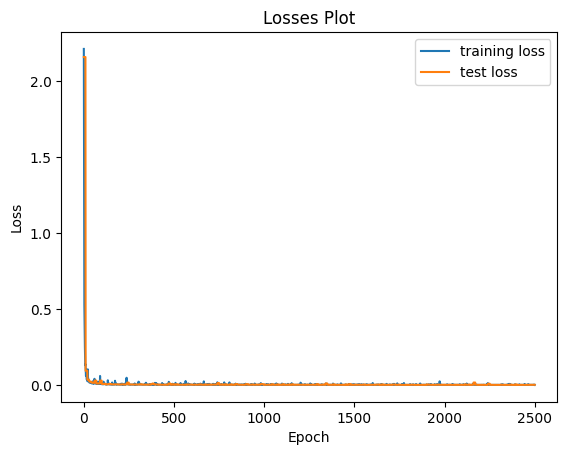

In [40]:
plot_training(losses, test_losses)

## 4. Model inference

### 4.1 Model inference utility functions

#### Load trajectory to do inference

In [47]:
def load_trajectory_for_inference(filename):
    to_predict_trajectories = {}
    with open(os.path.join(trajectories_dir, '{filename}.json'.format(filename=filename)), 'r') as file:
        to_predict_trajectories[filename] = json.load(file)

    # Calculate model parameters
    to_predict_dataset = generate_graph_dataset(to_predict_trajectories, 1, 1, dt)
    num_node_features = to_predict_dataset[0].x.shape[1]
    num_edge_features = to_predict_dataset[0].edge_attr.shape[1]
    num_classes = 3 # shape 3 (displacement)
    
    return to_predict_trajectories, num_node_features, num_edge_features, num_classes

#### Load trained model

In [42]:
def load_trained_model(model_filename, args, num_node_features, num_edge_features, num_classes):
    trained_model = MeshGraphNet(num_node_features, num_edge_features, args.hidden_dim, num_classes, args).to(args.device)
    trained_model.load_state_dict(torch.load(os.path.join(trained_models_dir, model_filename), map_location = args.device))
    
    return trained_model

#### Updater

##### Updater function to integrate all timesteps knowing the ground truth

In [43]:
def updater(to_predict_trajectories, trajectory, model, total_pred_ts, dt):
    print("Copying data...")
    to_predict_trajectories_updated = copy.deepcopy(to_predict_trajectories)
    print("Calculating predictions...")
    for ts in tqdm(range(total_pred_ts), unit="ts"):
        # ==================== Generate graph dataset =================================
        to_predict_dataset = [generate_graph(ts, to_predict_trajectories_updated, trajectory, dt)]
        
        # ======================  Predict  ===========================================
        trained_model.eval() # Set model to evaluation mode
        with torch.no_grad(): # disable gradient calculation during inference
            stats_list = get_stats(to_predict_dataset)
            
            mean_x, std_x = stats_list[0].to(args.device), stats_list[1].to(args.device)
            mean_edge, std_edge = stats_list[2].to(args.device), stats_list[3].to(args.device)
            mean_y, std_y = stats_list[4].to(args.device), stats_list[5].to(args.device)
            
            pred = trained_model(to_predict_dataset[0], mean_x, std_x, mean_edge, std_edge)
        
            # ============================ Update vertices ===============================
        new_vertices = np.array(to_predict_trajectories_updated[trajectory]['mesh_pos'][ts+1]) + unnormalize(pred.numpy(), mean_y.numpy(), std_y.numpy())*dt
        to_predict_trajectories_updated[filename]['mesh_pos'][ts] = new_vertices.tolist()

    compare_trajectories = {
        "gt_mesh_pos": to_predict_trajectories[trajectory]["mesh_pos"],
        "pred_mesh_pos": to_predict_trajectories_updated[trajectory]["mesh_pos"]
    }
    return np.array(to_predict_trajectories_updated[trajectory]['mesh_pos'][total_pred_ts]), compare_trajectories

#### Plot data

In [44]:
def plot_comparison(compare_trajectories_dictionary, timestep_to_compare, elev=90, azim=90):
    pred_verts = np.array(compare_trajectories_dictionary['pred_mesh_pos'][timestep_to_compare])
    gt_verts = np.array(compare_trajectories_dictionary['gt_mesh_pos'][timestep_to_compare])
    
    # ============================================= Plot gt vs pred =======================================================
    fig = plt.figure(figsize=(10, 8))

    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(pred_verts[:, 0], pred_verts[:, 1], pred_verts[:, 2], c='r', marker='.', s=1)

    ax1.set_title('Prediction')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_aspect('equal')
    ax1.view_init(elev=elev, azim=azim)

    ax2 = fig.add_subplot(122, projection='3d')

    ax2.scatter(gt_verts[:, 0], gt_verts[:, 1], gt_verts[:, 2], c='g', marker='.', s=1)

    ax2.set_title('Ground truth')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.set_aspect('equal')
    ax2.view_init(elev=elev, azim=azim)

    plt.tight_layout()
    plt.show()
    
    # ============================================= Plot displacement error =======================================================
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    displacement = gt_verts-pred_verts

    quiver = ax.quiver(pred_verts[:, 0][::], pred_verts[:, 1][::], pred_verts[:, 2][::], 
              displacement[:, 0][::], displacement[:, 1][::], displacement[:, 2][::], 
              normalize=False, color='b', label='Displacement Vectors')

    ax.set_title('Displacement error')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=elev, azim=azim)
    ax.set_aspect('equal')

    plt.show()
    
    # ============================================  Calculate mean error ========================================================
    ss = 0
    num_err = 0
    for i, error in tqdm(enumerate(displacement)):
        ss += math.sqrt(error[0]**2 + error[1]**2 + error[2]**2)
        num_err += 1

    mean_error = ss/num_err
    print(f'Mean error: {mean_error*1000} microns')

### 4.2 Inferences

#### Example inference over training data: I

In [45]:
# Parameters
filename = "I"
model_filename = "trained_model.pt"
dt = 5
timesteps = 100

In [48]:
# Load trajectory to predict
to_predict_trajectories, num_node_features, num_edge_features, num_classes = load_trajectory_for_inference(filename)

Trajectory:  0 - I


In [49]:
# Load trained model
trained_model = load_trained_model(model_filename, args, num_node_features, num_edge_features, num_classes)

In [50]:
# Run updater to predict the physics
pred_vertices, compare_trajectories = updater(to_predict_trajectories, filename, trained_model, timesteps, dt)

Copying data...
Calculating predictions...


100%|████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.41ts/s]


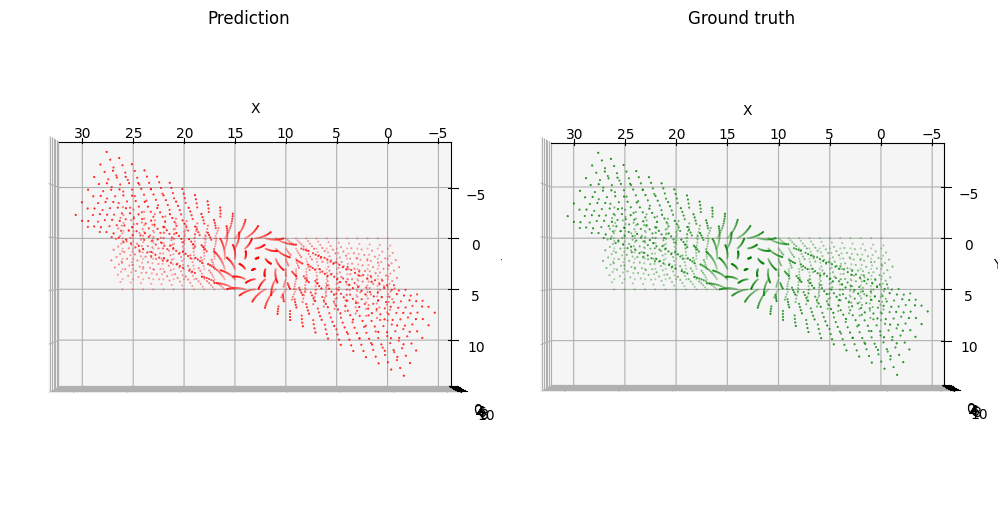

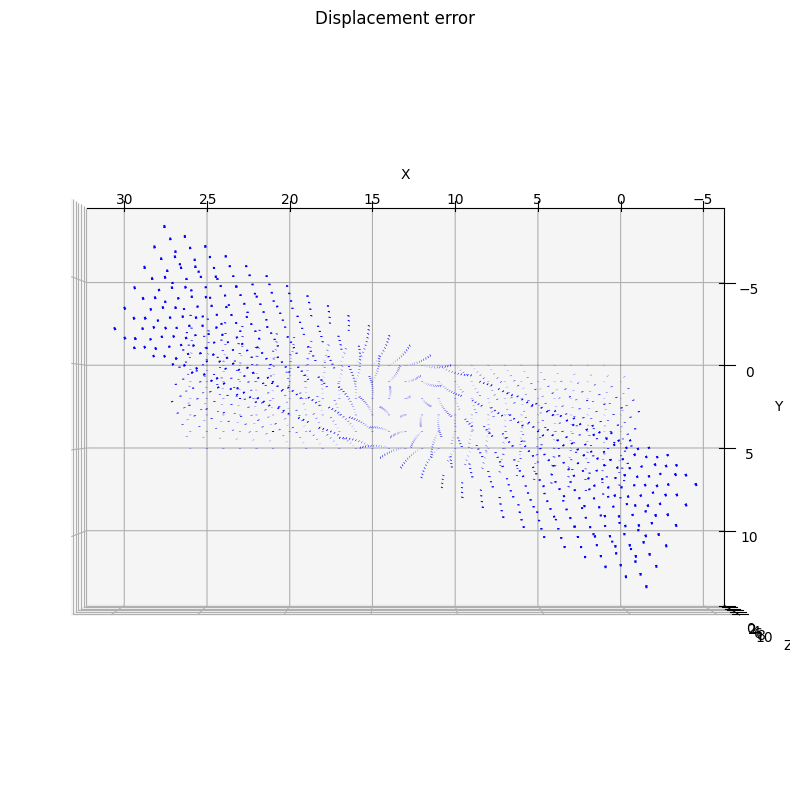

1558it [00:00, 762778.76it/s]

Mean error: 40.86636532785198 microns


In [51]:
# PLot comparison
timestep_to_compare = len(compare_trajectories['pred_mesh_pos'])-2
plot_comparison(compare_trajectories, timestep_to_compare, elev=90, azim=90)

#### Example inference over unseen data: T

In [52]:
# Parameters
filename = "T"
model_filename = "trained_model.pt"
dt = 5
timesteps = 100

In [53]:
# Load trajectory to predict
to_predict_trajectories, num_node_features, num_edge_features, num_classes = load_trajectory_for_inference(filename)

Trajectory:  0 - T


In [54]:
# Load trained model
trained_model = load_trained_model(model_filename, args, num_node_features, num_edge_features, num_classes)

In [55]:
# Run updater to predict the physics
pred_vertices, compare_trajectories = updater(to_predict_trajectories, filename, trained_model, timesteps, dt)

Copying data...
Calculating predictions...


100%|████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.02ts/s]


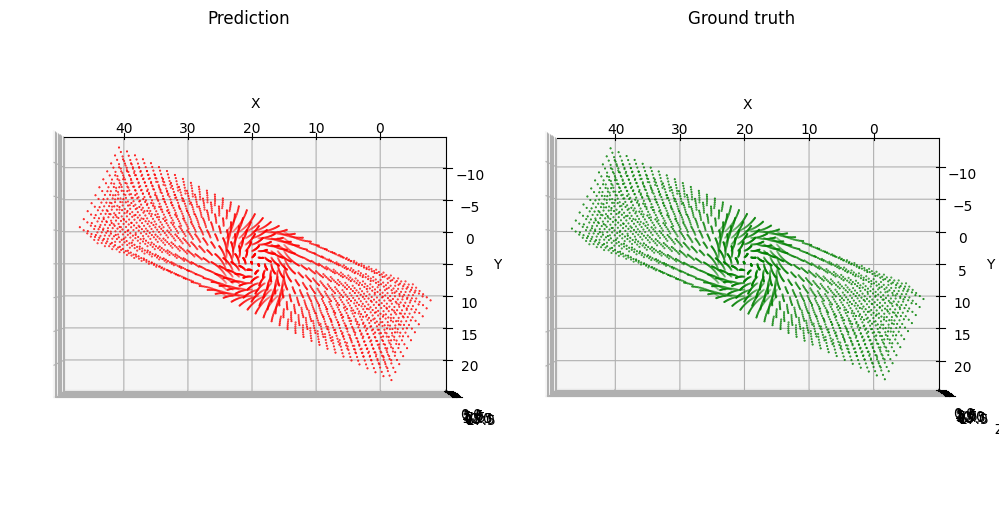

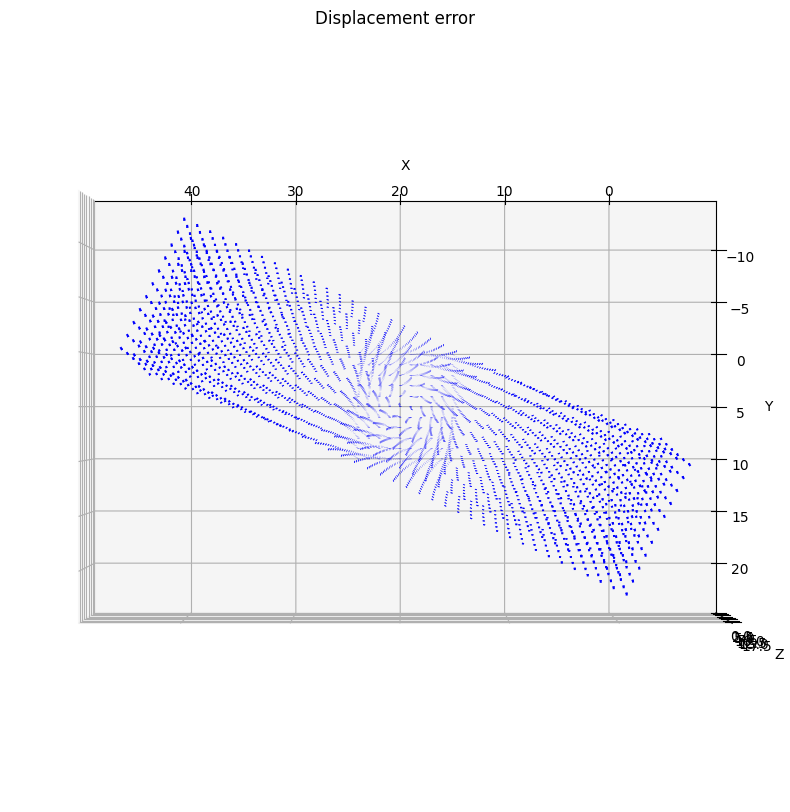

4180it [00:00, 780839.56it/s]

Mean error: 80.60587360798127 microns


In [56]:
# PLot comparison
timestep_to_compare = len(compare_trajectories['pred_mesh_pos'])-2
plot_comparison(compare_trajectories, timestep_to_compare, elev=90, azim=90)